# Technical demand response potential clustering

**Puporse and background**: This notebook serves for clustering the technical demand response potentials 
which were collected in a previous meta-analysis (Kochems 2020). This clustering routine is necessary since depicting all 
different units in the electricity market model would be computationally too expensive.

## Method applied
In the following, a brief description of the method applied is given for the sake of replicability.

### Filtering of demand response categories
The term "demand response categories" is introduced to describe the heterogeneous potential segmentation 
routines used in the publications evaluated within the meta-analysis. These demand response categories include 
processes, applications as well as entrire branches and mixtures of these categories.
* In the first step, data for entire branches is filtered out since in most cases there are to few data points and 
further information on availability is lacking. Thus, only data for processes and applications remain.
* In addition to that, categories covering different branches / appliances are filtered out since these would 
cause redundancies to publications analyzing the appliances in detail.

### Prepare and manipulate data for further usage (clustering / modeling)
In the second step, the data is manipulated for further usage in the clustering process as well as for the ensuing power market model analysis. This in turn consists of a few procedures:
* The data is combined to an overall data set and missing values are interpolated using the median value per sector. The parameters are filtered in order only to include those which are needed in demand response modeling in a power market model.
* A pairwhise correlation analysis using pearson's correlation coefficient is carried out in order to identify which parameters can be expressed through other ones since they show a high correlation. 
* Data is interpolated in order to remove inplausibilities. The data for the status quo is kept. The values for 2030 and 2050 are used to define trends in potential development. A linear interpolation is made in between. As far as the cost values are concerned, the values for the status quo as well as the minimum value are kept. The minimum value is assigned to 2050 and a linear interpolation is made in between.
> _Note: While the interpolation solution is preferable in terms of simplicity, it lacks some consistency: on the one hand in terms of a development of positive and negative potentials in line, on the other hand as for general trends within the sectors (such as declining industry production in the long run). This should be replaced by a more profound approach._

### Clustering of demand response categories
A clustering of demand response categories is carried out in the second step. 
A k-means clustering approach is used (as an alternative, it is possible to choose agglomerative clustering using ward linkage).<br>
Demand response categories are clustered using the (median values of the) following parameters (see also Steurer 2017, p. 83):
* shifting duration
* positive interference duration (shedding duration),
* variable costs,
* fixed costs and
* specific investments.

Some further aspects are worth mentioning:
* Negative interference duration is not taken into account because some processes are only eligible for load shedding and hence don't have a negative interference duration. In addition to that, a strong correlation between positive and negative interference duration has been detected.
* The clustering does not need to take into account the lower, middle and upper value for each parameter. A strong correlation between the values was determined which is why only the median values are used for the clustering. 
* Furthermore, the clustering is only carried out for the status quo and does not take development projections into account.
* The distinction between different sectors is kept. Some heating and cooling applications for tcs and households are combined since they comprise basically the same technology and creating identical clusters would not make much sense.
* For the aggregation of demand response parameters after clustering, a weighting by the available shifting resp. shedding capacity is carried out.

### Determination of availability
Since demand response potentials are time-dependent, availability has to be taken into account.<br>
For the analysis, the individual availability time series in hourly resolution of the original 
demand response categories are put together by calculating capacity weighted averages for the identified 
demand response clusters.

The availability time series are put together based on literature assumptions:
* The largest amount of the availability time series for individual demand response categories were created within three bachelor theses based on literature assumptions. They were put together in a separate notebook. The data output of this notebook in turn is read in here to form availability time series of demand response clusters.
* Some processes haven't been analyzed in the bachelor theses resp. the literature. For these, either existing availability time series of very similar demand response categories are assigned or own assumptions are made.
> _Note: These own assumptions for now are ("best guess") dummy values and should be replaced by more profound ones._
***

__*Important remaining TODOs:*__
* __*Revise parameters and potential development by including trend extrapolation / assumptions*__
* __*Revise proxies for availability time series*__
* __*Include the distinction between shifting and shedding &rarr; should be a criterion for separate cluster assignment*__

# Package imports
* Standard imports: scikit-learn (sklearn) is used for the clustering since it has built-in clustering routines, such as K-means
* User-defined functions:
    * *create_parameter_combinations*: Combines parameter names with measures of central tendency
    * *group_potential*: Does a grouping of the clusters determined using given aggregation functions per parameter
    * *wtrie_multiple_sheets*: Used to write multiple DataFrames as sheets at once into an Excel workbook
    * *map_column_names*: Maps column names of availability time series to the potential data column names.
    * *determine_missing_columns*: Lists the columns for which availability time series information is lacking and assumptions are needed.
    * *get_top_abs_correlations*: Determines the strongest correlation within a given correlation matrix.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import linregress
from IPython.core.display import display

from potential_clustering_funcs import (create_parameter_combinations, group_potential, write_multiple_sheets,
    map_column_names, determine_missing_cols, assign_availability_remaining, get_top_abs_correlations)

In [2]:
%matplotlib inline

# Parameter settings
Set path folder and filenames for reading in data.

Further parameters for controlling the workflow:
* *skip_dev*: If True, skip cells that are currently under development to keep overall functionality of notebook
* *write_outputs*: If True, outputs, i.e. demand response parameterizations resulting from the meta-analysis will be written into Excel workbooks
* *join_duplicates*: If True, demand response categories occuring in both, household and tcs sector will be combined together.
* *write_categories*: If True, the remaining categories will be written to Excel in order to match them with the
availability data.
* *adjust_potentials*: If True, availability time series information will be used to adjust the potential information. (I. e. if at max. 0.8 is reached, max potential will be set to 0.8 * max_potential)

Parameters for controlling the clustering routines:
* *cols*: Determine, which columns of the stats DataFrame shall be used for demand response parameterization
    * Usually lower and upper quartile as well as median are used.
> Note: This eliminates extreme values which are taken into account when min and max are used instead.<br>
The upper quartile of overall potential will be interpreted as maximum available potential. A possible alternative would be to use min and max values to depict extremes. &rarr; Advantage: would be more compelling. Drawback: Data lack for potential max.
* *cluster_parameters*: Determine, which demand response parameters to use for the clustering process. 
By default, these are the shifting duration, positive interference duration, variable costs as well as fixed costs.
* *cluster_algo*: The clustering algorithmn to be used ("KMeans" or "ward")
* *share_clusters*: Decide, how strong the original data will be reduced by giving a percentage of the original length. 
The cluster number is determined by the next higher integer. (Only applicable for k-means)
* *distance_threshold*: Decide, what distance threshold shall be set for the hierarchical clustering using ward 
linkage, i.e., when the algorithm should terminate.
* *print_clusters*: If True, prints out the clusters created (DataFrames)
* *use_ava_ts_for_profiles*: If True, availability time series in positive direction will be directly used to derive load profiles for the demand response categories resp. clusters, else profiles from the demand regio disaggregator will be applied

In [3]:
# Set path folder(s) and filename(s) for reading in / writing data
path_folder_in = "./"
path_folder_stats = "./out/stats/"
path_folder_availability = "./out/availability/"
path_folder_parameterization = "./out/parameterization/"
filename_in = "Potenziale_Lastmanagement.xlsx"
filename_availability_in = "availability_timeseries.xlsx"
filename_out = "parameterization"
filename_corr_out = "correlation"
filename_availability_out = "availability_timeseries_clusters.csv"
filename_load_profiles_out = "load_profile_timeseries_clusters"

# Set further parameters for controlling the workflow
skip_dev = True
write_outputs = True
join_duplicates = True
write_categories = True
adjust_potentials = True

# Determine clustering approach
cols = ["25%", "50%", "75%"]
cluster_parameters = ["shifting_duration", "interference_duration_pos", 
                      "variable_costs", "fixed_costs", "specific_investments"]
# Correlation analysis: optionally add potential_pos_overall (for all potential metrics)

cluster_algo = "KMeans"
share_clusters = 0.1
distance_threshold = 1000
print_clusters = True
use_ava_ts_for_profiles = True

# Read in and filter data
* Read in the categories data and filter out branches as well as power-to-X-technologies which won't be considered anymore.
* Read in the stats information on the demand response parameters from the previous meta-analysis.

> _NOTE: Data that is read in here could also be obtained directly from the DataFrames of the potential evaluation notebook. A separate notebook is used here only for the sake of shortness and readability._

## Read in and filter demand response categories
Read in demand response categories and filter out entire branches as well as categories conflicting with others or outside of scope.
Show the original number of categories and print the remaining number after filtering (without duplicates since categories may be used within different sectors).

In [4]:
# Read in demand response categories from worksheet and filter out branches resp. power-to-X-technologies.
# Drop categories summarizing over several technologies / applications as well as categories not eligible or not whithin scope.
cats_to_drop = ["QST gesamt", "Raumwärme", 
                "Hybrid-Wärmeerzeugungssysteme (Widerstandserhitzer / Wärmepumpe + Erdgas-Brennwertkessel)",
                "elektrische Direktheizungen"]

categories = pd.read_excel(path_folder_in+filename_in, sheet_name="Kategorien", index_col=0)
print("Number of original categories:\t{}".format(categories.shape[0]))
categories = categories[categories["Nutzung Prozesskategorie 1"] == 1 & 
                        ~categories["Einstufung"].isin(["Branche", "Power-to-X"])]
categories = categories.drop_duplicates(subset="Prozesskategorie 1")
categories = categories.set_index(["Prozesskategorie 1"], drop=True).drop(cats_to_drop)
print("Number of remaining categories:\t{}".format(categories.shape[0]))

# Show the remaining demand response categories which are evaluated
list(categories.index.values)

Number of original categories:	98
Number of remaining categories:	38


['Chlor-Alkali-Elektrolyse',
 'Luftzerlegung',
 'Primäraluminiumelektrolyse',
 'Kupfer- und Zinkherstellung (Elektrolyse)',
 'Holz- und Zellstoffherstellung',
 'Altpapierrecycling (Pulper)',
 'Papiermaschinen',
 'Papierveredelung (Streichmaschinen und Kalander)',
 'Elektrostahlherstellung (Lichtbogenofen)',
 'Zementherstellung',
 'Kühlung (Lebensmittelindustrie)',
 'Belüftung',
 'Kühlhäuser',
 'Prozesskälte',
 'Klimakälte',
 'Warmwasserbereitstellung',
 'Nachtspeicherheizungen',
 'Notstromaggregate, Back-Up-Server und Mobilfunkstationen',
 'Waschmaschinen',
 'Wäschetrockner',
 'Geschirrspüler',
 'Kühlschränke',
 'Gefrierschränke und -truhen',
 'Wärmepumpen',
 'Heizungsumwälzpumpen',
 'Prozesswärme',
 'Druckluftanwendungen',
 'Abwasserbehandlung',
 'Kühl- und Gefrierkombinationen',
 'Calciumcarbid-Herstellung (Lichtbogenofen)',
 'Pumpenanwendungen in der Wasserversorgung',
 'Prozesskälte Handel',
 'Beleuchtung',
 'Pumpenanwendungen',
 'Gießereien (Induktionsofen)',
 'Zerkleinerer',
 'El

## Read in demand response parameters data
* Assign each demand response parameter an aggregation function to be used after clustering (sum or mean).
* Determine for which parameters to swap the order of preference.
> _Note: This is necessary, because in some cases minimum values are needed for an optimistic 
demand response projection and maximum for a pessimistic one, e.g. for minimum load factor. <br>
Hence, for these parameters, min is exchanged for max etc._
* Read in the data and store it in a dictionary indexed by demand response parameter. Hereby, a separation is necessary:
    * For the clustering process, certain appliances for the household and tcs sector should be combined, e.g. heat pumps. A new sector "tcs+hoho" is introduced for this purpose and the respective values are combined.
    * For calculating availabilities, a (re-)separation is necessary. This is because availability time series of the appliances may (slightly) differ among the sectors. &rarr; Herefore, a second dict is introduced.

In [5]:
# Assgin each parameter the aggregation function to be used.
# Furthermore, decide whether or not to swap the order of entries.
parameters_groups_dict = {"activation_duration": ("mean", "swap"), 
                          "ave_load": ("mean", "swap"), 
                          "fixed_costs":("mean", "swap"), 
                          "installed_cap": ("sum", "no_swap"),
                          "interference_duration_neg": ("mean", "no_swap"), 
                          "interference_duration_pos": ("mean", "no_swap"),
                          "max_load": ("mean", "no_swap"), 
                          "maximum_activations_year": ("mean", "no_swap"), 
                          "min_load": ("mean", "swap"), 
                          "potential_neg_ave": ("sum", "swap"), 
                          "potential_neg_min": ("sum", "swap"), 
                          "potential_neg_max": ("sum", "swap"), 
                          "potential_neg_overall": ("sum", "swap"),
                          "potential_pos_ave": ("sum", "no_swap"), 
                          "potential_pos_min": ("sum", "no_swap"), 
                          "potential_pos_max": ("sum", "no_swap"), 
                          "potential_pos_overall": ("sum", "no_swap"),
                          "regeneration_duration": ("mean", "swap"), 
                          "shiftable_share": ("mean", "no_swap"), 
                          "shifting_duration": ("mean", "no_swap"),
                          "specific_investments": ("mean", "swap"), 
                          "variable_costs": ("mean", "swap")}

sectors = ["ind", "tcs", "hoho"]

years = ["SQ", "2020", "2025", "2030", "2035", "2040", "2045", "2050"]

to_join = ["Nachtspeicherheizungen", "Warmwasserbereitstellung", "Wärmepumpen", "Klimakälte"]
to_drop = {"Prozesskälte": "hoho"}

> _NOTE: While the fundamental routine here is quite okay and fast enough, there is room for improvement in the aggregation routine for the duplicates DataFrame, i.e. the DataFrame containing data for tcs+hoho which is then aggregated. Fo a compelling approach, a capacity weighted average should be calaculated using overall positive potential as capacity information. In order to do so, capacity information has to be added to the individual data sets._

In [6]:
categories.index

Index(['Chlor-Alkali-Elektrolyse', 'Luftzerlegung',
       'Primäraluminiumelektrolyse',
       'Kupfer- und Zinkherstellung (Elektrolyse)',
       'Holz- und Zellstoffherstellung', 'Altpapierrecycling (Pulper)',
       'Papiermaschinen', 'Papierveredelung (Streichmaschinen und Kalander)',
       'Elektrostahlherstellung (Lichtbogenofen)', 'Zementherstellung',
       'Kühlung (Lebensmittelindustrie)', 'Belüftung', 'Kühlhäuser',
       'Prozesskälte', 'Klimakälte', 'Warmwasserbereitstellung',
       'Nachtspeicherheizungen',
       'Notstromaggregate, Back-Up-Server und Mobilfunkstationen',
       'Waschmaschinen', 'Wäschetrockner', 'Geschirrspüler', 'Kühlschränke',
       'Gefrierschränke und -truhen', 'Wärmepumpen', 'Heizungsumwälzpumpen',
       'Prozesswärme', 'Druckluftanwendungen', 'Abwasserbehandlung',
       'Kühl- und Gefrierkombinationen',
       'Calciumcarbid-Herstellung (Lichtbogenofen)',
       'Pumpenanwendungen in der Wasserversorgung', 'Prozesskälte Handel',
       'Bel

In [7]:
# parameters_dict holds the data for all demand response parameters, sectors and years.
# It is indexed by the parameters.
# parameters_dict_nojoin is basically the same, but without filtering out 
# resp. joining duplicate values for different sectors.
parameters_dict = {}
parameters_dict_nojoin = {}

# Count the number of params for which no data is available
count_ignored = 0

for parameter in parameters_groups_dict.keys():
    parameters_dict[parameter] = pd.DataFrame(columns=["sector", "count", "mean", "std", 
                                                       "min", "25%", "50%", "75%", "max", "year_key"])
    for year in years:
        for sector in sectors:
            try:
                new_df = pd.read_excel(path_folder_stats+parameter+"_"+sector+"_stats.xlsx", 
                                       sheet_name=year, 
                                       index_col=0).T
                new_df["sector"] = sector
                new_df["year_key"] = year
                print(sector, parameter)
                parameters_dict[parameter] = pd.concat([parameters_dict[parameter], new_df], sort="False")
            except:
                count_ignored += 1
                continue
        
        # Filter out the categories to be used and temporarily change index for further filtering
        parameters_dict[parameter] = parameters_dict[parameter][parameters_dict[parameter].index.isin(categories.index)]
        display(parameters_dict[parameter])
        parameters_dict[parameter] = parameters_dict[parameter].set_index([parameters_dict[parameter].index, "sector"], 
                                                                          drop=False)
        # Drop certain load management categories for certain sectors only
        for k, v in to_drop.items():
            if ((k, v)) in parameters_dict[parameter].index:
                parameters_dict[parameter] = parameters_dict[parameter].drop(((k, v)))
        parameters_dict[parameter] = parameters_dict[parameter].set_index(
            parameters_dict[parameter].index.get_level_values(0))
        parameters_dict[parameter].index.name = "Prozess"
        
        parameters_dict_nojoin[parameter] = parameters_dict[parameter]

    # Combine demand response categories for tcs and and sector
    if join_duplicates:
        # Remove duplicate values in index for tcs and households sector
        parameters_dict[parameter] = parameters_dict[parameter].set_index([parameters_dict[parameter].index, "year_key"])
        duplicates = (parameters_dict[parameter].index.duplicated(keep=False) 
                      & parameters_dict[parameter]["sector"].isin(["hoho", "tcs"]))

        # Get duplicates within duplicates (i.e. filter out the values where 
        # the same demand response categories occur in tcs and industry sector)
        duplicates_df = parameters_dict[parameter][duplicates]
        duplicates_df = duplicates_df[duplicates_df.index.duplicated(keep=False)]
        
        # Filter out the remaining duplicate values from original DataFrame
        keys = list(duplicates_df.columns.values)
        i1 = parameters_dict[parameter].set_index(keys).index
        i2 = duplicates_df.set_index(keys).index
        no_duplicates_df = parameters_dict[parameter][~i1.isin(i2)]
        
        # Assign certain demand response categories to a mix of tcs+hoho sector
        for el in to_join:
            if el in no_duplicates_df.index:
                no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x: 
                                                                                   x if x == "ind" else "tcs+hoho")
                no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
                no_duplicates_df = no_duplicates_df.drop(["help_sector"], axis=1)
                
        # drop index for grouping
        duplicates_df = duplicates_df.reset_index(drop=False)
        no_duplicates_df = no_duplicates_df.reset_index(drop=False)

        if not duplicates_df.empty:

            # Aggregate values for the remaining duplicates dependent on the kind of parameter
            if parameters_groups_dict[parameter][0] == "mean":
                duplicates_df = group_potential(duplicates_df, grouping_cols=["Prozess", "year_key"], 
                                                mean_cols=["25%", "50%", "75%", "mean", "std"], sum_cols=["count"],
                                                min_cols=["min"], max_cols=["max"], add_cluster=False, 
                                                weighted_ave=False)
            else:
                duplicates_df = group_potential(duplicates_df, grouping_cols=["Prozess", "year_key"], 
                                                sum_cols=["min", "max", "25%", "50%", "75%", "mean", "std", "count"],
                                                add_cluster=False, weighted_ave=False)

            # Add sector information again and concat original DataFrame and the aggregated remaining duplicates again
            duplicates_df["sector"] = "tcs+hoho"
        
        parameters_dict[parameter] = pd.concat([no_duplicates_df, duplicates_df], 
                                               sort=False).set_index("Prozess")

    # Change the order of preference for certain parameters
    if parameters_groups_dict[parameter][1] == "swap":
        try:
            parameters_dict[parameter][["min_copy","25%_copy", 
                                        "75%_copy", "max_copy"]] = parameters_dict[parameter][["min", "25%", 
                                                                                               "75%", "max"]]
            parameters_dict[parameter][["min", "25%", 
                                        "75%", "max"]] = parameters_dict[parameter][["max_copy", "75%_copy", 
                                                                                     "25%_copy", "min_copy"]]
            parameters_dict[parameter] = parameters_dict[parameter].drop(["min_copy","25%_copy", 
                                                                          "75%_copy", "max_copy"], axis=1)

            parameters_dict_nojoin[parameter][["min_copy","25%_copy", 
                                               "75%_copy", "max_copy"]] = parameters_dict_nojoin[parameter][["min", "25%", 
                                                                                                             "75%", "max"]]
            parameters_dict_nojoin[parameter][["min", "25%", 
                                               "75%", "max"]] = parameters_dict_nojoin[parameter][["max_copy", "75%_copy", 
                                                                                                   "25%_copy", "min_copy"]]
            parameters_dict_nojoin[parameter] = parameters_dict_nojoin[parameter].drop(["min_copy","25%_copy", 
                                                                                        "75%_copy", "max_copy"], axis=1)
        except:
            continue

if join_duplicates:
    sectors.append("tcs+hoho")

print("Overall number of params (sectors, years, params): "+str(len(parameters_groups_dict) * (len(sectors) -1) * len(years)))
print("Number of params not eligible for evaluation: "+str(count_ignored))

ind activation_duration
hoho activation_duration


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.400208   
Papiermaschinen                             1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.166667  0.821969   
Zementherstellung                           0.166667  0.250000  0.250000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.012917  0.066458  0.214062   
Altpapierrecycling (Pulper)                 0.124792  0.374583  0.703750   
Gießereien (Induktionsofen)                 0.104167  0.166667  0.229167   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   

                                            count        max      mean  \
Primäraluminiumelektrolyse                   13.0   0.500000  0.150230   
Chlor-Alkali-Elektrolyse                     16.0   1.000000  0.251187   
Holz- und Zellstoffherstellung               11.0   3.000000  0.492159   
Papiermaschinen                               8.0  12.000000  2.979687   
Elektrostahlherstellung (Lichtbogenofen)     12.0   3.000000  0.584455   
Zementherstellung                            13.0   0.500000  0.245192   
Kupfer- und Zinkherstellung (Elektrolyse)     6.0   0.250000  0.106921   
Altpapierrecycling (Pulper)                   6.0   3.000000  0.768750   
Gießereien (Induktionsofen)                   6.0   0.250000  0.166667   
Calciumcarbid-Herstellung (Lichtbogenofen)    6.0   0.250000  0.166667   
Wärmepumpen                                   3.0   0.083333  0.028389   
Nachtspeicherheizungen                        3.0   0.083333  0.028389   

                                                 min sector       std year_key  
Primäraluminiumelektrolyse                  0.000000    ind  0.153851       SQ  
Chlor-Alkali-Elektrolyse                    0.000000    ind  0.310194       SQ  
Holz- und Zellstoffherstellung              0.008333    ind  0.861635       SQ  
Papiermaschinen                             0.250000    ind  3.780849       SQ  
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind  0.924036       SQ  
Zementherstellung                           0.083333    ind  0.133981       SQ  
Kupfer- und Zinkherstellung (Elektrolyse)   0.000278    ind  0.117027       SQ  
Altpapierrecycling (Pulper)                 0.008333    ind  1.128602       SQ  
Gießereien (Induktionsofen)                 0.083333    ind  0.074536       SQ  
Calciumcarbid-Herstellung (Lichtbogenofen)  0.083333    ind  0.074536       SQ  
Wärmepumpen                                 0.000167   hoho  0.047589       SQ  
Nachtspeicherheizungen                      0.000167   hoho  0.047589       SQ

ind activation_duration
hoho activation_duration


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.400208   
Papiermaschinen                             1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.166667  0.821969   
Zementherstellung                           0.166667  0.250000  0.250000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.012917  0.066458  0.214062   
Altpapierrecycling (Pulper)                 0.124792  0.374583  0.703750   
Gießereien (Induktionsofen)                 0.104167  0.166667  0.229167   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.062542  0.202861  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.450104   
Papiermaschinen                             0.981250  1.625000  2.500000   
Elektrostahlherstellung (Lichtbogenofen)    0.000278  0.166667  0.634469   
Zementherstellung                           0.145833  0.250000  0.255208   
Altpapierrecycling (Pulper)                 0.115127  0.355255  0.703750   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   

                                            count        max      mean  \
Primäraluminiumelektrolyse                   13.0   0.500000  0.150230   
Chlor-Alkali-Elektrolyse                     16.0   1.000000  0.251187   
Holz- und Zellstoffherstellung               11.0   3.000000  0.492159   
Papiermaschinen                               8.0  12.000000  2.979687   
Elektrostahlherstellung (Lichtbogenofen)     12.0   3.000000  0.584455   
Zementherstellung                            13.0   0.500000  0.245192   
Kupfer- und Zinkherstellung (Elektrolyse)     6.0   0.250000  0.106921   
Altpapierrecycling (Pulper)                   6.0   3.000000  0.768750   
Gießereien (Induktionsofen)                   6.0   0.250000  0.166667   
Calciumcarbid-Herstellung (Lichtbogenofen)    6.0   0.250000  0.166667   
Wärmepumpen                                   3.0   0.083333  0.028389   
Nachtspeicherheizungen                        3.0   0.083333  0.028389   
Primäraluminiumelektrolyse                   13.0   0.500000  0.150230   
Chlor-Alkali-Elektrolyse                     12.0   1.000000  0.214884   
Holz- und Zellstoffherstellung               10.0   3.000000  0.533042   
Papiermaschinen                               7.0   3.000000  1.691071   
Elektrostahlherstellung (Lichtbogenofen)     10.0   3.000000  0.601332   
Zementherstellung                            12.0   0.500000  0.244792   
Altpapierrecycling (Pulper)                   6.0   3.000000  0.762307   
Calciumcarbid-Herstellung (Lichtbogenofen)    6.0   0.250000  0.166667   
Kupfer- und Zinkherstellung (Elektrolyse)     6.0   0.250000  0.126337   
Gießereien (Induktionsofen)                   6.0   0.250000  0.137436   
Wärmepumpen                                   3.0   0.083333  0.028389   
Nachtspeicherheizungen                        3.0   0.083333  0.028389   

                                                 min sector       std year_key  
Primäraluminiumelektrolyse                  0.000000    ind  0.153851       SQ  
Chlor-Alkali-Elektrolyse                    0.000000    ind  0.310194       SQ  
Holz- und Zellstoffherstellung              0.008333  

ind activation_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.400208   
Papiermaschinen                             1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.166667  0.821969   
Zementherstellung                           0.166667  0.250000  0.250000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.012917  0.066458  0.214062   
Altpapierrecycling (Pulper)                 0.124792  0.374583  0.703750   
Gießereien (Induktionsofen)                 0.104167  0.166667  0.229167   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.062542  0.202861  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.450104   
Papiermaschinen                             0.981250  1.625000  2.500000   
Elektrostahlherstellung (Lichtbogenofen)    0.000278  0.166667  0.634469   
Zementherstellung                           0.145833  0.250000  0.255208   
Altpapierrecycling (Pulper)                 0.115127  0.355255  0.703750   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001412  0.045833  0.238063   
Chlor-Alkali-Elektrolyse                    0.062500  0.164233  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.275208  0.567917   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.041806  0.378156   
Zementherstellung                           0.083333  0.208333  0.255208   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Papiermaschinen                             0.740625  1.543750  2.656250   
Altpapierrecycling (Pulper)                 0.114822  0.354643  0.703750   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   

                                            count        max      mean  \
Primäraluminiumelektrolyse                   13.0   0.500000  0.150230   
Chlor-Alkali-Elektrolyse                     16.0   1.000000  0.251187   
Holz- und Zellstoffherstellung               11.0   3.000000  0.492159   
Papiermaschinen                               8.0  12.000000  2.979687   
Elektrostahlherstellung (Lichtbogenofen)     12.0   3.000000  0.584455   
Zementherstellung                            13.0   0.500000  0.245192   
Kupfer- und Zinkherstellung (Elektrolyse)     6.0   0.250000  0.106921   
Altpapierrecycling (Pulper)                   6.0   3.000000  0.768750   
Gießereien (Induktionsofen)                   6.0   0.250000  0.166667   
Calciumcarbid-Herstellung (Lichtbogenofen)    6.0   0.250000  0.166667   
Wärmepumpen                                   3.0   0.083333  0.028389   
Nachtspeicherheizungen                        3.0   0.083333  0.028389   
Primäraluminiumelektrolyse                   13.0   0.500000  0.150230   
Chlor-Alkali-Elektrolyse                     12.0   1.000000  0.214884   
Holz- und Zellstoffherstellung               10.0   3.000000  0.533042   
Papiermaschinen                               7.0   3.000000  1.691071   
Elektrostahlherstellung (Lichtbogenofen)     10.0   3.000000  0.601332   
Zementherstellung                            12.0   0.50

ind activation_duration
hoho activation_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.400208   
Papiermaschinen                             1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.166667  0.821969   
Zementherstellung                           0.166667  0.250000  0.250000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.012917  0.066458  0.214062   
Altpapierrecycling (Pulper)                 0.124792  0.374583  0.703750   
Gießereien (Induktionsofen)                 0.104167  0.166667  0.229167   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.062542  0.202861  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.450104   
Papiermaschinen                             0.981250  1.625000  2.500000   
Elektrostahlherstellung (Lichtbogenofen)    0.000278  0.166667  0.634469   
Zementherstellung                           0.145833  0.250000  0.255208   
Altpapierrecycling (Pulper)                 0.115127  0.355255  0.703750   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001412  0.045833  0.238063   
Chlor-Alkali-Elektrolyse                    0.062500  0.164233  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.275208  0.567917   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.041806  0.378156   
Zementherstellung                           0.083333  0.208333  0.255208   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Papiermaschinen                             0.740625  1.543750  2.656250   
Altpapierrecycling (Pulper)                 0.114822  0.354643  0.703750   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Primäraluminiumelektrolyse                  0.001034  0.083333  0.250000   
Chlor-Alkali-Elektrolyse                    0.041750  0.166667  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.500000   
Papiermaschinen                             0.981250  1.625000  2.500000   
Elektrostahlherstellung (Lichtbogenofen)    0.000278  0.083333  0.762625   
Zementherstellung                           0.125000  0.250000  0.260417   
Altpapierrecycling (Pulper)                 0.114715  0.354430  0.703750   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   

                                            count        max      mean  \
Primäraluminiumelektrolyse                   13.0   0.500000  0.150230   
Chlor-Alkali-Elektrolyse                     16.0   1.000000  0.251187   
Holz- und Zellstoffherstellung               11.0   3.000000  0.492159   
Papiermaschinen                               8.0  12.000000  2.979687   
Elektrostahlherstellung (Lichtbogenofen)     12.0   3.000000  0.584455   
Zementherstellung               

ind activation_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.400208   
Papiermaschinen                             1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.166667  0.821969   
Zementherstellung                           0.166667  0.250000  0.250000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.012917  0.066458  0.214062   
Altpapierrecycling (Pulper)                 0.124792  0.374583  0.703750   
Gießereien (Induktionsofen)                 0.104167  0.166667  0.229167   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.062542  0.202861  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.450104   
Papiermaschinen                             0.981250  1.625000  2.500000   
Elektrostahlherstellung (Lichtbogenofen)    0.000278  0.166667  0.634469   
Zementherstellung                           0.145833  0.250000  0.255208   
Altpapierrecycling (Pulper)                 0.115127  0.355255  0.703750   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.001412  0.045833  0.238063   
Chlor-Alkali-Elektrolyse                    0.062500  0.164233  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.275208  0.567917   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.041806  0.378156   
Zementherstellung                           0.083333  0.208333  0.255208   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Papiermaschinen                             0.740625  1.543750  2.656250   
Altpapierrecycling (Pulper)                 0.114822  0.354643  0.703750   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Primäraluminiumelektrolyse                  0.001034  0.083333  0.250000   
Chlor-Alkali-Elektrolyse                    0.041750  0.166667  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.500000   
Papiermaschinen                             0.981250  1.625000  2.500000   
Elektrostahlherstellung (Lichtbogenofen)    0.000278  0.083333  0.762625   
Zementherstellung                           0.125000  0.250000  0.260417   
Altpapierrecycling (Pulper)                 0.114715  0.354430  0.703750   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Wärmepumpen                                 0.000917  0.001667  0.042500   
Nachtspeicherheizungen                      0.000917  0.001667  0.042500   
Primäraluminiumelektrolyse                  0.000656  0.005062  0.177646   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Chlor-Alkali-Elektrolyse                    0.022352  0.164259  0.247278   
Elektrostahlherstellung (Lichtbogenofen)    0.000174  0.000278  0.572038   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   
Holz- und Zellstoffherstellung              0.137604  0.400208  0.703750   
Papiermaschinen      

ind activation_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  \
Primäraluminiumelektrolyse                 0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                   0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung             0.083333  0.250000  0.400208   
Papiermaschinen                            1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)   0.000243  0.166667  0.821969   
...                                             ...       ...       ...   
Holz- und Zellstoffherstellung             0.137604  0.400208  0.703750   
Papiermaschinen                            0.740625  1.543750  2.656250   
Altpapierrecycling (Pulper)                0.114460  0.353921  0.703750   
Zementherstellung                          0.104167  0.208333  0.265625   
Kupfer- und Zinkherstellung (Elektrolyse)  0.028367  0.124707  0.227737   

                                           count    max      mean       min  \
Primäraluminiumelektrolyse                  13.0   0.50  0.150230  0.000000   
Chlor-Alkali-Elektrolyse                    16.0   1.00  0.251187  0.000000   
Holz- und Zellstoffherstellung              11.0   3.00  0.492159  0.008333   
Papiermaschinen                              8.0  12.00  2.979687  0.250000   
Elektrostahlherstellung (Lichtbogenofen)    12.0   3.00  0.584455  0.000000   
...                                          ...    ...       ...       ...   
Holz- und Zellstoffherstellung               6.0   3.00  0.777292  0.008333   
Papiermaschinen                              6.0   3.00  1.639583  0.250000   
Altpapierrecycling (Pulper)                  6.0   3.00  0.761863  0.008333   
Zementherstellung                            6.0   0.50  0.225694  0.083333   
Kupfer- und Zinkherstellung (Elektrolyse)    6.0   0.25  0.126337  0.000278   

                                          sector       std year_key  
Primäraluminiumelektrolyse                   ind  0.153851       SQ  
Chlor-Alkali-Elektrolyse                     ind  0.310194       SQ  
Holz- und Zellstoffherstellung               ind  0.861635       SQ  
Papiermaschinen                              ind  3.780849       SQ  
Elektrostahlherstellung (Lichtbogenofen)     ind  0.924036       SQ  
...                                          ...       ...      ...  
Holz- und Zellstoffherstellung               ind  1.124068     2040  
Papiermaschinen                              ind  1.180053     2040  
Altpapierrecycling (Pulper)                  ind  1.132526     2040  
Zementherstellung                            ind  0.156134     2040  
Kupfer- und Zinkherstellung (Elektrolyse)    ind  0.112279     2040  

[66 rows x 10 columns]

ind activation_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  \
Primäraluminiumelektrolyse                 0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                   0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung             0.083333  0.250000  0.400208   
Papiermaschinen                            1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)   0.000243  0.166667  0.821969   
...                                             ...       ...       ...   
Holz- und Zellstoffherstellung             0.137604  0.400208  0.703750   
Papiermaschinen                            0.740625  1.543750  2.656250   
Altpapierrecycling (Pulper)                0.114357  0.353713  0.703750   
Zementherstellung                          0.104167  0.208333  0.265625   
Kupfer- und Zinkherstellung (Elektrolyse)  0.028367  0.124707  0.227737   

                                           count    max      mean       min  \
Primäraluminiumelektrolyse                  13.0   0.50  0.150230  0.000000   
Chlor-Alkali-Elektrolyse                    16.0   1.00  0.251187  0.000000   
Holz- und Zellstoffherstellung              11.0   3.00  0.492159  0.008333   
Papiermaschinen                              8.0  12.00  2.979687  0.250000   
Elektrostahlherstellung (Lichtbogenofen)    12.0   3.00  0.584455  0.000000   
...                                          ...    ...       ...       ...   
Holz- und Zellstoffherstellung               6.0   3.00  0.777292  0.008333   
Papiermaschinen                              6.0   3.00  1.639583  0.250000   
Altpapierrecycling (Pulper)                  6.0   3.00  0.761793  0.008333   
Zementherstellung                            6.0   0.50  0.225694  0.083333   
Kupfer- und Zinkherstellung (Elektrolyse)    6.0   0.25  0.126337  0.000278   

                                          sector       std year_key  
Primäraluminiumelektrolyse                   ind  0.153851       SQ  
Chlor-Alkali-Elektrolyse                     ind  0.310194       SQ  
Holz- und Zellstoffherstellung               ind  0.861635       SQ  
Papiermaschinen                              ind  3.780849       SQ  
Elektrostahlherstellung (Lichtbogenofen)     ind  0.924036       SQ  
...                                          ...       ...      ...  
Holz- und Zellstoffherstellung               ind  1.124068     2045  
Papiermaschinen                              ind  1.180053     2045  
Altpapierrecycling (Pulper)                  ind  1.132567     2045  
Zementherstellung                            ind  0.156134     2045  
Kupfer- und Zinkherstellung (Elektrolyse)    ind  0.112279     2045  

[76 rows x 10 columns]

ind activation_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.001790  0.125000  0.250000   
Chlor-Alkali-Elektrolyse                    0.055205  0.222143  0.250000   
Holz- und Zellstoffherstellung              0.083333  0.250000  0.400208   
Papiermaschinen                             1.221875  1.812500  3.000000   
Elektrostahlherstellung (Lichtbogenofen)    0.000243  0.166667  0.821969   
...                                              ...       ...       ...   
Elektrostahlherstellung (Lichtbogenofen)    0.000174  0.000278  0.572038   
Zementherstellung                           0.104167  0.208333  0.265625   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.104167  0.166667  0.229167   
Kupfer- und Zinkherstellung (Elektrolyse)   0.028367  0.124707  0.227737   
Gießereien (Induktionsofen)                 0.083333  0.101233  0.217283   

                                            count    max      mean       min  \
Primäraluminiumelektrolyse                   13.0   0.50  0.150230  0.000000   
Chlor-Alkali-Elektrolyse                     16.0   1.00  0.251187  0.000000   
Holz- und Zellstoffherstellung               11.0   3.00  0.492159  0.008333   
Papiermaschinen                               8.0  12.00  2.979687  0.250000   
Elektrostahlherstellung (Lichtbogenofen)     12.0   3.00  0.584455  0.000000   
...                                           ...    ...       ...       ...   
Elektrostahlherstellung (Lichtbogenofen)      6.0   3.00  0.627220  0.000000   
Zementherstellung                             6.0   0.50  0.225694  0.083333   
Calciumcarbid-Herstellung (Lichtbogenofen)    6.0   0.25  0.166667  0.083333   
Kupfer- und Zinkherstellung (Elektrolyse)     6.0   0.25  0.126337  0.000278   
Gießereien (Induktionsofen)                   6.0   0.25  0.137436  0.038817   

                                           sector       std year_key  
Primäraluminiumelektrolyse                    ind  0.153851       SQ  
Chlor-Alkali-Elektrolyse                      ind  0.310194       SQ  
Holz- und Zellstoffherstellung                ind  0.861635       SQ  
Papiermaschinen                               ind  3.780849       SQ  
Elektrostahlherstellung (Lichtbogenofen)      ind  0.924036       SQ  
...                                           ...       ...      ...  
Elektrostahlherstellung (Lichtbogenofen)      ind  1.201763     2050  
Zementherstellung                             ind  0.156134     2050  
Calciumcarbid-Herstellung (Lichtbogenofen)    ind  0.074536     2050  
Kupfer- und Zinkherstellung (Elektrolyse)     ind  0.112279     2050  
Gießereien (Induktionsofen)                   ind  0.090836     2050  

[86 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind ave_load
tcs ave_load
hoho ave_load


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.896250  0.950000  0.983525   
Chlor-Alkali-Elektrolyse                    0.844612  0.868228  0.886750   
Holz- und Zellstoffherstellung              0.720796  0.773060  0.812500   
Papiermaschinen                             0.850000  0.860000  0.875000   
Elektrostahlherstellung (Lichtbogenofen)    0.485965  0.613816  0.750000   
Zementherstellung                           0.678935  0.740753  0.773529   
Kupfer- und Zinkherstellung (Elektrolyse)   0.881006  0.915370  0.950000   
Altpapierrecycling (Pulper)                 0.762500  0.802006  0.836483   
Belüftung                                   0.240000  0.290000  0.425000   
Gießereien (Induktionsofen)                 0.740000  0.780000  0.820000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.750000  0.800000  0.800000   
Prozesskälte                                0.480000  0.580000  0.580000   
Klimakälte                                  0.000000  0.000000  0.000000   
Prozesskälte                                0.524286  0.557143  0.590000   
Klimakälte                                  0.000000  0.044000  0.124000   
Belüftung                                   0.407083  0.491667  0.566667   
Pumpenanwendungen in der Wasserversorgung   0.225000  0.250000  0.275000   
Beleuchtung                                 0.000000  0.160000  0.430000   
Zerkleinerer                                0.430000  0.640000  0.800000   
Kühlschränke                                0.254000  0.333542  0.425000   
Geschirrspüler                              0.004000  0.012708  0.022000   
Wäschetrockner                              0.003000  0.012875  0.019000   
Waschmaschinen                              0.002000  0.008250  0.012000   
Klimakälte                                  0.023000  0.220000  0.585000   
Wärmepumpen                                 0.228311  0.434583  0.650000   
Nachtspeicherheizungen                      0.010000  0.211667  0.320417   
Warmwasserbereitstellung                    0.006000  0.162000  0.220000   
Gefrierschränke und -truhen                 0.254000  0.333542  0.425000   
Heizungsumwälzpumpen                        0.304000  0.757875  0.913000   

                                            count       max      mean  \
Primäraluminiumelektrolyse                    8.0  1.000000  0.927274   
Chlor-Alkali-Elektrolyse                     10.0  0.950000  0.872190   
Holz- und Zellstoffherstellung               12.0  0.900000  0.775775   
Papiermaschinen                               7.0  0.900000  0.862857   
Elektrostahlherstellung (Lichtbogenofen)     12.0  1.000000  0.647846   
Zementherstellung                            12.0  0.866866  0.722885   
Kupfer- und Zinkherstellung (Elektrolyse)     5.0  1.000000  0.918881   
Altpapierrecycling (Pulper)                   6.0  0.893072  0.792461   
Belüftung                                    28.0  0.800000  0.343571   
Gießereien (Induktionsofen)                   3.0  0.860000  0.780000   
Calciumcarbid-Herstellung (Lichtbogenofen)    5.0  0.880000  0.790000   
Prozesskälte                                 27.0  0.770000  0.554444   
Klimakälte                                   27.0  0.570000  0.063333   
Prozesskälte                                 29.0  0.666667  0.561892   
Klimakälte                                   29.0  0.574000  0.116837   
Belüftung                                    30.0  0.715000  0.478043   
Pumpenanwendungen in der Wasserversorgung    30.0  0.567100  0.277237   
Beleuchtung                                  27.0  0.820000  0.275556   
Zerkleinerer                                 27.0  0.900000  0.623333   
Kühlschränke                                 28.0  0.425000  0.337365   
Geschirrspüler                               27.0  0.022000  0.012903   
Wäschetrockner                               28.0  0.019000  0.011675   
Waschmaschinen                               27.0  0.012000  0.007417   
Klimakälte      

ind ave_load
tcs ave_load
hoho ave_load


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.896250  0.950000  0.983525   
Chlor-Alkali-Elektrolyse                    0.844612  0.868228  0.886750   
Holz- und Zellstoffherstellung              0.720796  0.773060  0.812500   
Papiermaschinen                             0.850000  0.860000  0.875000   
Elektrostahlherstellung (Lichtbogenofen)    0.485965  0.613816  0.750000   
Zementherstellung                           0.678935  0.740753  0.773529   
Kupfer- und Zinkherstellung (Elektrolyse)   0.881006  0.915370  0.950000   
Altpapierrecycling (Pulper)                 0.762500  0.802006  0.836483   
Belüftung                                   0.240000  0.290000  0.425000   
Gießereien (Induktionsofen)                 0.740000  0.780000  0.820000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.750000  0.800000  0.800000   
Prozesskälte                                0.480000  0.580000  0.580000   
Klimakälte                                  0.000000  0.000000  0.000000   
Prozesskälte                                0.524286  0.557143  0.590000   
Klimakälte                                  0.000000  0.044000  0.124000   
Belüftung                                   0.407083  0.491667  0.566667   
Pumpenanwendungen in der Wasserversorgung   0.225000  0.250000  0.275000   
Beleuchtung                                 0.000000  0.160000  0.430000   
Zerkleinerer                                0.430000  0.640000  0.800000   
Kühlschränke                                0.254000  0.333542  0.425000   
Geschirrspüler                              0.004000  0.012708  0.022000   
Wäschetrockner                              0.003000  0.012875  0.019000   
Waschmaschinen                              0.002000  0.008250  0.012000   
Klimakälte                                  0.023000  0.220000  0.585000   
Wärmepumpen                                 0.228311  0.434583  0.650000   
Nachtspeicherheizungen                      0.010000  0.211667  0.320417   
Warmwasserbereitstellung                    0.006000  0.162000  0.220000   
Gefrierschränke und -truhen                 0.254000  0.333542  0.425000   
Heizungsumwälzpumpen                        0.304000  0.757875  0.913000   
Primäraluminiumelektrolyse                  0.927500  0.950000  0.972500   
Chlor-Alkali-Elektrolyse                    0.864250  0.883500  0.897500   
Holz- und Zellstoffherstellung              0.745000  0.773060  0.825000   
Papiermaschinen                             0.852500  0.860000  0.882500   
Elektrostahlherstellung (Lichtbogenofen)    0.505000  0.550000  0.850000   
Zementherstellung                           0.720643  0.741287  0.775000   
Altpapierrecycling (Pulper)                 0.800000  0.802629  0.847543   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.750000  0.800000  0.800000   
Belüftung                                   0.240000  0.290000  0.400000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.881006  0.916480  0.950000   
Prozesskälte                                0.480000  0.580000  0.580000   
Klimakälte                                  0.000000  0.000000  0.000000   
Gießereien (Induktionsofen)                 0.740000  0.780000  0.820000   
Belüftung                                   0.407500  0.490000  0.572500   
Klimakälte                                  0.000000  0.037000  0.134000   
Pumpenanwendungen in der Wasserversorgung   0.225000  0.250000  0.275000   
Prozesskälte                                0.524286  0.557143  0.590000   
Beleuchtung                                 0.000000  0.160000  0.430000   
Zerkleinerer                                0.430000  0.640000  0.800000   
Kühlschränke                                0.254000  0.333542  0.425000   
Geschirrspüler                              0.004000  0.012708  0.022000   
Wäschetrockner                              0.003000  0.012875  0.019000   
Waschmaschinen                              0.002000  0.008250  0.012000   
Klimakälte           

ind ave_load
tcs ave_load
hoho ave_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  count  \
Primäraluminiumelektrolyse                0.896250  0.950000  0.983525    8.0   
Chlor-Alkali-Elektrolyse                  0.844612  0.868228  0.886750   10.0   
Holz- und Zellstoffherstellung            0.720796  0.773060  0.812500   12.0   
Papiermaschinen                           0.850000  0.860000  0.875000    7.0   
Elektrostahlherstellung (Lichtbogenofen)  0.485965  0.613816  0.750000   12.0   
...                                            ...       ...       ...    ...   
Klimakälte                                0.023000  0.220000  0.585000   28.0   
Kühlschränke                              0.254000  0.333542  0.425000   28.0   
Heizungsumwälzpumpen                      0.304000  0.757875  0.913000   28.0   
Waschmaschinen                            0.002000  0.008250  0.012000   27.0   
Wäschetrockner                            0.003000  0.012875  0.019000   28.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                1.000  0.927274  0.799087    ind   
Chlor-Alkali-Elektrolyse                  0.950  0.872190  0.830000    ind   
Holz- und Zellstoffherstellung            0.900  0.775775  0.650000    ind   
Papiermaschinen                           0.900  0.862857  0.830000    ind   
Elektrostahlherstellung (Lichtbogenofen)  1.000  0.647846  0.400000    ind   
...                                         ...       ...       ...    ...   
Klimakälte                                0.585  0.268181  0.023000   hoho   
Kühlschränke                              0.425  0.337365  0.254000   hoho   
Heizungsumwälzpumpen                      0.913  0.659243  0.304000   hoho   
Waschmaschinen                            0.012  0.007417  0.002000   hoho   
Wäschetrockner                            0.019  0.011683  0.003000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.076076       SQ  
Chlor-Alkali-Elektrolyse                  0.035553       SQ  
Holz- und Zellstoffherstellung            0.079965       SQ  
Papiermaschinen                           0.024300       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.195412       SQ  
...                                            ...      ...  
Klimakälte                                0.236475     2025  
Kühlschränke                              0.069871     2025  
Heizungsumwälzpumpen                      0.258452     2025  
Waschmaschinen                            0.004203     2025  
Wäschetrockner                            0.006599     2025  

[87 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind ave_load
tcs ave_load
hoho ave_load


25%       50%       75%  count  \
Primäraluminiumelektrolyse                0.896250  0.950000  0.983525    8.0   
Chlor-Alkali-Elektrolyse                  0.844612  0.868228  0.886750   10.0   
Holz- und Zellstoffherstellung            0.720796  0.773060  0.812500   12.0   
Papiermaschinen                           0.850000  0.860000  0.875000    7.0   
Elektrostahlherstellung (Lichtbogenofen)  0.485965  0.613816  0.750000   12.0   
...                                            ...       ...       ...    ...   
Wärmepumpen                               0.228311  0.434583  0.650000   29.0   
Nachtspeicherheizungen                    0.010000  0.211667  0.320417   28.0   
Warmwasserbereitstellung                  0.006000  0.162000  0.220000   27.0   
Gefrierschränke und -truhen               0.254000  0.333542  0.425000   27.0   
Heizungsumwälzpumpen                      0.304000  0.757875  0.913000   28.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                1.000  0.927274  0.799087    ind   
Chlor-Alkali-Elektrolyse                  0.950  0.872190  0.830000    ind   
Holz- und Zellstoffherstellung            0.900  0.775775  0.650000    ind   
Papiermaschinen                           0.900  0.862857  0.830000    ind   
Elektrostahlherstellung (Lichtbogenofen)  1.000  0.647846  0.400000    ind   
...                                         ...       ...       ...    ...   
Wärmepumpen                               0.780  0.437914  0.190000   hoho   
Nachtspeicherheizungen                    0.800  0.237669  0.000000   hoho   
Warmwasserbereitstellung                  0.260  0.135259  0.006000   hoho   
Gefrierschränke und -truhen               0.425  0.337514  0.254000   hoho   
Heizungsumwälzpumpen                      0.913  0.654648  0.304000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.076076       SQ  
Chlor-Alkali-Elektrolyse                  0.035553       SQ  
Holz- und Zellstoffherstellung            0.079965       SQ  
Papiermaschinen                           0.024300       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.195412       SQ  
...                                            ...      ...  
Wärmepumpen                               0.218699     2030  
Nachtspeicherheizungen                    0.259466     2030  
Warmwasserbereitstellung                  0.101823     2030  
Gefrierschränke und -truhen               0.071198     2030  
Heizungsumwälzpumpen                      0.259121     2030  

[116 rows x 10 columns]

ind ave_load
tcs ave_load
hoho ave_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  count  \
Primäraluminiumelektrolyse                0.896250  0.950000  0.983525    8.0   
Chlor-Alkali-Elektrolyse                  0.844612  0.868228  0.886750   10.0   
Holz- und Zellstoffherstellung            0.720796  0.773060  0.812500   12.0   
Papiermaschinen                           0.850000  0.860000  0.875000    7.0   
Elektrostahlherstellung (Lichtbogenofen)  0.485965  0.613816  0.750000   12.0   
...                                            ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.304000  0.757875  0.913000   27.0   
Warmwasserbereitstellung                  0.006000  0.162000  0.220000   27.0   
Waschmaschinen                            0.002000  0.008250  0.012000   27.0   
Wärmepumpen                               0.230000  0.434583  0.650000   27.0   
Wäschetrockner                            0.003000  0.012875  0.019000   27.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                1.000  0.927274  0.799087    ind   
Chlor-Alkali-Elektrolyse                  0.950  0.872190  0.830000    ind   
Holz- und Zellstoffherstellung            0.900  0.775775  0.650000    ind   
Papiermaschinen                           0.900  0.862857  0.830000    ind   
Elektrostahlherstellung (Lichtbogenofen)  1.000  0.647846  0.400000    ind   
...                                         ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.913  0.658292  0.304000   hoho   
Warmwasserbereitstellung                  0.260  0.135259  0.006000   hoho   
Waschmaschinen                            0.012  0.007417  0.002000   hoho   
Wärmepumpen                               0.780  0.454074  0.190000   hoho   
Wäschetrockner                            0.019  0.011625  0.003000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.076076       SQ  
Chlor-Alkali-Elektrolyse                  0.035553       SQ  
Holz- und Zellstoffherstellung            0.079965       SQ  
Papiermaschinen                           0.024300       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.195412       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.263325     2035  
Warmwasserbereitstellung                  0.101823     2035  
Waschmaschinen                            0.004203     2035  
Wärmepumpen                               0.218106     2035  
Wäschetrockner                            0.006717     2035  

[145 rows x 10 columns]

ind ave_load
tcs ave_load
hoho ave_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  count  \
Primäraluminiumelektrolyse                0.896250  0.950000  0.983525    8.0   
Chlor-Alkali-Elektrolyse                  0.844612  0.868228  0.886750   10.0   
Holz- und Zellstoffherstellung            0.720796  0.773060  0.812500   12.0   
Papiermaschinen                           0.850000  0.860000  0.875000    7.0   
Elektrostahlherstellung (Lichtbogenofen)  0.485965  0.613816  0.750000   12.0   
...                                            ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.304000  0.757875  0.913000   27.0   
Warmwasserbereitstellung                  0.006000  0.162000  0.220000   27.0   
Waschmaschinen                            0.002000  0.008250  0.012000   27.0   
Wärmepumpen                               0.230000  0.434583  0.650000   27.0   
Wäschetrockner                            0.003000  0.012875  0.019000   27.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                1.000  0.927274  0.799087    ind   
Chlor-Alkali-Elektrolyse                  0.950  0.872190  0.830000    ind   
Holz- und Zellstoffherstellung            0.900  0.775775  0.650000    ind   
Papiermaschinen                           0.900  0.862857  0.830000    ind   
Elektrostahlherstellung (Lichtbogenofen)  1.000  0.647846  0.400000    ind   
...                                         ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.913  0.658292  0.304000   hoho   
Warmwasserbereitstellung                  0.260  0.135259  0.006000   hoho   
Waschmaschinen                            0.012  0.007417  0.002000   hoho   
Wärmepumpen                               0.780  0.454074  0.190000   hoho   
Wäschetrockner                            0.019  0.011625  0.003000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.076076       SQ  
Chlor-Alkali-Elektrolyse                  0.035553       SQ  
Holz- und Zellstoffherstellung            0.079965       SQ  
Papiermaschinen                           0.024300       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.195412       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.263325     2040  
Warmwasserbereitstellung                  0.101823     2040  
Waschmaschinen                            0.004203     2040  
Wärmepumpen                               0.218106     2040  
Wäschetrockner                            0.006717     2040  

[174 rows x 10 columns]

ind ave_load
tcs ave_load
hoho ave_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%       75%  count  \
Primäraluminiumelektrolyse                0.896250  0.950000  0.983525    8.0   
Chlor-Alkali-Elektrolyse                  0.844612  0.868228  0.886750   10.0   
Holz- und Zellstoffherstellung            0.720796  0.773060  0.812500   12.0   
Papiermaschinen                           0.850000  0.860000  0.875000    7.0   
Elektrostahlherstellung (Lichtbogenofen)  0.485965  0.613816  0.750000   12.0   
...                                            ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.304000  0.757875  0.913000   27.0   
Warmwasserbereitstellung                  0.006000  0.162000  0.220000   27.0   
Waschmaschinen                            0.002000  0.008250  0.012000   27.0   
Wärmepumpen                               0.230000  0.434583  0.650000   27.0   
Wäschetrockner                            0.003000  0.012875  0.019000   27.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                1.000  0.927274  0.799087    ind   
Chlor-Alkali-Elektrolyse                  0.950  0.872190  0.830000    ind   
Holz- und Zellstoffherstellung            0.900  0.775775  0.650000    ind   
Papiermaschinen                           0.900  0.862857  0.830000    ind   
Elektrostahlherstellung (Lichtbogenofen)  1.000  0.647846  0.400000    ind   
...                                         ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.913  0.658292  0.304000   hoho   
Warmwasserbereitstellung                  0.260  0.135259  0.006000   hoho   
Waschmaschinen                            0.012  0.007417  0.002000   hoho   
Wärmepumpen                               0.780  0.454074  0.190000   hoho   
Wäschetrockner                            0.019  0.011625  0.003000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.076076       SQ  
Chlor-Alkali-Elektrolyse                  0.035553       SQ  
Holz- und Zellstoffherstellung            0.079965       SQ  
Papiermaschinen                           0.024300       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.195412       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.263325     2045  
Warmwasserbereitstellung                  0.101823     2045  
Waschmaschinen                            0.004203     2045  
Wärmepumpen                               0.218106     2045  
Wäschetrockner                            0.006717     2045  

[203 rows x 10 columns]

ind ave_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


tcs ave_load
hoho ave_load


25%       50%       75%  count  \
Primäraluminiumelektrolyse                0.896250  0.950000  0.983525    8.0   
Chlor-Alkali-Elektrolyse                  0.844612  0.868228  0.886750   10.0   
Holz- und Zellstoffherstellung            0.720796  0.773060  0.812500   12.0   
Papiermaschinen                           0.850000  0.860000  0.875000    7.0   
Elektrostahlherstellung (Lichtbogenofen)  0.485965  0.613816  0.750000   12.0   
...                                            ...       ...       ...    ...   
Nachtspeicherheizungen                    0.010000  0.211667  0.320417   27.0   
Warmwasserbereitstellung                  0.006000  0.162000  0.220000   29.0   
Gefrierschränke und -truhen               0.254000  0.333542  0.425000   28.0   
Kühlschränke                              0.254000  0.333542  0.425000   28.0   
Wärmepumpen                               0.230000  0.434583  0.650000   27.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                1.000  0.927274  0.799087    ind   
Chlor-Alkali-Elektrolyse                  0.950  0.872190  0.830000    ind   
Holz- und Zellstoffherstellung            0.900  0.775775  0.650000    ind   
Papiermaschinen                           0.900  0.862857  0.830000    ind   
Elektrostahlherstellung (Lichtbogenofen)  1.000  0.647846  0.400000    ind   
...                                         ...       ...       ...    ...   
Nachtspeicherheizungen                    0.800  0.243935  0.000000   hoho   
Warmwasserbereitstellung                  0.260  0.135193  0.006000   hoho   
Gefrierschränke und -truhen               0.425  0.337365  0.254000   hoho   
Kühlschränke                              0.425  0.337365  0.254000   hoho   
Wärmepumpen                               0.780  0.454074  0.190000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.076076       SQ  
Chlor-Alkali-Elektrolyse                  0.035553       SQ  
Holz- und Zellstoffherstellung            0.079965       SQ  
Papiermaschinen                           0.024300       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.195412       SQ  
...                                            ...      ...  
Nachtspeicherheizungen                    0.262241     2050  
Warmwasserbereitstellung                  0.101285     2050  
Gefrierschränke und -truhen               0.069871     2050  
Kühlschränke                              0.069871     2050  
Wärmepumpen                               0.218106     2050  

[232 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind fixed_costs
tcs fixed_costs
hoho fixed_costs


25%          50%  \
Primäraluminiumelektrolyse                    0.000000     0.051642   
Chlor-Alkali-Elektrolyse                      0.000000     0.076703   
Holz- und Zellstoffherstellung                0.000000     0.525821   
Papiermaschinen                               0.000000     1.017647   
Elektrostahlherstellung (Lichtbogenofen)      0.012721     0.984474   
Zementherstellung                             0.025441     1.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000     2.035294   
Altpapierrecycling (Pulper)                   0.000000     1.017647   
Gießereien (Induktionsofen)                  15.264706    20.352941   
Calciumcarbid-Herstellung (Lichtbogenofen)    7.632353    15.264706   
Klimakälte                                   12.655700    25.000000   
Belüftung                                    12.655700    25.000000   
Abwasserbehandlung                            3.577850     7.000000   
Kühlschränke                                 70.387983  1089.900000   
Geschirrspüler                              559.535426   749.293529   
Wäschetrockner                              559.535426   749.293529   
Waschmaschinen                              559.535426   749.293529   
Klimakälte                                    6.729191     8.878971   
Wärmepumpen                                  34.116618    68.233235   
Nachtspeicherheizungen                        7.539310    31.546185   
Warmwasserbereitstellung                      2.827024    13.178529   
Gefrierschränke und -truhen                  34.803529    38.670588   
Heizungsumwälzpumpen                          4.617574     8.878971   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                     1.056867   11.0     4.070588   
Chlor-Alkali-Elektrolyse                       0.562886   14.0     1.548090   
Holz- und Zellstoffherstellung                 2.544118   12.0   100.236052   
Papiermaschinen                                2.544118    4.0     4.070588   
Elektrostahlherstellung (Lichtbogenofen)       2.416912   14.0     5.709000   
Zementherstellung                             17.910588   11.0   100.236052   
Kupfer- und Zinkherstellung (Elektrolyse)      2.706373    5.0     4.070588   
Altpapierrecycling (Pulper)                    2.544118    4.0     4.070588   
Gießereien (Induktionsofen)                   25.441176    3.0    30.529412   
Calciumcarbid-Herstellung (Lichtbogenofen)    22.897059    4.0    30.529412   
Klimakälte                                    57.500000    3.0    90.000000   
Belüftung                                     57.500000    3.0    90.000000   
Abwasserbehandlung                           212.500000    3.0   418.000000   
Kühlschränke                                1211.000000    5.0  1332.100000   
Geschirrspüler                               754.941471    4.0   760.589412   
Wäschetrockner                               754.941471    4.0   760.589412   
Waschmaschinen                               754.941471    4.0   760.589412   
Klimakälte                                    11.575735    4.0    16.384118   
Wärmepumpen                                  102.349853    4.0   136.466471   
Nachtspeicherheizungen                        37.703824    6.0    42.537647   
Warmwasserbereitstellung                      33.701878    8.0    90.000000   
Gefrierschränke und -truhen                   42.537647    5.0    70.387983   
Heizungsumwälzpumpen                          14.781324    6.0    75.733906   

                                                  mean        min sector  \
Primäraluminiumelektrolyse                    0.790983   0.000000    ind   
Chlor-Alkali-Elektrolyse                      0.352008   0.000000    ind   
Holz- und Zellstoffherstellung                9.691554   0.000000    ind   
Papiermaschinen                               1.526471   0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)      1.449782   0.000000    

ind fixed_costs
tcs fixed_costs
hoho fixed_costs


25%          50%  \
Primäraluminiumelektrolyse                    0.000000     0.051642   
Chlor-Alkali-Elektrolyse                      0.000000     0.076703   
Holz- und Zellstoffherstellung                0.000000     0.525821   
Papiermaschinen                               0.000000     1.017647   
Elektrostahlherstellung (Lichtbogenofen)      0.012721     0.984474   
Zementherstellung                             0.025441     1.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000     2.035294   
Altpapierrecycling (Pulper)                   0.000000     1.017647   
Gießereien (Induktionsofen)                  15.264706    20.352941   
Calciumcarbid-Herstellung (Lichtbogenofen)    7.632353    15.264706   
Klimakälte                                   12.655700    25.000000   
Belüftung                                    12.655700    25.000000   
Abwasserbehandlung                            3.577850     7.000000   
Kühlschränke                                 70.387983  1089.900000   
Geschirrspüler                              559.535426   749.293529   
Wäschetrockner                              559.535426   749.293529   
Waschmaschinen                              559.535426   749.293529   
Klimakälte                                    6.729191     8.878971   
Wärmepumpen                                  34.116618    68.233235   
Nachtspeicherheizungen                        7.539310    31.546185   
Warmwasserbereitstellung                      2.827024    13.178529   
Gefrierschränke und -truhen                  34.803529    38.670588   
Heizungsumwälzpumpen                          4.617574     8.878971   
Primäraluminiumelektrolyse                    0.000000     0.051262   
Chlor-Alkali-Elektrolyse                      0.000000     0.051262   
Holz- und Zellstoffherstellung                0.000000     0.051642   
Papiermaschinen                               0.000000     1.017647   
Elektrostahlherstellung (Lichtbogenofen)      0.038162     0.582688   
Zementherstellung                             0.050882     1.113734   
Altpapierrecycling (Pulper)                   0.000000     1.017647   
Calciumcarbid-Herstellung (Lichtbogenofen)    7.632353    15.264706   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000     1.017647   
Gießereien (Induktionsofen)                  15.264706    20.352941   
Abwasserbehandlung                            3.577850     7.000000   
Kühlschränke                                 70.387983  1089.900000   
Geschirrspüler                              559.535426   749.293529   
Wäschetrockner                              559.535426   749.293529   
Waschmaschinen                              559.535426   749.293529   
Klimakälte                                    6.729191     8.878971   
Wärmepumpen                                  45.488824    60.937313   
Nachtspeicherheizungen                       14.455821    34.803529   
Warmwasserbereitstellung                      2.092282     9.972941   
Gefrierschränke und -truhen                  34.803529    38.670588   
Heizungsumwälzpumpen                          4.617574     8.878971   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                     1.056867   11.0     4.070588   
Chlor-Alkali-Elektrolyse                       0.562886   14.0     1.548090   
Holz- und Zellstoffherstellung                 2.544118   12.0   100.236052   
Papiermaschinen                                2.544118    4.0     4.070588   
Elektrostahlherstellung (Lichtbogenofen)       2.416912   14.0     5.709000   
Zementherstellung                             17.910588   11.0   100.236052   
Kupfer- und Zinkherstellung (Elektrolyse)      2.706373    5.0     4.070588   
Altpapierrecycling (Pulper)                    2.544118    4.0     4.070588   
Gießereien (Induktionsofen)                   25.441176    3.0    30.529412   
Calciumcarbid-Herstellung (Lichtbogenofen)    22.897059    4.0   

ind fixed_costs
hoho fixed_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%          75%  \
Primäraluminiumelektrolyse                  0.000000    0.051642     1.056867   
Chlor-Alkali-Elektrolyse                    0.000000    0.076703     0.562886   
Holz- und Zellstoffherstellung              0.000000    0.525821     2.544118   
Papiermaschinen                             0.000000    1.017647     2.544118   
Elektrostahlherstellung (Lichtbogenofen)    0.012721    0.984474     2.416912   
...                                              ...         ...          ...   
Klimakälte                                  4.120308    7.640102     9.850772   
Kühlschränke                                6.718020  549.692132  1180.725000   
Heizungsumwälzpumpen                        4.120308    7.640102     9.850772   
Waschmaschinen                            749.293529  753.058824   756.824118   
Wäschetrockner                              6.718020  377.506250   751.176176   

                                          count          max        mean  \
Primäraluminiumelektrolyse                 11.0     4.070588    0.790983   
Chlor-Alkali-Elektrolyse                   14.0     1.548090    0.352008   
Holz- und Zellstoffherstellung             12.0   100.236052    9.691554   
Papiermaschinen                             4.0     4.070588    1.526471   
Elektrostahlherstellung (Lichtbogenofen)   14.0     5.709000    1.449782   
...                                         ...          ...         ...   
Klimakälte                                  6.0    16.384118    7.884440   
Kühlschränke                                6.0  1332.100000  608.397970   
Heizungsumwälzpumpen                        6.0    16.384118    7.884440   
Waschmaschinen                              3.0   760.589412  753.058824   
Wäschetrockner                              6.0   760.589412  379.427381   

                                                 min sector         std  \
Primäraluminiumelektrolyse                  0.000000    ind    1.273537   
Chlor-Alkali-Elektrolyse                    0.000000    ind    0.514677   
Holz- und Zellstoffherstellung              0.000000    ind   28.608682   
Papiermaschinen                             0.000000    ind    1.948646   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind    1.857262   
...                                              ...    ...         ...   
Klimakälte                                  2.107614   hoho    5.207396   
Kühlschränke                                2.107614   hoho  664.549903   
Heizungsumwälzpumpen                        2.107614   hoho    5.207396   
Waschmaschinen                            745.528235   hoho    7.530588   
Wäschetrockner                              2.107614   hoho  409.327095   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Klimakälte                                   2025  
Kühlschränke                                 2025  
Heizungsumwälzpumpen                         2025  
Waschmaschinen                               2025  
Wäschetrockner                               2025  

[64 rows x 10 columns]

ind fixed_costs
hoho fixed_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%        50%         75%  \
Primäraluminiumelektrolyse                 0.000000   0.051642    1.056867   
Chlor-Alkali-Elektrolyse                   0.000000   0.076703    0.562886   
Holz- und Zellstoffherstellung             0.000000   0.525821    2.544118   
Papiermaschinen                            0.000000   1.017647    2.544118   
Elektrostahlherstellung (Lichtbogenofen)   0.012721   0.984474    2.416912   
...                                             ...        ...         ...   
Wärmepumpen                               44.961394  68.233235  102.349853   
Nachtspeicherheizungen                    34.803529  38.670588   42.537647   
Warmwasserbereitstellung                   3.561765   9.972941   16.384118   
Gefrierschränke und -truhen               36.737059  38.670588   40.604118   
Heizungsumwälzpumpen                       6.729191   8.878971   11.575735   

                                          count         max       mean  \
Primäraluminiumelektrolyse                 11.0    4.070588   0.790983   
Chlor-Alkali-Elektrolyse                   14.0    1.548090   0.352008   
Holz- und Zellstoffherstellung             12.0  100.236052   9.691554   
Papiermaschinen                             4.0    4.070588   1.526471   
Elektrostahlherstellung (Lichtbogenofen)   14.0    5.709000   1.449782   
...                                         ...         ...        ...   
Wärmepumpen                                 4.0  136.466471  79.078011   
Nachtspeicherheizungen                      5.0   43.379104  32.002734   
Warmwasserbereitstellung                    5.0   43.379104  14.784146   
Gefrierschränke und -truhen                 3.0   42.537647  38.670588   
Heizungsumwälzpumpen                        4.0   16.384118   9.425956   

                                                min sector        std year_key  
Primäraluminiumelektrolyse                 0.000000    ind   1.273537       SQ  
Chlor-Alkali-Elektrolyse                   0.000000    ind   0.514677       SQ  
Holz- und Zellstoffherstellung             0.000000    ind  28.608682       SQ  
Papiermaschinen                            0.000000    ind   1.948646       SQ  
Elektrostahlherstellung (Lichtbogenofen)   0.000000    ind   1.857262       SQ  
...                                             ...    ...        ...      ...  
Wärmepumpen                               43.379104   hoho  44.112289     2030  
Nachtspeicherheizungen                     0.622800   hoho  17.870445     2030  
Warmwasserbereitstellung                   0.622800   hoho  17.101643     2030  
Gefrierschränke und -truhen               34.803529   hoho   3.867059     2030  
Heizungsumwälzpumpen                       3.561765   hoho   5.347793     2030  

[84 rows x 10 columns]

ind fixed_costs
hoho fixed_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.000000    0.051642    1.056867   
Chlor-Alkali-Elektrolyse                    0.000000    0.076703    0.562886   
Holz- und Zellstoffherstellung              0.000000    0.525821    2.544118   
Papiermaschinen                             0.000000    1.017647    2.544118   
Elektrostahlherstellung (Lichtbogenofen)    0.012721    0.984474    2.416912   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                        6.767353    9.972941   13.178529   
Warmwasserbereitstellung                    6.767353    9.972941   13.178529   
Waschmaschinen                            749.293529  753.058824  756.824118   
Wärmepumpen                                68.233235   90.977647  113.722059   
Wäschetrockner                            749.293529  753.058824  756.824118   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 11.0    4.070588    0.790983   
Chlor-Alkali-Elektrolyse                   14.0    1.548090    0.352008   
Holz- und Zellstoffherstellung             12.0  100.236052    9.691554   
Papiermaschinen                             4.0    4.070588    1.526471   
Elektrostahlherstellung (Lichtbogenofen)   14.0    5.709000    1.449782   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        3.0   16.384118    9.972941   
Warmwasserbereitstellung                    3.0   16.384118    9.972941   
Waschmaschinen                              3.0  760.589412  753.058824   
Wärmepumpen                                 3.0  136.466471   90.977647   
Wäschetrockner                              3.0  760.589412  753.058824   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   1.273537   
Chlor-Alkali-Elektrolyse                    0.000000    ind   0.514677   
Holz- und Zellstoffherstellung              0.000000    ind  28.608682   
Papiermaschinen                             0.000000    ind   1.948646   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   1.857262   
...                                              ...    ...        ...   
Heizungsumwälzpumpen                        3.561765   hoho   6.411176   
Warmwasserbereitstellung                    3.561765   hoho   6.411176   
Waschmaschinen                            745.528235   hoho   7.530588   
Wärmepumpen                                45.488824   hoho  45.488824   
Wäschetrockner                            745.528235   hoho   7.530588   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[104 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind fixed_costs
hoho fixed_costs


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.000000    0.051642    1.056867   
Chlor-Alkali-Elektrolyse                    0.000000    0.076703    0.562886   
Holz- und Zellstoffherstellung              0.000000    0.525821    2.544118   
Papiermaschinen                             0.000000    1.017647    2.544118   
Elektrostahlherstellung (Lichtbogenofen)    0.012721    0.984474    2.416912   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                        6.767353    9.972941   13.178529   
Warmwasserbereitstellung                    6.767353    9.972941   13.178529   
Waschmaschinen                            749.293529  753.058824  756.824118   
Wärmepumpen                                68.233235   90.977647  113.722059   
Wäschetrockner                            749.293529  753.058824  756.824118   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 11.0    4.070588    0.790983   
Chlor-Alkali-Elektrolyse                   14.0    1.548090    0.352008   
Holz- und Zellstoffherstellung             12.0  100.236052    9.691554   
Papiermaschinen                             4.0    4.070588    1.526471   
Elektrostahlherstellung (Lichtbogenofen)   14.0    5.709000    1.449782   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        3.0   16.384118    9.972941   
Warmwasserbereitstellung                    3.0   16.384118    9.972941   
Waschmaschinen                              3.0  760.589412  753.058824   
Wärmepumpen                                 3.0  136.466471   90.977647   
Wäschetrockner                              3.0  760.589412  753.058824   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   1.273537   
Chlor-Alkali-Elektrolyse                    0.000000    ind   0.514677   
Holz- und Zellstoffherstellung              0.000000    ind  28.608682   
Papiermaschinen                             0.000000    ind   1.948646   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   1.857262   
...                                              ...    ...        ...   
Heizungsumwälzpumpen                        3.561765   hoho   6.411176   
Warmwasserbereitstellung                    3.561765   hoho   6.411176   
Waschmaschinen                            745.528235   hoho   7.530588   
Wärmepumpen                                45.488824   hoho  45.488824   
Wäschetrockner                            745.528235   hoho   7.530588   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[124 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind fixed_costs
hoho fixed_costs


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.000000    0.051642    1.056867   
Chlor-Alkali-Elektrolyse                    0.000000    0.076703    0.562886   
Holz- und Zellstoffherstellung              0.000000    0.525821    2.544118   
Papiermaschinen                             0.000000    1.017647    2.544118   
Elektrostahlherstellung (Lichtbogenofen)    0.012721    0.984474    2.416912   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                        6.767353    9.972941   13.178529   
Warmwasserbereitstellung                    6.767353    9.972941   13.178529   
Waschmaschinen                            749.293529  753.058824  756.824118   
Wärmepumpen                                68.233235   90.977647  113.722059   
Wäschetrockner                            749.293529  753.058824  756.824118   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 11.0    4.070588    0.790983   
Chlor-Alkali-Elektrolyse                   14.0    1.548090    0.352008   
Holz- und Zellstoffherstellung             12.0  100.236052    9.691554   
Papiermaschinen                             4.0    4.070588    1.526471   
Elektrostahlherstellung (Lichtbogenofen)   14.0    5.709000    1.449782   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        3.0   16.384118    9.972941   
Warmwasserbereitstellung                    3.0   16.384118    9.972941   
Waschmaschinen                              3.0  760.589412  753.058824   
Wärmepumpen                                 3.0  136.466471   90.977647   
Wäschetrockner                              3.0  760.589412  753.058824   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   1.273537   
Chlor-Alkali-Elektrolyse                    0.000000    ind   0.514677   
Holz- und Zellstoffherstellung              0.000000    ind  28.608682   
Papiermaschinen                             0.000000    ind   1.948646   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   1.857262   
...                                              ...    ...        ...   
Heizungsumwälzpumpen                        3.561765   hoho   6.411176   
Warmwasserbereitstellung                    3.561765   hoho   6.411176   
Waschmaschinen                            745.528235   hoho   7.530588   
Wärmepumpen                                45.488824   hoho  45.488824   
Wäschetrockner                            745.528235   hoho   7.530588   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[144 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind fixed_costs
hoho fixed_costs


25%          50%  \
Primäraluminiumelektrolyse                   0.000000     0.051642   
Chlor-Alkali-Elektrolyse                     0.000000     0.076703   
Holz- und Zellstoffherstellung               0.000000     0.525821   
Papiermaschinen                              0.000000     1.017647   
Elektrostahlherstellung (Lichtbogenofen)     0.012721     0.984474   
...                                               ...          ...   
Nachtspeicherheizungen                      26.258347    36.737059   
Warmwasserbereitstellung                     5.164559    10.176471   
Gefrierschränke und -truhen                 36.737059    38.670588   
Kühlschränke                              1150.450000  1211.000000   
Wärmepumpen                                 68.233235    90.977647   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                   1.056867   11.0     4.070588   
Chlor-Alkali-Elektrolyse                     0.562886   14.0     1.548090   
Holz- und Zellstoffherstellung               2.544118   12.0   100.236052   
Papiermaschinen                              2.544118    4.0     4.070588   
Elektrostahlherstellung (Lichtbogenofen)     2.416912   14.0     5.709000   
...                                               ...    ...          ...   
Nachtspeicherheizungen                      39.637353    4.0    42.537647   
Warmwasserbereitstellung                    14.272500    6.0    16.384118   
Gefrierschränke und -truhen                 40.604118    3.0    42.537647   
Kühlschränke                              1271.550000    3.0  1332.100000   
Wärmepumpen                                113.722059    3.0   136.466471   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                   0.790983     0.000000    ind   
Chlor-Alkali-Elektrolyse                     0.352008     0.000000    ind   
Holz- und Zellstoffherstellung               9.691554     0.000000    ind   
Papiermaschinen                              1.526471     0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)     1.449782     0.000000    ind   
...                                               ...          ...    ...   
Nachtspeicherheizungen                      29.158641     0.622800   hoho   
Warmwasserbereitstellung                     9.415271     0.622800   hoho   
Gefrierschränke und -truhen                 38.670588    34.803529   hoho   
Kühlschränke                              1211.000000  1089.900000   hoho   
Wärmepumpen                                 90.977647    45.488824   hoho   

                                                 std year_key  
Primäraluminiumelektrolyse                  1.273537       SQ  
Chlor-Alkali-Elektrolyse                    0.514677       SQ  
Holz- und Zellstoffherstellung             28.608682       SQ  
Papiermaschinen                             1.948646       SQ  
Elektrostahlherstellung (Lichtbogenofen)    1.857262       SQ  
...                                              ...      ...  
Nachtspeicherheizungen                     19.284138     2050  
Warmwasserbereitstellung                    6.312817     2050  
Gefrierschränke und -truhen                 3.867059     2050  
Kühlschränke                              121.100000     2050  
Wärmepumpen                                45.488824     2050  

[164 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind installed_cap


<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


tcs installed_cap
hoho installed_cap


25%      50%           75%  \
Primäraluminiumelektrolyse                    916.00    938.0    960.000000   
Chlor-Alkali-Elektrolyse                      910.00   1370.0   1709.000000   
Holz- und Zellstoffherstellung                292.00    324.0    418.750000   
Papiermaschinen                              1412.00   1836.0   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)     1107.00   1730.0   2120.000000   
Zementherstellung                             347.50    397.0    479.000000   
Kupfer- und Zinkherstellung (Elektrolyse)       0.00    177.0    182.000000   
Altpapierrecycling (Pulper)                   469.00    592.5    743.250000   
Belüftung                                     308.00    374.0    420.000000   
Gießereien (Induktionsofen)                    96.50    148.0    199.500000   
Calciumcarbid-Herstellung (Lichtbogenofen)     67.00     78.0     89.000000   
Prozesskälte                                  460.00    562.0    664.000000   
Klimakälte                                    905.50   1049.0   1192.500000   
Prozesskälte                                 1875.50   2234.0   2554.750000   
Klimakälte                                   2189.00   2573.0   2700.000000   
Belüftung                                     915.50   1077.0   1238.500000   
Pumpenanwendungen in der Wasserversorgung     334.00    773.0   1160.000000   
Kühlhäuser                                    126.75    184.5    217.750000   
Beleuchtung                                    15.70     19.4     23.100000   
Zerkleinerer                                   32.50     38.0     43.500000   
Kühlschränke                                 3872.00   4103.0   4527.427500   
Geschirrspüler                              52151.00  52232.0  62614.500000   
Wäschetrockner                              35381.75  35700.5  57159.750000   
Waschmaschinen                              66012.00  66149.0  66286.000000   
Klimakälte                                   6705.00   6800.0   6895.000000   
Wärmepumpen                                  1660.00   2269.5   2879.750000   
Nachtspeicherheizungen                      17275.00  17950.0  34500.000000   
Warmwasserbereitstellung                    18605.75  21445.5  21902.250000   
Gefrierschränke und -truhen                  2294.50   2431.0   3671.070000   
Heizungsumwälzpumpen                         2262.50   2500.0   2737.500000   

                                            count            max  \
Primäraluminiumelektrolyse                    5.0    1200.000000   
Chlor-Alkali-Elektrolyse                      9.0    2510.000000   
Holz- und Zellstoffherstellung                8.0     830.000000   
Papiermaschinen                               5.0    2941.176471   
Elektrostahlherstellung (Lichtbogenofen)      9.0    2120.000000   
Zementherstellung                             7.0     579.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     5.0     187.000000   
Altpapierrecycling (Pulper)                   4.0     894.000000   
Belüftung                                     5.0    1215.000000   
Gießereien (Induktionsofen)                   3.0     251.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    3.0     100.000000   
Prozesskälte                                  5.0    2752.000000   
Klimakälte                                    3.0    1336.000000   
Prozesskälte                                  4.0    2800.000000   
Klimakälte                                    5.0    7090.000000   
Belüftung                                     3.0    1400.000000   
Pumpenanwendungen in der Wasserversorgung     5.0    1547.000000   
Kühlhäuser                                    4.0     271.000000   
Beleuchtung                                   3.0      26.800000   
Zerkleinerer                                  3.0      49.000000   
Kühlschränke                                  4.0    5338.710000   
Geschirrspüler                                4.0   93600.000000   
Wäschetrockner                     

ind installed_cap
tcs installed_cap
hoho installed_cap


25%           50%  \
Primäraluminiumelektrolyse                    916.000000    938.000000   
Chlor-Alkali-Elektrolyse                      910.000000   1370.000000   
Holz- und Zellstoffherstellung                292.000000    324.000000   
Papiermaschinen                              1412.000000   1836.000000   
Elektrostahlherstellung (Lichtbogenofen)     1107.000000   1730.000000   
Zementherstellung                             347.500000    397.000000   
Kupfer- und Zinkherstellung (Elektrolyse)       0.000000    177.000000   
Altpapierrecycling (Pulper)                   469.000000    592.500000   
Belüftung                                     308.000000    374.000000   
Gießereien (Induktionsofen)                    96.500000    148.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)     67.000000     78.000000   
Prozesskälte                                  460.000000    562.000000   
Klimakälte                                    905.500000   1049.000000   
Prozesskälte                                 1875.500000   2234.000000   
Klimakälte                                   2189.000000   2573.000000   
Belüftung                                     915.500000   1077.000000   
Pumpenanwendungen in der Wasserversorgung     334.000000    773.000000   
Kühlhäuser                                    126.750000    184.500000   
Beleuchtung                                    15.700000     19.400000   
Zerkleinerer                                   32.500000     38.000000   
Kühlschränke                                 3872.000000   4103.000000   
Geschirrspüler                              52151.000000  52232.000000   
Wäschetrockner                              35381.750000  35700.500000   
Waschmaschinen                              66012.000000  66149.000000   
Klimakälte                                   6705.000000   6800.000000   
Wärmepumpen                                  1660.000000   2269.500000   
Nachtspeicherheizungen                      17275.000000  17950.000000   
Warmwasserbereitstellung                    18605.750000  21445.500000   
Gefrierschränke und -truhen                  2294.500000   2431.000000   
Heizungsumwälzpumpen                         2262.500000   2500.000000   
Primäraluminiumelektrolyse                    752.650000    880.650000   
Chlor-Alkali-Elektrolyse                     1197.619048   1410.657089   
Holz- und Zellstoffherstellung                279.000000    322.320000   
Papiermaschinen                              1358.240000   1688.960000   
Elektrostahlherstellung (Lichtbogenofen)     1221.750000   1843.000000   
Zementherstellung                             389.060000    470.000000   
Altpapierrecycling (Pulper)                   500.433725    642.972851   
Calciumcarbid-Herstellung (Lichtbogenofen)     62.980000     73.320000   
Belüftung                                     316.590000    384.350000   
Kupfer- und Zinkherstellung (Elektrolyse)       0.000000    177.000000   
Prozesskälte                                  531.135000    606.870000   
Klimakälte                                    930.800000   1078.230000   
Gießereien (Induktionsofen)                    96.500000    148.000000   
Belüftung                                     943.550000   1110.200000   
Klimakälte                                   2368.360000   2700.000000   
Pumpenanwendungen in der Wasserversorgung     966.500000   1160.000000   
Prozesskälte                                 1983.680000   2361.530000   
Beleuchtung                                    15.700000     19.400000   
Zerkleinerer                                   32.500000     38.000000   
Kühlschränke                                 3175.040000   3364.460000   
Geschirrspüler                              46414.390000  46486.480000   
Wäschetrockner                              30782.122500  31059.435000   
Waschmaschinen                              57519.832500  57609.225000   
Klimakälte                                   9655.200000 

ind installed_cap
tcs installed_cap
hoho installed_cap


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%           75%  \
Primäraluminiumelektrolyse                  916.000    938.00    960.000000   
Chlor-Alkali-Elektrolyse                    910.000   1370.00   1709.000000   
Holz- und Zellstoffherstellung              292.000    324.00    418.750000   
Papiermaschinen                            1412.000   1836.00   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)   1107.000   1730.00   2120.000000   
...                                             ...       ...           ...   
Klimakälte                                14348.700  14552.00  14755.300000   
Kühlschränke                               2694.450   2803.79   2913.130000   
Heizungsumwälzpumpen                       1651.625   1825.00   1998.375000   
Waschmaschinen                            49560.375  49611.75  49663.125000   
Wäschetrockner                            26809.380  26970.88  27132.380000   

                                          count           max          mean  \
Primäraluminiumelektrolyse                  5.0   1200.000000    946.800000   
Chlor-Alkali-Elektrolyse                    9.0   2510.000000   1320.925926   
Holz- und Zellstoffherstellung              8.0    830.000000    389.750000   
Papiermaschinen                             5.0   2941.176471   1830.784131   
Elektrostahlherstellung (Lichtbogenofen)    9.0   2120.000000   1607.740741   
...                                         ...           ...           ...   
Klimakälte                                  3.0  14958.600000  14552.000000   
Kühlschränke                                3.0   3022.470000   2803.790000   
Heizungsumwälzpumpen                        3.0   2171.750000   1825.000000   
Waschmaschinen                              3.0  49714.500000  49611.750000   
Wäschetrockner                              3.0  27293.880000  26970.880000   

                                               min sector         std year_key  
Primäraluminiumelektrolyse                  720.00    ind  170.842618       SQ  
Chlor-Alkali-Elektrolyse                      0.00    ind  721.459319       SQ  
Holz- und Zellstoffherstellung              197.00    ind  196.453375       SQ  
Papiermaschinen                             988.00    ind  731.431461       SQ  
Elektrostahlherstellung (Lichtbogenofen)    800.00    ind  542.272630       SQ  
...                                            ...    ...         ...      ...  
Klimakälte                                14145.40   hoho  406.600000     2025  
Kühlschränke                               2585.11   hoho  218.680000     2025  
Heizungsumwälzpumpen                       1478.25   hoho  346.750000     2025  
Waschmaschinen                            49509.00   hoho  102.750000     2025  
Wäschetrockner                            26647.88   hoho  323.000000     2025  

[88 rows x 10 columns]

ind installed_cap
tcs installed_cap
hoho installed_cap


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%           75%  \
Primäraluminiumelektrolyse                  916.00    938.00    960.000000   
Chlor-Alkali-Elektrolyse                    910.00   1370.00   1709.000000   
Holz- und Zellstoffherstellung              292.00    324.00    418.750000   
Papiermaschinen                            1412.00   1836.00   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)   1107.00   1730.00   2120.000000   
...                                            ...       ...           ...   
Wärmepumpen                                3252.20   4055.59   5100.000000   
Nachtspeicherheizungen                     9328.50   9450.00   9571.500000   
Warmwasserbereitstellung                  22303.32  22620.00  22936.680000   
Gefrierschränke und -truhen                1866.67   1942.20   2017.730000   
Heizungsumwälzpumpen                       1402.75   1550.00   1697.250000   

                                          count           max          mean  \
Primäraluminiumelektrolyse                  5.0   1200.000000    946.800000   
Chlor-Alkali-Elektrolyse                    9.0   2510.000000   1320.925926   
Holz- und Zellstoffherstellung              8.0    830.000000    389.750000   
Papiermaschinen                             5.0   2941.176471   1830.784131   
Elektrostahlherstellung (Lichtbogenofen)    9.0   2120.000000   1607.740741   
...                                         ...           ...           ...   
Wärmepumpen                                 5.0   9100.000000   4791.320000   
Nachtspeicherheizungen                      3.0   9693.000000   9450.000000   
Warmwasserbereitstellung                    3.0  23253.360000  22620.000000   
Gefrierschränke und -truhen                 3.0   2093.260000   1942.200000   
Heizungsumwälzpumpen                        3.0   1844.500000   1550.000000   

                                               min sector          std  \
Primäraluminiumelektrolyse                  720.00    ind   170.842618   
Chlor-Alkali-Elektrolyse                      0.00    ind   721.459319   
Holz- und Zellstoffherstellung              197.00    ind   196.453375   
Papiermaschinen                             988.00    ind   731.431461   
Elektrostahlherstellung (Lichtbogenofen)    800.00    ind   542.272630   
...                                            ...    ...          ...   
Wärmepumpen                                2448.81   hoho  2600.843555   
Nachtspeicherheizungen                     9207.00   hoho   243.000000   
Warmwasserbereitstellung                  21986.64   hoho   633.360000   
Gefrierschränke und -truhen                1791.14   hoho   151.060000   
Heizungsumwälzpumpen                       1255.50   hoho   294.500000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Wärmepumpen                                  2030  
Nachtspeicherheizungen                       2030  
Warmwasserbereitstellung                     2030  
Gefrierschränke und -truhen                  2030  
Heizungsumwälzpumpen                         2030  

[117 rows x 10 columns]

ind installed_cap
tcs installed_cap
hoho installed_cap


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%       50%           75%  \
Primäraluminiumelektrolyse                  916.00    938.00    960.000000   
Chlor-Alkali-Elektrolyse                    910.00   1370.00   1709.000000   
Holz- und Zellstoffherstellung              292.00    324.00    418.750000   
Papiermaschinen                            1412.00   1836.00   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)   1107.00   1730.00   2120.000000   
...                                            ...       ...           ...   
Heizungsumwälzpumpen                       1402.75   1550.00   1697.250000   
Warmwasserbereitstellung                  19300.95  19575.00  19849.050000   
Waschmaschinen                            40969.91  41012.38  41054.850000   
Wärmepumpen                                3045.26   3474.40   3903.540000   
Wäschetrockner                            21870.81  22002.56  22134.310000   

                                          count           max          mean  \
Primäraluminiumelektrolyse                  5.0   1200.000000    946.800000   
Chlor-Alkali-Elektrolyse                    9.0   2510.000000   1320.925926   
Holz- und Zellstoffherstellung              8.0    830.000000    389.750000   
Papiermaschinen                             5.0   2941.176471   1830.784131   
Elektrostahlherstellung (Lichtbogenofen)    9.0   2120.000000   1607.740741   
...                                         ...           ...           ...   
Heizungsumwälzpumpen                        3.0   1844.500000   1550.000000   
Warmwasserbereitstellung                    3.0  20123.100000  19575.000000   
Waschmaschinen                              3.0  41097.320000  41012.380000   
Wärmepumpen                                 3.0   4332.680000   3474.400000   
Wäschetrockner                              3.0  22266.060000  22002.560000   

                                               min sector         std year_key  
Primäraluminiumelektrolyse                  720.00    ind  170.842618       SQ  
Chlor-Alkali-Elektrolyse                      0.00    ind  721.459319       SQ  
Holz- und Zellstoffherstellung              197.00    ind  196.453375       SQ  
Papiermaschinen                             988.00    ind  731.431461       SQ  
Elektrostahlherstellung (Lichtbogenofen)    800.00    ind  542.272630       SQ  
...                                            ...    ...         ...      ...  
Heizungsumwälzpumpen                       1255.50   hoho  294.500000     2035  
Warmwasserbereitstellung                  19026.90   hoho  548.100000     2035  
Waschmaschinen                            40927.44   hoho   84.940000     2035  
Wärmepumpen                                2616.12   hoho  858.280000     2035  
Wäschetrockner                            21739.06   hoho  263.500000     2035  

[146 rows x 10 columns]

ind installed_cap


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


tcs installed_cap
hoho installed_cap


25%       50%           75%  \
Primäraluminiumelektrolyse                  916.000    938.00    960.000000   
Chlor-Alkali-Elektrolyse                    910.000   1370.00   1709.000000   
Holz- und Zellstoffherstellung              292.000    324.00    418.750000   
Papiermaschinen                            1412.000   1836.00   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)   1107.000   1730.00   2120.000000   
...                                             ...       ...           ...   
Heizungsumwälzpumpen                       1402.750   1550.00   1697.250000   
Warmwasserbereitstellung                  16513.035  16747.50  16981.965000   
Waschmaschinen                            38326.690  38366.42  38406.150000   
Wärmepumpen                                3310.835   3777.40   4243.965000   
Wäschetrockner                            20459.790  20583.04  20706.290000   

                                          count           max          mean  \
Primäraluminiumelektrolyse                  5.0   1200.000000    946.800000   
Chlor-Alkali-Elektrolyse                    9.0   2510.000000   1320.925926   
Holz- und Zellstoffherstellung              8.0    830.000000    389.750000   
Papiermaschinen                             5.0   2941.176471   1830.784131   
Elektrostahlherstellung (Lichtbogenofen)    9.0   2120.000000   1607.740741   
...                                         ...           ...           ...   
Heizungsumwälzpumpen                        3.0   1844.500000   1550.000000   
Warmwasserbereitstellung                    3.0  17216.430000  16747.500000   
Waschmaschinen                              3.0  38445.880000  38366.420000   
Wärmepumpen                                 3.0   4710.530000   3777.400000   
Wäschetrockner                              3.0  20829.540000  20583.040000   

                                               min sector         std year_key  
Primäraluminiumelektrolyse                  720.00    ind  170.842618       SQ  
Chlor-Alkali-Elektrolyse                      0.00    ind  721.459319       SQ  
Holz- und Zellstoffherstellung              197.00    ind  196.453375       SQ  
Papiermaschinen                             988.00    ind  731.431461       SQ  
Elektrostahlherstellung (Lichtbogenofen)    800.00    ind  542.272630       SQ  
...                                            ...    ...         ...      ...  
Heizungsumwälzpumpen                       1255.50   hoho  294.500000     2040  
Warmwasserbereitstellung                  16278.57   hoho  468.930000     2040  
Waschmaschinen                            38286.96   hoho   79.460000     2040  
Wärmepumpen                                2844.27   hoho  933.130000     2040  
Wäschetrockner                            20336.54   hoho  246.500000     2040  

[175 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind installed_cap
tcs installed_cap
hoho installed_cap


25%       50%           75%  \
Primäraluminiumelektrolyse                  916.000    938.00    960.000000   
Chlor-Alkali-Elektrolyse                    910.000   1370.00   1709.000000   
Holz- und Zellstoffherstellung              292.000    324.00    418.750000   
Papiermaschinen                            1412.000   1836.00   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)   1107.000   1730.00   2120.000000   
...                                             ...       ...           ...   
Heizungsumwälzpumpen                       1425.375   1575.00   1724.625000   
Warmwasserbereitstellung                  14368.485  14572.50  14776.515000   
Waschmaschinen                            36344.275  36381.95  36419.625000   
Wärmepumpen                                3664.935   4181.40   4697.865000   
Wäschetrockner                            19048.770  19163.52  19278.270000   

                                          count           max          mean  \
Primäraluminiumelektrolyse                  5.0   1200.000000    946.800000   
Chlor-Alkali-Elektrolyse                    9.0   2510.000000   1320.925926   
Holz- und Zellstoffherstellung              8.0    830.000000    389.750000   
Papiermaschinen                             5.0   2941.176471   1830.784131   
Elektrostahlherstellung (Lichtbogenofen)    9.0   2120.000000   1607.740741   
...                                         ...           ...           ...   
Heizungsumwälzpumpen                        3.0   1874.250000   1575.000000   
Warmwasserbereitstellung                    3.0  14980.530000  14572.500000   
Waschmaschinen                              3.0  36457.300000  36381.950000   
Wärmepumpen                                 3.0   5214.330000   4181.400000   
Wäschetrockner                              3.0  19393.020000  19163.520000   

                                               min sector          std  \
Primäraluminiumelektrolyse                  720.00    ind   170.842618   
Chlor-Alkali-Elektrolyse                      0.00    ind   721.459319   
Holz- und Zellstoffherstellung              197.00    ind   196.453375   
Papiermaschinen                             988.00    ind   731.431461   
Elektrostahlherstellung (Lichtbogenofen)    800.00    ind   542.272630   
...                                            ...    ...          ...   
Heizungsumwälzpumpen                       1275.75   hoho   299.250000   
Warmwasserbereitstellung                  14164.47   hoho   408.030000   
Waschmaschinen                            36306.60   hoho    75.350000   
Wärmepumpen                                3148.47   hoho  1032.930000   
Wäschetrockner                            18934.02   hoho   229.500000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[204 rows x 10 columns]

ind installed_cap


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


tcs installed_cap
hoho installed_cap


25%       50%           75%  \
Primäraluminiumelektrolyse                  916.00    938.00    960.000000   
Chlor-Alkali-Elektrolyse                    910.00   1370.00   1709.000000   
Holz- und Zellstoffherstellung              292.00    324.00    418.750000   
Papiermaschinen                            1412.00   1836.00   1976.744186   
Elektrostahlherstellung (Lichtbogenofen)   1107.00   1730.00   2120.000000   
...                                            ...       ...           ...   
Nachtspeicherheizungen                     1036.50   1050.00   1063.500000   
Warmwasserbereitstellung                  12438.39  12615.00  12791.610000   
Gefrierschränke und -truhen                1326.91   1380.60   1434.290000   
Kühlschränke                               1935.45   2013.99   2092.530000   
Wärmepumpen                                4107.56   4686.40   5265.240000   

                                          count           max          mean  \
Primäraluminiumelektrolyse                  5.0   1200.000000    946.800000   
Chlor-Alkali-Elektrolyse                    9.0   2510.000000   1320.925926   
Holz- und Zellstoffherstellung              8.0    830.000000    389.750000   
Papiermaschinen                             5.0   2941.176471   1830.784131   
Elektrostahlherstellung (Lichtbogenofen)    9.0   2120.000000   1607.740741   
...                                         ...           ...           ...   
Nachtspeicherheizungen                      3.0   1077.000000   1050.000000   
Warmwasserbereitstellung                    3.0  12968.220000  12615.000000   
Gefrierschränke und -truhen                 3.0   1487.980000   1380.600000   
Kühlschränke                                3.0   2171.070000   2013.990000   
Wärmepumpen                                 3.0   5844.080000   4686.400000   

                                               min sector          std  \
Primäraluminiumelektrolyse                  720.00    ind   170.842618   
Chlor-Alkali-Elektrolyse                      0.00    ind   721.459319   
Holz- und Zellstoffherstellung              197.00    ind   196.453375   
Papiermaschinen                             988.00    ind   731.431461   
Elektrostahlherstellung (Lichtbogenofen)    800.00    ind   542.272630   
...                                            ...    ...          ...   
Nachtspeicherheizungen                     1023.00   hoho    27.000000   
Warmwasserbereitstellung                  12261.78   hoho   353.220000   
Gefrierschränke und -truhen                1273.22   hoho   107.380000   
Kühlschränke                               1856.91   hoho   157.080000   
Wärmepumpen                                3528.72   hoho  1157.680000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2050  
Warmwasserbereitstellung                     2050  
Gefrierschränke und -truhen                  2050  
Kühlschränke                                 2050  
Wärmepumpen                                  2050  

[233 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


25%    50%      75%  count  \
Primäraluminiumelektrolyse                  1.0000  3.600   4.0000    5.0   
Chlor-Alkali-Elektrolyse                    1.0000  2.400   3.4500    5.0   
Holz- und Zellstoffherstellung              2.2500  4.200   5.8500    6.0   
Papiermaschinen                             4.3500  5.400   6.3000    4.0   
Elektrostahlherstellung (Lichtbogenofen)    0.9000  1.000   1.0000    5.0   
Zementherstellung                           3.0000  3.950   9.9250    6.0   
Kupfer- und Zinkherstellung (Elektrolyse)   2.4000  3.600   4.2000    4.0   
Altpapierrecycling (Pulper)                 2.5000  3.000   3.5000    4.0   
Belüftung                                   0.1875  0.625   1.0000    6.0   
Gießereien (Induktionsofen)                 3.6000  4.000   4.4000    3.0   
Calciumcarbid-Herstellung (Lichtbogenofen)  3.1500  3.600   4.2000    4.0   
Prozesskälte                                0.3750  0.500   4.2500    3.0   
Prozesskälte                                1.5000  2.000   3.0000    3.0   
Pumpenanwendungen in der Wasserversorgung   3.8750  4.750   5.1250    4.0   
Beleuchtung                                 1.8000  2.000   2.2000    3.0   
Zerkleinerer                                3.6000  4.000   4.4000    3.0   
Kühlschränke                                0.2875  4.000   7.7500    8.0   
Geschirrspüler                              2.0625  2.250   2.8125    6.0   
Wäschetrockner                              1.7500  1.875   2.7500    6.0   
Waschmaschinen                              1.3750  2.000   2.5000    7.0   
Klimakälte                                  0.2375  0.275   0.4750    4.0   
Wärmepumpen                                 1.5000  2.000   2.0000    5.0   
Nachtspeicherheizungen                      4.0500  8.100  10.3500    6.0   
Warmwasserbereitstellung                    6.8000  8.800  11.4000    6.0   
Gefrierschränke und -truhen                 0.2875  1.500   3.1250    8.0   
Heizungsumwälzpumpen                        0.2375  0.275   0.4750    4.0   

                                             max      mean   min sector  \
Primäraluminiumelektrolyse                   4.4  2.600000  0.00    ind   
Chlor-Alkali-Elektrolyse                     4.3  2.230000  0.00    ind   
Holz- und Zellstoffherstellung               6.6  4.000000  1.00    ind   
Papiermaschinen                              7.2  5.250000  3.00    ind   
Elektrostahlherstellung (Lichtbogenofen)     1.1  0.800000  0.00    ind   
Zementherstellung                           18.9  7.066667  1.00    ind   
Kupfer- und Zinkherstellung (Elektrolyse)    4.8  3.000000  0.00    ind   
Altpapierrecycling (Pulper)                  5.0  3.000000  1.00    ind   
Belüftung                                    2.0  0.736111  0.00    ind   
Gießereien (Induktionsofen)                  4.8  4.000000  3.20    ind   
Calciumcarbid-Herstellung (Lichtbogenofen)   4.8  3.750000  3.00    ind   
Prozesskälte                                 8.0  2.916667  0.25    ind   
Prozesskälte                                 4.0  2.333333  1.00    tcs   
Pumpenanwendungen in der Wasserversorgung    5.5  4.250000  2.00    tcs   
Beleuchtung                                  2.4  2.000000  1.60    tcs   
Zerkleinerer                                 4.8  4.000000  3.20    tcs   
Kühlschränke                                16.0  5.218750  0.20   hoho   
Geschirrspüler                              12.0  3.833333  1.50   hoho   
Wäschetrockner                              12.0  3.500000  0.50   hoho   
Waschmaschinen                              12.0  3.178571  0.50   hoho   
Klimakälte                                   1.0  0.437500  0.20   hoho   
Wärmepumpen                                  3.0  1.900000  1.00   hoho   
Nachtspeicherheizungen                      12.0  7.083333  0.50   hoho   
Warmwasserbereitstellung                    12.0  8.500000  3.00   hoho   
Gefrierschränke und -truhen                  6.0  2.031250  0.20   hoho   
Heizungsumwälzpum

ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


25%       50%        75%  \
Primäraluminiumelektrolyse                  1.000000  3.600000   4.000000   
Chlor-Alkali-Elektrolyse                    1.000000  2.400000   3.450000   
Holz- und Zellstoffherstellung              2.250000  4.200000   5.850000   
Papiermaschinen                             4.350000  5.400000   6.300000   
Elektrostahlherstellung (Lichtbogenofen)    0.900000  1.000000   1.000000   
Zementherstellung                           3.000000  3.950000   9.925000   
Kupfer- und Zinkherstellung (Elektrolyse)   2.400000  3.600000   4.200000   
Altpapierrecycling (Pulper)                 2.500000  3.000000   3.500000   
Belüftung                                   0.187500  0.625000   1.000000   
Gießereien (Induktionsofen)                 3.600000  4.000000   4.400000   
Calciumcarbid-Herstellung (Lichtbogenofen)  3.150000  3.600000   4.200000   
Prozesskälte                                0.375000  0.500000   4.250000   
Prozesskälte                                1.500000  2.000000   3.000000   
Pumpenanwendungen in der Wasserversorgung   3.875000  4.750000   5.125000   
Beleuchtung                                 1.800000  2.000000   2.200000   
Zerkleinerer                                3.600000  4.000000   4.400000   
Kühlschränke                                0.287500  4.000000   7.750000   
Geschirrspüler                              2.062500  2.250000   2.812500   
Wäschetrockner                              1.750000  1.875000   2.750000   
Waschmaschinen                              1.375000  2.000000   2.500000   
Klimakälte                                  0.237500  0.275000   0.475000   
Wärmepumpen                                 1.500000  2.000000   2.000000   
Nachtspeicherheizungen                      4.050000  8.100000  10.350000   
Warmwasserbereitstellung                    6.800000  8.800000  11.400000   
Gefrierschränke und -truhen                 0.287500  1.500000   3.125000   
Heizungsumwälzpumpen                        0.237500  0.275000   0.475000   
Primäraluminiumelektrolyse                  1.000000  3.600000   4.000000   
Chlor-Alkali-Elektrolyse                    1.000000  2.400000   3.768277   
Holz- und Zellstoffherstellung              3.000000  5.400000   6.000000   
Papiermaschinen                             4.350000  5.400000   6.300000   
Elektrostahlherstellung (Lichtbogenofen)    0.900000  1.000000   1.000000   
Zementherstellung                           3.000000  4.900000  12.781435   
Altpapierrecycling (Pulper)                 1.934287  2.622858   3.500000   
Calciumcarbid-Herstellung (Lichtbogenofen)  3.150000  3.600000   4.200000   
Kupfer- und Zinkherstellung (Elektrolyse)   2.400000  3.600000   4.200000   
Gießereien (Induktionsofen)                 3.600000  4.000000   4.400000   
Pumpenanwendungen in der Wasserversorgung   3.875000  4.750000   5.125000   
Beleuchtung                                 1.800000  2.000000   2.200000   
Zerkleinerer                                3.600000  4.000000   4.400000   
Kühlschränke                                0.262500  2.150000   4.000000   
Geschirrspüler                              2.250000  2.250000   3.000000   
Wäschetrockner                              1.750000  1.750000   3.000000   
Waschmaschinen                              1.750000  2.000000   3.000000   
Klimakälte                                  0.237500  0.275000   0.475000   
Wärmepumpen                                 1.500000  2.000000   2.000000   
Nachtspeicherheizungen                      4.050000  8.100000  10.350000   
Warmwasserbereitstellung                    6.400000  8.000000   9.600000   
Gefrierschränke und -truhen                 0.262500  0.900000   1.500000   
Heizungsumwälzpumpen                        0.237500  0.275000   0.475000   

                                            count   max      mean   min  \
Primäraluminiumelektrolyse                    5.0   4.4  2.600000  0.00   
Chlor-Alkali-Elektrolyse                      5.

ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%   50%    75%  count  max  \
Primäraluminiumelektrolyse                1.000  3.60  4.000    5.0  4.4   
Chlor-Alkali-Elektrolyse                  1.000  2.40  3.450    5.0  4.3   
Holz- und Zellstoffherstellung            2.250  4.20  5.850    6.0  6.6   
Papiermaschinen                           4.350  5.40  6.300    4.0  7.2   
Elektrostahlherstellung (Lichtbogenofen)  0.900  1.00  1.000    5.0  1.1   
...                                         ...   ...    ...    ...  ...   
Klimakälte                                0.225  0.25  0.275    3.0  0.3   
Kühlschränke                              0.225  0.25  0.275    3.0  0.3   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.3   
Waschmaschinen                            1.125  1.75  2.375    3.0  3.0   
Wäschetrockner                            1.125  1.75  2.375    3.0  3.0   

                                          mean  min sector       std year_key  
Primäraluminiumelektrolyse                2.60  0.0    ind  1.969772       SQ  
Chlor-Alkali-Elektrolyse                  2.23  0.0    ind  1.752712       SQ  
Holz- und Zellstoffherstellung            4.00  1.0    ind  2.311709       SQ  
Papiermaschinen                           5.25  3.0    ind  1.791647       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.80  0.0    ind  0.452769       SQ  
...                                        ...  ...    ...       ...      ...  
Klimakälte                                0.25  0.2   hoho  0.050000     2025  
Kühlschränke                              0.25  0.2   hoho  0.050000     2025  
Heizungsumwälzpumpen                      0.25  0.2   hoho  0.050000     2025  
Waschmaschinen                            1.75  0.5   hoho  1.250000     2025  
Wäschetrockner                            1.75  0.5   hoho  1.250000     2025  

[72 rows x 10 columns]

ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                1.0000  3.600   4.000    5.0   4.4   
Chlor-Alkali-Elektrolyse                  1.0000  2.400   3.450    5.0   4.3   
Holz- und Zellstoffherstellung            2.2500  4.200   5.850    6.0   6.6   
Papiermaschinen                           4.3500  5.400   6.300    4.0   7.2   
Elektrostahlherstellung (Lichtbogenofen)  0.9000  1.000   1.000    5.0   1.1   
...                                          ...    ...     ...    ...   ...   
Wärmepumpen                               1.5000  2.000   2.000    5.0   3.0   
Nachtspeicherheizungen                    4.0500  8.100  10.350    6.0  12.0   
Warmwasserbereitstellung                  6.4000  8.000   9.600    5.0  12.0   
Gefrierschränke und -truhen               0.2250  0.250   0.275    3.0   0.3   
Heizungsumwälzpumpen                      0.2375  0.275   0.475    4.0   1.0   

                                              mean  min sector       std  \
Primäraluminiumelektrolyse                2.600000  0.0    ind  1.969772   
Chlor-Alkali-Elektrolyse                  2.230000  0.0    ind  1.752712   
Holz- und Zellstoffherstellung            4.000000  1.0    ind  2.311709   
Papiermaschinen                           5.250000  3.0    ind  1.791647   
Elektrostahlherstellung (Lichtbogenofen)  0.800000  0.0    ind  0.452769   
...                                            ...  ...    ...       ...   
Wärmepumpen                               1.900000  1.0   hoho  0.741620   
Nachtspeicherheizungen                    7.083333  0.5   hoho  4.509730   
Warmwasserbereitstellung                  7.800000  3.0   hoho  3.388215   
Gefrierschränke und -truhen               0.250000  0.2   hoho  0.050000   
Heizungsumwälzpumpen                      0.437500  0.2   hoho  0.377216   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Wärmepumpen                                  2030  
Nachtspeicherheizungen                       2030  
Warmwasserbereitstellung                     2030  
Gefrierschränke und -truhen                  2030  
Heizungsumwälzpumpen                         2030  

[95 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


25%   50%    75%  count  max  \
Primäraluminiumelektrolyse                1.000  3.60  4.000    5.0  4.4   
Chlor-Alkali-Elektrolyse                  1.000  2.40  3.450    5.0  4.3   
Holz- und Zellstoffherstellung            2.250  4.20  5.850    6.0  6.6   
Papiermaschinen                           4.350  5.40  6.300    4.0  7.2   
Elektrostahlherstellung (Lichtbogenofen)  0.900  1.00  1.000    5.0  1.1   
...                                         ...   ...    ...    ...  ...   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.3   
Warmwasserbereitstellung                  7.200  8.00  8.800    3.0  9.6   
Waschmaschinen                            1.125  1.75  2.375    3.0  3.0   
Wärmepumpen                               1.250  1.50  1.750    3.0  2.0   
Wäschetrockner                            1.125  1.75  2.375    3.0  3.0   

                                          mean  min sector       std year_key  
Primäraluminiumelektrolyse                2.60  0.0    ind  1.969772       SQ  
Chlor-Alkali-Elektrolyse                  2.23  0.0    ind  1.752712       SQ  
Holz- und Zellstoffherstellung            4.00  1.0    ind  2.311709       SQ  
Papiermaschinen                           5.25  3.0    ind  1.791647       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.80  0.0    ind  0.452769       SQ  
...                                        ...  ...    ...       ...      ...  
Heizungsumwälzpumpen                      0.25  0.2   hoho  0.050000     2035  
Warmwasserbereitstellung                  8.00  6.4   hoho  1.600000     2035  
Waschmaschinen                            1.75  0.5   hoho  1.250000     2035  
Wärmepumpen                               1.50  1.0   hoho  0.500000     2035  
Wäschetrockner                            1.75  0.5   hoho  1.250000     2035  

[118 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


25%   50%    75%  count  max  \
Primäraluminiumelektrolyse                1.000  3.60  4.000    5.0  4.4   
Chlor-Alkali-Elektrolyse                  1.000  2.40  3.450    5.0  4.3   
Holz- und Zellstoffherstellung            2.250  4.20  5.850    6.0  6.6   
Papiermaschinen                           4.350  5.40  6.300    4.0  7.2   
Elektrostahlherstellung (Lichtbogenofen)  0.900  1.00  1.000    5.0  1.1   
...                                         ...   ...    ...    ...  ...   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.3   
Warmwasserbereitstellung                  7.200  8.00  8.800    3.0  9.6   
Waschmaschinen                            1.125  1.75  2.375    3.0  3.0   
Wärmepumpen                               1.250  1.50  1.750    3.0  2.0   
Wäschetrockner                            1.125  1.75  2.375    3.0  3.0   

                                          mean  min sector       std year_key  
Primäraluminiumelektrolyse                2.60  0.0    ind  1.969772       SQ  
Chlor-Alkali-Elektrolyse                  2.23  0.0    ind  1.752712       SQ  
Holz- und Zellstoffherstellung            4.00  1.0    ind  2.311709       SQ  
Papiermaschinen                           5.25  3.0    ind  1.791647       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.80  0.0    ind  0.452769       SQ  
...                                        ...  ...    ...       ...      ...  
Heizungsumwälzpumpen                      0.25  0.2   hoho  0.050000     2040  
Warmwasserbereitstellung                  8.00  6.4   hoho  1.600000     2040  
Waschmaschinen                            1.75  0.5   hoho  1.250000     2040  
Wärmepumpen                               1.50  1.0   hoho  0.500000     2040  
Wäschetrockner                            1.75  0.5   hoho  1.250000     2040  

[141 rows x 10 columns]

ind interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%   50%    75%  count  max  \
Primäraluminiumelektrolyse                1.000  3.60  4.000    5.0  4.4   
Chlor-Alkali-Elektrolyse                  1.000  2.40  3.450    5.0  4.3   
Holz- und Zellstoffherstellung            2.250  4.20  5.850    6.0  6.6   
Papiermaschinen                           4.350  5.40  6.300    4.0  7.2   
Elektrostahlherstellung (Lichtbogenofen)  0.900  1.00  1.000    5.0  1.1   
...                                         ...   ...    ...    ...  ...   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.3   
Warmwasserbereitstellung                  7.200  8.00  8.800    3.0  9.6   
Waschmaschinen                            1.125  1.75  2.375    3.0  3.0   
Wärmepumpen                               1.250  1.50  1.750    3.0  2.0   
Wäschetrockner                            1.125  1.75  2.375    3.0  3.0   

                                          mean  min sector       std year_key  
Primäraluminiumelektrolyse                2.60  0.0    ind  1.969772       SQ  
Chlor-Alkali-Elektrolyse                  2.23  0.0    ind  1.752712       SQ  
Holz- und Zellstoffherstellung            4.00  1.0    ind  2.311709       SQ  
Papiermaschinen                           5.25  3.0    ind  1.791647       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.80  0.0    ind  0.452769       SQ  
...                                        ...  ...    ...       ...      ...  
Heizungsumwälzpumpen                      0.25  0.2   hoho  0.050000     2045  
Warmwasserbereitstellung                  8.00  6.4   hoho  1.600000     2045  
Waschmaschinen                            1.75  0.5   hoho  1.250000     2045  
Wärmepumpen                               1.50  1.0   hoho  0.500000     2045  
Wäschetrockner                            1.75  0.5   hoho  1.250000     2045  

[164 rows x 10 columns]

ind

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 interference_duration_neg
tcs interference_duration_neg
hoho interference_duration_neg


25%   50%     75%  count   max  \
Primäraluminiumelektrolyse                1.000  3.60   4.000    5.0   4.4   
Chlor-Alkali-Elektrolyse                  1.000  2.40   3.450    5.0   4.3   
Holz- und Zellstoffherstellung            2.250  4.20   5.850    6.0   6.6   
Papiermaschinen                           4.350  5.40   6.300    4.0   7.2   
Elektrostahlherstellung (Lichtbogenofen)  0.900  1.00   1.000    5.0   1.1   
...                                         ...   ...     ...    ...   ...   
Nachtspeicherheizungen                    8.550  9.90  11.100    4.0  12.0   
Warmwasserbereitstellung                  7.600  8.80  10.200    4.0  12.0   
Gefrierschränke und -truhen               0.225  0.25   0.275    3.0   0.3   
Kühlschränke                              0.225  0.25   0.275    3.0   0.3   
Wärmepumpen                               1.250  1.50   1.750    3.0   2.0   

                                          mean  min sector       std year_key  
Primäraluminiumelektrolyse                2.60  0.0    ind  1.969772       SQ  
Chlor-Alkali-Elektrolyse                  2.23  0.0    ind  1.752712       SQ  
Holz- und Zellstoffherstellung            4.00  1.0    ind  2.311709       SQ  
Papiermaschinen                           5.25  3.0    ind  1.791647       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.80  0.0    ind  0.452769       SQ  
...                                        ...  ...    ...       ...      ...  
Nachtspeicherheizungen                    9.75  7.2   hoho  2.100000     2050  
Warmwasserbereitstellung                  9.00  6.4   hoho  2.388863     2050  
Gefrierschränke und -truhen               0.25  0.2   hoho  0.050000     2050  
Kühlschränke                              0.25  0.2   hoho  0.050000     2050  
Wärmepumpen                               1.50  1.0   hoho  0.500000     2050  

[187 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


25%       50%        75%  \
Primäraluminiumelektrolyse                  1.675000  3.150000   4.000000   
Chlor-Alkali-Elektrolyse                    2.000000  4.000000   4.800000   
Holz- und Zellstoffherstellung              2.000000  2.000000   4.300000   
Papiermaschinen                             3.000000  4.700000   5.200000   
Elektrostahlherstellung (Lichtbogenofen)    1.125000  3.150000   4.000000   
Zementherstellung                           2.500000  3.000000   4.000000   
Kupfer- und Zinkherstellung (Elektrolyse)   3.000000  4.000000   4.000000   
Altpapierrecycling (Pulper)                 1.100000  1.850000   2.550000   
Belüftung                                   0.500000  1.000000   2.000000   
Gießereien (Induktionsofen)                 1.800000  2.000000   2.200000   
Calciumcarbid-Herstellung (Lichtbogenofen)  1.900000  2.200000   2.550000   
Prozesskälte                                0.287500  1.100000   2.246875   
Beleuchtung                                 1.000000  4.000000   8.000000   
Druckluftanwendungen                        0.008333  0.016667   1.008333   
Pumpenanwendungen                           0.258333  0.500000   0.500000   
Prozesskälte                                1.000000  1.000000   1.758095   
Klimakälte                                  0.255500  0.720000   1.000000   
Belüftung                                   1.000000  1.000000   1.150000   
Pumpenanwendungen in der Wasserversorgung   3.875000  4.750000   5.125000   
Abwasserbehandlung                          1.250000  2.000000   2.000000   
Beleuchtung                                 1.800000  2.000000   2.200000   
Zerkleinerer                                3.600000  4.000000   4.400000   
Kühlschränke                                0.300000  4.000000  10.000000   
Geschirrspüler                              2.125000  2.250000   7.500000   
Wäschetrockner                              1.750000  2.000000   7.175000   
Waschmaschinen                              1.600000  2.000000   4.762500   
Klimakälte                                  0.237500  0.275000   0.475000   
Wärmepumpen                                 1.000000  2.000000   2.000000   
Nachtspeicherheizungen                      3.100000  4.900000  12.000000   
Warmwasserbereitstellung                    3.400000  4.400000  10.200000   
Gefrierschränke und -truhen                 0.300000  2.000000   4.000000   
Heizungsumwälzpumpen                        0.237500  0.275000   0.475000   

                                            count    max       mean       min  \
Primäraluminiumelektrolyse                   12.0    4.0   2.775000  1.000000   
Chlor-Alkali-Elektrolyse                     13.0    8.8   3.661538  1.000000   
Holz- und Zellstoffherstellung                9.0    5.3   2.933333  1.000000   
Papiermaschinen                               5.0    5.7   4.120000  2.000000   
Elektrostahlherstellung (Lichtbogenofen)     14.0    7.0   2.757143  0.000000   
Zementherstellung                            11.0   16.4   4.577273  1.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     5.0    7.2   3.960000  1.600000   
Altpapierrecycling (Pulper)                   4.0    3.0   1.800000  0.500000   
Belüftung                                    15.0    2.0   1.088889  0.033333   
Gießereien (Induktionsofen)                   3.0    2.4   2.000000  1.600000   
Calciumcarbid-Herstellung (Lichtbogenofen)    4.0    3.0   2.250000  1.600000   
Prozesskälte                                  8.0    5.8   1.723437  0.250000   
Beleuchtung                                   5.0    8.0   4.400000  1.000000   
Druckluftanwendungen                          3.0    2.0   0.672222  0.000000   
Pumpenanwendungen                             3.0    0.5   0.338889  0.016667   
Prozesskälte                                  7.0    5.8   1.830884  0.500000   
Klimakälte                                    6.0    1.0   0.612333  0.040000   
Belüftung                                     6.0

ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


25%    50%    75%  count    max  \
Primäraluminiumelektrolyse                1.6750  3.150  4.000   12.0    4.0   
Chlor-Alkali-Elektrolyse                  2.0000  4.000  4.800   13.0    8.8   
Holz- und Zellstoffherstellung            2.0000  2.000  4.300    9.0    5.3   
Papiermaschinen                           3.0000  4.700  5.200    5.0    5.7   
Elektrostahlherstellung (Lichtbogenofen)  1.1250  3.150  4.000   14.0    7.0   
...                                          ...    ...    ...    ...    ...   
Wärmepumpen                               1.7500  2.000  2.000    7.0  107.0   
Nachtspeicherheizungen                    3.0500  4.000  8.450    7.0   12.0   
Warmwasserbereitstellung                  3.2000  4.000  4.800    5.0   12.0   
Gefrierschränke und -truhen               0.2750  1.000  4.000    7.0    7.0   
Heizungsumwälzpumpen                      0.2375  0.275  0.475    4.0    1.0   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 2.775000  1.0    ind   1.345109   
Chlor-Alkali-Elektrolyse                   3.661538  1.0    ind   2.348595   
Holz- und Zellstoffherstellung             2.933333  1.0    ind   1.507481   
Papiermaschinen                            4.120000  2.0    ind   1.561089   
Elektrostahlherstellung (Lichtbogenofen)   2.757143  0.0    ind   1.935782   
...                                             ...  ...    ...        ...   
Wärmepumpen                               16.785714  1.0   hoho  39.782594   
Nachtspeicherheizungen                     5.642857  0.5   hoho   4.545642   
Warmwasserbereitstellung                   5.200000  2.0   hoho   3.939543   
Gefrierschränke und -truhen                2.392857  0.2   hoho   2.649281   
Heizungsumwälzpumpen                       0.437500  0.2   hoho   0.377216   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Wärmepumpen                                  2020  
Nachtspeicherheizungen                       2020  
Warmwasserbereitstellung                     2020  
Gefrierschränke und -truhen                  2020  
Heizungsumwälzpumpen                         2020  

[61 rows x 10 columns]

ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%   50%    75%  count   max  \
Primäraluminiumelektrolyse                1.675  3.15  4.000   12.0  4.00   
Chlor-Alkali-Elektrolyse                  2.000  4.00  4.800   13.0  8.80   
Holz- und Zellstoffherstellung            2.000  2.00  4.300    9.0  5.30   
Papiermaschinen                           3.000  4.70  5.200    5.0  5.70   
Elektrostahlherstellung (Lichtbogenofen)  1.125  3.15  4.000   14.0  7.00   
...                                         ...   ...    ...    ...   ...   
Klimakälte                                0.225  0.25  0.275    3.0  0.30   
Kühlschränke                              0.225  0.25  0.275    3.0  0.30   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.30   
Waschmaschinen                            1.450  1.75  2.050    3.0  2.35   
Wäschetrockner                            1.450  1.75  2.050    3.0  2.35   

                                              mean   min sector       std  \
Primäraluminiumelektrolyse                2.775000  1.00    ind  1.345109   
Chlor-Alkali-Elektrolyse                  3.661538  1.00    ind  2.348595   
Holz- und Zellstoffherstellung            2.933333  1.00    ind  1.507481   
Papiermaschinen                           4.120000  2.00    ind  1.561089   
Elektrostahlherstellung (Lichtbogenofen)  2.757143  0.00    ind  1.935782   
...                                            ...   ...    ...       ...   
Klimakälte                                0.250000  0.20   hoho  0.050000   
Kühlschränke                              0.250000  0.20   hoho  0.050000   
Heizungsumwälzpumpen                      0.250000  0.20   hoho  0.050000   
Waschmaschinen                            1.750000  1.15   hoho  0.600000   
Wäschetrockner                            1.750000  1.15   hoho  0.600000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Klimakälte                                   2025  
Kühlschränke                                 2025  
Heizungsumwälzpumpen                         2025  
Waschmaschinen                               2025  
Wäschetrockner                               2025  

[89 rows x 10 columns]

ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%     75%  count    max  \
Primäraluminiumelektrolyse                1.6750  3.150   4.000   12.0    4.0   
Chlor-Alkali-Elektrolyse                  2.0000  4.000   4.800   13.0    8.8   
Holz- und Zellstoffherstellung            2.0000  2.000   4.300    9.0    5.3   
Papiermaschinen                           3.0000  4.700   5.200    5.0    5.7   
Elektrostahlherstellung (Lichtbogenofen)  1.1250  3.150   4.000   14.0    7.0   
...                                          ...    ...     ...    ...    ...   
Wärmepumpen                               1.6250  2.000   2.000    6.0  107.0   
Nachtspeicherheizungen                    3.3250  4.450  10.225    6.0   30.0   
Warmwasserbereitstellung                  4.0000  4.800  12.000    5.0   12.0   
Gefrierschränke und -truhen               0.2250  0.250   0.275    3.0    0.3   
Heizungsumwälzpumpen                      0.2375  0.275   0.475    4.0    1.0   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 2.775000  1.0    ind   1.345109   
Chlor-Alkali-Elektrolyse                   3.661538  1.0    ind   2.348595   
Holz- und Zellstoffherstellung             2.933333  1.0    ind   1.507481   
Papiermaschinen                            4.120000  2.0    ind   1.561089   
Elektrostahlherstellung (Lichtbogenofen)   2.757143  0.0    ind   1.935782   
...                                             ...  ...    ...        ...   
Wärmepumpen                               19.250000  1.0   hoho  42.990406   
Nachtspeicherheizungen                     9.333333  2.0   hoho  10.723370   
Warmwasserbereitstellung                   7.200000  3.2   hoho   4.418144   
Gefrierschränke und -truhen                0.250000  0.2   hoho   0.050000   
Heizungsumwälzpumpen                       0.437500  0.2   hoho   0.377216   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Wärmepumpen                                  2030  
Nachtspeicherheizungen                       2030  
Warmwasserbereitstellung                     2030  
Gefrierschränke und -truhen                  2030  
Heizungsumwälzpumpen                         2030  

[117 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


25%   50%    75%  count   max  \
Primäraluminiumelektrolyse                1.675  3.15  4.000   12.0  4.00   
Chlor-Alkali-Elektrolyse                  2.000  4.00  4.800   13.0  8.80   
Holz- und Zellstoffherstellung            2.000  2.00  4.300    9.0  5.30   
Papiermaschinen                           3.000  4.70  5.200    5.0  5.70   
Elektrostahlherstellung (Lichtbogenofen)  1.125  3.15  4.000   14.0  7.00   
...                                         ...   ...    ...    ...   ...   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.30   
Warmwasserbereitstellung                  3.600  4.00  4.400    3.0  4.80   
Waschmaschinen                            1.450  1.75  2.050    3.0  2.35   
Wärmepumpen                               1.250  1.50  1.750    3.0  2.00   
Wäschetrockner                            1.450  1.75  2.050    3.0  2.35   

                                              mean   min sector       std  \
Primäraluminiumelektrolyse                2.775000  1.00    ind  1.345109   
Chlor-Alkali-Elektrolyse                  3.661538  1.00    ind  2.348595   
Holz- und Zellstoffherstellung            2.933333  1.00    ind  1.507481   
Papiermaschinen                           4.120000  2.00    ind  1.561089   
Elektrostahlherstellung (Lichtbogenofen)  2.757143  0.00    ind  1.935782   
...                                            ...   ...    ...       ...   
Heizungsumwälzpumpen                      0.250000  0.20   hoho  0.050000   
Warmwasserbereitstellung                  4.000000  3.20   hoho  0.800000   
Waschmaschinen                            1.750000  1.15   hoho  0.600000   
Wärmepumpen                               1.500000  1.00   hoho  0.500000   
Wäschetrockner                            1.750000  1.15   hoho  0.600000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[145 rows x 10 columns]

ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%   50%    75%  count   max  \
Primäraluminiumelektrolyse                1.675  3.15  4.000   12.0  4.00   
Chlor-Alkali-Elektrolyse                  2.000  4.00  4.800   13.0  8.80   
Holz- und Zellstoffherstellung            2.000  2.00  4.300    9.0  5.30   
Papiermaschinen                           3.000  4.70  5.200    5.0  5.70   
Elektrostahlherstellung (Lichtbogenofen)  1.125  3.15  4.000   14.0  7.00   
...                                         ...   ...    ...    ...   ...   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.30   
Warmwasserbereitstellung                  3.600  4.00  4.400    3.0  4.80   
Waschmaschinen                            1.450  1.75  2.050    3.0  2.35   
Wärmepumpen                               1.250  1.50  1.750    3.0  2.00   
Wäschetrockner                            1.450  1.75  2.050    3.0  2.35   

                                              mean   min sector       std  \
Primäraluminiumelektrolyse                2.775000  1.00    ind  1.345109   
Chlor-Alkali-Elektrolyse                  3.661538  1.00    ind  2.348595   
Holz- und Zellstoffherstellung            2.933333  1.00    ind  1.507481   
Papiermaschinen                           4.120000  2.00    ind  1.561089   
Elektrostahlherstellung (Lichtbogenofen)  2.757143  0.00    ind  1.935782   
...                                            ...   ...    ...       ...   
Heizungsumwälzpumpen                      0.250000  0.20   hoho  0.050000   
Warmwasserbereitstellung                  4.000000  3.20   hoho  0.800000   
Waschmaschinen                            1.750000  1.15   hoho  0.600000   
Wärmepumpen                               1.500000  1.00   hoho  0.500000   
Wäschetrockner                            1.750000  1.15   hoho  0.600000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[173 rows x 10 columns]

ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%   50%    75%  count   max  \
Primäraluminiumelektrolyse                1.675  3.15  4.000   12.0  4.00   
Chlor-Alkali-Elektrolyse                  2.000  4.00  4.800   13.0  8.80   
Holz- und Zellstoffherstellung            2.000  2.00  4.300    9.0  5.30   
Papiermaschinen                           3.000  4.70  5.200    5.0  5.70   
Elektrostahlherstellung (Lichtbogenofen)  1.125  3.15  4.000   14.0  7.00   
...                                         ...   ...    ...    ...   ...   
Heizungsumwälzpumpen                      0.225  0.25  0.275    3.0  0.30   
Warmwasserbereitstellung                  3.600  4.00  4.400    3.0  4.80   
Waschmaschinen                            1.450  1.75  2.050    3.0  2.35   
Wärmepumpen                               1.250  1.50  1.750    3.0  2.00   
Wäschetrockner                            1.450  1.75  2.050    3.0  2.35   

                                              mean   min sector       std  \
Primäraluminiumelektrolyse                2.775000  1.00    ind  1.345109   
Chlor-Alkali-Elektrolyse                  3.661538  1.00    ind  2.348595   
Holz- und Zellstoffherstellung            2.933333  1.00    ind  1.507481   
Papiermaschinen                           4.120000  2.00    ind  1.561089   
Elektrostahlherstellung (Lichtbogenofen)  2.757143  0.00    ind  1.935782   
...                                            ...   ...    ...       ...   
Heizungsumwälzpumpen                      0.250000  0.20   hoho  0.050000   
Warmwasserbereitstellung                  4.000000  3.20   hoho  0.800000   
Waschmaschinen                            1.750000  1.15   hoho  0.600000   
Wärmepumpen                               1.500000  1.00   hoho  0.500000   
Wäschetrockner                            1.750000  1.15   hoho  0.600000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[201 rows x 10 columns]

ind interference_duration_pos
tcs interference_duration_pos
hoho interference_duration_pos


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%   50%     75%  count   max  \
Primäraluminiumelektrolyse                1.675  3.15   4.000   12.0   4.0   
Chlor-Alkali-Elektrolyse                  2.000  4.00   4.800   13.0   8.8   
Holz- und Zellstoffherstellung            2.000  2.00   4.300    9.0   5.3   
Papiermaschinen                           3.000  4.70   5.200    5.0   5.7   
Elektrostahlherstellung (Lichtbogenofen)  1.125  3.15   4.000   14.0   7.0   
...                                         ...   ...     ...    ...   ...   
Nachtspeicherheizungen                    3.775  4.45   6.675    4.0  12.0   
Warmwasserbereitstellung                  4.000  4.80  12.000    5.0  12.0   
Gefrierschränke und -truhen               0.225  0.25   0.275    3.0   0.3   
Kühlschränke                              0.225  0.25   0.275    3.0   0.3   
Wärmepumpen                               1.250  1.50   1.750    3.0   2.0   

                                              mean  min sector       std  \
Primäraluminiumelektrolyse                2.775000  1.0    ind  1.345109   
Chlor-Alkali-Elektrolyse                  3.661538  1.0    ind  2.348595   
Holz- und Zellstoffherstellung            2.933333  1.0    ind  1.507481   
Papiermaschinen                           4.120000  2.0    ind  1.561089   
Elektrostahlherstellung (Lichtbogenofen)  2.757143  0.0    ind  1.935782   
...                                            ...  ...    ...       ...   
Nachtspeicherheizungen                    6.000000  3.1   hoho  4.066940   
Warmwasserbereitstellung                  7.200000  3.2   hoho  4.418144   
Gefrierschränke und -truhen               0.250000  0.2   hoho  0.050000   
Kühlschränke                              0.250000  0.2   hoho  0.050000   
Wärmepumpen                               1.500000  1.0   hoho  0.500000   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2050  
Warmwasserbereitstellung                     2050  
Gefrierschränke und -truhen                  2050  
Kühlschränke                                 2050  
Wärmepumpen                                  2050  

[229 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind max_load
tcs max_load
hoho max_load


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.982250  0.986500  0.991750   
Chlor-Alkali-Elektrolyse                    0.930000  0.945000  0.952500   
Holz- und Zellstoffherstellung              0.945000  0.950000  0.955000   
Papiermaschinen                             0.945000  0.950000  0.955000   
Elektrostahlherstellung (Lichtbogenofen)    0.565000  0.580000  0.595000   
Zementherstellung                           0.814144  0.827342  0.840462   
Kupfer- und Zinkherstellung (Elektrolyse)   0.958555  0.961899  0.965024   
Altpapierrecycling (Pulper)                 0.945000  0.950000  0.955000   
Belüftung                                   0.485000  0.510000  0.535000   
Gießereien (Induktionsofen)                 0.945000  0.950000  0.955000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.945000  0.950000  0.955000   
Prozesskälte                                1.000000  1.000000  1.000000   
Klimakälte                                  0.230000  0.240000  0.250000   
Prozesskälte                                1.000000  1.000000  1.000000   
Klimakälte                                  0.290000  0.304000  0.318000   
Belüftung                                   0.778333  0.788333  0.798333   
Pumpenanwendungen in der Wasserversorgung   0.475000  0.500000  0.525000   
Beleuchtung                                 0.390000  0.410000  0.430000   
Zerkleinerer                                1.000000  1.000000  1.000000   
Kühlschränke                                1.000000  1.000000  1.000000   
Geschirrspüler                              0.012000  0.022000  0.032000   
Wäschetrockner                              0.013000  0.023000  0.033000   
Waschmaschinen                              0.007000  0.014000  0.024000   
Klimakälte                                  0.315000  0.330000  0.345000   
Wärmepumpen                                 0.720000  0.750000  0.780000   
Nachtspeicherheizungen                      0.720000  0.750000  0.780000   
Warmwasserbereitstellung                    0.160000  0.170000  0.180000   
Gefrierschränke und -truhen                 1.000000  1.000000  1.000000   
Heizungsumwälzpumpen                        0.445000  0.470000  0.495000   

                                            count       max      mean  \
Primäraluminiumelektrolyse                    4.0  0.997000  0.987500   
Chlor-Alkali-Elektrolyse                      4.0  0.960000  0.937500   
Holz- und Zellstoffherstellung                3.0  0.960000  0.950000   
Papiermaschinen                               3.0  0.960000  0.950000   
Elektrostahlherstellung (Lichtbogenofen)      3.0  0.610000  0.580000   
Zementherstellung                             3.0  0.853581  0.827290   
Kupfer- und Zinkherstellung (Elektrolyse)     3.0  0.968148  0.961753   
Altpapierrecycling (Pulper)                   3.0  0.960000  0.950000   
Belüftung                                     3.0  0.560000  0.510000   
Gießereien (Induktionsofen)                   3.0  0.960000  0.950000   
Calciumcarbid-Herstellung (Lichtbogenofen)    3.0  0.960000  0.950000   
Prozesskälte                                  3.0  1.000000  1.000000   
Klimakälte                                    3.0  0.260000  0.240000   
Prozesskälte                                  3.0  1.000000  1.000000   
Klimakälte                                    3.0  0.332000  0.304000   
Belüftung                                     3.0  0.808333  0.788333   
Pumpenanwendungen in der Wasserversorgung     3.0  0.550000  0.500000   
Beleuchtung                                   3.0  0.450000  0.410000   
Zerkleinerer                                  3.0  1.000000  1.000000   
Kühlschränke                                  3.0  1.000000  1.000000   
Geschirrspüler                                3.0  0.042000  0.022000   
Wäschetrockner                                3.0  0.043000  0.023000   
Waschmaschinen                                3.0  0.034000  0.016000   
Klimakälte      

ind max_load
tcs max_load
hoho max_load


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.982250  0.986500  0.991750   
Chlor-Alkali-Elektrolyse                    0.930000  0.945000  0.952500   
Holz- und Zellstoffherstellung              0.945000  0.950000  0.955000   
Papiermaschinen                             0.945000  0.950000  0.955000   
Elektrostahlherstellung (Lichtbogenofen)    0.565000  0.580000  0.595000   
Zementherstellung                           0.814144  0.827342  0.840462   
Kupfer- und Zinkherstellung (Elektrolyse)   0.958555  0.961899  0.965024   
Altpapierrecycling (Pulper)                 0.945000  0.950000  0.955000   
Belüftung                                   0.485000  0.510000  0.535000   
Gießereien (Induktionsofen)                 0.945000  0.950000  0.955000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.945000  0.950000  0.955000   
Prozesskälte                                1.000000  1.000000  1.000000   
Klimakälte                                  0.230000  0.240000  0.250000   
Prozesskälte                                1.000000  1.000000  1.000000   
Klimakälte                                  0.290000  0.304000  0.318000   
Belüftung                                   0.778333  0.788333  0.798333   
Pumpenanwendungen in der Wasserversorgung   0.475000  0.500000  0.525000   
Beleuchtung                                 0.390000  0.410000  0.430000   
Zerkleinerer                                1.000000  1.000000  1.000000   
Kühlschränke                                1.000000  1.000000  1.000000   
Geschirrspüler                              0.012000  0.022000  0.032000   
Wäschetrockner                              0.013000  0.023000  0.033000   
Waschmaschinen                              0.007000  0.014000  0.024000   
Klimakälte                                  0.315000  0.330000  0.345000   
Wärmepumpen                                 0.720000  0.750000  0.780000   
Nachtspeicherheizungen                      0.720000  0.750000  0.780000   
Warmwasserbereitstellung                    0.160000  0.170000  0.180000   
Gefrierschränke und -truhen                 1.000000  1.000000  1.000000   
Heizungsumwälzpumpen                        0.445000  0.470000  0.495000   
Primäraluminiumelektrolyse                  0.982250  0.986500  0.991750   
Chlor-Alkali-Elektrolyse                    0.930000  0.945000  0.952500   
Holz- und Zellstoffherstellung              0.945000  0.950000  0.955000   
Papiermaschinen                             0.945000  0.950000  0.955000   
Elektrostahlherstellung (Lichtbogenofen)    0.565000  0.580000  0.595000   
Zementherstellung                           0.814314  0.827342  0.840369   
Altpapierrecycling (Pulper)                 0.945000  0.950000  0.955000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.945000  0.950000  0.955000   
Belüftung                                   0.485000  0.510000  0.535000   
Kupfer- und Zinkherstellung (Elektrolyse)   0.958883  0.961899  0.964916   
Prozesskälte                                1.000000  1.000000  1.000000   
Klimakälte                                  0.230000  0.240000  0.250000   
Gießereien (Induktionsofen)                 0.945000  0.950000  0.955000   
Belüftung                                   0.778333  0.788333  0.798333   
Klimakälte                                  0.290000  0.304000  0.318000   
Pumpenanwendungen in der Wasserversorgung   0.475000  0.500000  0.525000   
Prozesskälte                                1.000000  1.000000  1.000000   
Beleuchtung                                 0.390000  0.410000  0.430000   
Zerkleinerer                                1.000000  1.000000  1.000000   
Kühlschränke                                1.000000  1.000000  1.000000   
Geschirrspüler                              0.012000  0.022000  0.032000   
Wäschetrockner                              0.013000  0.023000  0.033000   
Waschmaschinen                              0.007000  0.014000  0.024000   
Klimakälte           

ind max_load
tcs max_load
hoho max_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%     50%      75%  count  \
Primäraluminiumelektrolyse                0.98225  0.9865  0.99175    4.0   
Chlor-Alkali-Elektrolyse                  0.93000  0.9450  0.95250    4.0   
Holz- und Zellstoffherstellung            0.94500  0.9500  0.95500    3.0   
Papiermaschinen                           0.94500  0.9500  0.95500    3.0   
Elektrostahlherstellung (Lichtbogenofen)  0.56500  0.5800  0.59500    3.0   
...                                           ...     ...      ...    ...   
Klimakälte                                0.31500  0.3300  0.34500    3.0   
Kühlschränke                              1.00000  1.0000  1.00000    3.0   
Heizungsumwälzpumpen                      0.44500  0.4700  0.49500    3.0   
Waschmaschinen                            0.00700  0.0140  0.02400    3.0   
Wäschetrockner                            0.01300  0.0230  0.03300    3.0   

                                            max    mean    min sector  \
Primäraluminiumelektrolyse                0.997  0.9875  0.980    ind   
Chlor-Alkali-Elektrolyse                  0.960  0.9375  0.900    ind   
Holz- und Zellstoffherstellung            0.960  0.9500  0.940    ind   
Papiermaschinen                           0.960  0.9500  0.940    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.610  0.5800  0.550    ind   
...                                         ...     ...    ...    ...   
Klimakälte                                0.360  0.3300  0.300   hoho   
Kühlschränke                              1.000  1.0000  1.000   hoho   
Heizungsumwälzpumpen                      0.520  0.4700  0.420   hoho   
Waschmaschinen                            0.034  0.0160  0.000   hoho   
Wäschetrockner                            0.043  0.0230  0.003   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.007594       SQ  
Chlor-Alkali-Elektrolyse                  0.026300       SQ  
Holz- und Zellstoffherstellung            0.010000       SQ  
Papiermaschinen                           0.010000       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.030000       SQ  
...                                            ...      ...  
Klimakälte                                0.030000     2025  
Kühlschränke                              0.000000     2025  
Heizungsumwälzpumpen                      0.050000     2025  
Waschmaschinen                            0.017088     2025  
Wäschetrockner                            0.020000     2025  

[87 rows x 10 columns]

ind max_load
tcs max_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


hoho max_load


25%     50%      75%  count  \
Primäraluminiumelektrolyse                0.98225  0.9865  0.99175    4.0   
Chlor-Alkali-Elektrolyse                  0.93000  0.9450  0.95250    4.0   
Holz- und Zellstoffherstellung            0.94500  0.9500  0.95500    3.0   
Papiermaschinen                           0.94500  0.9500  0.95500    3.0   
Elektrostahlherstellung (Lichtbogenofen)  0.56500  0.5800  0.59500    3.0   
...                                           ...     ...      ...    ...   
Wärmepumpen                               0.72000  0.7500  0.78000    3.0   
Nachtspeicherheizungen                    0.72000  0.7500  0.78000    3.0   
Warmwasserbereitstellung                  0.16000  0.1700  0.18000    3.0   
Gefrierschränke und -truhen               1.00000  1.0000  1.00000    3.0   
Heizungsumwälzpumpen                      0.44500  0.4700  0.49500    3.0   

                                            max    mean   min sector  \
Primäraluminiumelektrolyse                0.997  0.9875  0.98    ind   
Chlor-Alkali-Elektrolyse                  0.960  0.9375  0.90    ind   
Holz- und Zellstoffherstellung            0.960  0.9500  0.94    ind   
Papiermaschinen                           0.960  0.9500  0.94    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.610  0.5800  0.55    ind   
...                                         ...     ...   ...    ...   
Wärmepumpen                               0.810  0.7500  0.69   hoho   
Nachtspeicherheizungen                    0.810  0.7500  0.69   hoho   
Warmwasserbereitstellung                  0.190  0.1700  0.15   hoho   
Gefrierschränke und -truhen               1.000  1.0000  1.00   hoho   
Heizungsumwälzpumpen                      0.520  0.4700  0.42   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.007594       SQ  
Chlor-Alkali-Elektrolyse                  0.026300       SQ  
Holz- und Zellstoffherstellung            0.010000       SQ  
Papiermaschinen                           0.010000       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.030000       SQ  
...                                            ...      ...  
Wärmepumpen                               0.060000     2030  
Nachtspeicherheizungen                    0.060000     2030  
Warmwasserbereitstellung                  0.020000     2030  
Gefrierschränke und -truhen               0.000000     2030  
Heizungsumwälzpumpen                      0.050000     2030  

[116 rows x 10 columns]

ind max_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


tcs max_load
hoho max_load


25%     50%      75%  count  \
Primäraluminiumelektrolyse                0.98225  0.9865  0.99175    4.0   
Chlor-Alkali-Elektrolyse                  0.93000  0.9450  0.95250    4.0   
Holz- und Zellstoffherstellung            0.94500  0.9500  0.95500    3.0   
Papiermaschinen                           0.94500  0.9500  0.95500    3.0   
Elektrostahlherstellung (Lichtbogenofen)  0.56500  0.5800  0.59500    3.0   
...                                           ...     ...      ...    ...   
Heizungsumwälzpumpen                      0.44500  0.4700  0.49500    3.0   
Warmwasserbereitstellung                  0.16000  0.1700  0.18000    3.0   
Waschmaschinen                            0.00700  0.0140  0.02400    3.0   
Wärmepumpen                               0.72000  0.7500  0.78000    3.0   
Wäschetrockner                            0.01300  0.0230  0.03300    3.0   

                                            max    mean    min sector  \
Primäraluminiumelektrolyse                0.997  0.9875  0.980    ind   
Chlor-Alkali-Elektrolyse                  0.960  0.9375  0.900    ind   
Holz- und Zellstoffherstellung            0.960  0.9500  0.940    ind   
Papiermaschinen                           0.960  0.9500  0.940    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.610  0.5800  0.550    ind   
...                                         ...     ...    ...    ...   
Heizungsumwälzpumpen                      0.520  0.4700  0.420   hoho   
Warmwasserbereitstellung                  0.190  0.1700  0.150   hoho   
Waschmaschinen                            0.034  0.0160  0.000   hoho   
Wärmepumpen                               0.810  0.7500  0.690   hoho   
Wäschetrockner                            0.043  0.0230  0.003   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.007594       SQ  
Chlor-Alkali-Elektrolyse                  0.026300       SQ  
Holz- und Zellstoffherstellung            0.010000       SQ  
Papiermaschinen                           0.010000       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.030000       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.050000     2035  
Warmwasserbereitstellung                  0.020000     2035  
Waschmaschinen                            0.017088     2035  
Wärmepumpen                               0.060000     2035  
Wäschetrockner                            0.020000     2035  

[145 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind max_load
tcs max_load
hoho max_load


25%     50%      75%  count  \
Primäraluminiumelektrolyse                0.98225  0.9865  0.99175    4.0   
Chlor-Alkali-Elektrolyse                  0.93000  0.9450  0.95250    4.0   
Holz- und Zellstoffherstellung            0.94500  0.9500  0.95500    3.0   
Papiermaschinen                           0.94500  0.9500  0.95500    3.0   
Elektrostahlherstellung (Lichtbogenofen)  0.56500  0.5800  0.59500    3.0   
...                                           ...     ...      ...    ...   
Heizungsumwälzpumpen                      0.44500  0.4700  0.49500    3.0   
Warmwasserbereitstellung                  0.16000  0.1700  0.18000    3.0   
Waschmaschinen                            0.00700  0.0140  0.02400    3.0   
Wärmepumpen                               0.72000  0.7500  0.78000    3.0   
Wäschetrockner                            0.01300  0.0230  0.03300    3.0   

                                            max    mean    min sector  \
Primäraluminiumelektrolyse                0.997  0.9875  0.980    ind   
Chlor-Alkali-Elektrolyse                  0.960  0.9375  0.900    ind   
Holz- und Zellstoffherstellung            0.960  0.9500  0.940    ind   
Papiermaschinen                           0.960  0.9500  0.940    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.610  0.5800  0.550    ind   
...                                         ...     ...    ...    ...   
Heizungsumwälzpumpen                      0.520  0.4700  0.420   hoho   
Warmwasserbereitstellung                  0.190  0.1700  0.150   hoho   
Waschmaschinen                            0.034  0.0160  0.000   hoho   
Wärmepumpen                               0.810  0.7500  0.690   hoho   
Wäschetrockner                            0.043  0.0230  0.003   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.007594       SQ  
Chlor-Alkali-Elektrolyse                  0.026300       SQ  
Holz- und Zellstoffherstellung            0.010000       SQ  
Papiermaschinen                           0.010000       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.030000       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.050000     2040  
Warmwasserbereitstellung                  0.020000     2040  
Waschmaschinen                            0.017088     2040  
Wärmepumpen                               0.060000     2040  
Wäschetrockner                            0.020000     2040  

[174 rows x 10 columns]

ind max_load
tcs max_load
hoho max_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%     50%      75%  count  \
Primäraluminiumelektrolyse                0.98225  0.9865  0.99175    4.0   
Chlor-Alkali-Elektrolyse                  0.93000  0.9450  0.95250    4.0   
Holz- und Zellstoffherstellung            0.94500  0.9500  0.95500    3.0   
Papiermaschinen                           0.94500  0.9500  0.95500    3.0   
Elektrostahlherstellung (Lichtbogenofen)  0.56500  0.5800  0.59500    3.0   
...                                           ...     ...      ...    ...   
Heizungsumwälzpumpen                      0.44500  0.4700  0.49500    3.0   
Warmwasserbereitstellung                  0.16000  0.1700  0.18000    3.0   
Waschmaschinen                            0.00700  0.0140  0.02400    3.0   
Wärmepumpen                               0.72000  0.7500  0.78000    3.0   
Wäschetrockner                            0.01300  0.0230  0.03300    3.0   

                                            max    mean    min sector  \
Primäraluminiumelektrolyse                0.997  0.9875  0.980    ind   
Chlor-Alkali-Elektrolyse                  0.960  0.9375  0.900    ind   
Holz- und Zellstoffherstellung            0.960  0.9500  0.940    ind   
Papiermaschinen                           0.960  0.9500  0.940    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.610  0.5800  0.550    ind   
...                                         ...     ...    ...    ...   
Heizungsumwälzpumpen                      0.520  0.4700  0.420   hoho   
Warmwasserbereitstellung                  0.190  0.1700  0.150   hoho   
Waschmaschinen                            0.034  0.0160  0.000   hoho   
Wärmepumpen                               0.810  0.7500  0.690   hoho   
Wäschetrockner                            0.043  0.0230  0.003   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.007594       SQ  
Chlor-Alkali-Elektrolyse                  0.026300       SQ  
Holz- und Zellstoffherstellung            0.010000       SQ  
Papiermaschinen                           0.010000       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.030000       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.050000     2045  
Warmwasserbereitstellung                  0.020000     2045  
Waschmaschinen                            0.017088     2045  
Wärmepumpen                               0.060000     2045  
Wäschetrockner                            0.020000     2045  

[203 rows x 10 columns]

ind

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 max_load
tcs max_load
hoho max_load


25%     50%      75%  count  \
Primäraluminiumelektrolyse                0.98225  0.9865  0.99175    4.0   
Chlor-Alkali-Elektrolyse                  0.93000  0.9450  0.95250    4.0   
Holz- und Zellstoffherstellung            0.94500  0.9500  0.95500    3.0   
Papiermaschinen                           0.94500  0.9500  0.95500    3.0   
Elektrostahlherstellung (Lichtbogenofen)  0.56500  0.5800  0.59500    3.0   
...                                           ...     ...      ...    ...   
Nachtspeicherheizungen                    0.72000  0.7500  0.78000    3.0   
Warmwasserbereitstellung                  0.16000  0.1700  0.18000    3.0   
Gefrierschränke und -truhen               1.00000  1.0000  1.00000    3.0   
Kühlschränke                              1.00000  1.0000  1.00000    3.0   
Wärmepumpen                               0.72000  0.7500  0.78000    3.0   

                                            max    mean   min sector  \
Primäraluminiumelektrolyse                0.997  0.9875  0.98    ind   
Chlor-Alkali-Elektrolyse                  0.960  0.9375  0.90    ind   
Holz- und Zellstoffherstellung            0.960  0.9500  0.94    ind   
Papiermaschinen                           0.960  0.9500  0.94    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.610  0.5800  0.55    ind   
...                                         ...     ...   ...    ...   
Nachtspeicherheizungen                    0.810  0.7500  0.69   hoho   
Warmwasserbereitstellung                  0.190  0.1700  0.15   hoho   
Gefrierschränke und -truhen               1.000  1.0000  1.00   hoho   
Kühlschränke                              1.000  1.0000  1.00   hoho   
Wärmepumpen                               0.810  0.7500  0.69   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.007594       SQ  
Chlor-Alkali-Elektrolyse                  0.026300       SQ  
Holz- und Zellstoffherstellung            0.010000       SQ  
Papiermaschinen                           0.010000       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.030000       SQ  
...                                            ...      ...  
Nachtspeicherheizungen                    0.060000     2050  
Warmwasserbereitstellung                  0.020000     2050  
Gefrierschränke und -truhen               0.000000     2050  
Kühlschränke                              0.000000     2050  
Wärmepumpen                               0.060000     2050  

[232 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


25%      50%      75%  count  \
Primäraluminiumelektrolyse                    42.50   110.00   361.25   18.0   
Chlor-Alkali-Elektrolyse                      35.00    43.75    58.00   18.0   
Holz- und Zellstoffherstellung                20.00    52.00   650.00   17.0   
Papiermaschinen                                5.00    65.00   323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)      23.75    45.00    73.00   18.0   
Zementherstellung                             36.25    50.00   137.50   18.0   
Kupfer- und Zinkherstellung (Elektrolyse)     10.00    40.00    50.00   11.0   
Altpapierrecycling (Pulper)                    5.00    65.00  1598.75   10.0   
Belüftung                                    346.75   365.00   438.00    8.0   
Gießereien (Induktionsofen)                    0.00    20.00    50.00    9.0   
Calciumcarbid-Herstellung (Lichtbogenofen)     5.00    35.00    72.50   10.0   
Prozesskälte                                 310.25   365.00   419.75    6.0   
Klimakälte                                   310.25   365.00   419.75    6.0   
Prozesskälte                                 328.50   365.00   401.50    7.0   
Klimakälte                                   292.00   365.00   438.00    8.0   
Belüftung                                    346.75   365.00   438.00    8.0   
Pumpenanwendungen in der Wasserversorgung    346.50   365.00   402.00    7.0   
Beleuchtung                                  225.00   243.00   261.00    6.0   
Zerkleinerer                                 337.25   365.00   392.75    6.0   
Kühlschränke                                4380.00  6570.00  7665.00    7.0   
Geschirrspüler                               211.50   266.00   301.00    6.0   
Wäschetrockner                               123.00   152.00   172.00    6.0   
Waschmaschinen                               198.00   220.00   242.00    5.0   
Klimakälte                                   346.50   365.00   402.00    7.0   
Wärmepumpen                                  591.00   639.00   687.00    6.0   
Nachtspeicherheizungen                       144.00   160.00   176.00    8.0   
Warmwasserbereitstellung                     355.75   365.00   402.00    8.0   
Gefrierschränke und -truhen                 4380.00  6570.00  7665.00    7.0   
Heizungsumwälzpumpen                         355.75   383.50   575.25    4.0   

                                               max         mean    min sector  \
Primäraluminiumelektrolyse                   780.0   239.111111   20.0    ind   
Chlor-Alkali-Elektrolyse                    3361.0   232.388889    0.0    ind   
Holz- und Zellstoffherstellung              1500.0   354.764706    0.0    ind   
Papiermaschinen                              800.0   201.500000    0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)    4200.0   701.833333    0.0    ind   
Zementherstellung                            728.0   128.055556    0.0    ind   
Kupfer- und Zinkherstellung (Elektrolyse)     80.0    34.545455    0.0    ind   
Altpapierrecycling (Pulper)                 3040.0   809.000000    0.0    ind   
Belüftung                                   1095.0   456.250000  292.0    ind   
Gießereien (Induktionsofen)                   80.0    33.333333    0.0    ind   
Calciumcarbid-Herstellung (Lichtbogenofen)   365.0    66.500000    0.0    ind   
Prozesskälte                                 438.0   365.000000  292.0    ind   
Klimakälte                                   438.0   365.000000  292.0    ind   
Prozesskälte                                 438.0   365.000000  292.0    tcs   
Klimakälte                                  1095.0   414.375000   30.0    tcs   
Belüftung                                   1095.0   456.250000  292.0    tcs   
Pumpenanwendungen in der Wasserversorgung   1095.0   469.285714  328.0    tcs   
Beleuchtung                                  267.0   243.000000  219.0    tcs   
Zerkleinerer                                 402.0   365.000000  328.0    tcs   
Kühlschränke               

ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


25%      50%      75%  count  \
Primäraluminiumelektrolyse                    42.50   110.00   361.25   18.0   
Chlor-Alkali-Elektrolyse                      35.00    43.75    58.00   18.0   
Holz- und Zellstoffherstellung                20.00    52.00   650.00   17.0   
Papiermaschinen                                5.00    65.00   323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)      23.75    45.00    73.00   18.0   
Zementherstellung                             36.25    50.00   137.50   18.0   
Kupfer- und Zinkherstellung (Elektrolyse)     10.00    40.00    50.00   11.0   
Altpapierrecycling (Pulper)                    5.00    65.00  1598.75   10.0   
Belüftung                                    346.75   365.00   438.00    8.0   
Gießereien (Induktionsofen)                    0.00    20.00    50.00    9.0   
Calciumcarbid-Herstellung (Lichtbogenofen)     5.00    35.00    72.50   10.0   
Prozesskälte                                 310.25   365.00   419.75    6.0   
Klimakälte                                   310.25   365.00   419.75    6.0   
Prozesskälte                                 328.50   365.00   401.50    7.0   
Klimakälte                                   292.00   365.00   438.00    8.0   
Belüftung                                    346.75   365.00   438.00    8.0   
Pumpenanwendungen in der Wasserversorgung    346.50   365.00   402.00    7.0   
Beleuchtung                                  225.00   243.00   261.00    6.0   
Zerkleinerer                                 337.25   365.00   392.75    6.0   
Kühlschränke                                4380.00  6570.00  7665.00    7.0   
Geschirrspüler                               211.50   266.00   301.00    6.0   
Wäschetrockner                               123.00   152.00   172.00    6.0   
Waschmaschinen                               198.00   220.00   242.00    5.0   
Klimakälte                                   346.50   365.00   402.00    7.0   
Wärmepumpen                                  591.00   639.00   687.00    6.0   
Nachtspeicherheizungen                       144.00   160.00   176.00    8.0   
Warmwasserbereitstellung                     355.75   365.00   402.00    8.0   
Gefrierschränke und -truhen                 4380.00  6570.00  7665.00    7.0   
Heizungsumwälzpumpen                         355.75   383.50   575.25    4.0   
Primäraluminiumelektrolyse                    47.50   121.00   365.00   16.0   
Chlor-Alkali-Elektrolyse                      23.75    40.00    57.50   14.0   
Holz- und Zellstoffherstellung                23.75   365.00   687.50   14.0   
Papiermaschinen                                5.00    65.00   323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)      20.00    40.00    72.50   14.0   
Zementherstellung                             23.75    50.00   137.50   14.0   
Altpapierrecycling (Pulper)                    5.00    65.00  1598.75   10.0   
Calciumcarbid-Herstellung (Lichtbogenofen)     5.00    35.00    72.50   10.0   
Belüftung                                    346.75   365.00   438.00    8.0   
Kupfer- und Zinkherstellung (Elektrolyse)     10.00    40.00    50.00   11.0   
Prozesskälte                                 310.25   365.00   419.75    6.0   
Klimakälte                                   310.25   365.00   419.75    6.0   
Gießereien (Induktionsofen)                    0.00    20.00    50.00    9.0   
Belüftung                                    346.75   365.00   438.00    8.0   
Klimakälte                                   292.00   365.00   438.00    8.0   
Pumpenanwendungen in der Wasserversorgung    346.50   365.00   402.00    7.0   
Prozesskälte                                 328.50   365.00   401.50    7.0   
Beleuchtung                                  225.00   243.00   261.00    6.0   
Zerkleinerer                                 337.25   365.00   392.75    6.0   
Kühlschränke                                4380.00  6570.00  7665.00    7.0   
Geschirrspüler                               211

ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%      50%      75%  count  \
Primäraluminiumelektrolyse                  42.50   110.00   361.25   18.0   
Chlor-Alkali-Elektrolyse                    35.00    43.75    58.00   18.0   
Holz- und Zellstoffherstellung              20.00    52.00   650.00   17.0   
Papiermaschinen                              5.00    65.00   323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)    23.75    45.00    73.00   18.0   
...                                           ...      ...      ...    ...   
Klimakälte                                 337.25   365.00   392.75    6.0   
Kühlschränke                              4927.50  6570.00  8212.50    6.0   
Heizungsumwälzpumpen                       346.50   365.00   383.50    3.0   
Waschmaschinen                             209.00   220.00   231.00    3.0   
Wäschetrockner                             152.00   160.00   168.00    3.0   

                                             max         mean     min sector  \
Primäraluminiumelektrolyse                 780.0   239.111111    20.0    ind   
Chlor-Alkali-Elektrolyse                  3361.0   232.388889     0.0    ind   
Holz- und Zellstoffherstellung            1500.0   354.764706     0.0    ind   
Papiermaschinen                            800.0   201.500000     0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)  4200.0   701.833333     0.0    ind   
...                                          ...          ...     ...    ...   
Klimakälte                                 402.0   365.000000   328.0   hoho   
Kühlschränke                              8760.0  6570.000000  4380.0   hoho   
Heizungsumwälzpumpen                       402.0   365.000000   328.0   hoho   
Waschmaschinen                             242.0   220.000000   198.0   hoho   
Wäschetrockner                             176.0   160.000000   144.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 258.167043       SQ  
Chlor-Alkali-Elektrolyse                   781.908667       SQ  
Holz- und Zellstoffherstellung             440.856344       SQ  
Papiermaschinen                            272.132015       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1519.704006       SQ  
...                                               ...      ...  
Klimakälte                                  33.093806     2025  
Kühlschränke                              1958.795548     2025  
Heizungsumwälzpumpen                        37.000000     2025  
Waschmaschinen                              22.000000     2025  
Wäschetrockner                              16.000000     2025  

[87 rows x 10 columns]

ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%      50%      75%  count  \
Primäraluminiumelektrolyse                  42.50   110.00   361.25   18.0   
Chlor-Alkali-Elektrolyse                    35.00    43.75    58.00   18.0   
Holz- und Zellstoffherstellung              20.00    52.00   650.00   17.0   
Papiermaschinen                              5.00    65.00   323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)    23.75    45.00    73.00   18.0   
...                                           ...      ...      ...    ...   
Wärmepumpen                                591.00   639.00   687.00    6.0   
Nachtspeicherheizungen                     152.00   160.00   176.00    7.0   
Warmwasserbereitstellung                   346.50   365.00   402.00    7.0   
Gefrierschränke und -truhen               4927.50  6570.00  8212.50    6.0   
Heizungsumwälzpumpen                       355.75   383.50   575.25    4.0   

                                             max         mean     min sector  \
Primäraluminiumelektrolyse                 780.0   239.111111    20.0    ind   
Chlor-Alkali-Elektrolyse                  3361.0   232.388889     0.0    ind   
Holz- und Zellstoffherstellung            1500.0   354.764706     0.0    ind   
Papiermaschinen                            800.0   201.500000     0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)  4200.0   701.833333     0.0    ind   
...                                          ...          ...     ...    ...   
Wärmepumpen                                703.0   639.000000   575.0   hoho   
Nachtspeicherheizungen                    1095.0   293.571429   144.0   hoho   
Warmwasserbereitstellung                  1095.0   469.285714   328.0   hoho   
Gefrierschränke und -truhen               8760.0  6570.000000  4380.0   hoho   
Heizungsumwälzpumpen                      1095.0   547.500000   328.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 258.167043       SQ  
Chlor-Alkali-Elektrolyse                   781.908667       SQ  
Holz- und Zellstoffherstellung             440.856344       SQ  
Papiermaschinen                            272.132015       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1519.704006       SQ  
...                                               ...      ...  
Wärmepumpen                                 57.243340     2030  
Nachtspeicherheizungen                     353.638166     2030  
Warmwasserbereitstellung                   277.563034     2030  
Gefrierschränke und -truhen               1958.795548     2030  
Heizungsumwälzpumpen                       366.248094     2030  

[116 rows x 10 columns]

ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%     50%     75%  count  \
Primäraluminiumelektrolyse                 42.50  110.00  361.25   18.0   
Chlor-Alkali-Elektrolyse                   35.00   43.75   58.00   18.0   
Holz- und Zellstoffherstellung             20.00   52.00  650.00   17.0   
Papiermaschinen                             5.00   65.00  323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)   23.75   45.00   73.00   18.0   
...                                          ...     ...     ...    ...   
Heizungsumwälzpumpen                      346.50  365.00  383.50    3.0   
Warmwasserbereitstellung                  337.25  365.00  392.75    6.0   
Waschmaschinen                            209.00  220.00  231.00    3.0   
Wärmepumpen                               591.00  639.00  687.00    6.0   
Wäschetrockner                            152.00  160.00  168.00    3.0   

                                             max        mean    min sector  \
Primäraluminiumelektrolyse                 780.0  239.111111   20.0    ind   
Chlor-Alkali-Elektrolyse                  3361.0  232.388889    0.0    ind   
Holz- und Zellstoffherstellung            1500.0  354.764706    0.0    ind   
Papiermaschinen                            800.0  201.500000    0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)  4200.0  701.833333    0.0    ind   
...                                          ...         ...    ...    ...   
Heizungsumwälzpumpen                       402.0  365.000000  328.0   hoho   
Warmwasserbereitstellung                   402.0  365.000000  328.0   hoho   
Waschmaschinen                             242.0  220.000000  198.0   hoho   
Wärmepumpen                                703.0  639.000000  575.0   hoho   
Wäschetrockner                             176.0  160.000000  144.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 258.167043       SQ  
Chlor-Alkali-Elektrolyse                   781.908667       SQ  
Holz- und Zellstoffherstellung             440.856344       SQ  
Papiermaschinen                            272.132015       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1519.704006       SQ  
...                                               ...      ...  
Heizungsumwälzpumpen                        37.000000     2035  
Warmwasserbereitstellung                    33.093806     2035  
Waschmaschinen                              22.000000     2035  
Wärmepumpen                                 57.243340     2035  
Wäschetrockner                              16.000000     2035  

[145 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


25%     50%     75%  count  \
Primäraluminiumelektrolyse                 42.50  110.00  361.25   18.0   
Chlor-Alkali-Elektrolyse                   35.00   43.75   58.00   18.0   
Holz- und Zellstoffherstellung             20.00   52.00  650.00   17.0   
Papiermaschinen                             5.00   65.00  323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)   23.75   45.00   73.00   18.0   
...                                          ...     ...     ...    ...   
Heizungsumwälzpumpen                      346.50  365.00  383.50    3.0   
Warmwasserbereitstellung                  337.25  365.00  392.75    6.0   
Waschmaschinen                            209.00  220.00  231.00    3.0   
Wärmepumpen                               591.00  639.00  687.00    6.0   
Wäschetrockner                            152.00  160.00  168.00    3.0   

                                             max        mean    min sector  \
Primäraluminiumelektrolyse                 780.0  239.111111   20.0    ind   
Chlor-Alkali-Elektrolyse                  3361.0  232.388889    0.0    ind   
Holz- und Zellstoffherstellung            1500.0  354.764706    0.0    ind   
Papiermaschinen                            800.0  201.500000    0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)  4200.0  701.833333    0.0    ind   
...                                          ...         ...    ...    ...   
Heizungsumwälzpumpen                       402.0  365.000000  328.0   hoho   
Warmwasserbereitstellung                   402.0  365.000000  328.0   hoho   
Waschmaschinen                             242.0  220.000000  198.0   hoho   
Wärmepumpen                                703.0  639.000000  575.0   hoho   
Wäschetrockner                             176.0  160.000000  144.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 258.167043       SQ  
Chlor-Alkali-Elektrolyse                   781.908667       SQ  
Holz- und Zellstoffherstellung             440.856344       SQ  
Papiermaschinen                            272.132015       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1519.704006       SQ  
...                                               ...      ...  
Heizungsumwälzpumpen                        37.000000     2040  
Warmwasserbereitstellung                    33.093806     2040  
Waschmaschinen                              22.000000     2040  
Wärmepumpen                                 57.243340     2040  
Wäschetrockner                              16.000000     2040  

[174 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


25%     50%     75%  count  \
Primäraluminiumelektrolyse                 42.50  110.00  361.25   18.0   
Chlor-Alkali-Elektrolyse                   35.00   43.75   58.00   18.0   
Holz- und Zellstoffherstellung             20.00   52.00  650.00   17.0   
Papiermaschinen                             5.00   65.00  323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)   23.75   45.00   73.00   18.0   
...                                          ...     ...     ...    ...   
Heizungsumwälzpumpen                      346.50  365.00  383.50    3.0   
Warmwasserbereitstellung                  337.25  365.00  392.75    6.0   
Waschmaschinen                            209.00  220.00  231.00    3.0   
Wärmepumpen                               591.00  639.00  687.00    6.0   
Wäschetrockner                            152.00  160.00  168.00    3.0   

                                             max        mean    min sector  \
Primäraluminiumelektrolyse                 780.0  239.111111   20.0    ind   
Chlor-Alkali-Elektrolyse                  3361.0  232.388889    0.0    ind   
Holz- und Zellstoffherstellung            1500.0  354.764706    0.0    ind   
Papiermaschinen                            800.0  201.500000    0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)  4200.0  701.833333    0.0    ind   
...                                          ...         ...    ...    ...   
Heizungsumwälzpumpen                       402.0  365.000000  328.0   hoho   
Warmwasserbereitstellung                   402.0  365.000000  328.0   hoho   
Waschmaschinen                             242.0  220.000000  198.0   hoho   
Wärmepumpen                                703.0  639.000000  575.0   hoho   
Wäschetrockner                             176.0  160.000000  144.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 258.167043       SQ  
Chlor-Alkali-Elektrolyse                   781.908667       SQ  
Holz- und Zellstoffherstellung             440.856344       SQ  
Papiermaschinen                            272.132015       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1519.704006       SQ  
...                                               ...      ...  
Heizungsumwälzpumpen                        37.000000     2045  
Warmwasserbereitstellung                    33.093806     2045  
Waschmaschinen                              22.000000     2045  
Wärmepumpen                                 57.243340     2045  
Wäschetrockner                              16.000000     2045  

[203 rows x 10 columns]

ind maximum_activations_year
tcs maximum_activations_year
hoho maximum_activations_year


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%      50%      75%  count  \
Primäraluminiumelektrolyse                  42.50   110.00   361.25   18.0   
Chlor-Alkali-Elektrolyse                    35.00    43.75    58.00   18.0   
Holz- und Zellstoffherstellung              20.00    52.00   650.00   17.0   
Papiermaschinen                              5.00    65.00   323.75   10.0   
Elektrostahlherstellung (Lichtbogenofen)    23.75    45.00    73.00   18.0   
...                                           ...      ...      ...    ...   
Nachtspeicherheizungen                     152.00   160.00   176.00    7.0   
Warmwasserbereitstellung                   346.50   365.00   402.00    7.0   
Gefrierschränke und -truhen               4927.50  6570.00  8212.50    6.0   
Kühlschränke                              4927.50  6570.00  8212.50    6.0   
Wärmepumpen                                591.00   639.00   687.00    6.0   

                                             max         mean     min sector  \
Primäraluminiumelektrolyse                 780.0   239.111111    20.0    ind   
Chlor-Alkali-Elektrolyse                  3361.0   232.388889     0.0    ind   
Holz- und Zellstoffherstellung            1500.0   354.764706     0.0    ind   
Papiermaschinen                            800.0   201.500000     0.0    ind   
Elektrostahlherstellung (Lichtbogenofen)  4200.0   701.833333     0.0    ind   
...                                          ...          ...     ...    ...   
Nachtspeicherheizungen                    1095.0   293.571429   144.0   hoho   
Warmwasserbereitstellung                  1095.0   469.285714   328.0   hoho   
Gefrierschränke und -truhen               8760.0  6570.000000  4380.0   hoho   
Kühlschränke                              8760.0  6570.000000  4380.0   hoho   
Wärmepumpen                                703.0   639.000000   575.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 258.167043       SQ  
Chlor-Alkali-Elektrolyse                   781.908667       SQ  
Holz- und Zellstoffherstellung             440.856344       SQ  
Papiermaschinen                            272.132015       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1519.704006       SQ  
...                                               ...      ...  
Nachtspeicherheizungen                     353.638166     2050  
Warmwasserbereitstellung                   277.563034     2050  
Gefrierschränke und -truhen               1958.795548     2050  
Kühlschränke                              1958.795548     2050  
Wärmepumpen                                 57.243340     2050  

[232 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind min_load
tcs min_load
hoho min_load


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.000000  0.750000  0.750000   
Chlor-Alkali-Elektrolyse                    0.361319  0.375000  0.384652   
Holz- und Zellstoffherstellung              0.000000  0.000000  0.000000   
Papiermaschinen                             0.000000  0.000000  0.700000   
Elektrostahlherstellung (Lichtbogenofen)    0.000000  0.000000  0.000000   
Zementherstellung                           0.000000  0.000000  0.282019   
Kupfer- und Zinkherstellung (Elektrolyse)   0.000000  0.000000  0.750000   
Altpapierrecycling (Pulper)                 0.000000  0.000000  0.000000   
Belüftung                                   0.150000  0.170000  0.238095   
Gießereien (Induktionsofen)                 0.000000  0.000000  0.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.000000  0.000000  0.000000   
Prozesskälte                                0.000000  0.000000  0.000000   
Klimakälte                                  0.000000  0.000000  0.000000   
Prozesskälte                                0.064286  0.064286  0.173214   
Klimakälte                                  0.060000  0.060000  0.107500   
Belüftung                                   0.091667  0.096667  0.101667   
Pumpenanwendungen in der Wasserversorgung   0.150000  0.150000  0.150000   
Beleuchtung                                 0.000000  0.000000  0.000000   
Zerkleinerer                                0.150000  0.150000  0.150000   
Kühlschränke                                0.150000  0.150000  0.150000   
Geschirrspüler                              0.013000  0.013000  0.013000   
Wäschetrockner                              0.015000  0.015000  0.015000   
Waschmaschinen                              0.008000  0.008000  0.008000   
Klimakälte                                  0.150000  0.150000  0.150000   
Wärmepumpen                                 0.150000  0.150000  0.150000   
Nachtspeicherheizungen                      0.112500  0.150000  0.150000   
Warmwasserbereitstellung                    0.150000  0.150000  0.150000   
Gefrierschränke und -truhen                 0.150000  0.150000  0.150000   
Heizungsumwälzpumpen                        0.150000  0.150000  0.150000   

                                            count       max      mean  \
Primäraluminiumelektrolyse                    7.0  0.950000  0.457143   
Chlor-Alkali-Elektrolyse                      9.0  0.800000  0.420267   
Holz- und Zellstoffherstellung                6.0  0.000000  0.000000   
Papiermaschinen                               5.0  0.750000  0.290000   
Elektrostahlherstellung (Lichtbogenofen)      6.0  0.500000  0.083333   
Zementherstellung                             7.0  0.500000  0.152005   
Kupfer- und Zinkherstellung (Elektrolyse)     5.0  0.750000  0.300000   
Altpapierrecycling (Pulper)                   5.0  0.000000  0.000000   
Belüftung                                     5.0  0.500000  0.237619   
Gießereien (Induktionsofen)                   3.0  0.000000  0.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    4.0  0.000000  0.000000   
Prozesskälte                                  3.0  0.000000  0.000000   
Klimakälte                                    3.0  0.000000  0.000000   
Prozesskälte                                  4.0  0.500000  0.173214   
Klimakälte                                    4.0  0.250000  0.107500   
Belüftung                                     3.0  0.106667  0.096667   
Pumpenanwendungen in der Wasserversorgung     3.0  0.150000  0.150000   
Beleuchtung                                   3.0  0.000000  0.000000   
Zerkleinerer                                  3.0  0.150000  0.150000   
Kühlschränke                                  3.0  0.150000  0.150000   
Geschirrspüler                                3.0  0.013000  0.013000   
Wäschetrockner                                3.0  0.015000  0.015000   
Waschmaschinen                                3.0  0.008000  0.008000   
Klimakälte      

ind min_load
tcs min_load
hoho min_load


25%       50%       75%  \
Primäraluminiumelektrolyse                  0.000000  0.750000  0.750000   
Chlor-Alkali-Elektrolyse                    0.361319  0.375000  0.384652   
Holz- und Zellstoffherstellung              0.000000  0.000000  0.000000   
Papiermaschinen                             0.000000  0.000000  0.700000   
Elektrostahlherstellung (Lichtbogenofen)    0.000000  0.000000  0.000000   
Zementherstellung                           0.000000  0.000000  0.282019   
Kupfer- und Zinkherstellung (Elektrolyse)   0.000000  0.000000  0.750000   
Altpapierrecycling (Pulper)                 0.000000  0.000000  0.000000   
Belüftung                                   0.150000  0.170000  0.238095   
Gießereien (Induktionsofen)                 0.000000  0.000000  0.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.000000  0.000000  0.000000   
Prozesskälte                                0.000000  0.000000  0.000000   
Klimakälte                                  0.000000  0.000000  0.000000   
Prozesskälte                                0.064286  0.064286  0.173214   
Klimakälte                                  0.060000  0.060000  0.107500   
Belüftung                                   0.091667  0.096667  0.101667   
Pumpenanwendungen in der Wasserversorgung   0.150000  0.150000  0.150000   
Beleuchtung                                 0.000000  0.000000  0.000000   
Zerkleinerer                                0.150000  0.150000  0.150000   
Kühlschränke                                0.150000  0.150000  0.150000   
Geschirrspüler                              0.013000  0.013000  0.013000   
Wäschetrockner                              0.015000  0.015000  0.015000   
Waschmaschinen                              0.008000  0.008000  0.008000   
Klimakälte                                  0.150000  0.150000  0.150000   
Wärmepumpen                                 0.150000  0.150000  0.150000   
Nachtspeicherheizungen                      0.112500  0.150000  0.150000   
Warmwasserbereitstellung                    0.150000  0.150000  0.150000   
Gefrierschränke und -truhen                 0.150000  0.150000  0.150000   
Heizungsumwälzpumpen                        0.150000  0.150000  0.150000   
Primäraluminiumelektrolyse                  0.000000  0.375000  0.750000   
Chlor-Alkali-Elektrolyse                    0.360179  0.387008  0.438821   
Holz- und Zellstoffherstellung              0.000000  0.000000  0.000000   
Papiermaschinen                             0.000000  0.000000  0.700000   
Elektrostahlherstellung (Lichtbogenofen)    0.000000  0.000000  0.000000   
Zementherstellung                           0.000000  0.000000  0.191489   
Altpapierrecycling (Pulper)                 0.000000  0.000000  0.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)  0.000000  0.000000  0.000000   
Belüftung                                   0.150000  0.170000  0.238095   
Kupfer- und Zinkherstellung (Elektrolyse)   0.000000  0.000000  0.750000   
Prozesskälte                                0.000000  0.000000  0.000000   
Klimakälte                                  0.000000  0.000000  0.000000   
Gießereien (Induktionsofen)                 0.000000  0.000000  0.000000   
Belüftung                                   0.091667  0.096667  0.101667   
Klimakälte                                  0.060000  0.060000  0.107500   
Pumpenanwendungen in der Wasserversorgung   0.150000  0.150000  0.150000   
Prozesskälte                                0.064286  0.064286  0.173214   
Beleuchtung                                 0.000000  0.000000  0.000000   
Zerkleinerer                                0.150000  0.150000  0.150000   
Kühlschränke                                0.150000  0.150000  0.150000   
Geschirrspüler                              0.013000  0.013000  0.013000   
Wäschetrockner                              0.015000  0.015000  0.015000   
Waschmaschinen                              0.008000  0.008000  0.008000   
Klimakälte           

ind min_load
tcs min_load
hoho min_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Primäraluminiumelektrolyse                0.000000  0.750  0.750000    7.0   
Chlor-Alkali-Elektrolyse                  0.361319  0.375  0.384652    9.0   
Holz- und Zellstoffherstellung            0.000000  0.000  0.000000    6.0   
Papiermaschinen                           0.000000  0.000  0.700000    5.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000000  0.000  0.000000    6.0   
...                                            ...    ...       ...    ...   
Klimakälte                                0.150000  0.150  0.150000    3.0   
Kühlschränke                              0.150000  0.150  0.150000    3.0   
Heizungsumwälzpumpen                      0.150000  0.150  0.150000    3.0   
Waschmaschinen                            0.008000  0.008  0.008000    3.0   
Wäschetrockner                            0.015000  0.015  0.015000    3.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                0.950  0.457143  0.000000    ind   
Chlor-Alkali-Elektrolyse                  0.800  0.420267  0.283364    ind   
Holz- und Zellstoffherstellung            0.000  0.000000  0.000000    ind   
Papiermaschinen                           0.750  0.290000  0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.500  0.083333  0.000000    ind   
...                                         ...       ...       ...    ...   
Klimakälte                                0.150  0.150000  0.150000   hoho   
Kühlschränke                              0.150  0.150000  0.150000   hoho   
Heizungsumwälzpumpen                      0.150  0.150000  0.150000   hoho   
Waschmaschinen                            0.008  0.008000  0.008000   hoho   
Wäschetrockner                            0.015  0.015000  0.015000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.433425       SQ  
Chlor-Alkali-Elektrolyse                  0.151593       SQ  
Holz- und Zellstoffherstellung            0.000000       SQ  
Papiermaschinen                           0.397492       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.204124       SQ  
...                                            ...      ...  
Klimakälte                                0.000000     2025  
Kühlschränke                              0.000000     2025  
Heizungsumwälzpumpen                      0.000000     2025  
Waschmaschinen                            0.000000     2025  
Wäschetrockner                            0.000000     2025  

[87 rows x 10 columns]

ind min_load
tcs min_load
hoho min_load


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Primäraluminiumelektrolyse                0.000000  0.750  0.750000    7.0   
Chlor-Alkali-Elektrolyse                  0.361319  0.375  0.384652    9.0   
Holz- und Zellstoffherstellung            0.000000  0.000  0.000000    6.0   
Papiermaschinen                           0.000000  0.000  0.700000    5.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000000  0.000  0.000000    6.0   
...                                            ...    ...       ...    ...   
Wärmepumpen                               0.150000  0.150  0.150000    3.0   
Nachtspeicherheizungen                    0.150000  0.150  0.150000    3.0   
Warmwasserbereitstellung                  0.150000  0.150  0.150000    3.0   
Gefrierschränke und -truhen               0.150000  0.150  0.150000    3.0   
Heizungsumwälzpumpen                      0.150000  0.150  0.150000    3.0   

                                           max      mean       min sector  \
Primäraluminiumelektrolyse                0.95  0.457143  0.000000    ind   
Chlor-Alkali-Elektrolyse                  0.80  0.420267  0.283364    ind   
Holz- und Zellstoffherstellung            0.00  0.000000  0.000000    ind   
Papiermaschinen                           0.75  0.290000  0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.50  0.083333  0.000000    ind   
...                                        ...       ...       ...    ...   
Wärmepumpen                               0.15  0.150000  0.150000   hoho   
Nachtspeicherheizungen                    0.15  0.150000  0.150000   hoho   
Warmwasserbereitstellung                  0.15  0.150000  0.150000   hoho   
Gefrierschränke und -truhen               0.15  0.150000  0.150000   hoho   
Heizungsumwälzpumpen                      0.15  0.150000  0.150000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.433425       SQ  
Chlor-Alkali-Elektrolyse                  0.151593       SQ  
Holz- und Zellstoffherstellung            0.000000       SQ  
Papiermaschinen                           0.397492       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.204124       SQ  
...                                            ...      ...  
Wärmepumpen                               0.000000     2030  
Nachtspeicherheizungen                    0.000000     2030  
Warmwasserbereitstellung                  0.000000     2030  
Gefrierschränke und -truhen               0.000000     2030  
Heizungsumwälzpumpen                      0.000000     2030  

[116 rows x 10 columns]

ind min_load
tcs

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 min_load
hoho min_load


25%    50%       75%  count  \
Primäraluminiumelektrolyse                0.000000  0.750  0.750000    7.0   
Chlor-Alkali-Elektrolyse                  0.361319  0.375  0.384652    9.0   
Holz- und Zellstoffherstellung            0.000000  0.000  0.000000    6.0   
Papiermaschinen                           0.000000  0.000  0.700000    5.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000000  0.000  0.000000    6.0   
...                                            ...    ...       ...    ...   
Heizungsumwälzpumpen                      0.150000  0.150  0.150000    3.0   
Warmwasserbereitstellung                  0.150000  0.150  0.150000    3.0   
Waschmaschinen                            0.008000  0.008  0.008000    3.0   
Wärmepumpen                               0.150000  0.150  0.150000    3.0   
Wäschetrockner                            0.015000  0.015  0.015000    3.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                0.950  0.457143  0.000000    ind   
Chlor-Alkali-Elektrolyse                  0.800  0.420267  0.283364    ind   
Holz- und Zellstoffherstellung            0.000  0.000000  0.000000    ind   
Papiermaschinen                           0.750  0.290000  0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.500  0.083333  0.000000    ind   
...                                         ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.150  0.150000  0.150000   hoho   
Warmwasserbereitstellung                  0.150  0.150000  0.150000   hoho   
Waschmaschinen                            0.008  0.008000  0.008000   hoho   
Wärmepumpen                               0.150  0.150000  0.150000   hoho   
Wäschetrockner                            0.015  0.015000  0.015000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.433425       SQ  
Chlor-Alkali-Elektrolyse                  0.151593       SQ  
Holz- und Zellstoffherstellung            0.000000       SQ  
Papiermaschinen                           0.397492       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.204124       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.000000     2035  
Warmwasserbereitstellung                  0.000000     2035  
Waschmaschinen                            0.000000     2035  
Wärmepumpen                               0.000000     2035  
Wäschetrockner                            0.000000     2035  

[145 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind min_load
tcs min_load
hoho min_load


25%    50%       75%  count  \
Primäraluminiumelektrolyse                0.000000  0.750  0.750000    7.0   
Chlor-Alkali-Elektrolyse                  0.361319  0.375  0.384652    9.0   
Holz- und Zellstoffherstellung            0.000000  0.000  0.000000    6.0   
Papiermaschinen                           0.000000  0.000  0.700000    5.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000000  0.000  0.000000    6.0   
...                                            ...    ...       ...    ...   
Heizungsumwälzpumpen                      0.150000  0.150  0.150000    3.0   
Warmwasserbereitstellung                  0.150000  0.150  0.150000    3.0   
Waschmaschinen                            0.008000  0.008  0.008000    3.0   
Wärmepumpen                               0.150000  0.150  0.150000    3.0   
Wäschetrockner                            0.015000  0.015  0.015000    3.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                0.950  0.457143  0.000000    ind   
Chlor-Alkali-Elektrolyse                  0.800  0.420267  0.283364    ind   
Holz- und Zellstoffherstellung            0.000  0.000000  0.000000    ind   
Papiermaschinen                           0.750  0.290000  0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.500  0.083333  0.000000    ind   
...                                         ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.150  0.150000  0.150000   hoho   
Warmwasserbereitstellung                  0.150  0.150000  0.150000   hoho   
Waschmaschinen                            0.008  0.008000  0.008000   hoho   
Wärmepumpen                               0.150  0.150000  0.150000   hoho   
Wäschetrockner                            0.015  0.015000  0.015000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.433425       SQ  
Chlor-Alkali-Elektrolyse                  0.151593       SQ  
Holz- und Zellstoffherstellung            0.000000       SQ  
Papiermaschinen                           0.397492       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.204124       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.000000     2040  
Warmwasserbereitstellung                  0.000000     2040  
Waschmaschinen                            0.000000     2040  
Wärmepumpen                               0.000000     2040  
Wäschetrockner                            0.000000     2040  

[174 rows x 10 columns]

ind min_load
tcs

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 min_load
hoho min_load


25%    50%       75%  count  \
Primäraluminiumelektrolyse                0.000000  0.750  0.750000    7.0   
Chlor-Alkali-Elektrolyse                  0.361319  0.375  0.384652    9.0   
Holz- und Zellstoffherstellung            0.000000  0.000  0.000000    6.0   
Papiermaschinen                           0.000000  0.000  0.700000    5.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000000  0.000  0.000000    6.0   
...                                            ...    ...       ...    ...   
Heizungsumwälzpumpen                      0.150000  0.150  0.150000    3.0   
Warmwasserbereitstellung                  0.150000  0.150  0.150000    3.0   
Waschmaschinen                            0.008000  0.008  0.008000    3.0   
Wärmepumpen                               0.150000  0.150  0.150000    3.0   
Wäschetrockner                            0.015000  0.015  0.015000    3.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                0.950  0.457143  0.000000    ind   
Chlor-Alkali-Elektrolyse                  0.800  0.420267  0.283364    ind   
Holz- und Zellstoffherstellung            0.000  0.000000  0.000000    ind   
Papiermaschinen                           0.750  0.290000  0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.500  0.083333  0.000000    ind   
...                                         ...       ...       ...    ...   
Heizungsumwälzpumpen                      0.150  0.150000  0.150000   hoho   
Warmwasserbereitstellung                  0.150  0.150000  0.150000   hoho   
Waschmaschinen                            0.008  0.008000  0.008000   hoho   
Wärmepumpen                               0.150  0.150000  0.150000   hoho   
Wäschetrockner                            0.015  0.015000  0.015000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.433425       SQ  
Chlor-Alkali-Elektrolyse                  0.151593       SQ  
Holz- und Zellstoffherstellung            0.000000       SQ  
Papiermaschinen                           0.397492       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.204124       SQ  
...                                            ...      ...  
Heizungsumwälzpumpen                      0.000000     2045  
Warmwasserbereitstellung                  0.000000     2045  
Waschmaschinen                            0.000000     2045  
Wärmepumpen                               0.000000     2045  
Wäschetrockner                            0.000000     2045  

[203 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind min_load
tcs min_load
hoho min_load


25%    50%       75%  count  \
Primäraluminiumelektrolyse                0.000000  0.750  0.750000    7.0   
Chlor-Alkali-Elektrolyse                  0.361319  0.375  0.384652    9.0   
Holz- und Zellstoffherstellung            0.000000  0.000  0.000000    6.0   
Papiermaschinen                           0.000000  0.000  0.700000    5.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000000  0.000  0.000000    6.0   
...                                            ...    ...       ...    ...   
Nachtspeicherheizungen                    0.150000  0.150  0.150000    3.0   
Warmwasserbereitstellung                  0.150000  0.150  0.150000    3.0   
Gefrierschränke und -truhen               0.150000  0.150  0.150000    3.0   
Kühlschränke                              0.150000  0.150  0.150000    3.0   
Wärmepumpen                               0.150000  0.150  0.150000    3.0   

                                           max      mean       min sector  \
Primäraluminiumelektrolyse                0.95  0.457143  0.000000    ind   
Chlor-Alkali-Elektrolyse                  0.80  0.420267  0.283364    ind   
Holz- und Zellstoffherstellung            0.00  0.000000  0.000000    ind   
Papiermaschinen                           0.75  0.290000  0.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  0.50  0.083333  0.000000    ind   
...                                        ...       ...       ...    ...   
Nachtspeicherheizungen                    0.15  0.150000  0.150000   hoho   
Warmwasserbereitstellung                  0.15  0.150000  0.150000   hoho   
Gefrierschränke und -truhen               0.15  0.150000  0.150000   hoho   
Kühlschränke                              0.15  0.150000  0.150000   hoho   
Wärmepumpen                               0.15  0.150000  0.150000   hoho   

                                               std year_key  
Primäraluminiumelektrolyse                0.433425       SQ  
Chlor-Alkali-Elektrolyse                  0.151593       SQ  
Holz- und Zellstoffherstellung            0.000000       SQ  
Papiermaschinen                           0.397492       SQ  
Elektrostahlherstellung (Lichtbogenofen)  0.204124       SQ  
...                                            ...      ...  
Nachtspeicherheizungen                    0.000000     2050  
Warmwasserbereitstellung                  0.000000     2050  
Gefrierschränke und -truhen               0.000000     2050  
Kühlschränke                              0.000000     2050  
Wärmepumpen                               0.000000     2050  

[232 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


25%          50%  \
Primäraluminiumelektrolyse                   -42.500000   -37.500000   
Chlor-Alkali-Elektrolyse                    -240.000000   -68.000000   
Holz- und Zellstoffherstellung               -99.750000   -71.500000   
Papiermaschinen                             -127.000000  -112.000000   
Elektrostahlherstellung (Lichtbogenofen)    -290.500000  -190.500000   
Zementherstellung                           -291.500000  -180.000000   
Kupfer- und Zinkherstellung (Elektrolyse)    -15.000000    -7.000000   
Altpapierrecycling (Pulper)                 -122.000000   -96.000000   
Belüftung                                    -16.632000   -16.632000   
Gießereien (Induktionsofen)                  -36.000000   -25.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)   -15.750000   -13.000000   
Prozesskälte                                -292.240000  -236.040000   
Druckluftanwendungen                       -1385.500000   -91.000000   
Klimakälte                                   -50.352000   -50.352000   
Prozesskälte                                -120.867500   -89.784286   
Klimakälte                                  -123.134000  -121.384000   
Belüftung                                   -292.981250   -81.670000   
Pumpenanwendungen in der Wasserversorgung   -290.000000  -290.000000   
Kühlhäuser                                  -212.500000  -195.000000   
Nachtspeicherheizungen                     -6677.000000 -3879.000000   
Beleuchtung                                   -7.954000    -4.850000   
Zerkleinerer                                 -23.560000   -13.680000   
Kühlschränke                                -500.000000     0.000000   
Geschirrspüler                              -618.615438  -484.820583   
Wäschetrockner                              -629.487000  -359.316000   
Waschmaschinen                              -380.356750  -380.356750   
Klimakälte                                  -748.000000  -748.000000   
Wärmepumpen                                -1067.233333  -637.141667   
Nachtspeicherheizungen                     -1215.000000     0.000000   
Kühl- und Gefrierkombinationen              -980.000000  -740.000000   
Warmwasserbereitstellung                   -2522.000000  -754.000000   
Gefrierschränke und -truhen                 -300.000000     0.000000   
Heizungsumwälzpumpen                           0.000000     0.000000   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   -33.750000    4.0   -30.000000   
Chlor-Alkali-Elektrolyse                       0.000000    9.0     0.000000   
Holz- und Zellstoffherstellung               -62.750000    8.0   -31.000000   
Papiermaschinen                             -110.000000    5.0   -44.000000   
Elektrostahlherstellung (Lichtbogenofen)     -95.250000    4.0     0.000000   
Zementherstellung                           -103.500000   11.0   -22.000000   
Kupfer- und Zinkherstellung (Elektrolyse)      0.000000    5.0     0.000000   
Altpapierrecycling (Pulper)                  -58.500000    4.0   -21.000000   
Belüftung                                     -0.616000   13.0     0.000000   
Gießereien (Induktionsofen)                  -14.000000    3.0    -3.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    -9.750000    4.0    -3.000000   
Prozesskälte                                -235.000000   13.0     0.000000   
Druckluftanwendungen                         -70.500000    3.0   -50.000000   
Klimakälte                                   -50.352000    9.0     0.000000   
Prozesskälte                                 -57.849643   12.0   -40.648571   
Klimakälte                                   -76.986000   13.0     0.000000   
Belüftung                                    -16.557500   12.0    -0.621667   
Pumpenanwendungen in der Wasserversorgung   -290.000000   11.0   -62.000000   
Kühlhäuser                                  -147.000000    3.0   -99.000000   
Nachtspeicherheizungen 

ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


25%         50%     75%  \
Primäraluminiumelektrolyse                 -42.500000  -37.500000  -33.75   
Chlor-Alkali-Elektrolyse                  -240.000000  -68.000000    0.00   
Holz- und Zellstoffherstellung             -99.750000  -71.500000  -62.75   
Papiermaschinen                           -127.000000 -112.000000 -110.00   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000 -190.500000  -95.25   
...                                               ...         ...     ...   
Wärmepumpen                              -1526.143667 -911.112583    0.00   
Nachtspeicherheizungen                       0.000000    0.000000    0.00   
Warmwasserbereitstellung                 -2024.000000 -761.540000 -175.74   
Gefrierschränke und -truhen                -97.500000    0.000000    0.00   
Heizungsumwälzpumpen                         0.000000    0.000000    0.00   

                                          count     max         mean      min  \
Primäraluminiumelektrolyse                  4.0  -30.00   -38.750000    -50.0   
Chlor-Alkali-Elektrolyse                    9.0    0.00  -124.555556   -346.0   
Holz- und Zellstoffherstellung              8.0  -31.00   -86.250000   -180.0   
Papiermaschinen                             5.0  -44.00  -120.600000   -210.0   
Elektrostahlherstellung (Lichtbogenofen)    4.0    0.00  -195.250000   -400.0   
...                                         ...     ...          ...      ...   
Wärmepumpen                                13.0    0.00 -1352.256133  -5950.0   
Nachtspeicherheizungen                     13.0    0.00 -2893.384615 -21000.0   
Warmwasserbereitstellung                   13.0 -175.74 -1502.850769  -6754.0   
Gefrierschränke und -truhen                12.0    0.00  -109.166667   -530.0   
Heizungsumwälzpumpen                       10.0    0.00   -93.700000   -937.0   

                                         sector          std year_key  
Primäraluminiumelektrolyse                  ind     8.539126       SQ  
Chlor-Alkali-Elektrolyse                    ind   139.475008       SQ  
Holz- und Zellstoffherstellung              ind    45.392731       SQ  
Papiermaschinen                             ind    59.344755       SQ  
Elektrostahlherstellung (Lichtbogenofen)    ind   171.420292       SQ  
...                                         ...          ...      ...  
Wärmepumpen                                hoho  1614.959115     2020  
Nachtspeicherheizungen                     hoho  6899.273072     2020  
Warmwasserbereitstellung                   hoho  2057.776777     2020  
Gefrierschränke und -truhen                hoho   200.474815     2020  
Heizungsumwälzpumpen                       hoho   296.305417     2020  

[62 rows x 10 columns]

ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                 -42.500000   -37.500000   
Chlor-Alkali-Elektrolyse                  -240.000000   -68.000000   
Holz- und Zellstoffherstellung             -99.750000   -71.500000   
Papiermaschinen                           -127.000000  -112.000000   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000  -190.500000   
...                                               ...          ...   
Klimakälte                               -1600.720000 -1600.720000   
Kühlschränke                                 0.000000     0.000000   
Heizungsumwälzpumpen                         0.000000     0.000000   
Waschmaschinen                            -285.267562  -285.267562   
Wäschetrockner                            -273.080160  -273.080160   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 -33.750000    4.0   -30.000000   
Chlor-Alkali-Elektrolyse                     0.000000    9.0     0.000000   
Holz- und Zellstoffherstellung             -62.750000    8.0   -31.000000   
Papiermaschinen                           -110.000000    5.0   -44.000000   
Elektrostahlherstellung (Lichtbogenofen)   -95.250000    4.0     0.000000   
...                                               ...    ...          ...   
Klimakälte                               -1600.720000    9.0 -1600.720000   
Kühlschränke                                 0.000000    9.0     0.000000   
Heizungsumwälzpumpen                         0.000000    9.0     0.000000   
Waschmaschinen                            -285.267562    9.0  -285.267562   
Wäschetrockner                            -273.080160    9.0  -273.080160   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 -38.750000   -50.000000    ind   
Chlor-Alkali-Elektrolyse                  -124.555556  -346.000000    ind   
Holz- und Zellstoffherstellung             -86.250000  -180.000000    ind   
Papiermaschinen                           -120.600000  -210.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  -195.250000  -400.000000    ind   
...                                               ...          ...    ...   
Klimakälte                               -1600.720000 -1600.720000   hoho   
Kühlschränke                                 0.000000     0.000000   hoho   
Heizungsumwälzpumpen                         0.000000     0.000000   hoho   
Waschmaschinen                            -285.267562  -285.267562   hoho   
Wäschetrockner                            -273.080160  -273.080160   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                8.539126e+00       SQ  
Chlor-Alkali-Elektrolyse                  1.394750e+02       SQ  
Holz- und Zellstoffherstellung            4.539273e+01       SQ  
Papiermaschinen                           5.934476e+01       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1.714203e+02       SQ  
...                                                ...      ...  
Klimakälte                                0.000000e+00     2025  
Kühlschränke                              0.000000e+00     2025  
Heizungsumwälzpumpen                      0.000000e+00     2025  
Waschmaschinen                            6.029155e-14     2025  
Wäschetrockner                            0.000000e+00     2025  

[91 rows x 10 columns]

ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%     75%  \
Primäraluminiumelektrolyse                 -42.500000   -37.500000  -33.75   
Chlor-Alkali-Elektrolyse                  -240.000000   -68.000000    0.00   
Holz- und Zellstoffherstellung             -99.750000   -71.500000  -62.75   
Papiermaschinen                           -127.000000  -112.000000 -110.00   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000  -190.500000  -95.25   
...                                               ...          ...     ...   
Wärmepumpen                              -1718.245667 -1025.798083    0.00   
Nachtspeicherheizungen                       0.000000     0.000000    0.00   
Warmwasserbereitstellung                 -2980.000000  -784.160000 -180.96   
Gefrierschränke und -truhen                  0.000000     0.000000    0.00   
Heizungsumwälzpumpen                         0.000000     0.000000    0.00   

                                          count     max         mean      min  \
Primäraluminiumelektrolyse                  4.0  -30.00   -38.750000    -50.0   
Chlor-Alkali-Elektrolyse                    9.0    0.00  -124.555556   -346.0   
Holz- und Zellstoffherstellung              8.0  -31.00   -86.250000   -180.0   
Papiermaschinen                             5.0  -44.00  -120.600000   -210.0   
Elektrostahlherstellung (Lichtbogenofen)    4.0    0.00  -195.250000   -400.0   
...                                         ...     ...          ...      ...   
Wärmepumpen                                11.0    0.00 -1493.830114  -8200.0   
Nachtspeicherheizungen                     12.0    0.00 -1001.166667 -12014.0   
Warmwasserbereitstellung                   13.0 -180.96 -1538.556923  -5763.0   
Gefrierschränke und -truhen                11.0    0.00   -60.000000   -330.0   
Heizungsumwälzpumpen                       10.0    0.00   -76.800000   -768.0   

                                         sector          std year_key  
Primäraluminiumelektrolyse                  ind     8.539126       SQ  
Chlor-Alkali-Elektrolyse                    ind   139.475008       SQ  
Holz- und Zellstoffherstellung              ind    45.392731       SQ  
Papiermaschinen                             ind    59.344755       SQ  
Elektrostahlherstellung (Lichtbogenofen)    ind   171.420292       SQ  
...                                         ...          ...      ...  
Wärmepumpen                                hoho  2338.954406     2030  
Nachtspeicherheizungen                     hoho  3468.143067     2030  
Warmwasserbereitstellung                   hoho  1924.775367     2030  
Gefrierschränke und -truhen                hoho   133.491573     2030  
Heizungsumwälzpumpen                       hoho   242.862924     2030  

[120 rows x 10 columns]

ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                 -42.500000   -37.500000   
Chlor-Alkali-Elektrolyse                  -240.000000   -68.000000   
Holz- und Zellstoffherstellung             -99.750000   -71.500000   
Papiermaschinen                           -127.000000  -112.000000   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000  -190.500000   
...                                               ...          ...   
Heizungsumwälzpumpen                         0.000000     0.000000   
Warmwasserbereitstellung                  -678.600000  -156.600000   
Waschmaschinen                            -235.821185  -235.821185   
Wärmepumpen                              -1835.641333 -1095.883667   
Wäschetrockner                            -222.775920  -222.775920   

                                                 75%  count         max  \
Primäraluminiumelektrolyse                -33.750000    4.0  -30.000000   
Chlor-Alkali-Elektrolyse                    0.000000    9.0    0.000000   
Holz- und Zellstoffherstellung            -62.750000    8.0  -31.000000   
Papiermaschinen                          -110.000000    5.0  -44.000000   
Elektrostahlherstellung (Lichtbogenofen)  -95.250000    4.0    0.000000   
...                                              ...    ...         ...   
Heizungsumwälzpumpen                        0.000000    9.0    0.000000   
Warmwasserbereitstellung                 -156.600000    9.0 -156.600000   
Waschmaschinen                           -235.821185    9.0 -235.821185   
Wärmepumpen                                 0.000000    9.0    0.000000   
Wäschetrockner                           -222.775920    9.0 -222.775920   

                                                mean          min sector  \
Primäraluminiumelektrolyse                -38.750000   -50.000000    ind   
Chlor-Alkali-Elektrolyse                 -124.555556  -346.000000    ind   
Holz- und Zellstoffherstellung            -86.250000  -180.000000    ind   
Papiermaschinen                          -120.600000  -210.000000    ind   
Elektrostahlherstellung (Lichtbogenofen) -195.250000  -400.000000    ind   
...                                              ...          ...    ...   
Heizungsumwälzpumpen                        0.000000     0.000000   hoho   
Warmwasserbereitstellung                 -330.600000  -678.600000   hoho   
Waschmaschinen                           -235.821185  -235.821185   hoho   
Wärmepumpen                              -977.175000 -1835.641333   hoho   
Wäschetrockner                           -222.775920  -222.775920   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                8.539126e+00       SQ  
Chlor-Alkali-Elektrolyse                  1.394750e+02       SQ  
Holz- und Zellstoffherstellung            4.539273e+01       SQ  
Papiermaschinen                           5.934476e+01       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1.714203e+02       SQ  
...                                                ...      ...  
Heizungsumwälzpumpen                      0.000000e+00     2035  
Warmwasserbereitstellung                  2.610000e+02     2035  
Waschmaschinen                            0.000000e+00     2035  
Wärmepumpen                               7.998267e+02     2035  
Wäschetrockner                            3.014578e-14     2035  

[149 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


25%          50%  \
Primäraluminiumelektrolyse                 -42.500000   -37.500000   
Chlor-Alkali-Elektrolyse                  -240.000000   -68.000000   
Holz- und Zellstoffherstellung             -99.750000   -71.500000   
Papiermaschinen                           -127.000000  -112.000000   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000  -190.500000   
...                                               ...          ...   
Heizungsumwälzpumpen                         0.000000     0.000000   
Warmwasserbereitstellung                  -580.580000  -133.980000   
Waschmaschinen                            -220.606915  -220.606915   
Wärmepumpen                              -1995.726333 -1191.454917   
Wäschetrockner                            -208.403280  -208.403280   

                                                 75%  count         max  \
Primäraluminiumelektrolyse                -33.750000    4.0  -30.000000   
Chlor-Alkali-Elektrolyse                    0.000000    9.0    0.000000   
Holz- und Zellstoffherstellung            -62.750000    8.0  -31.000000   
Papiermaschinen                          -110.000000    5.0  -44.000000   
Elektrostahlherstellung (Lichtbogenofen)  -95.250000    4.0    0.000000   
...                                              ...    ...         ...   
Heizungsumwälzpumpen                        0.000000    9.0    0.000000   
Warmwasserbereitstellung                 -133.980000    9.0 -133.980000   
Waschmaschinen                           -220.606915    9.0 -220.606915   
Wärmepumpen                                 0.000000    9.0    0.000000   
Wäschetrockner                           -208.403280    9.0 -208.403280   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 -38.750000   -50.000000    ind   
Chlor-Alkali-Elektrolyse                  -124.555556  -346.000000    ind   
Holz- und Zellstoffherstellung             -86.250000  -180.000000    ind   
Papiermaschinen                           -120.600000  -210.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  -195.250000  -400.000000    ind   
...                                               ...          ...    ...   
Heizungsumwälzpumpen                         0.000000     0.000000   hoho   
Warmwasserbereitstellung                  -282.846667  -580.580000   hoho   
Waschmaschinen                            -220.606915  -220.606915   hoho   
Wärmepumpen                              -1062.393750 -1995.726333   hoho   
Wäschetrockner                            -208.403280  -208.403280   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                8.539126e+00       SQ  
Chlor-Alkali-Elektrolyse                  1.394750e+02       SQ  
Holz- und Zellstoffherstellung            4.539273e+01       SQ  
Papiermaschinen                           5.934476e+01       SQ  
Elektrostahlherstellung (Lichtbogenofen)  1.714203e+02       SQ  
...                                                ...      ...  
Heizungsumwälzpumpen                      0.000000e+00     2040  
Warmwasserbereitstellung                  2.233000e+02     2040  
Waschmaschinen                            0.000000e+00     2040  
Wärmepumpen                               8.695790e+02     2040  
Wäschetrockner                            3.014578e-14     2040  

[178 rows x 10 columns]

ind

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


25%          50%  \
Primäraluminiumelektrolyse                 -42.500000   -37.500000   
Chlor-Alkali-Elektrolyse                  -240.000000   -68.000000   
Holz- und Zellstoffherstellung             -99.750000   -71.500000   
Papiermaschinen                           -127.000000  -112.000000   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000  -190.500000   
...                                               ...          ...   
Heizungsumwälzpumpen                         0.000000     0.000000   
Warmwasserbereitstellung                  -505.180000  -116.580000   
Waschmaschinen                            -209.196213  -209.196213   
Wärmepumpen                              -2209.173000 -1318.883250   
Wäschetrockner                            -194.030640  -194.030640   

                                                 75%  count         max  \
Primäraluminiumelektrolyse                -33.750000    4.0  -30.000000   
Chlor-Alkali-Elektrolyse                    0.000000    9.0    0.000000   
Holz- und Zellstoffherstellung            -62.750000    8.0  -31.000000   
Papiermaschinen                          -110.000000    5.0  -44.000000   
Elektrostahlherstellung (Lichtbogenofen)  -95.250000    4.0    0.000000   
...                                              ...    ...         ...   
Heizungsumwälzpumpen                        0.000000    9.0    0.000000   
Warmwasserbereitstellung                 -116.580000    9.0 -116.580000   
Waschmaschinen                           -209.196213    9.0 -209.196213   
Wärmepumpen                                 0.000000    9.0    0.000000   
Wäschetrockner                           -194.030640    9.0 -194.030640   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 -38.750000   -50.000000    ind   
Chlor-Alkali-Elektrolyse                  -124.555556  -346.000000    ind   
Holz- und Zellstoffherstellung             -86.250000  -180.000000    ind   
Papiermaschinen                           -120.600000  -210.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)  -195.250000  -400.000000    ind   
...                                               ...          ...    ...   
Heizungsumwälzpumpen                         0.000000     0.000000   hoho   
Warmwasserbereitstellung                  -246.113333  -505.180000   hoho   
Waschmaschinen                            -209.196213  -209.196213   hoho   
Wärmepumpen                              -1176.018750 -2209.173000   hoho   
Wäschetrockner                            -194.030640  -194.030640   hoho   

                                                 std year_key  
Primäraluminiumelektrolyse                  8.539126       SQ  
Chlor-Alkali-Elektrolyse                  139.475008       SQ  
Holz- und Zellstoffherstellung             45.392731       SQ  
Papiermaschinen                            59.344755       SQ  
Elektrostahlherstellung (Lichtbogenofen)  171.420292       SQ  
...                                              ...      ...  
Heizungsumwälzpumpen                        0.000000     2045  
Warmwasserbereitstellung                  194.300000     2045  
Waschmaschinen                              0.000000     2045  
Wärmepumpen                               962.582088     2045  
Wäschetrockner                              0.000000     2045  

[207 rows x 10 columns]

ind potential_neg_ave
tcs potential_neg_ave
hoho potential_neg_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%     75%  \
Primäraluminiumelektrolyse                 -42.500000   -37.500000  -33.75   
Chlor-Alkali-Elektrolyse                  -240.000000   -68.000000    0.00   
Holz- und Zellstoffherstellung             -99.750000   -71.500000  -62.75   
Papiermaschinen                           -127.000000  -112.000000 -110.00   
Elektrostahlherstellung (Lichtbogenofen)  -290.500000  -190.500000  -95.25   
...                                               ...          ...     ...   
Nachtspeicherheizungen                       0.000000     0.000000    0.00   
Warmwasserbereitstellung                  -437.320000  -100.920000 -100.92   
Gefrierschränke und -truhen                  0.000000     0.000000    0.00   
Kühlschränke                                 0.000000     0.000000    0.00   
Wärmepumpen                              -2475.981333 -1478.168667    0.00   

                                          count     max         mean  \
Primäraluminiumelektrolyse                  4.0  -30.00   -38.750000   
Chlor-Alkali-Elektrolyse                    9.0    0.00  -124.555556   
Holz- und Zellstoffherstellung              8.0  -31.00   -86.250000   
Papiermaschinen                             5.0  -44.00  -120.600000   
Elektrostahlherstellung (Lichtbogenofen)    4.0    0.00  -195.250000   
...                                         ...     ...          ...   
Nachtspeicherheizungen                     10.0    0.00  -462.800000   
Warmwasserbereitstellung                   11.0 -100.92  -798.770909   
Gefrierschränke und -truhen                 9.0    0.00     0.000000   
Kühlschränke                                9.0    0.00     0.000000   
Wärmepumpen                                 9.0    0.00 -1318.050000   

                                                  min sector          std  \
Primäraluminiumelektrolyse                 -50.000000    ind     8.539126   
Chlor-Alkali-Elektrolyse                  -346.000000    ind   139.475008   
Holz- und Zellstoffherstellung            -180.000000    ind    45.392731   
Papiermaschinen                           -210.000000    ind    59.344755   
Elektrostahlherstellung (Lichtbogenofen)  -400.000000    ind   171.420292   
...                                               ...    ...          ...   
Nachtspeicherheizungen                   -4628.000000   hoho  1463.502101   
Warmwasserbereitstellung                 -3469.000000   hoho  1311.885354   
Gefrierschränke und -truhen                  0.000000   hoho     0.000000   
Kühlschränke                                 0.000000   hoho     0.000000   
Wärmepumpen                              -2475.981333   hoho  1078.835963   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2050  
Warmwasserbereitstellung                     2050  
Gefrierschränke und -truhen                  2050  
Kühlschränke                                 2050  
Wärmepumpen                                  2050  

[236 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


25%         50%         75%  \
Belüftung                                   -8.228000   -8.228000    0.000000   
Prozesskälte                              -234.600000 -193.200000 -135.700000   
Klimakälte                                 -33.528000  -33.528000  -33.528000   
Prozesskälte                               -86.518571  -63.381429  -39.765714   
Klimakälte                                 -91.684000  -80.514000  -30.593000   
Belüftung                                  -53.907500  -30.747500   -3.964167   
Pumpenanwendungen in der Wasserversorgung -135.275000 -135.275000 -135.275000   
Beleuchtung                                 -4.440000   -2.520000    0.000000   
Zerkleinerer                               -15.390000   -8.370000   -2.700000   
Kühlschränke                                 0.000000    0.000000    0.000000   
Geschirrspüler                               0.000000    0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000    0.000000   
Waschmaschinen                               0.000000    0.000000    0.000000   
Klimakälte                                   0.000000    0.000000    0.000000   
Wärmepumpen                               -532.350000 -365.040000    0.000000   
Nachtspeicherheizungen                       0.000000    0.000000    0.000000   
Warmwasserbereitstellung                  -125.000000    0.000000    0.000000   
Gefrierschränke und -truhen                  0.000000    0.000000    0.000000   
Heizungsumwälzpumpen                         0.000000    0.000000    0.000000   

                                           count         max         mean  \
Belüftung                                   10.0    0.000000    -4.936800   
Prozesskälte                                11.0    0.000000  -167.690909   
Klimakälte                                   9.0    0.000000   -26.416000   
Prozesskälte                                11.0  -30.854286  -106.862338   
Klimakälte                                  11.0    0.000000  -217.483818   
Belüftung                                   10.0    0.000000 -1997.217667   
Pumpenanwendungen in der Wasserversorgung    9.0 -135.275000  -135.275000   
Beleuchtung                                  9.0    0.000000    -2.413333   
Zerkleinerer                                 9.0   -2.700000    -8.820000   
Kühlschränke                                11.0    0.000000  -287.909091   
Geschirrspüler                               9.0    0.000000     0.000000   
Wäschetrockner                              10.0    0.000000   -70.300000   
Waschmaschinen                              10.0    0.000000     0.000000   
Klimakälte                                  10.0    0.000000  -270.100000   
Wärmepumpen                                 11.0    0.000000  -291.281818   
Nachtspeicherheizungen                      12.0    0.000000    -2.583333   
Warmwasserbereitstellung                    12.0    0.000000  -890.833333   
Gefrierschränke und -truhen                 11.0    0.000000  -224.636364   
Heizungsumwälzpumpen                         9.0    0.000000     0.000000   

                                                 min sector           std  \
Belüftung                                     -8.228    ind  4.248921e+00   
Prozesskälte                                -285.200    ind  9.483954e+01   
Klimakälte                                   -33.528    ind  1.413299e+01   
Prozesskälte                                -428.000    tcs  1.231415e+02   
Klimakälte                                 -1832.000    tcs  5.366749e+02   
Belüftung                                 -19732.000    tcs  6.231418e+03   
Pumpenanwendungen in der Wasserversorgung   -135.275    tcs  3.014578e-14   
Beleuchtung                                   -4.440    tcs  1.959388e+00   
Zerkleinerer                                 -15.390    tcs  5.505286e+00   
Kühlschränke                               -2667.000   hoho  8.031862e+02   
Geschirrspüler                           

ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


25%         50%  \
Belüftung                                    -8.228000   -8.228000   
Prozesskälte                               -234.600000 -193.200000   
Klimakälte                                  -33.528000  -33.528000   
Prozesskälte                                -86.518571  -63.381429   
Klimakälte                                  -91.684000  -80.514000   
Belüftung                                   -53.907500  -30.747500   
Pumpenanwendungen in der Wasserversorgung  -135.275000 -135.275000   
Beleuchtung                                  -4.440000   -2.520000   
Zerkleinerer                                -15.390000   -8.370000   
Kühlschränke                                  0.000000    0.000000   
Geschirrspüler                                0.000000    0.000000   
Wäschetrockner                                0.000000    0.000000   
Waschmaschinen                                0.000000    0.000000   
Klimakälte                                    0.000000    0.000000   
Wärmepumpen                                -532.350000 -365.040000   
Nachtspeicherheizungen                        0.000000    0.000000   
Warmwasserbereitstellung                   -125.000000    0.000000   
Gefrierschränke und -truhen                   0.000000    0.000000   
Heizungsumwälzpumpen                          0.000000    0.000000   
Belüftung                                    -8.392560   -8.392560   
Prozesskälte                               -236.808000 -191.268000   
Klimakälte                                  -34.198560  -34.198560   
Belüftung                                   -56.833050  -12.756183   
Klimakälte                                  -98.229710  -75.569700   
Pumpenanwendungen in der Wasserversorgung  -135.275000 -135.275000   
Prozesskälte                                -75.180214  -51.404271   
Beleuchtung                                  -4.440000   -2.520000   
Zerkleinerer                                -15.390000   -8.370000   
Kühlschränke                                  0.000000    0.000000   
Geschirrspüler                                0.000000    0.000000   
Wäschetrockner                                0.000000    0.000000   
Waschmaschinen                                0.000000    0.000000   
Klimakälte                                    0.000000    0.000000   
Wärmepumpen                               -1000.513800 -522.007200   
Nachtspeicherheizungen                        0.000000    0.000000   
Warmwasserbereitstellung                      0.000000    0.000000   
Gefrierschränke und -truhen                   0.000000    0.000000   
Heizungsumwälzpumpen                          0.000000    0.000000   

                                                  75%  count         max  \
Belüftung                                    0.000000   10.0    0.000000   
Prozesskälte                              -135.700000   11.0    0.000000   
Klimakälte                                 -33.528000    9.0    0.000000   
Prozesskälte                               -39.765714   11.0  -30.854286   
Klimakälte                                 -30.593000   11.0    0.000000   
Belüftung                                   -3.964167   10.0    0.000000   
Pumpenanwendungen in der Wasserversorgung -135.275000    9.0 -135.275000   
Beleuchtung                                  0.000000    9.0    0.000000   
Zerkleinerer                                -2.700000    9.0   -2.700000   
Kühlschränke                                 0.000000   11.0    0.000000   
Geschirrspüler                               0.000000    9.0    0.000000   
Wäschetrockner                               0.000000   10.0    0.000000   
Waschmaschinen                               0.000000   10.0    0.000000   
Klimakälte                                   0.000000   10.0    0.000000   
Wärmepumpen                                  0.000000   11.0    0.000000   
Nachtspeicherheizungen                       0.000000   12.0    0.000000   
Warmwasserbereitstellung    

ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%  \
Belüftung                                    -8.228000   -8.228000   
Prozesskälte                               -234.600000 -193.200000   
Klimakälte                                  -33.528000  -33.528000   
Prozesskälte                                -86.518571  -63.381429   
Klimakälte                                  -91.684000  -80.514000   
Belüftung                                   -53.907500  -30.747500   
Pumpenanwendungen in der Wasserversorgung  -135.275000 -135.275000   
Beleuchtung                                  -4.440000   -2.520000   
Zerkleinerer                                -15.390000   -8.370000   
Kühlschränke                                  0.000000    0.000000   
Geschirrspüler                                0.000000    0.000000   
Wäschetrockner                                0.000000    0.000000   
Waschmaschinen                                0.000000    0.000000   
Klimakälte                                    0.000000    0.000000   
Wärmepumpen                                -532.350000 -365.040000   
Nachtspeicherheizungen                        0.000000    0.000000   
Warmwasserbereitstellung                   -125.000000    0.000000   
Gefrierschränke und -truhen                   0.000000    0.000000   
Heizungsumwälzpumpen                          0.000000    0.000000   
Belüftung                                    -8.392560   -8.392560   
Prozesskälte                               -236.808000 -191.268000   
Klimakälte                                  -34.198560  -34.198560   
Belüftung                                   -56.833050  -12.756183   
Klimakälte                                  -98.229710  -75.569700   
Pumpenanwendungen in der Wasserversorgung  -135.275000 -135.275000   
Prozesskälte                                -75.180214  -51.404271   
Beleuchtung                                  -4.440000   -2.520000   
Zerkleinerer                                -15.390000   -8.370000   
Kühlschränke                                  0.000000    0.000000   
Geschirrspüler                                0.000000    0.000000   
Wäschetrockner                                0.000000    0.000000   
Waschmaschinen                                0.000000    0.000000   
Klimakälte                                    0.000000    0.000000   
Wärmepumpen                               -1000.513800 -522.007200   
Nachtspeicherheizungen                        0.000000    0.000000   
Warmwasserbereitstellung                      0.000000    0.000000   
Gefrierschränke und -truhen                   0.000000    0.000000   
Heizungsumwälzpumpen                          0.000000    0.000000   
Prozesskälte                               -234.416000 -189.336000   
Belüftung                                    -8.540664   -8.540664   
Klimakälte                                  -34.802064  -34.802064   
Beleuchtung                                  -4.440000   -2.520000   
Klimakälte                                 -109.654064  -99.230924   
Prozesskälte                                -90.265394  -63.982712   
Belüftung                                   -62.263162  -35.513362   
Pumpenanwendungen in der Wasserversorgung  -135.275000 -135.275000   
Zerkleinerer                                -15.390000   -8.370000   
Warmwasserbereitstellung                   -125.000000    0.000000   
Nachtspeicherheizungen                        0.000000    0.000000   
Wärmepumpen                                -803.848500 -551.210400   
Gefrierschränke und -truhen                   0.000000    0.000000   
Geschirrspüler                                0.000000    0.000000   
Klimakälte                                    0.000000    0.000000   
Kühlschränke                                  0.000000    0.000000   
Heizungsumwälzpumpen                          0.000000    0.000000   
Waschmaschinen                                0.000000    0.000000   
Wäschetrockner                                0.000000    0.0

ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  count  \
Belüftung                     -8.228000   -8.228000    0.000000   10.0   
Prozesskälte                -234.600000 -193.200000 -135.700000   11.0   
Klimakälte                   -33.528000  -33.528000  -33.528000    9.0   
Prozesskälte                 -86.518571  -63.381429  -39.765714   11.0   
Klimakälte                   -91.684000  -80.514000  -30.593000   11.0   
...                                 ...         ...         ...    ...   
Wärmepumpen                 -857.083500 -587.714400    0.000000   11.0   
Nachtspeicherheizungen         0.000000    0.000000    0.000000   11.0   
Warmwasserbereitstellung    -125.000000    0.000000    0.000000   12.0   
Gefrierschränke und -truhen    0.000000    0.000000    0.000000    9.0   
Heizungsumwälzpumpen           0.000000    0.000000    0.000000    9.0   

                                   max        mean          min sector  \
Belüftung                     0.000000   -4.936800    -8.228000    ind   
Prozesskälte                  0.000000 -167.690909  -285.200000    ind   
Klimakälte                    0.000000  -26.416000   -33.528000    ind   
Prozesskälte                -30.854286 -106.862338  -428.000000    tcs   
Klimakälte                    0.000000 -217.483818 -1832.000000    tcs   
...                                ...         ...          ...    ...   
Wärmepumpen                   0.000000 -469.873828 -1126.452600   hoho   
Nachtspeicherheizungen        0.000000   -1.083916   -11.923077   hoho   
Warmwasserbereitstellung      0.000000 -295.870831 -2550.449974   hoho   
Gefrierschränke und -truhen   0.000000    0.000000     0.000000   hoho   
Heizungsumwälzpumpen          0.000000    0.000000     0.000000   hoho   

                                    std year_key  
Belüftung                      4.248921       SQ  
Prozesskälte                  94.839543       SQ  
Klimakälte                    14.132995       SQ  
Prozesskälte                 123.141547       SQ  
Klimakälte                   536.674887       SQ  
...                                 ...      ...  
Wärmepumpen                  491.426216     2030  
Nachtspeicherheizungen         3.594943     2030  
Warmwasserbereitstellung     735.732195     2030  
Gefrierschränke und -truhen    0.000000     2030  
Heizungsumwälzpumpen           0.000000     2030  

[76 rows x 10 columns]

ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  count  \
Belüftung                   -8.228000   -8.228000    0.000000   10.0   
Prozesskälte              -234.600000 -193.200000 -135.700000   11.0   
Klimakälte                 -33.528000  -33.528000  -33.528000    9.0   
Prozesskälte               -86.518571  -63.381429  -39.765714   11.0   
Klimakälte                 -91.684000  -80.514000  -30.593000   11.0   
...                               ...         ...         ...    ...   
Heizungsumwälzpumpen         0.000000    0.000000    0.000000    9.0   
Warmwasserbereitstellung     0.000000    0.000000    0.000000    9.0   
Waschmaschinen               0.000000    0.000000    0.000000    9.0   
Wärmepumpen              -1203.415200 -627.868800    0.000000    9.0   
Wäschetrockner               0.000000    0.000000    0.000000    9.0   

                                max        mean        min sector         std  \
Belüftung                  0.000000   -4.936800    -8.2280    ind    4.248921   
Prozesskälte               0.000000 -167.690909  -285.2000    ind   94.839543   
Klimakälte                 0.000000  -26.416000   -33.5280    ind   14.132995   
Prozesskälte             -30.854286 -106.862338  -428.0000    tcs  123.141547   
Klimakälte                 0.000000 -217.483818 -1832.0000    tcs  536.674887   
...                             ...         ...        ...    ...         ...   
Heizungsumwälzpumpen       0.000000    0.000000     0.0000   hoho    0.000000   
Warmwasserbereitstellung   0.000000    0.000000     0.0000   hoho    0.000000   
Waschmaschinen             0.000000    0.000000     0.0000   hoho    0.000000   
Wärmepumpen                0.000000 -610.428000 -1203.4152   hoho  521.258217   
Wäschetrockner             0.000000    0.000000     0.0000   hoho    0.000000   

                         year_key  
Belüftung                      SQ  
Prozesskälte                   SQ  
Klimakälte                     SQ  
Prozesskälte                   SQ  
Klimakälte                     SQ  
...                           ...  
Heizungsumwälzpumpen         2035  
Warmwasserbereitstellung     2035  
Waschmaschinen               2035  
Wärmepumpen                  2035  
Wäschetrockner               2035  

[95 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


25%         50%         75%  count  \
Belüftung                   -8.228000   -8.228000    0.000000   10.0   
Prozesskälte              -234.600000 -193.200000 -135.700000   11.0   
Klimakälte                 -33.528000  -33.528000  -33.528000    9.0   
Prozesskälte               -86.518571  -63.381429  -39.765714   11.0   
Klimakälte                 -91.684000  -80.514000  -30.593000   11.0   
...                               ...         ...         ...    ...   
Heizungsumwälzpumpen         0.000000    0.000000    0.000000    9.0   
Warmwasserbereitstellung     0.000000    0.000000    0.000000    9.0   
Waschmaschinen               0.000000    0.000000    0.000000    9.0   
Wärmepumpen              -1308.364200 -682.624800    0.000000    9.0   
Wäschetrockner               0.000000    0.000000    0.000000    9.0   

                                max        mean        min sector         std  \
Belüftung                  0.000000   -4.936800    -8.2280    ind    4.248921   
Prozesskälte               0.000000 -167.690909  -285.2000    ind   94.839543   
Klimakälte                 0.000000  -26.416000   -33.5280    ind   14.132995   
Prozesskälte             -30.854286 -106.862338  -428.0000    tcs  123.141547   
Klimakälte                 0.000000 -217.483818 -1832.0000    tcs  536.674887   
...                             ...         ...        ...    ...         ...   
Heizungsumwälzpumpen       0.000000    0.000000     0.0000   hoho    0.000000   
Warmwasserbereitstellung   0.000000    0.000000     0.0000   hoho    0.000000   
Waschmaschinen             0.000000    0.000000     0.0000   hoho    0.000000   
Wärmepumpen                0.000000 -663.663000 -1308.3642   hoho  566.716783   
Wäschetrockner             0.000000    0.000000     0.0000   hoho    0.000000   

                         year_key  
Belüftung                      SQ  
Prozesskälte                   SQ  
Klimakälte                     SQ  
Prozesskälte                   SQ  
Klimakälte                     SQ  
...                           ...  
Heizungsumwälzpumpen         2040  
Warmwasserbereitstellung     2040  
Waschmaschinen               2040  
Wärmepumpen                  2040  
Wäschetrockner               2040  

[114 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


25%         50%         75%  count  \
Belüftung                   -8.228000   -8.228000    0.000000   10.0   
Prozesskälte              -234.600000 -193.200000 -135.700000   11.0   
Klimakälte                 -33.528000  -33.528000  -33.528000    9.0   
Prozesskälte               -86.518571  -63.381429  -39.765714   11.0   
Klimakälte                 -91.684000  -80.514000  -30.593000   11.0   
...                               ...         ...         ...    ...   
Heizungsumwälzpumpen         0.000000    0.000000    0.000000    9.0   
Warmwasserbereitstellung     0.000000    0.000000    0.000000    9.0   
Waschmaschinen               0.000000    0.000000    0.000000    9.0   
Wärmepumpen              -1448.296200 -755.632800    0.000000    9.0   
Wäschetrockner               0.000000    0.000000    0.000000    9.0   

                                max        mean        min sector         std  \
Belüftung                  0.000000   -4.936800    -8.2280    ind    4.248921   
Prozesskälte               0.000000 -167.690909  -285.2000    ind   94.839543   
Klimakälte                 0.000000  -26.416000   -33.5280    ind   14.132995   
Prozesskälte             -30.854286 -106.862338  -428.0000    tcs  123.141547   
Klimakälte                 0.000000 -217.483818 -1832.0000    tcs  536.674887   
...                             ...         ...        ...    ...         ...   
Heizungsumwälzpumpen       0.000000    0.000000     0.0000   hoho    0.000000   
Warmwasserbereitstellung   0.000000    0.000000     0.0000   hoho    0.000000   
Waschmaschinen             0.000000    0.000000     0.0000   hoho    0.000000   
Wärmepumpen                0.000000 -734.643000 -1448.2962   hoho  627.328203   
Wäschetrockner             0.000000    0.000000     0.0000   hoho    0.000000   

                         year_key  
Belüftung                      SQ  
Prozesskälte                   SQ  
Klimakälte                     SQ  
Prozesskälte                   SQ  
Klimakälte                     SQ  
...                           ...  
Heizungsumwälzpumpen         2045  
Warmwasserbereitstellung     2045  
Waschmaschinen               2045  
Wärmepumpen                  2045  
Wäschetrockner               2045  

[133 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_min
tcs potential_neg_min
hoho potential_neg_min


25%         50%         75%  count  \
Belüftung                      -8.228000   -8.228000    0.000000   10.0   
Prozesskälte                 -234.600000 -193.200000 -135.700000   11.0   
Klimakälte                    -33.528000  -33.528000  -33.528000    9.0   
Prozesskälte                  -86.518571  -63.381429  -39.765714   11.0   
Klimakälte                    -91.684000  -80.514000  -30.593000   11.0   
...                                  ...         ...         ...    ...   
Nachtspeicherheizungen          0.000000    0.000000    0.000000    9.0   
Warmwasserbereitstellung        0.000000    0.000000    0.000000   11.0   
Gefrierschränke und -truhen     0.000000    0.000000    0.000000   10.0   
Kühlschränke                    0.000000    0.000000    0.000000   10.0   
Wärmepumpen                 -1623.211200 -846.892800    0.000000    9.0   

                                   max         mean        min sector  \
Belüftung                     0.000000    -4.936800    -8.2280    ind   
Prozesskälte                  0.000000  -167.690909  -285.2000    ind   
Klimakälte                    0.000000   -26.416000   -33.5280    ind   
Prozesskälte                -30.854286  -106.862338  -428.0000    tcs   
Klimakälte                    0.000000  -217.483818 -1832.0000    tcs   
...                                ...          ...        ...    ...   
Nachtspeicherheizungen        0.000000     0.000000     0.0000   hoho   
Warmwasserbereitstellung      0.000000 -1057.372732 -9932.0000   hoho   
Gefrierschränke und -truhen   0.000000  -109.300000 -1093.0000   hoho   
Kühlschränke                  0.000000  -273.300000 -2733.0000   hoho   
Wärmepumpen                   0.000000  -823.368000 -1623.2112   hoho   

                                     std year_key  
Belüftung                       4.248921       SQ  
Prozesskälte                   94.839543       SQ  
Klimakälte                     14.132995       SQ  
Prozesskälte                  123.141547       SQ  
Klimakälte                    536.674887       SQ  
...                                  ...      ...  
Nachtspeicherheizungen          0.000000     2050  
Warmwasserbereitstellung     2987.191941     2050  
Gefrierschränke und -truhen   345.636948     2050  
Kühlschränke                  864.250485     2050  
Wärmepumpen                   703.092479     2050  

[152 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


25%          50%  \
Chlor-Alkali-Elektrolyse                   -634.750000  -589.000000   
Zementherstellung                          -258.750000  -204.500000   
Belüftung                                   -27.676000   -27.676000   
Prozesskälte                               -361.880000  -305.440000   
Klimakälte                                  -69.472000   -69.472000   
Prozesskälte                               -186.501786  -112.652857   
Klimakälte                                 -158.672000  -158.672000   
Belüftung                                  -138.945000  -115.193333   
Pumpenanwendungen in der Wasserversorgung  -502.775000  -502.775000   
Beleuchtung                                 -12.060000    -7.772000   
Zerkleinerer                                -32.830000   -20.090000   
Kühlschränke                              -1130.000000     0.000000   
Geschirrspüler                            -1986.868000 -1986.868000   
Wäschetrockner                            -1436.520000 -1436.520000   
Waschmaschinen                            -2121.152000 -2121.152000   
Klimakälte                                -2355.630000 -2355.630000   
Wärmepumpen                               -1333.000000 -1083.170000   
Nachtspeicherheizungen                    -4875.000000     0.000000   
Warmwasserbereitstellung                  -6578.514000 -4114.056000   
Gefrierschränke und -truhen                -575.000000     0.000000   
Heizungsumwälzpumpen                       -642.600000  -642.600000   

                                                   75%  count          max  \
Chlor-Alkali-Elektrolyse                   -431.250000    4.0     0.000000   
Zementherstellung                          -168.000000    4.0  -150.000000   
Belüftung                                   -19.822000   11.0   -11.968000   
Prozesskälte                               -268.920000   12.0     0.000000   
Klimakälte                                  -69.472000    9.0     0.000000   
Prozesskälte                                -72.335000   12.0   -50.442857   
Klimakälte                                 -140.594000   11.0   -11.506000   
Belüftung                                   -41.104167   11.0   -23.993333   
Pumpenanwendungen in der Wasserversorgung  -502.775000    9.0  -502.775000   
Beleuchtung                                  -0.536000    9.0     0.000000   
Zerkleinerer                                 -9.800000    9.0    -9.800000   
Kühlschränke                                  0.000000   14.0     0.000000   
Geschirrspüler                            -1986.868000   10.0  -600.000000   
Wäschetrockner                            -1436.520000   11.0  -630.000000   
Waschmaschinen                            -2121.152000   11.0     0.000000   
Klimakälte                                -2355.630000   10.0 -2355.630000   
Wärmepumpen                                -403.040000   13.0  -120.000000   
Nachtspeicherheizungen                        0.000000   15.0     0.000000   
Warmwasserbereitstellung                  -4114.056000   14.0  -675.000000   
Gefrierschränke und -truhen                   0.000000   14.0     0.000000   
Heizungsumwälzpumpen                       -642.600000    9.0  -642.600000   

                                                  mean        min sector  \
Chlor-Alkali-Elektrolyse                   -477.000000   -730.000    ind   
Zementherstellung                          -222.250000   -330.000    ind   
Belüftung                                 -2411.087273 -26000.000    ind   
Prozesskälte                               -449.220000  -1478.000    ind   
Klimakälte                                  -61.752889    -69.472    ind   
Prozesskälte                               -224.108571  -1119.000    tcs   
Klimakälte                                 -762.032727  -5310.000    tcs   
Belüftung                                 -1989.740000 -20272.000    tcs   
Pumpenanwendungen in der Wasserversorgung  -502.775000   -502.775    tcs   
Beleuchtung

ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


25%          50%  \
Chlor-Alkali-Elektrolyse                   -634.750000  -589.000000   
Zementherstellung                          -258.750000  -204.500000   
Belüftung                                   -27.676000   -27.676000   
Prozesskälte                               -361.880000  -305.440000   
Klimakälte                                  -69.472000   -69.472000   
Prozesskälte                               -186.501786  -112.652857   
Klimakälte                                 -158.672000  -158.672000   
Belüftung                                  -138.945000  -115.193333   
Pumpenanwendungen in der Wasserversorgung  -502.775000  -502.775000   
Beleuchtung                                 -12.060000    -7.772000   
Zerkleinerer                                -32.830000   -20.090000   
Kühlschränke                              -1130.000000     0.000000   
Geschirrspüler                            -1986.868000 -1986.868000   
Wäschetrockner                            -1436.520000 -1436.520000   
Waschmaschinen                            -2121.152000 -2121.152000   
Klimakälte                                -2355.630000 -2355.630000   
Wärmepumpen                               -1333.000000 -1083.170000   
Nachtspeicherheizungen                    -4875.000000     0.000000   
Warmwasserbereitstellung                  -6578.514000 -4114.056000   
Gefrierschränke und -truhen                -575.000000     0.000000   
Heizungsumwälzpumpen                       -642.600000  -642.600000   
Belüftung                                   -28.229520   -28.229520   
Prozesskälte                               -341.827200  -276.091200   
Klimakälte                                  -70.861440   -70.861440   
Belüftung                                  -142.797742   -94.219742   
Klimakälte                                 -354.714360  -172.952480   
Pumpenanwendungen in der Wasserversorgung  -502.775000  -502.775000   
Prozesskälte                               -194.324048  -120.216692   
Beleuchtung                                 -12.060000    -7.772000   
Zerkleinerer                                -32.830000   -20.090000   
Kühlschränke                                  0.000000     0.000000   
Geschirrspüler                            -1768.312520 -1768.312520   
Wäschetrockner                            -1249.772400 -1249.772400   
Waschmaschinen                            -1845.402240 -1845.402240   
Klimakälte                                -3392.107200 -3392.107200   
Wärmepumpen                               -2233.345400 -1548.933100   
Nachtspeicherheizungen                    -8500.000000     0.000000   
Warmwasserbereitstellung                  -5088.799140 -4155.196560   
Gefrierschränke und -truhen                   0.000000     0.000000   
Prozesskälte                               -700.000000  -400.000000   
Heizungsumwälzpumpen                       -546.210000  -546.210000   

                                                   75%  count          max  \
Chlor-Alkali-Elektrolyse                   -431.250000    4.0     0.000000   
Zementherstellung                          -168.000000    4.0  -150.000000   
Belüftung                                   -19.822000   11.0   -11.968000   
Prozesskälte                               -268.920000   12.0     0.000000   
Klimakälte                                  -69.472000    9.0     0.000000   
Prozesskälte                                -72.335000   12.0   -50.442857   
Klimakälte                                 -140.594000   11.0   -11.506000   
Belüftung                                   -41.104167   11.0   -23.993333   
Pumpenanwendungen in der Wasserversorgung  -502.775000    9.0  -502.775000   
Beleuchtung                                  -0.536000    9.0     0.000000   
Zerkleinerer                                 -9.800000    9.0    -9.800000   
Kühlschränke                                  0.000000   14.0     0.000000   
Geschirrspüler                            -1986.868000

ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Chlor-Alkali-Elektrolyse                   -634.750000  -589.000000   
Zementherstellung                          -258.750000  -204.500000   
Belüftung                                   -27.676000   -27.676000   
Prozesskälte                               -361.880000  -305.440000   
Klimakälte                                  -69.472000   -69.472000   
Prozesskälte                               -186.501786  -112.652857   
Klimakälte                                 -158.672000  -158.672000   
Belüftung                                  -138.945000  -115.193333   
Pumpenanwendungen in der Wasserversorgung  -502.775000  -502.775000   
Beleuchtung                                 -12.060000    -7.772000   
Zerkleinerer                                -32.830000   -20.090000   
Kühlschränke                              -1130.000000     0.000000   
Geschirrspüler                            -1986.868000 -1986.868000   
Wäschetrockner                            -1436.520000 -1436.520000   
Waschmaschinen                            -2121.152000 -2121.152000   
Klimakälte                                -2355.630000 -2355.630000   
Wärmepumpen                               -1333.000000 -1083.170000   
Nachtspeicherheizungen                    -4875.000000     0.000000   
Warmwasserbereitstellung                  -6578.514000 -4114.056000   
Gefrierschränke und -truhen                -575.000000     0.000000   
Heizungsumwälzpumpen                       -642.600000  -642.600000   
Belüftung                                   -28.229520   -28.229520   
Prozesskälte                               -341.827200  -276.091200   
Klimakälte                                  -70.861440   -70.861440   
Belüftung                                  -142.797742   -94.219742   
Klimakälte                                 -354.714360  -172.952480   
Pumpenanwendungen in der Wasserversorgung  -502.775000  -502.775000   
Prozesskälte                               -194.324048  -120.216692   
Beleuchtung                                 -12.060000    -7.772000   
Zerkleinerer                                -32.830000   -20.090000   
Kühlschränke                                  0.000000     0.000000   
Geschirrspüler                            -1768.312520 -1768.312520   
Wäschetrockner                            -1249.772400 -1249.772400   
Waschmaschinen                            -1845.402240 -1845.402240   
Klimakälte                                -3392.107200 -3392.107200   
Wärmepumpen                               -2233.345400 -1548.933100   
Nachtspeicherheizungen                    -8500.000000     0.000000   
Warmwasserbereitstellung                  -5088.799140 -4155.196560   
Gefrierschränke und -truhen                   0.000000     0.000000   
Heizungsumwälzpumpen                       -546.210000  -546.210000   
Prozesskälte                               -338.374400  -273.302400   
Belüftung                                   -28.727688   -28.727688   
Klimakälte                                  -72.111936   -72.111936   
Beleuchtung                                 -12.060000    -7.772000   
Klimakälte                                 -189.771712  -188.432192   
Prozesskälte                               -152.253716  -107.479092   
Belüftung                                  -154.141488  -101.704487   
Pumpenanwendungen in der Wasserversorgung  -502.775000  -502.775000   
Zerkleinerer                                -32.830000   -20.090000   
Warmwasserbereitstellung                  -4237.477680 -4237.477680   
Nachtspeicherheizungen                        0.000000     0.000000   
Wärmepumpen                               -1996.937250 -1635.586700   
Gefrierschränke und -truhen                   0.000000     0.000000   
Geschirrspüler                            -1629.231760 -1629.231760   
Klimakälte                                -5041.048200 -5041.048200   
Kühlschränke                                  0.000000     0.000000   
Heiz

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


25%         50%         75%  count  \
Chlor-Alkali-Elektrolyse     -634.750000  -589.00000  -431.25000    4.0   
Zementherstellung            -258.750000  -204.50000  -168.00000    4.0   
Belüftung                     -27.676000   -27.67600   -19.82200   11.0   
Prozesskälte                 -361.880000  -305.44000  -268.92000   12.0   
Klimakälte                    -69.472000   -69.47200   -69.47200    9.0   
...                                  ...         ...         ...    ...   
Nachtspeicherheizungen       -134.615385     0.00000     0.00000   13.0   
Warmwasserbereitstellung    -4278.618240 -4278.61824 -4278.61824   14.0   
Gefrierschränke und -truhen     0.000000     0.00000     0.00000    9.0   
Prozesskälte                -3400.000000 -3100.00000 -2150.00000    3.0   
Heizungsumwälzpumpen         -398.412000  -398.41200  -398.41200    9.0   

                                     max         mean        min sector  \
Chlor-Alkali-Elektrolyse        0.000000  -477.000000   -730.000    ind   
Zementherstellung            -150.000000  -222.250000   -330.000    ind   
Belüftung                     -11.968000 -2411.087273 -26000.000    ind   
Prozesskälte                    0.000000  -449.220000  -1478.000    ind   
Klimakälte                      0.000000   -61.752889    -69.472    ind   
...                                  ...          ...        ...    ...   
Nachtspeicherheizungen          0.000000 -1479.585799  -9200.000   hoho   
Warmwasserbereitstellung    -2991.424034 -4699.927728  -7400.000   hoho   
Gefrierschränke und -truhen     0.000000     0.000000      0.000   hoho   
Prozesskälte                -1200.000000 -2666.666667  -3700.000   hoho   
Heizungsumwälzpumpen         -398.412000  -398.412000   -398.412   hoho   

                                     std year_key  
Chlor-Alkali-Elektrolyse      325.073325       SQ  
Zementherstellung              80.251168       SQ  
Belüftung                    7824.069691       SQ  
Prozesskälte                  442.855133       SQ  
Klimakälte                     23.157333       SQ  
...                                  ...      ...  
Nachtspeicherheizungen       2991.778422     2030  
Warmwasserbereitstellung     1356.105710     2030  
Gefrierschränke und -truhen     0.000000     2030  
Prozesskälte                 1305.118130     2030  
Heizungsumwälzpumpen            0.000000     2030  

[79 rows x 10 columns]

ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  count  \
Chlor-Alkali-Elektrolyse  -634.75000  -589.00000  -431.25000    4.0   
Zementherstellung         -258.75000  -204.50000  -168.00000    4.0   
Belüftung                  -27.67600   -27.67600   -19.82200   11.0   
Prozesskälte              -361.88000  -305.44000  -268.92000   12.0   
Klimakälte                 -69.47200   -69.47200   -69.47200    9.0   
...                              ...         ...         ...    ...   
Heizungsumwälzpumpen      -398.41200  -398.41200  -398.41200    9.0   
Warmwasserbereitstellung -3702.65040 -3702.65040 -3702.65040    9.0   
Waschmaschinen           -1315.11424 -1315.11424 -1315.11424    9.0   
Wärmepumpen              -2686.26160 -1863.05240  -693.22880    9.0   
Wäschetrockner            -890.64240  -890.64240  -890.64240    9.0   

                                 max         mean          min sector  \
Chlor-Alkali-Elektrolyse     0.00000  -477.000000   -730.00000    ind   
Zementherstellung         -150.00000  -222.250000   -330.00000    ind   
Belüftung                  -11.96800 -2411.087273 -26000.00000    ind   
Prozesskälte                 0.00000  -449.220000  -1478.00000    ind   
Klimakälte                   0.00000   -61.752889    -69.47200    ind   
...                              ...          ...          ...    ...   
Heizungsumwälzpumpen      -398.41200  -398.412000   -398.41200   hoho   
Warmwasserbereitstellung -3702.65040 -3702.650400  -3702.65040   hoho   
Waschmaschinen           -1315.11424 -1315.114240  -1315.11424   hoho   
Wärmepumpen               -693.22880 -1747.514267  -2686.26160   hoho   
Wäschetrockner            -890.64240  -890.642400   -890.64240   hoho   

                                   std year_key  
Chlor-Alkali-Elektrolyse  3.250733e+02       SQ  
Zementherstellung         8.025117e+01       SQ  
Belüftung                 7.824070e+03       SQ  
Prozesskälte              4.428551e+02       SQ  
Klimakälte                2.315733e+01       SQ  
...                                ...      ...  
Heizungsumwälzpumpen      0.000000e+00     2035  
Warmwasserbereitstellung  9.646648e-13     2035  
Waschmaschinen            0.000000e+00     2035  
Wärmepumpen               8.673480e+02     2035  
Wäschetrockner            0.000000e+00     2035  

[97 rows x 10 columns]

ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  count  \
Chlor-Alkali-Elektrolyse  -634.75000  -589.00000  -431.25000    4.0   
Zementherstellung         -258.75000  -204.50000  -168.00000    4.0   
Belüftung                  -27.67600   -27.67600   -19.82200   11.0   
Prozesskälte              -361.88000  -305.44000  -268.92000   12.0   
Klimakälte                 -69.47200   -69.47200   -69.47200    9.0   
...                              ...         ...         ...    ...   
Heizungsumwälzpumpen      -398.41200  -398.41200  -398.41200    9.0   
Warmwasserbereitstellung -3167.82312 -3167.82312 -3167.82312    9.0   
Waschmaschinen           -1230.26816 -1230.26816 -1230.26816    9.0   
Wärmepumpen              -2920.52860 -2025.52790  -753.68480    9.0   
Wäschetrockner            -833.18160  -833.18160  -833.18160    9.0   

                                 max         mean          min sector  \
Chlor-Alkali-Elektrolyse     0.00000  -477.000000   -730.00000    ind   
Zementherstellung         -150.00000  -222.250000   -330.00000    ind   
Belüftung                  -11.96800 -2411.087273 -26000.00000    ind   
Prozesskälte                 0.00000  -449.220000  -1478.00000    ind   
Klimakälte                   0.00000   -61.752889    -69.47200    ind   
...                              ...          ...          ...    ...   
Heizungsumwälzpumpen      -398.41200  -398.412000   -398.41200   hoho   
Warmwasserbereitstellung -3167.82312 -3167.823120  -3167.82312   hoho   
Waschmaschinen           -1230.26816 -1230.268160  -1230.26816   hoho   
Wärmepumpen               -753.68480 -1899.913767  -2920.52860   hoho   
Wäschetrockner            -833.18160  -833.181600   -833.18160   hoho   

                                   std year_key  
Chlor-Alkali-Elektrolyse  3.250733e+02       SQ  
Zementherstellung         8.025117e+01       SQ  
Belüftung                 7.824070e+03       SQ  
Prozesskälte              4.428551e+02       SQ  
Klimakälte                2.315733e+01       SQ  
...                                ...      ...  
Heizungsumwälzpumpen      0.000000e+00     2040  
Warmwasserbereitstellung  4.823324e-13     2040  
Waschmaschinen            2.411662e-13     2040  
Wärmepumpen               9.429888e+02     2040  
Wäschetrockner            0.000000e+00     2040  

[116 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


25%         50%         75%  count  \
Chlor-Alkali-Elektrolyse  -634.75000  -589.00000  -431.25000    4.0   
Zementherstellung         -258.75000  -204.50000  -168.00000    4.0   
Belüftung                  -27.67600   -27.67600   -19.82200   11.0   
Prozesskälte              -361.88000  -305.44000  -268.92000   12.0   
Klimakälte                 -69.47200   -69.47200   -69.47200    9.0   
...                              ...         ...         ...    ...   
Heizungsumwälzpumpen      -404.83800  -404.83800  -404.83800    9.0   
Warmwasserbereitstellung -2756.41752 -2756.41752 -2756.41752    9.0   
Waschmaschinen           -1166.63360 -1166.63360 -1166.63360    9.0   
Wärmepumpen              -3232.88460 -2242.16190  -834.29280    9.0   
Wäschetrockner            -775.72080  -775.72080  -775.72080    9.0   

                                 max         mean          min sector  \
Chlor-Alkali-Elektrolyse     0.00000  -477.000000   -730.00000    ind   
Zementherstellung         -150.00000  -222.250000   -330.00000    ind   
Belüftung                  -11.96800 -2411.087273 -26000.00000    ind   
Prozesskälte                 0.00000  -449.220000  -1478.00000    ind   
Klimakälte                   0.00000   -61.752889    -69.47200    ind   
...                              ...          ...          ...    ...   
Heizungsumwälzpumpen      -404.83800  -404.838000   -404.83800   hoho   
Warmwasserbereitstellung -2756.41752 -2756.417520  -2756.41752   hoho   
Waschmaschinen           -1166.63360 -1166.633600  -1166.63360   hoho   
Wärmepumpen               -834.29280 -2103.113100  -3232.88460   hoho   
Wäschetrockner            -775.72080  -775.720800   -775.72080   hoho   

                                   std year_key  
Chlor-Alkali-Elektrolyse  3.250733e+02       SQ  
Zementherstellung         8.025117e+01       SQ  
Belüftung                 7.824070e+03       SQ  
Prozesskälte              4.428551e+02       SQ  
Klimakälte                2.315733e+01       SQ  
...                                ...      ...  
Heizungsumwälzpumpen      0.000000e+00     2045  
Warmwasserbereitstellung  4.823324e-13     2045  
Waschmaschinen            0.000000e+00     2045  
Wärmepumpen               1.043843e+03     2045  
Wäschetrockner            0.000000e+00     2045  

[135 rows x 10 columns]

ind potential_neg_max
tcs potential_neg_max
hoho potential_neg_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  count  \
Chlor-Alkali-Elektrolyse     -634.75000  -589.00000  -431.25000    4.0   
Zementherstellung            -258.75000  -204.50000  -168.00000    4.0   
Belüftung                     -27.67600   -27.67600   -19.82200   11.0   
Prozesskälte                 -361.88000  -305.44000  -268.92000   12.0   
Klimakälte                    -69.47200   -69.47200   -69.47200    9.0   
...                                 ...         ...         ...    ...   
Nachtspeicherheizungen          0.00000     0.00000     0.00000    9.0   
Warmwasserbereitstellung    -2386.15248 -2386.15248 -2386.15248   12.0   
Gefrierschränke und -truhen     0.00000     0.00000     0.00000   10.0   
Kühlschränke                    0.00000     0.00000     0.00000   10.0   
Wärmepumpen                 -3623.32960 -2512.95440  -935.05280    9.0   

                                   max         mean         min sector  \
Chlor-Alkali-Elektrolyse        0.0000  -477.000000   -730.0000    ind   
Zementherstellung            -150.0000  -222.250000   -330.0000    ind   
Belüftung                     -11.9680 -2411.087273 -26000.0000    ind   
Prozesskälte                    0.0000  -449.220000  -1478.0000    ind   
Klimakälte                      0.0000   -61.752889    -69.4720    ind   
...                                ...          ...         ...    ...   
Nachtspeicherheizungen          0.0000     0.000000      0.0000   hoho   
Warmwasserbereitstellung    -1000.0000 -5509.818524 -41092.0000   hoho   
Gefrierschränke und -truhen     0.0000  -136.700000  -1367.0000   hoho   
Kühlschränke                    0.0000  -328.000000  -3280.0000   hoho   
Wärmepumpen                  -935.0528 -2357.112267  -3623.3296   hoho   

                                      std year_key  
Chlor-Alkali-Elektrolyse       325.073325       SQ  
Zementherstellung               80.251168       SQ  
Belüftung                     7824.069691       SQ  
Prozesskälte                   442.855133       SQ  
Klimakälte                      23.157333       SQ  
...                                   ...      ...  
Nachtspeicherheizungen           0.000000     2050  
Warmwasserbereitstellung     11212.831813     2050  
Gefrierschränke und -truhen    432.283356     2050  
Kühlschränke                  1037.227073     2050  
Wärmepumpen                   1169.911252     2050  

[154 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


25%          50%  \
Primäraluminiumelektrolyse                   -50.000000   -40.000000   
Chlor-Alkali-Elektrolyse                    -334.250000  -111.000000   
Holz- und Zellstoffherstellung              -164.250000   -84.000000   
Papiermaschinen                             -123.250000  -111.000000   
Elektrostahlherstellung (Lichtbogenofen)    -610.000000  -327.000000   
Zementherstellung                           -270.000000  -174.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     -7.000000     0.000000   
Altpapierrecycling (Pulper)                 -293.750000  -123.000000   
Belüftung                                    -27.676000   -14.300000   
Gießereien (Induktionsofen)                  -36.000000   -25.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)   -15.750000   -13.000000   
Kühlung (Lebensmittelindustrie)             -510.000000  -450.000000   
Prozesskälte                                -302.180000  -239.120000   
Druckluftanwendungen                       -2170.000000 -1045.500000   
Klimakälte                                   -69.472000   -50.352000   
Prozesskälte                                -130.500000   -81.432857   
Klimakälte                                  -158.672000  -115.148000   
Belüftung                                   -123.068333   -54.171667   
Warmwasserbereitstellung                   -2290.500000  -740.000000   
Prozesskälte Handel                         -537.000000  -389.000000   
Pumpenanwendungen in der Wasserversorgung   -502.775000  -290.000000   
Kühlhäuser                                  -198.750000  -147.000000   
Nachtspeicherheizungen                     -9407.750000 -6542.500000   
Prozesswärme                               -2009.000000 -1963.000000   
Beleuchtung                                   -7.863000    -4.440000   
Zerkleinerer                                 -20.090000   -13.680000   
Kühlschränke                                -500.000000     0.000000   
Geschirrspüler                             -1986.868000  -484.820583   
Wäschetrockner                             -1436.520000  -359.316000   
Waschmaschinen                             -2121.152000  -380.356750   
Klimakälte                                 -2355.630000  -748.000000   
Wärmepumpen                                -1067.233333  -403.040000   
Nachtspeicherheizungen                         0.000000     0.000000   
Kühl- und Gefrierkombinationen              -980.000000  -980.000000   
Warmwasserbereitstellung                   -4114.056000  -754.000000   
Gefrierschränke und -truhen                 -360.000000     0.000000   
Heizungsumwälzpumpen                        -642.600000     0.000000   
Prozesskälte                               -2637.000000 -1660.000000   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   -32.500000    7.0   -30.000000   
Chlor-Alkali-Elektrolyse                       0.000000   14.0     0.000000   
Holz- und Zellstoffherstellung               -64.500000   10.0   -31.000000   
Papiermaschinen                              -87.500000    6.0   -44.000000   
Elektrostahlherstellung (Lichtbogenofen)    -158.750000    6.0     0.000000   
Zementherstellung                           -105.000000   17.0   -22.000000   
Kupfer- und Zinkherstellung (Elektrolyse)      0.000000    9.0     0.000000   
Altpapierrecycling (Pulper)                  -83.500000    6.0   -21.000000   
Belüftung                                     -8.228000   34.0     0.000000   
Gießereien (Induktionsofen)                  -14.000000    3.0    -3.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    -9.750000    4.0    -3.000000   
Kühlung (Lebensmittelindustrie)             -352.500000    3.0  -255.000000   
Prozesskälte                                -193.200000   36.0     0.000000   
Druckluftanwendungen                         -80.750000    4.0   -50.000000   
Klimakälte                                   -33.528000   

ind potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


25%     50%     75%  count  \
Primäraluminiumelektrolyse                 -50.000000  -40.00  -32.50    7.0   
Chlor-Alkali-Elektrolyse                  -334.250000 -111.00    0.00   14.0   
Holz- und Zellstoffherstellung            -164.250000  -84.00  -64.50   10.0   
Papiermaschinen                           -123.250000 -111.00  -87.50    6.0   
Elektrostahlherstellung (Lichtbogenofen)  -610.000000 -327.00 -158.75    6.0   
...                                               ...     ...     ...    ...   
Nachtspeicherheizungen                      -9.538462    0.00    0.00   39.0   
Warmwasserbereitstellung                 -4155.196560 -761.54 -175.74   38.0   
Gefrierschränke und -truhen                  0.000000    0.00    0.00   32.0   
Prozesskälte                             -1881.000000 -700.00 -375.00    4.0   
Heizungsumwälzpumpen                      -546.210000    0.00    0.00   28.0   

                                            max         mean      min sector  \
Primäraluminiumelektrolyse                -30.0   -73.714286   -281.0    ind   
Chlor-Alkali-Elektrolyse                    0.0  -216.357143   -730.0    ind   
Holz- und Zellstoffherstellung            -31.0  -141.100000   -421.0    ind   
Papiermaschinen                           -44.0  -113.833333   -210.0    ind   
Elektrostahlherstellung (Lichtbogenofen)    0.0  -369.000000   -753.0    ind   
...                                         ...          ...      ...    ...   
Nachtspeicherheizungen                      0.0 -2849.755424 -25692.0   hoho   
Warmwasserbereitstellung                    0.0 -2305.495501  -8800.0   hoho   
Gefrierschränke und -truhen                 0.0  -169.062500  -3500.0   hoho   
Prozesskälte                             -300.0 -1556.000000  -4524.0   hoho   
Heizungsumwälzpumpen                        0.0  -209.031786   -937.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                  91.787280       SQ  
Chlor-Alkali-Elektrolyse                   258.254677       SQ  
Holz- und Zellstoffherstellung             125.647169       SQ  
Papiermaschinen                             55.607254       SQ  
Elektrostahlherstellung (Lichtbogenofen)   301.027573       SQ  
...                                               ...      ...  
Nachtspeicherheizungen                    6569.414540     2020  
Warmwasserbereitstellung                  2602.802121     2020  
Gefrierschränke und -truhen                629.399916     2020  
Prozesskälte                              2002.667554     2020  
Heizungsumwälzpumpen                       294.369208     2020  

[70 rows x 10 columns]

ind potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%     75%  \
Primäraluminiumelektrolyse                 -50.0000   -40.000000  -32.50   
Chlor-Alkali-Elektrolyse                  -334.2500  -111.000000    0.00   
Holz- und Zellstoffherstellung            -164.2500   -84.000000  -64.50   
Papiermaschinen                           -123.2500  -111.000000  -87.50   
Elektrostahlherstellung (Lichtbogenofen)  -610.0000  -327.000000 -158.75   
...                                             ...          ...     ...   
Klimakälte                               -5041.0482 -1600.720000    0.00   
Kühlschränke                                 0.0000     0.000000    0.00   
Heizungsumwälzpumpen                      -469.0980     0.000000    0.00   
Waschmaschinen                           -1590.8640  -285.267562    0.00   
Wäschetrockner                           -1091.7552  -273.080160    0.00   

                                          count   max         mean  \
Primäraluminiumelektrolyse                  7.0 -30.0   -73.714286   
Chlor-Alkali-Elektrolyse                   14.0   0.0  -216.357143   
Holz- und Zellstoffherstellung             10.0 -31.0  -141.100000   
Papiermaschinen                             6.0 -44.0  -113.833333   
Elektrostahlherstellung (Lichtbogenofen)    6.0   0.0  -369.000000   
...                                         ...   ...          ...   
Klimakälte                                 29.0   0.0 -2835.928062   
Kühlschränke                               29.0   0.0  -207.344828   
Heizungsumwälzpumpen                       27.0   0.0  -156.366000   
Waschmaschinen                             27.0   0.0  -625.377187   
Wäschetrockner                             29.0   0.0  -461.535112   

                                                 min sector          std  \
Primäraluminiumelektrolyse                 -281.0000    ind    91.787280   
Chlor-Alkali-Elektrolyse                   -730.0000    ind   258.254677   
Holz- und Zellstoffherstellung             -421.0000    ind   125.647169   
Papiermaschinen                            -210.0000    ind    55.607254   
Elektrostahlherstellung (Lichtbogenofen)   -753.0000    ind   301.027573   
...                                              ...    ...          ...   
Klimakälte                               -11390.0000   hoho  3110.741575   
Kühlschränke                              -3280.0000   hoho   778.756439   
Heizungsumwälzpumpen                       -469.0980   hoho   225.347390   
Waschmaschinen                            -1590.8640   hoho   705.757196   
Wäschetrockner                            -1091.7552   hoho   457.895325   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Klimakälte                                   2025  
Kühlschränke                                 2025  
Heizungsumwälzpumpen                         2025  
Waschmaschinen                               2025  
Wäschetrockner                               2025  

[98 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


25%      50%      75%  count  \
Primäraluminiumelektrolyse                 -50.00000   -40.00   -32.50    7.0   
Chlor-Alkali-Elektrolyse                  -334.25000  -111.00     0.00   14.0   
Holz- und Zellstoffherstellung            -164.25000   -84.00   -64.50   10.0   
Papiermaschinen                           -123.25000  -111.00   -87.50    6.0   
Elektrostahlherstellung (Lichtbogenofen)  -610.00000  -327.00  -158.75    6.0   
...                                              ...      ...      ...    ...   
Nachtspeicherheizungen                       0.00000     0.00     0.00   36.0   
Warmwasserbereitstellung                 -4278.61824  -784.16  -180.96   39.0   
Gefrierschränke und -truhen                  0.00000     0.00     0.00   29.0   
Prozesskälte                             -4078.25000 -3400.00 -2625.00    4.0   
Heizungsumwälzpumpen                      -398.41200     0.00     0.00   28.0   

                                             max         mean      min sector  \
Primäraluminiumelektrolyse                 -30.0   -73.714286   -281.0    ind   
Chlor-Alkali-Elektrolyse                     0.0  -216.357143   -730.0    ind   
Holz- und Zellstoffherstellung             -31.0  -141.100000   -421.0    ind   
Papiermaschinen                            -44.0  -113.833333   -210.0    ind   
Elektrostahlherstellung (Lichtbogenofen)     0.0  -369.000000   -753.0    ind   
...                                          ...          ...      ...    ...   
Nachtspeicherheizungen                       0.0  -868.348291 -12014.0   hoho   
Warmwasserbereitstellung                     0.0 -2291.043030  -7400.0   hoho   
Gefrierschränke und -truhen                  0.0   -22.758621   -330.0   hoho   
Prozesskälte                             -1200.0 -3303.250000  -5213.0   hoho   
Heizungsumwälzpumpen                         0.0  -155.489571   -768.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                  91.787280       SQ  
Chlor-Alkali-Elektrolyse                   258.254677       SQ  
Holz- und Zellstoffherstellung             125.647169       SQ  
Papiermaschinen                             55.607254       SQ  
Elektrostahlherstellung (Lichtbogenofen)   301.027573       SQ  
...                                               ...      ...  
Nachtspeicherheizungen                    2688.916002     2030  
Warmwasserbereitstellung                  2354.651050     2030  
Gefrierschränke und -truhen                 85.100636     2030  
Prozesskälte                              1660.273748     2030  
Heizungsumwälzpumpen                       222.898158     2030  

[129 rows x 10 columns]

ind potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%       75%  \
Primäraluminiumelektrolyse                 -50.000000   -40.000000  -32.5000   
Chlor-Alkali-Elektrolyse                  -334.250000  -111.000000    0.0000   
Holz- und Zellstoffherstellung            -164.250000   -84.000000  -64.5000   
Papiermaschinen                           -123.250000  -111.000000  -87.5000   
Elektrostahlherstellung (Lichtbogenofen)  -610.000000  -327.000000 -158.7500   
...                                               ...          ...       ...   
Heizungsumwälzpumpen                      -398.412000     0.000000    0.0000   
Warmwasserbereitstellung                 -3702.650400  -156.600000    0.0000   
Waschmaschinen                           -1315.114240  -235.821185    0.0000   
Wärmepumpen                              -1835.641333 -1095.883667 -627.8688   
Wäschetrockner                            -890.642400  -222.775920    0.0000   

                                          count   max         mean  \
Primäraluminiumelektrolyse                  7.0 -30.0   -73.714286   
Chlor-Alkali-Elektrolyse                   14.0   0.0  -216.357143   
Holz- und Zellstoffherstellung             10.0 -31.0  -141.100000   
Papiermaschinen                             6.0 -44.0  -113.833333   
Elektrostahlherstellung (Lichtbogenofen)    6.0   0.0  -369.000000   
...                                         ...   ...          ...   
Heizungsumwälzpumpen                       27.0   0.0  -132.804000   
Warmwasserbereitstellung                   27.0   0.0 -1344.416800   
Waschmaschinen                             27.0   0.0  -516.978475   
Wärmepumpen                                27.0   0.0 -1111.705756   
Wäschetrockner                             27.0   0.0  -371.139440   

                                                 min sector          std  \
Primäraluminiumelektrolyse                -281.00000    ind    91.787280   
Chlor-Alkali-Elektrolyse                  -730.00000    ind   258.254677   
Holz- und Zellstoffherstellung            -421.00000    ind   125.647169   
Papiermaschinen                           -210.00000    ind    55.607254   
Elektrostahlherstellung (Lichtbogenofen)  -753.00000    ind   301.027573   
...                                              ...    ...          ...   
Heizungsumwälzpumpen                      -398.41200   hoho   191.390934   
Warmwasserbereitstellung                 -3702.65040   hoho  1710.981373   
Waschmaschinen                           -1315.11424   hoho   583.425949   
Wärmepumpen                              -2686.26160   hoho   863.188996   
Wäschetrockner                            -890.64240   hoho   385.644111   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[157 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


25%          50%       75%  \
Primäraluminiumelektrolyse                 -50.000000   -40.000000  -32.5000   
Chlor-Alkali-Elektrolyse                  -334.250000  -111.000000    0.0000   
Holz- und Zellstoffherstellung            -164.250000   -84.000000  -64.5000   
Papiermaschinen                           -123.250000  -111.000000  -87.5000   
Elektrostahlherstellung (Lichtbogenofen)  -610.000000  -327.000000 -158.7500   
...                                               ...          ...       ...   
Heizungsumwälzpumpen                      -398.412000     0.000000    0.0000   
Warmwasserbereitstellung                 -3167.823120  -133.980000    0.0000   
Waschmaschinen                           -1230.268160  -220.606915    0.0000   
Wärmepumpen                              -1995.726333 -1191.454917 -682.6248   
Wäschetrockner                            -833.181600  -208.403280    0.0000   

                                          count   max         mean  \
Primäraluminiumelektrolyse                  7.0 -30.0   -73.714286   
Chlor-Alkali-Elektrolyse                   14.0   0.0  -216.357143   
Holz- und Zellstoffherstellung             10.0 -31.0  -141.100000   
Papiermaschinen                             6.0 -44.0  -113.833333   
Elektrostahlherstellung (Lichtbogenofen)    6.0   0.0  -369.000000   
...                                         ...   ...          ...   
Heizungsumwälzpumpen                       27.0   0.0  -132.804000   
Warmwasserbereitstellung                   27.0   0.0 -1150.223262   
Waschmaschinen                             27.0   0.0  -483.625025   
Wärmepumpen                                27.0   0.0 -1208.656839   
Wäschetrockner                             27.0   0.0  -347.194960   

                                                 min sector          std  \
Primäraluminiumelektrolyse                -281.00000    ind    91.787280   
Chlor-Alkali-Elektrolyse                  -730.00000    ind   258.254677   
Holz- und Zellstoffherstellung            -421.00000    ind   125.647169   
Papiermaschinen                           -210.00000    ind    55.607254   
Elektrostahlherstellung (Lichtbogenofen)  -753.00000    ind   301.027573   
...                                              ...    ...          ...   
Heizungsumwälzpumpen                      -398.41200   hoho   191.390934   
Warmwasserbereitstellung                 -3167.82312   hoho  1463.839619   
Waschmaschinen                           -1230.26816   hoho   545.785565   
Wärmepumpen                              -2920.52860   hoho   938.467106   
Wäschetrockner                            -833.18160   hoho   360.763846   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[186 rows x 10 columns]

ind potential_neg_overall


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


tcs potential_neg_overall
hoho potential_neg_overall


25%          50%       75%  \
Primäraluminiumelektrolyse                 -50.00000   -40.000000  -32.5000   
Chlor-Alkali-Elektrolyse                  -334.25000  -111.000000    0.0000   
Holz- und Zellstoffherstellung            -164.25000   -84.000000  -64.5000   
Papiermaschinen                           -123.25000  -111.000000  -87.5000   
Elektrostahlherstellung (Lichtbogenofen)  -610.00000  -327.000000 -158.7500   
...                                              ...          ...       ...   
Heizungsumwälzpumpen                      -404.83800     0.000000    0.0000   
Warmwasserbereitstellung                 -2756.41752  -116.580000    0.0000   
Waschmaschinen                           -1166.63360  -209.196213    0.0000   
Wärmepumpen                              -2209.17300 -1318.883250 -755.6328   
Wäschetrockner                            -775.72080  -194.030640    0.0000   

                                          count   max         mean  \
Primäraluminiumelektrolyse                  7.0 -30.0   -73.714286   
Chlor-Alkali-Elektrolyse                   14.0   0.0  -216.357143   
Holz- und Zellstoffherstellung             10.0 -31.0  -141.100000   
Papiermaschinen                             6.0 -44.0  -113.833333   
Elektrostahlherstellung (Lichtbogenofen)    6.0   0.0  -369.000000   
...                                         ...   ...          ...   
Heizungsumwälzpumpen                       27.0   0.0  -134.946000   
Warmwasserbereitstellung                   27.0   0.0 -1000.843618   
Waschmaschinen                             27.0   0.0  -458.609938   
Wärmepumpen                                27.0   0.0 -1337.924950   
Wäschetrockner                             27.0   0.0  -323.250480   

                                                 min sector          std  \
Primäraluminiumelektrolyse                -281.00000    ind    91.787280   
Chlor-Alkali-Elektrolyse                  -730.00000    ind   258.254677   
Holz- und Zellstoffherstellung            -421.00000    ind   125.647169   
Papiermaschinen                           -210.00000    ind    55.607254   
Elektrostahlherstellung (Lichtbogenofen)  -753.00000    ind   301.027573   
...                                              ...    ...          ...   
Heizungsumwälzpumpen                      -404.83800   hoho   194.477885   
Warmwasserbereitstellung                 -2756.41752   hoho  1273.730578   
Waschmaschinen                           -1166.63360   hoho   517.555277   
Wärmepumpen                              -3232.88460   hoho  1038.837920   
Wäschetrockner                            -775.72080   hoho   335.883581   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[215 rows x 10 columns]

ind

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 potential_neg_overall
tcs potential_neg_overall
hoho potential_neg_overall


25%          50%       75%  \
Primäraluminiumelektrolyse                 -50.000000   -40.000000  -32.5000   
Chlor-Alkali-Elektrolyse                  -334.250000  -111.000000    0.0000   
Holz- und Zellstoffherstellung            -164.250000   -84.000000  -64.5000   
Papiermaschinen                           -123.250000  -111.000000  -87.5000   
Elektrostahlherstellung (Lichtbogenofen)  -610.000000  -327.000000 -158.7500   
...                                               ...          ...       ...   
Nachtspeicherheizungen                       0.000000     0.000000    0.0000   
Warmwasserbereitstellung                 -2386.152480  -437.320000  -25.2300   
Gefrierschränke und -truhen                  0.000000     0.000000    0.0000   
Kühlschränke                                 0.000000     0.000000    0.0000   
Wärmepumpen                              -2475.981333 -1478.168667 -846.8928   

                                          count   max         mean  \
Primäraluminiumelektrolyse                  7.0 -30.0   -73.714286   
Chlor-Alkali-Elektrolyse                   14.0   0.0  -216.357143   
Holz- und Zellstoffherstellung             10.0 -31.0  -141.100000   
Papiermaschinen                             6.0 -44.0  -113.833333   
Elektrostahlherstellung (Lichtbogenofen)    6.0   0.0  -369.000000   
...                                         ...   ...          ...   
Nachtspeicherheizungen                     28.0   0.0  -165.285714   
Warmwasserbereitstellung                   34.0   0.0 -2545.158893   
Gefrierschränke und -truhen                29.0   0.0   -84.827586   
Kühlschränke                               29.0   0.0  -207.344828   
Wärmepumpen                                27.0   0.0 -1499.510089   

                                                 min sector          std  \
Primäraluminiumelektrolyse                 -281.0000    ind    91.787280   
Chlor-Alkali-Elektrolyse                   -730.0000    ind   258.254677   
Holz- und Zellstoffherstellung             -421.0000    ind   125.647169   
Papiermaschinen                            -210.0000    ind    55.607254   
Elektrostahlherstellung (Lichtbogenofen)   -753.0000    ind   301.027573   
...                                              ...    ...          ...   
Nachtspeicherheizungen                    -4628.0000   hoho   874.609791   
Warmwasserbereitstellung                 -41092.0000   hoho  7077.096658   
Gefrierschränke und -truhen               -1367.0000   hoho   319.299576   
Kühlschränke                              -3280.0000   hoho   778.756439   
Wärmepumpen                               -3623.3296   hoho  1164.301436   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2050  
Warmwasserbereitstellung                     2050  
Gefrierschränke und -truhen                  2050  
Kühlschränke                                 2050  
Wärmepumpen                                  2050  

[246 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


25%          50%  \
Primäraluminiumelektrolyse                   277.000000   484.000000   
Chlor-Alkali-Elektrolyse                     474.000000   528.000000   
Holz- und Zellstoffherstellung               208.000000   233.500000   
Papiermaschinen                              507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)     775.000000   892.000000   
Zementherstellung                            258.812019   313.000000   
Kupfer- und Zinkherstellung (Elektrolyse)      0.000000    17.000000   
Altpapierrecycling (Pulper)                  400.000000   449.000000   
Belüftung                                      5.544000    21.560000   
Gießereien (Induktionsofen)                   72.000000   115.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    32.250000    51.000000   
Kühlung (Lebensmittelindustrie)              272.500000   275.000000   
Prozesskälte                                 227.610000   303.480000   
Druckluftanwendungen                         111.850000   223.700000   
Klimakälte                                     0.000000     0.000000   
Prozesskälte                                 165.930000   193.441429   
Klimakälte                                     0.000000    21.698000   
Belüftung                                     47.165000   104.713333   
Pumpenanwendungen in der Wasserversorgung    290.000000   290.000000   
Kühlhäuser                                    60.750000   170.500000   
Nachtspeicherheizungen                       525.500000   740.000000   
Beleuchtung                                    0.000000     3.104000   
Zerkleinerer                                  14.440000    24.320000   
Kühlschränke                                 820.000000  1317.156042   
Geschirrspüler                                 0.000000     0.000000   
Wäschetrockner                                 0.000000     0.000000   
Waschmaschinen                                16.537250    16.537250   
Klimakälte                                  1496.000000  1496.000000   
Wärmepumpen                                  447.766667   722.000000   
Nachtspeicherheizungen                      1283.333333  1827.000000   
Kühl- und Gefrierkombinationen               500.000000   740.000000   
Warmwasserbereitstellung                    2943.500000  3461.750000   
Gefrierschränke und -truhen                  457.750000   780.487500   
Heizungsumwälzpumpen                        1894.687500  1894.687500   

                                                    75%  count           max  \
Primäraluminiumelektrolyse                   842.000000   13.0    982.873319   
Chlor-Alkali-Elektrolyse                     628.500000   14.0   1149.000000   
Holz- und Zellstoffherstellung               251.428571   12.0    357.000000   
Papiermaschinen                             1655.500000    7.0   1700.000000   
Elektrostahlherstellung (Lichtbogenofen)    1038.000000   13.0   1166.000000   
Zementherstellung                            335.250000   14.0    424.000000   
Kupfer- und Zinkherstellung (Elektrolyse)    154.500000    7.0    171.000000   
Altpapierrecycling (Pulper)                  588.000000    5.0    785.000000   
Belüftung                                    147.000000   13.0   1075.000000   
Gießereien (Induktionsofen)                  158.000000    3.0    201.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    69.000000    4.0     87.000000   
Kühlung (Lebensmittelindustrie)              362.500000    3.0    450.000000   
Prozesskälte                                 351.250000   14.0   2050.000000   
Druckluftanwendungen                         910.850000    3.0   1598.000000   
Klimakälte                                     0.000000    9.0     98.606000   
Prozesskälte                                 220.585714   13.0   1962.475442   
Klimakälte                                   227.826000   15.0   6110.392157   
Belüftung                                    476.000000   13.0   1962.000000   
Pumpenanwen

ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Wärmepumpen                                640.306333  1255.337417   
Nachtspeicherheizungen                    1039.500000  2000.000000   
Warmwasserbereitstellung                  2972.935000  3558.735000   
Gefrierschränke und -truhen                663.725406   694.633875   
Heizungsumwälzpumpen                      1610.484375  1610.484375   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Wärmepumpen                               2167.653583   13.0  5950.000000   
Nachtspeicherheizungen                    3000.375000   13.0  4541.906250   
Warmwasserbereitstellung                  3558.735000   13.0  4420.000000   
Gefrierschränke und -truhen                694.633875   12.0   694.633875   
Heizungsumwälzpumpen                      1610.484375   11.0  2316.000000   

                                                 mean    min sector  \
Primäraluminiumelektrolyse                 505.759486  148.0    ind   
Chlor-Alkali-Elektrolyse                   551.632681    0.0    ind   
Holz- und Zellstoffherstellung             236.392857  133.0    ind   
Papiermaschinen                           1050.000000  110.0    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681  400.0    ind   
...                                               ...    ...    ...   
Wärmepumpen                               1646.727152    0.0   hoho   
Nachtspeicherheizungen                    2332.180288    0.0   hoho   
Warmwasserbereitstellung                  2950.785769  220.0   hoho   
Gefrierschränke und -truhen                633.558740  390.0   hoho   
Heizungsumwälzpumpen                      1617.032670  977.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 307.524174       SQ  
Chlor-Alkali-Elektrolyse                   321.438026       SQ  
Holz- und Zellstoffherstellung              58.090682       SQ  
Papiermaschinen                            688.241479       SQ  
Elektrostahlherstellung (Lichtbogenofen)   204.433072       SQ  
...                                               ...      ...  
Wärmepumpen                               1536.911802     2020  
Nachtspeicherheizungen                    1547.914017     2020  
Warmwasserbereitstellung                  1228.014007     2020  
Gefrierschränke und -truhen                119.135852     2020  
Heizungsumwälzpumpen                       299.763752     2020  

[64 rows x 10 columns]

ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Klimakälte                                3201.440000  3201.440000   
Kühlschränke                               935.180790   935.180790   
Heizungsumwälzpumpen                      1383.121875  1383.121875   
Waschmaschinen                              12.402937    12.402937   
Wäschetrockner                               0.000000     0.000000   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Klimakälte                                3201.440000    9.0  3201.440000   
Kühlschränke                               935.180790    9.0   935.180790   
Heizungsumwälzpumpen                      1383.121875    9.0  1383.121875   
Waschmaschinen                              12.402937    9.0    12.402937   
Wäschetrockner                               0.000000    9.0     0.000000   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 505.759486   148.000000    ind   
Chlor-Alkali-Elektrolyse                   551.632681     0.000000    ind   
Holz- und Zellstoffherstellung             236.392857   133.000000    ind   
Papiermaschinen                           1050.000000   110.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681   400.000000    ind   
...                                               ...          ...    ...   
Klimakälte                                3201.440000  3201.440000   hoho   
Kühlschränke                               935.180790   935.180790   hoho   
Heizungsumwälzpumpen                      1383.121875  1383.121875   hoho   
Waschmaschinen                              12.402937    12.402937   hoho   
Wäschetrockner                               0.000000     0.000000   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                3.075242e+02       SQ  
Chlor-Alkali-Elektrolyse                  3.214380e+02       SQ  
Holz- und Zellstoffherstellung            5.809068e+01       SQ  
Papiermaschinen                           6.882415e+02       SQ  
Elektrostahlherstellung (Lichtbogenofen)  2.044331e+02       SQ  
...                                                ...      ...  
Klimakälte                                0.000000e+00     2025  
Kühlschränke                              0.000000e+00     2025  
Heizungsumwälzpumpen                      2.411662e-13     2025  
Waschmaschinen                            0.000000e+00     2025  
Wäschetrockner                            0.000000e+00     2025  

[93 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Wärmepumpen                                720.904333  1413.351917   
Nachtspeicherheizungen                     693.000000  1535.125000   
Warmwasserbereitstellung                  3061.240000  3664.440000   
Gefrierschränke und -truhen                647.804625   647.804625   
Heizungsumwälzpumpen                      1174.706250  1174.706250   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Wärmepumpen                               2440.505083   11.0  8200.000000   
Nachtspeicherheizungen                    2257.171875   12.0  3027.937500   
Warmwasserbereitstellung                  3664.440000   13.0  4420.000000   
Gefrierschränke und -truhen                647.804625   11.0   647.804625   
Heizungsumwälzpumpen                      1174.706250   10.0  1174.706250   

                                                 mean    min sector  \
Primäraluminiumelektrolyse                 505.759486  148.0    ind   
Chlor-Alkali-Elektrolyse                   551.632681    0.0    ind   
Holz- und Zellstoffherstellung             236.392857  133.0    ind   
Papiermaschinen                           1050.000000  110.0    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681  400.0    ind   
...                                               ...    ...    ...   
Wärmepumpen                               1993.116727    0.0   hoho   
Nachtspeicherheizungen                    1519.463542    0.0   hoho   
Warmwasserbereitstellung                  3242.950769  188.0   hoho   
Gefrierschränke und -truhen                590.021966  330.0   hoho   
Heizungsumwälzpumpen                      1139.035625  818.0   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 307.524174       SQ  
Chlor-Alkali-Elektrolyse                   321.438026       SQ  
Holz- und Zellstoffherstellung              58.090682       SQ  
Papiermaschinen                            688.241479       SQ  
Elektrostahlherstellung (Lichtbogenofen)   204.433072       SQ  
...                                               ...      ...  
Wärmepumpen                               2212.743503     2030  
Nachtspeicherheizungen                    1143.703325     2030  
Warmwasserbereitstellung                   999.039209     2030  
Gefrierschränke und -truhen                128.558301     2030  
Heizungsumwälzpumpen                       112.800421     2030  

[122 rows x 10 columns]

ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Heizungsumwälzpumpen                      1174.706250  1174.706250   
Warmwasserbereitstellung                  2649.150000  3171.150000   
Waschmaschinen                              10.253095    10.253095   
Wärmepumpen                                770.158667  1509.916333   
Wäschetrockner                               0.000000     0.000000   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Heizungsumwälzpumpen                      1174.706250    9.0  1174.706250   
Warmwasserbereitstellung                  3171.150000    9.0  3171.150000   
Waschmaschinen                              10.253095    9.0    10.253095   
Wärmepumpen                               2607.247667    9.0  2607.247667   
Wäschetrockner                               0.000000    9.0     0.000000   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 505.759486   148.000000    ind   
Chlor-Alkali-Elektrolyse                   551.632681     0.000000    ind   
Holz- und Zellstoffherstellung             236.392857   133.000000    ind   
Papiermaschinen                           1050.000000   110.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681   400.000000    ind   
...                                               ...          ...    ...   
Heizungsumwälzpumpen                      1174.706250  1174.706250   hoho   
Warmwasserbereitstellung                  2997.150000  2649.150000   hoho   
Waschmaschinen                              10.253095    10.253095   hoho   
Wärmepumpen                               1629.107556   770.158667   hoho   
Wäschetrockner                               0.000000     0.000000   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                3.075242e+02       SQ  
Chlor-Alkali-Elektrolyse                  3.214380e+02       SQ  
Holz- und Zellstoffherstellung            5.809068e+01       SQ  
Papiermaschinen                           6.882415e+02       SQ  
Elektrostahlherstellung (Lichtbogenofen)  2.044331e+02       SQ  
...                                                ...      ...  
Heizungsumwälzpumpen                      2.411662e-13     2035  
Warmwasserbereitstellung                  2.610000e+02     2035  
Waschmaschinen                            1.884111e-15     2035  
Wärmepumpen                               8.004900e+02     2035  
Wäschetrockner                            0.000000e+00     2035  

[151 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Heizungsumwälzpumpen                      1174.706250  1174.706250   
Warmwasserbereitstellung                  2266.495000  2713.095000   
Waschmaschinen                               9.591605     9.591605   
Wärmepumpen                                837.323667  1641.595083   
Wäschetrockner                               0.000000     0.000000   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Heizungsumwälzpumpen                      1174.706250    9.0  1174.706250   
Warmwasserbereitstellung                  2713.095000    9.0  2713.095000   
Waschmaschinen                               9.591605    9.0     9.591605   
Wärmepumpen                               2834.623917    9.0  2834.623917   
Wäschetrockner                               0.000000    9.0     0.000000   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 505.759486   148.000000    ind   
Chlor-Alkali-Elektrolyse                   551.632681     0.000000    ind   
Holz- und Zellstoffherstellung             236.392857   133.000000    ind   
Papiermaschinen                           1050.000000   110.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681   400.000000    ind   
...                                               ...          ...    ...   
Heizungsumwälzpumpen                      1174.706250  1174.706250   hoho   
Warmwasserbereitstellung                  2564.228333  2266.495000   hoho   
Waschmaschinen                               9.591605     9.591605   hoho   
Wärmepumpen                               1771.180889   837.323667   hoho   
Wäschetrockner                               0.000000     0.000000   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                3.075242e+02       SQ  
Chlor-Alkali-Elektrolyse                  3.214380e+02       SQ  
Holz- und Zellstoffherstellung            5.809068e+01       SQ  
Papiermaschinen                           6.882415e+02       SQ  
Elektrostahlherstellung (Lichtbogenofen)  2.044331e+02       SQ  
...                                                ...      ...  
Heizungsumwälzpumpen                      2.411662e-13     2040  
Warmwasserbereitstellung                  2.233000e+02     2040  
Waschmaschinen                            0.000000e+00     2040  
Wärmepumpen                               8.703001e+02     2040  
Wäschetrockner                            0.000000e+00     2040  

[180 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Heizungsumwälzpumpen                      1193.653125  1193.653125   
Warmwasserbereitstellung                  1972.145000  2360.745000   
Waschmaschinen                               9.095487     9.095487   
Wärmepumpen                                926.877000  1817.166750   
Wäschetrockner                               0.000000     0.000000   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Heizungsumwälzpumpen                      1193.653125    9.0  1193.653125   
Warmwasserbereitstellung                  2360.745000    9.0  2360.745000   
Waschmaschinen                               9.095487    9.0     9.095487   
Wärmepumpen                               3137.792250    9.0  3137.792250   
Wäschetrockner                               0.000000    9.0     0.000000   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 505.759486   148.000000    ind   
Chlor-Alkali-Elektrolyse                   551.632681     0.000000    ind   
Holz- und Zellstoffherstellung             236.392857   133.000000    ind   
Papiermaschinen                           1050.000000   110.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681   400.000000    ind   
...                                               ...          ...    ...   
Heizungsumwälzpumpen                      1193.653125  1193.653125   hoho   
Warmwasserbereitstellung                  2231.211667  1972.145000   hoho   
Waschmaschinen                               9.095487     9.095487   hoho   
Wärmepumpen                               1960.612000   926.877000   hoho   
Wäschetrockner                               0.000000     0.000000   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                3.075242e+02       SQ  
Chlor-Alkali-Elektrolyse                  3.214380e+02       SQ  
Holz- und Zellstoffherstellung            5.809068e+01       SQ  
Papiermaschinen                           6.882415e+02       SQ  
Elektrostahlherstellung (Lichtbogenofen)  2.044331e+02       SQ  
...                                                ...      ...  
Heizungsumwälzpumpen                      0.000000e+00     2045  
Warmwasserbereitstellung                  1.943000e+02     2045  
Waschmaschinen                            1.884111e-15     2045  
Wärmepumpen                               9.633804e+02     2045  
Wäschetrockner                            0.000000e+00     2045  

[209 rows x 10 columns]

ind potential_pos_ave
tcs potential_pos_ave
hoho potential_pos_ave


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                 277.000000   484.000000   
Chlor-Alkali-Elektrolyse                   474.000000   528.000000   
Holz- und Zellstoffherstellung             208.000000   233.500000   
Papiermaschinen                            507.500000  1214.000000   
Elektrostahlherstellung (Lichtbogenofen)   775.000000   892.000000   
...                                               ...          ...   
Nachtspeicherheizungen                     113.312500   222.250000   
Warmwasserbereitstellung                  1707.230000  2043.630000   
Gefrierschränke und -truhen                460.487625   460.487625   
Kühlschränke                               671.749581   671.749581   
Wärmepumpen                               1038.818667  2036.631333   

                                                  75%  count          max  \
Primäraluminiumelektrolyse                 842.000000   13.0   982.873319   
Chlor-Alkali-Elektrolyse                   628.500000   14.0  1149.000000   
Holz- und Zellstoffherstellung             251.428571   12.0   357.000000   
Papiermaschinen                           1655.500000    7.0  1700.000000   
Elektrostahlherstellung (Lichtbogenofen)  1038.000000   13.0  1166.000000   
...                                               ...    ...          ...   
Nachtspeicherheizungen                     336.437500   10.0   412.000000   
Warmwasserbereitstellung                  2043.630000   11.0  3400.000000   
Gefrierschränke und -truhen                460.487625    9.0   460.487625   
Kühlschränke                               671.749581    9.0   671.749581   
Wärmepumpen                               3516.752667    9.0  3516.752667   

                                                 mean          min sector  \
Primäraluminiumelektrolyse                 505.759486   148.000000    ind   
Chlor-Alkali-Elektrolyse                   551.632681     0.000000    ind   
Holz- und Zellstoffherstellung             236.392857   133.000000    ind   
Papiermaschinen                           1050.000000   110.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)   880.980681   400.000000    ind   
...                                               ...          ...    ...   
Nachtspeicherheizungen                     231.906250    77.000000   hoho   
Warmwasserbereitstellung                  1899.679091   113.000000   hoho   
Gefrierschränke und -truhen                460.487625   460.487625   hoho   
Kühlschränke                               671.749581   671.749581   hoho   
Wärmepumpen                               2197.400889  1038.818667   hoho   

                                                   std year_key  
Primäraluminiumelektrolyse                3.075242e+02       SQ  
Chlor-Alkali-Elektrolyse                  3.214380e+02       SQ  
Holz- und Zellstoffherstellung            5.809068e+01       SQ  
Papiermaschinen                           6.882415e+02       SQ  
Elektrostahlherstellung (Lichtbogenofen)  2.044331e+02       SQ  
...                                                ...      ...  
Nachtspeicherheizungen                    1.235951e+02     2050  
Warmwasserbereitstellung                  7.535666e+02     2050  
Gefrierschränke und -truhen               6.029155e-14     2050  
Kühlschränke                              0.000000e+00     2050  
Wärmepumpen                               1.079731e+03     2050  

[238 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


25%         50%         75%  \
Belüftung                                    0.968000    0.968000    8.591000   
Prozesskälte                               197.800000  230.000000  266.800000   
Klimakälte                                   0.000000    0.000000    0.000000   
Prozesskälte                               129.098571  145.837143  165.542143   
Klimakälte                                   0.000000    1.616000   43.111000   
Belüftung                                   21.257083   50.541667   61.112917   
Pumpenanwendungen in der Wasserversorgung  173.925000  173.925000  173.925000   
Beleuchtung                                  0.000000    1.920000    5.160000   
Zerkleinerer                                 8.910000   15.930000   21.600000   
Kühlschränke                               924.814000  924.814000  924.814000   
Geschirrspüler                               0.000000    0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000    0.000000   
Waschmaschinen                               0.000000    0.000000    0.000000   
Klimakälte                                 152.030000  152.030000  152.030000   
Wärmepumpen                                288.990000  577.980000  742.162500   
Nachtspeicherheizungen                       0.000000   99.750000  170.500000   
Warmwasserbereitstellung                   126.846000  126.846000  220.134500   
Gefrierschränke und -truhen                548.132000  548.132000  548.132000   
Heizungsumwälzpumpen                       615.600000  615.600000  615.600000   

                                           count       max         mean  \
Belüftung                                   10.0    11.132     3.920400   
Prozesskälte                                11.0   354.200   208.672727   
Klimakälte                                   9.0    56.388     6.265333   
Prozesskälte                                11.0   856.000   214.506494   
Klimakälte                                  11.0   776.000    91.481818   
Belüftung                                   10.0  2922.000   327.689500   
Pumpenanwendungen in der Wasserversorgung    9.0   173.925   173.925000   
Beleuchtung                                  9.0     9.840     3.306667   
Zerkleinerer                                 9.0    21.600    15.480000   
Kühlschränke                                11.0  1500.000  1014.211455   
Geschirrspüler                              10.0     0.000     0.000000   
Wäschetrockner                              10.0     0.000     0.000000   
Waschmaschinen                              10.0     0.000     0.000000   
Klimakälte                                  10.0   699.000   206.727000   
Wärmepumpen                                 12.0   988.650   523.488333   
Nachtspeicherheizungen                      12.0   170.500    87.666667   
Warmwasserbereitstellung                    12.0  5510.000   637.634500   
Gefrierschränke und -truhen                 11.0   548.132   542.380727   
Heizungsumwälzpumpen                        10.0  1182.000   672.240000   

                                                  min sector           std  \
Belüftung                                    0.000000    ind  4.985435e+00   
Prozesskälte                                 0.000000    ind  1.129817e+02   
Klimakälte                                   0.000000    ind  1.879600e+01   
Prozesskälte                               101.024286    tcs  2.162480e+02   
Klimakälte                                   0.000000    tcs  2.312612e+02   
Belüftung                                   11.066667    tcs  9.117964e+02   
Pumpenanwendungen in der Wasserversorgung  173.925000    tcs  3.014578e-14   
Beleuchtung                                  0.000000    tcs  4.037474e+00   
Zerkleinerer                                 8.910000    tcs  5.505286e+00   
Kühlschränke                               924.814000   hoho  2.023719e+02   
Geschirrspüler                               0.000000   hoho  0.000000

ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


25%         50%  \
Belüftung                                    0.968000    0.968000   
Prozesskälte                               197.800000  230.000000   
Klimakälte                                   0.000000    0.000000   
Prozesskälte                               129.098571  145.837143   
Klimakälte                                   0.000000    1.616000   
Belüftung                                   21.257083   50.541667   
Pumpenanwendungen in der Wasserversorgung  173.925000  173.925000   
Beleuchtung                                  0.000000    1.920000   
Zerkleinerer                                 8.910000   15.930000   
Kühlschränke                               924.814000  924.814000   
Geschirrspüler                               0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000   
Waschmaschinen                               0.000000    0.000000   
Klimakälte                                 152.030000  152.030000   
Wärmepumpen                                288.990000  577.980000   
Nachtspeicherheizungen                       0.000000   99.750000   
Warmwasserbereitstellung                   126.846000  126.846000   
Gefrierschränke und -truhen                548.132000  548.132000   
Heizungsumwälzpumpen                       615.600000  615.600000   
Belüftung                                    0.987360    0.987360   
Prozesskälte                               218.592000  264.132000   
Klimakälte                                   0.000000    0.000000   
Belüftung                                   21.574767   49.815633   
Klimakälte                                   0.000000    0.880720   
Pumpenanwendungen in der Wasserversorgung  173.925000  173.925000   
Prozesskälte                               133.534635  154.340871   
Beleuchtung                                  0.000000    1.920000   
Zerkleinerer                                 8.910000   15.930000   
Kühlschränke                               758.347480  758.347480   
Geschirrspüler                               0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000   
Waschmaschinen                               0.000000    0.000000   
Klimakälte                                 218.923200  218.923200   
Wärmepumpen                                413.255700  826.511400   
Nachtspeicherheizungen                       0.000000  138.105000   
Warmwasserbereitstellung                   128.114460  128.114460   
Gefrierschränke und -truhen                487.837480  487.837480   
Heizungsumwälzpumpen                       523.260000  523.260000   

                                                   75%  count          max  \
Belüftung                                     8.591000   10.0    11.132000   
Prozesskälte                                266.800000   11.0   354.200000   
Klimakälte                                    0.000000    9.0    56.388000   
Prozesskälte                                165.542143   11.0   856.000000   
Klimakälte                                   43.111000   11.0   776.000000   
Belüftung                                    61.112917   10.0  2922.000000   
Pumpenanwendungen in der Wasserversorgung   173.925000    9.0   173.925000   
Beleuchtung                                   5.160000    9.0     9.840000   
Zerkleinerer                                 21.600000    9.0    21.600000   
Kühlschränke                                924.814000   11.0  1500.000000   
Geschirrspüler                                0.000000   10.0     0.000000   
Wäschetrockner                                0.000000   10.0     0.000000   
Waschmaschinen                                0.000000   10.0     0.000000   
Klimakälte                                  152.030000   10.0   699.000000   
Wärmepumpen                                 742.162500   12.0   988.650000   
Nachtspeicherheizungen                      170.500000   12.0   170.500000   
Warmwasserbereitstellung        

ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%  \
Belüftung                                    0.968000    0.968000   
Prozesskälte                               197.800000  230.000000   
Klimakälte                                   0.000000    0.000000   
Prozesskälte                               129.098571  145.837143   
Klimakälte                                   0.000000    1.616000   
Belüftung                                   21.257083   50.541667   
Pumpenanwendungen in der Wasserversorgung  173.925000  173.925000   
Beleuchtung                                  0.000000    1.920000   
Zerkleinerer                                 8.910000   15.930000   
Kühlschränke                               924.814000  924.814000   
Geschirrspüler                               0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000   
Waschmaschinen                               0.000000    0.000000   
Klimakälte                                 152.030000  152.030000   
Wärmepumpen                                288.990000  577.980000   
Nachtspeicherheizungen                       0.000000   99.750000   
Warmwasserbereitstellung                   126.846000  126.846000   
Gefrierschränke und -truhen                548.132000  548.132000   
Heizungsumwälzpumpen                       615.600000  615.600000   
Belüftung                                    0.987360    0.987360   
Prozesskälte                               218.592000  264.132000   
Klimakälte                                   0.000000    0.000000   
Belüftung                                   21.574767   49.815633   
Klimakälte                                   0.000000    0.880720   
Pumpenanwendungen in der Wasserversorgung  173.925000  173.925000   
Prozesskälte                               133.534635  154.340871   
Beleuchtung                                  0.000000    1.920000   
Zerkleinerer                                 8.910000   15.930000   
Kühlschränke                               758.347480  758.347480   
Geschirrspüler                               0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000   
Waschmaschinen                               0.000000    0.000000   
Klimakälte                                 218.923200  218.923200   
Wärmepumpen                                413.255700  826.511400   
Nachtspeicherheizungen                       0.000000  138.105000   
Warmwasserbereitstellung                   128.114460  128.114460   
Gefrierschränke und -truhen                487.837480  487.837480   
Heizungsumwälzpumpen                       523.260000  523.260000   
Prozesskälte                               216.384000  261.464000   
Belüftung                                    1.004784    1.004784   
Klimakälte                                   0.000000    0.000000   
Beleuchtung                                  0.000000    1.920000   
Klimakälte                                   0.000000    5.193032   
Prozesskälte                               145.819884  166.603654   
Belüftung                                   24.551931   58.375625   
Pumpenanwendungen in der Wasserversorgung  173.925000  173.925000   
Zerkleinerer                                 8.910000   15.930000   
Warmwasserbereitstellung                   130.651380  130.651380   
Nachtspeicherheizungen                       0.000000  114.235000   
Wärmepumpen                                436.374900  872.749800   
Gefrierschränke und -truhen                476.874840  476.874840   
Geschirrspüler                               0.000000    0.000000   
Klimakälte                                 325.344200  325.344200   
Kühlschränke                               656.617940  656.617940   
Heizungsumwälzpumpen                       449.388000  449.388000   
Waschmaschinen                               0.000000    0.000000   
Wäschetrockner                               0.000000    0.000000   

                                               

ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%          75%  count  \
Belüftung                      0.968000    0.968000     8.591000   10.0   
Prozesskälte                 197.800000  230.000000   266.800000   11.0   
Klimakälte                     0.000000    0.000000     0.000000    9.0   
Prozesskälte                 129.098571  145.837143   165.542143   11.0   
Klimakälte                     0.000000    1.616000    43.111000   11.0   
...                                 ...         ...          ...    ...   
Wärmepumpen                  465.273900  930.547800  1591.726500   11.0   
Nachtspeicherheizungen         0.000000   92.070000    92.070000   11.0   
Warmwasserbereitstellung     131.919840  131.919840   223.939880   12.0   
Gefrierschränke und -truhen  454.949560  454.949560   454.949560    9.0   
Heizungsumwälzpumpen         381.672000  381.672000   381.672000    9.0   

                                     max        mean         min sector  \
Belüftung                      11.132000    3.920400    0.000000    ind   
Prozesskälte                  354.200000  208.672727    0.000000    ind   
Klimakälte                     56.388000    6.265333    0.000000    ind   
Prozesskälte                  856.000000  214.506494  101.024286    tcs   
Klimakälte                    776.000000   91.481818    0.000000    tcs   
...                                  ...         ...         ...    ...   
Wärmepumpen                  1723.333333  973.351529   20.888889   hoho   
Nachtspeicherheizungen         92.070000   51.233986    0.000000   hoho   
Warmwasserbereitstellung     2550.449974  394.810711  131.919840   hoho   
Gefrierschränke und -truhen   454.949560  454.949560  454.949560   hoho   
Heizungsumwälzpumpen          381.672000  381.672000  381.672000   hoho   

                                      std year_key  
Belüftung                    4.985435e+00       SQ  
Prozesskälte                 1.129817e+02       SQ  
Klimakälte                   1.879600e+01       SQ  
Prozesskälte                 2.162480e+02       SQ  
Klimakälte                   2.312612e+02       SQ  
...                                   ...      ...  
Wärmepumpen                  5.828161e+02     2030  
Nachtspeicherheizungen       4.702296e+01     2030  
Warmwasserbereitstellung     6.935360e+02     2030  
Gefrierschränke und -truhen  6.029155e-14     2030  
Heizungsumwälzpumpen         0.000000e+00     2030  

[76 rows x 10 columns]

ind

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


25%         50%          75%  count  \
Belüftung                   0.968000    0.968000     8.591000   10.0   
Prozesskälte              197.800000  230.000000   266.800000   11.0   
Klimakälte                  0.000000    0.000000     0.000000    9.0   
Prozesskälte              129.098571  145.837143   165.542143   11.0   
Klimakälte                  0.000000    1.616000    43.111000   11.0   
...                              ...         ...          ...    ...   
Heizungsumwälzpumpen      381.672000  381.672000   381.672000    9.0   
Warmwasserbereitstellung  114.161400  114.161400   114.161400    9.0   
Waschmaschinen              0.000000    0.000000     0.000000    9.0   
Wärmepumpen               497.062800  994.125600  1700.478000    9.0   
Wäschetrockner              0.000000    0.000000     0.000000    9.0   

                                max         mean         min sector  \
Belüftung                   11.1320     3.920400    0.000000    ind   
Prozesskälte               354.2000   208.672727    0.000000    ind   
Klimakälte                  56.3880     6.265333    0.000000    ind   
Prozesskälte               856.0000   214.506494  101.024286    tcs   
Klimakälte                 776.0000    91.481818    0.000000    tcs   
...                             ...          ...         ...    ...   
Heizungsumwälzpumpen       381.6720   381.672000  381.672000   hoho   
Warmwasserbereitstellung   114.1614   114.161400  114.161400   hoho   
Waschmaschinen               0.0000     0.000000    0.000000   hoho   
Wärmepumpen               1700.4780  1063.888800  497.062800   hoho   
Wäschetrockner               0.0000     0.000000    0.000000   hoho   

                                   std year_key  
Belüftung                 4.985435e+00       SQ  
Prozesskälte              1.129817e+02       SQ  
Klimakälte                1.879600e+01       SQ  
Prozesskälte              2.162480e+02       SQ  
Klimakälte                2.312612e+02       SQ  
...                                ...      ...  
Heizungsumwälzpumpen      0.000000e+00     2035  
Warmwasserbereitstellung  1.507289e-14     2035  
Waschmaschinen            0.000000e+00     2035  
Wärmepumpen               5.237143e+02     2035  
Wäschetrockner            0.000000e+00     2035  

[95 rows x 10 columns]

ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%          75%  count  \
Belüftung                   0.968000     0.968000     8.591000   10.0   
Prozesskälte              197.800000   230.000000   266.800000   11.0   
Klimakälte                  0.000000     0.000000     0.000000    9.0   
Prozesskälte              129.098571   145.837143   165.542143   11.0   
Klimakälte                  0.000000     1.616000    43.111000   11.0   
...                              ...          ...          ...    ...   
Heizungsumwälzpumpen      381.672000   381.672000   381.672000    9.0   
Warmwasserbereitstellung   97.671420    97.671420    97.671420    9.0   
Waschmaschinen              0.000000     0.000000     0.000000    9.0   
Wärmepumpen               540.411300  1080.822600  1848.775500    9.0   
Wäschetrockner              0.000000     0.000000     0.000000    9.0   

                                 max         mean         min sector  \
Belüftung                   11.13200     3.920400    0.000000    ind   
Prozesskälte               354.20000   208.672727    0.000000    ind   
Klimakälte                  56.38800     6.265333    0.000000    ind   
Prozesskälte               856.00000   214.506494  101.024286    tcs   
Klimakälte                 776.00000    91.481818    0.000000    tcs   
...                              ...          ...         ...    ...   
Heizungsumwälzpumpen       381.67200   381.672000  381.672000   hoho   
Warmwasserbereitstellung    97.67142    97.671420   97.671420   hoho   
Waschmaschinen               0.00000     0.000000    0.000000   hoho   
Wärmepumpen               1848.77550  1156.669800  540.411300   hoho   
Wäschetrockner               0.00000     0.000000    0.000000   hoho   

                                 std year_key  
Belüftung                   4.985435       SQ  
Prozesskälte              112.981707       SQ  
Klimakälte                 18.796000       SQ  
Prozesskälte              216.247993       SQ  
Klimakälte                231.261164       SQ  
...                              ...      ...  
Heizungsumwälzpumpen        0.000000     2040  
Warmwasserbereitstellung    0.000000     2040  
Waschmaschinen              0.000000     2040  
Wärmepumpen               569.387051     2040  
Wäschetrockner              0.000000     2040  

[114 rows x 10 columns]

ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%          75%  count  \
Belüftung                   0.968000     0.968000     8.591000   10.0   
Prozesskälte              197.800000   230.000000   266.800000   11.0   
Klimakälte                  0.000000     0.000000     0.000000    9.0   
Prozesskälte              129.098571   145.837143   165.542143   11.0   
Klimakälte                  0.000000     1.616000    43.111000   11.0   
...                              ...          ...          ...    ...   
Heizungsumwälzpumpen      387.828000   387.828000   387.828000    9.0   
Warmwasserbereitstellung   84.986820    84.986820    84.986820    9.0   
Waschmaschinen              0.000000     0.000000     0.000000    9.0   
Wärmepumpen               598.209300  1196.418600  2046.505500    9.0   
Wäschetrockner              0.000000     0.000000     0.000000    9.0   

                                 max         mean         min sector  \
Belüftung                   11.13200     3.920400    0.000000    ind   
Prozesskälte               354.20000   208.672727    0.000000    ind   
Klimakälte                  56.38800     6.265333    0.000000    ind   
Prozesskälte               856.00000   214.506494  101.024286    tcs   
Klimakälte                 776.00000    91.481818    0.000000    tcs   
...                              ...          ...         ...    ...   
Heizungsumwälzpumpen       387.82800   387.828000  387.828000   hoho   
Warmwasserbereitstellung    84.98682    84.986820   84.986820   hoho   
Waschmaschinen               0.00000     0.000000    0.000000   hoho   
Wärmepumpen               2046.50550  1280.377800  598.209300   hoho   
Wäschetrockner               0.00000     0.000000    0.000000   hoho   

                                 std year_key  
Belüftung                   4.985435       SQ  
Prozesskälte              112.981707       SQ  
Klimakälte                 18.796000       SQ  
Prozesskälte              216.247993       SQ  
Klimakälte                231.261164       SQ  
...                              ...      ...  
Heizungsumwälzpumpen        0.000000     2045  
Warmwasserbereitstellung    0.000000     2045  
Waschmaschinen              0.000000     2045  
Wärmepumpen               630.284062     2045  
Wäschetrockner              0.000000     2045  

[133 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_min
tcs potential_pos_min
hoho potential_pos_min


25%          50%          75%  count  \
Belüftung                      0.968000     0.968000     8.591000   10.0   
Prozesskälte                 197.800000   230.000000   266.800000   11.0   
Klimakälte                     0.000000     0.000000     0.000000    9.0   
Prozesskälte                 129.098571   145.837143   165.542143   11.0   
Klimakälte                     0.000000     1.616000    43.111000   11.0   
...                                 ...          ...          ...    ...   
Nachtspeicherheizungen         0.000000    10.230000    10.230000    9.0   
Warmwasserbereitstellung      73.570680    73.570680    73.570680   11.0   
Gefrierschränke und -truhen  323.397880   323.397880   323.397880   10.0   
Kühlschränke                 471.655140   471.655140   471.655140   10.0   
Wärmepumpen                  670.456800  1340.913600  2293.668000    9.0   

                                  max         mean         min sector  \
Belüftung                      11.132     3.920400    0.000000    ind   
Prozesskälte                  354.200   208.672727    0.000000    ind   
Klimakälte                     56.388     6.265333    0.000000    ind   
Prozesskälte                  856.000   214.506494  101.024286    tcs   
Klimakälte                    776.000    91.481818    0.000000    tcs   
...                               ...          ...         ...    ...   
Nachtspeicherheizungen         10.230     6.820000    0.000000   hoho   
Warmwasserbereitstellung     5648.000   728.112379   73.570680   hoho   
Gefrierschränke und -truhen   547.000   345.758092  323.397880   hoho   
Kühlschränke                 1367.000   561.189626  471.655140   hoho   
Wärmepumpen                  2293.668  1435.012800  670.456800   hoho   

                                     std year_key  
Belüftung                       4.985435       SQ  
Prozesskälte                  112.981707       SQ  
Klimakälte                     18.796000       SQ  
Prozesskälte                  216.247993       SQ  
Klimakälte                    231.261164       SQ  
...                                  ...      ...  
Nachtspeicherheizungen          5.115000     2050  
Warmwasserbereitstellung     1703.054162     2050  
Gefrierschränke und -truhen    70.709199     2050  
Kühlschränke                  283.132905     2050  
Wärmepumpen                   706.405325     2050  

[152 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


25%          50%  \
Primäraluminiumelektrolyse                  280.000000   481.000000   
Chlor-Alkali-Elektrolyse                    579.500000   664.500000   
Holz- und Zellstoffherstellung              311.000000   311.000000   
Elektrostahlherstellung (Lichtbogenofen)    704.750000  1097.500000   
Zementherstellung                           214.750000   314.000000   
Belüftung                                    11.968000    23.562000   
Prozesskälte                                302.120000   358.560000   
Klimakälte                                    0.000000     0.000000   
Prozesskälte                                215.738571   260.254286   
Klimakälte                                    4.960000    41.408000   
Belüftung                                    71.005833   151.326667   
Pumpenanwendungen in der Wasserversorgung   425.425000   425.425000   
Beleuchtung                                   0.000000     4.288000   
Zerkleinerer                                 21.070000    33.810000   
Kühlschränke                               1809.225000  1809.225000   
Geschirrspüler                              470.574000   470.574000   
Wäschetrockner                              143.652000   143.652000   
Waschmaschinen                              265.144000   265.144000   
Klimakälte                                 4089.150000  4089.150000   
Wärmepumpen                                 579.370000   990.000000   
Nachtspeicherheizungen                     4308.000000  9400.000000   
Warmwasserbereitstellung                   4918.980000  5661.670000   
Gefrierschränke und -truhen                1071.850000  1071.850000   
Heizungsumwälzpumpen                       2616.131250  2716.175000   

                                                  75%  count           max  \
Primäraluminiumelektrolyse                  1031.5000    8.0   1126.000000   
Chlor-Alkali-Elektrolyse                     772.7500   10.0    988.000000   
Holz- und Zellstoffherstellung               312.0000    5.0    400.000000   
Elektrostahlherstellung (Lichtbogenofen)    1114.0000    8.0   1450.000000   
Zementherstellung                            477.7500    8.0    921.000000   
Belüftung                                    106.3670   12.0  10000.000000   
Prozesskälte                                 395.0800   12.0   1000.000000   
Klimakälte                                     0.0000    9.0    152.304000   
Prozesskälte                                 280.0000   13.0   2800.000000   
Klimakälte                                   235.1300   11.0   5310.000000   
Belüftung                                    170.3125   11.0   3002.000000   
Pumpenanwendungen in der Wasserversorgung    425.4250    9.0    425.425000   
Beleuchtung                                   11.5240    9.0     21.976000   
Zerkleinerer                                  44.1000    9.0     44.100000   
Kühlschränke                                1809.2250   14.0   4200.000000   
Geschirrspüler                               470.5740   11.0   1661.479398   
Wäschetrockner                               143.6520   11.0   1885.000000   
Waschmaschinen                               265.1440   11.0   1438.000000   
Klimakälte                                  4089.1500   10.0   4089.150000   
Wärmepumpen                                 1133.5500   13.0   1964.820000   
Nachtspeicherheizungen                     11936.7500   15.0  16000.000000   
Warmwasserbereitstellung                    5813.3400   14.0  12400.000000   
Gefrierschränke und -truhen                 1071.8500   14.0   3500.000000   
Heizungsumwälzpumpen                        2716.1750   12.0   2716.175000   

                                                  mean          min sector  \
Primäraluminiumelektrolyse                  624.875000   227.000000    ind   
Chlor-Alkali-Elektrolyse                    652.000000     0.000000    ind   
Holz- und Zellstoffherstellung              326.800000   300.000000    ind   
Elektrostahl

ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


25%          50%  \
Primäraluminiumelektrolyse                  280.000000   481.000000   
Chlor-Alkali-Elektrolyse                    579.500000   664.500000   
Holz- und Zellstoffherstellung              311.000000   311.000000   
Elektrostahlherstellung (Lichtbogenofen)    704.750000  1097.500000   
Zementherstellung                           214.750000   314.000000   
Belüftung                                    11.968000    23.562000   
Prozesskälte                                302.120000   358.560000   
Klimakälte                                    0.000000     0.000000   
Prozesskälte                                215.738571   260.254286   
Klimakälte                                    4.960000    41.408000   
Belüftung                                    71.005833   151.326667   
Pumpenanwendungen in der Wasserversorgung   425.425000   425.425000   
Beleuchtung                                   0.000000     4.288000   
Zerkleinerer                                 21.070000    33.810000   
Kühlschränke                               1809.225000  1809.225000   
Geschirrspüler                              470.574000   470.574000   
Wäschetrockner                              143.652000   143.652000   
Waschmaschinen                              265.144000   265.144000   
Klimakälte                                 4089.150000  4089.150000   
Wärmepumpen                                 579.370000   990.000000   
Nachtspeicherheizungen                     4308.000000  9400.000000   
Warmwasserbereitstellung                   4918.980000  5661.670000   
Gefrierschränke und -truhen                1071.850000  1071.850000   
Heizungsumwälzpumpen                       2616.131250  2716.175000   
Primäraluminiumelektrolyse                  264.500000   457.000000   
Chlor-Alkali-Elektrolyse                    639.000000   730.000000   
Holz- und Zellstoffherstellung              305.459620   311.500000   
Elektrostahlherstellung (Lichtbogenofen)    806.869522  1097.500000   
Zementherstellung                           254.750000   348.500000   
Belüftung                                    12.207360    12.207360   
Prozesskälte                                315.532800   381.268800   
Klimakälte                                    0.000000     0.000000   
Belüftung                                    72.866554   151.149983   
Klimakälte                                    8.109600    67.370720   
Pumpenanwendungen in der Wasserversorgung   425.425000   425.425000   
Prozesskälte                                230.223876   277.728502   
Beleuchtung                                   0.000000     4.288000   
Zerkleinerer                                 21.070000    33.810000   
Kühlschränke                               1483.564500  1483.564500   
Geschirrspüler                              418.810860   418.810860   
Wäschetrockner                              124.977240   124.977240   
Waschmaschinen                              230.675280   230.675280   
Klimakälte                                 5888.376000  5888.376000   
Wärmepumpen                                 828.499100  1620.976500   
Nachtspeicherheizungen                     4676.740000  7705.935000   
Warmwasserbereitstellung                   4968.169800  5635.736700   
Gefrierschränke und -truhen                 953.946500   953.946500   
Prozesskälte                                350.000000   400.000000   
Heizungsumwälzpumpen                       2308.748750  2308.748750   

                                                    75%  count           max  \
Primäraluminiumelektrolyse                  1031.500000    8.0   1126.000000   
Chlor-Alkali-Elektrolyse                     772.750000   10.0    988.000000   
Holz- und Zellstoffherstellung               312.000000    5.0    400.000000   
Elektrostahlherstellung (Lichtbogenofen)    1114.000000    8.0   1450.000000   
Zementherstellung                            477.750000    8.0    921.000000   
Belüftung           

ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                 280.00000   481.00000  1031.50000   
Chlor-Alkali-Elektrolyse                   579.50000   664.50000   772.75000   
Holz- und Zellstoffherstellung             311.00000   311.00000   312.00000   
Elektrostahlherstellung (Lichtbogenofen)   704.75000  1097.50000  1114.00000   
Zementherstellung                          214.75000   314.00000   477.75000   
...                                              ...         ...         ...   
Klimakälte                                8750.78100  8750.78100  8750.78100   
Kühlschränke                              1284.54975  1284.54975  1284.54975   
Heizungsumwälzpumpen                      1982.80775  1982.80775  1982.80775   
Waschmaschinen                             198.85800   198.85800   198.85800   
Wäschetrockner                             109.17552   109.17552   109.17552   

                                          count         max         mean  \
Primäraluminiumelektrolyse                  8.0  1126.00000   624.875000   
Chlor-Alkali-Elektrolyse                   10.0   988.00000   652.000000   
Holz- und Zellstoffherstellung              5.0   400.00000   326.800000   
Elektrostahlherstellung (Lichtbogenofen)    8.0  1450.00000   958.250000   
Zementherstellung                           8.0   921.00000   417.375000   
...                                         ...         ...          ...   
Klimakälte                                 10.0  8750.78100  8212.702900   
Kühlschränke                               10.0  1640.00000  1320.094775   
Heizungsumwälzpumpen                       10.0  2563.00000  2040.826975   
Waschmaschinen                              9.0   198.85800   198.858000   
Wäschetrockner                              9.0   109.17552   109.175520   

                                                 min sector           std  \
Primäraluminiumelektrolyse                 227.00000    ind  4.018910e+02   
Chlor-Alkali-Elektrolyse                     0.00000    ind  2.788572e+02   
Holz- und Zellstoffherstellung             300.00000    ind  4.121529e+01   
Elektrostahlherstellung (Lichtbogenofen)   400.00000    ind  3.334515e+02   
Zementherstellung                          150.00000    ind  3.185682e+02   
...                                              ...    ...           ...   
Klimakälte                                3370.00000   hoho  1.701552e+03   
Kühlschränke                              1284.54975   hoho  1.124032e+02   
Heizungsumwälzpumpen                      1982.80775   hoho  1.834729e+02   
Waschmaschinen                             198.85800   hoho  0.000000e+00   
Wäschetrockner                             109.17552   hoho  1.507289e-14   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
Zementherstellung                              SQ  
...                                           ...  
Klimakälte                                   2025  
Kühlschränke                                 2025  
Heizungsumwälzpumpen                         2025  
Waschmaschinen                               2025  
Wäschetrockner                               2025  

[71 rows x 10 columns]

ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%        50%        75%  \
Primäraluminiumelektrolyse                 280.0000   481.0000  1031.5000   
Chlor-Alkali-Elektrolyse                   579.5000   664.5000   772.7500   
Holz- und Zellstoffherstellung             311.0000   311.0000   312.0000   
Elektrostahlherstellung (Lichtbogenofen)   704.7500  1097.5000  1114.0000   
Zementherstellung                          214.7500   314.0000   477.7500   
...                                             ...        ...        ...   
Nachtspeicherheizungen                    2326.3200  5137.2900  7754.4000   
Warmwasserbereitstellung                  3678.9348  5580.8064  6045.8736   
Gefrierschränke und -truhen                889.6355   889.6355   889.6355   
Prozesskälte                              2150.0000  3100.0000  3400.0000   
Heizungsumwälzpumpen                      1684.0285  1684.0285  1684.0285   

                                          count        max         mean  \
Primäraluminiumelektrolyse                  8.0  1126.0000   624.875000   
Chlor-Alkali-Elektrolyse                   10.0   988.0000   652.000000   
Holz- und Zellstoffherstellung              5.0   400.0000   326.800000   
Elektrostahlherstellung (Lichtbogenofen)    8.0  1450.0000   958.250000   
Zementherstellung                           8.0   921.0000   417.375000   
...                                         ...        ...          ...   
Nachtspeicherheizungen                     13.0  9200.0000  4986.404675   
Warmwasserbereitstellung                   14.0  6300.0000  4650.991660   
Gefrierschränke und -truhen                 9.0   889.6355   889.635500   
Prozesskälte                                3.0  3700.0000  2666.666667   
Heizungsumwälzpumpen                        9.0  1684.0285  1684.028500   

                                                  min sector           std  \
Primäraluminiumelektrolyse                 227.000000    ind  4.018910e+02   
Chlor-Alkali-Elektrolyse                     0.000000    ind  2.788572e+02   
Holz- und Zellstoffherstellung             300.000000    ind  4.121529e+01   
Elektrostahlherstellung (Lichtbogenofen)   400.000000    ind  3.334515e+02   
Zementherstellung                          150.000000    ind  3.185682e+02   
...                                               ...    ...           ...   
Nachtspeicherheizungen                      69.230769   hoho  2.714505e+03   
Warmwasserbereitstellung                   500.000000   hoho  2.044926e+03   
Gefrierschränke und -truhen                889.635500   hoho  0.000000e+00   
Prozesskälte                              1200.000000   hoho  1.305118e+03   
Heizungsumwälzpumpen                      1684.028500   hoho  2.411662e-13   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
Zementherstellung                              SQ  
...                                           ...  
Nachtspeicherheizungen                       2030  
Warmwasserbereitstellung                     2030  
Gefrierschränke und -truhen                  2030  
Prozesskälte                                 2030  
Heizungsumwälzpumpen                         2030  

[95 rows x 10 columns]

ind potential_pos_max
tcs potential_pos_max
hoho

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 potential_pos_max


25%         50%         75%  \
Primäraluminiumelektrolyse                 280.00000   481.00000  1031.50000   
Chlor-Alkali-Elektrolyse                   579.50000   664.50000   772.75000   
Holz- und Zellstoffherstellung             311.00000   311.00000   312.00000   
Elektrostahlherstellung (Lichtbogenofen)   704.75000  1097.50000  1114.00000   
Zementherstellung                          214.75000   314.00000   477.75000   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                      1684.02850  1684.02850  1684.02850   
Warmwasserbereitstellung                  4427.08200  5232.00600  5232.00600   
Waschmaschinen                             164.38928   164.38928   164.38928   
Wärmepumpen                                996.51640  1949.70600  3379.49040   
Wäschetrockner                              89.06424    89.06424    89.06424   

                                          count         max         mean  \
Primäraluminiumelektrolyse                  8.0  1126.00000   624.875000   
Chlor-Alkali-Elektrolyse                   10.0   988.00000   652.000000   
Holz- und Zellstoffherstellung              5.0   400.00000   326.800000   
Elektrostahlherstellung (Lichtbogenofen)    8.0  1450.00000   958.250000   
Zementherstellung                           8.0   921.00000   417.375000   
...                                         ...         ...          ...   
Heizungsumwälzpumpen                        9.0  1684.02850  1684.028500   
Warmwasserbereitstellung                    9.0  5232.00600  4963.698000   
Waschmaschinen                              9.0   164.38928   164.389280   
Wärmepumpen                                 9.0  3379.49040  2108.570933   
Wäschetrockner                              9.0    89.06424    89.064240   

                                                 min sector           std  \
Primäraluminiumelektrolyse                 227.00000    ind  4.018910e+02   
Chlor-Alkali-Elektrolyse                     0.00000    ind  2.788572e+02   
Holz- und Zellstoffherstellung             300.00000    ind  4.121529e+01   
Elektrostahlherstellung (Lichtbogenofen)   400.00000    ind  3.334515e+02   
Zementherstellung                          150.00000    ind  3.185682e+02   
...                                              ...    ...           ...   
Heizungsumwälzpumpen                      1684.02850   hoho  2.411662e-13   
Warmwasserbereitstellung                  4427.08200   hoho  4.024620e+02   
Waschmaschinen                             164.38928   hoho  0.000000e+00   
Wärmepumpen                                996.51640   hoho  1.038714e+03   
Wäschetrockner                              89.06424   hoho  0.000000e+00   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
Zementherstellung                              SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[113 rows x 10 columns]

ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                 280.00000   481.00000  1031.50000   
Chlor-Alkali-Elektrolyse                   579.50000   664.50000   772.75000   
Holz- und Zellstoffherstellung             311.00000   311.00000   312.00000   
Elektrostahlherstellung (Lichtbogenofen)   704.75000  1097.50000  1114.00000   
Zementherstellung                          214.75000   314.00000   477.75000   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                      1684.02850  1684.02850  1684.02850   
Warmwasserbereitstellung                  3787.61460  4476.27180  4476.27180   
Waschmaschinen                             153.78352   153.78352   153.78352   
Wärmepumpen                               1083.42190  2119.73850  3674.21340   
Wäschetrockner                              83.31816    83.31816    83.31816   

                                          count         max         mean  \
Primäraluminiumelektrolyse                  8.0  1126.00000   624.875000   
Chlor-Alkali-Elektrolyse                   10.0   988.00000   652.000000   
Holz- und Zellstoffherstellung              5.0   400.00000   326.800000   
Elektrostahlherstellung (Lichtbogenofen)    8.0  1450.00000   958.250000   
Zementherstellung                           8.0   921.00000   417.375000   
...                                         ...         ...          ...   
Heizungsumwälzpumpen                        9.0  1684.02850  1684.028500   
Warmwasserbereitstellung                    9.0  4476.27180  4246.719400   
Waschmaschinen                              9.0   153.78352   153.783520   
Wärmepumpen                                 9.0  3674.21340  2292.457933   
Wäschetrockner                              9.0    83.31816    83.318160   

                                                 min sector           std  \
Primäraluminiumelektrolyse                 227.00000    ind  4.018910e+02   
Chlor-Alkali-Elektrolyse                     0.00000    ind  2.788572e+02   
Holz- und Zellstoffherstellung             300.00000    ind  4.121529e+01   
Elektrostahlherstellung (Lichtbogenofen)   400.00000    ind  3.334515e+02   
Zementherstellung                          150.00000    ind  3.185682e+02   
...                                              ...    ...           ...   
Heizungsumwälzpumpen                      1684.02850   hoho  2.411662e-13   
Warmwasserbereitstellung                  3787.61460   hoho  3.443286e+02   
Waschmaschinen                             153.78352   hoho  3.014578e-14   
Wärmepumpen                               1083.42190   hoho  1.129300e+03   
Wäschetrockner                              83.31816   hoho  1.507289e-14   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
Zementherstellung                              SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[132 rows x 10 columns]

ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                 280.00000   481.00000  1031.50000   
Chlor-Alkali-Elektrolyse                   579.50000   664.50000   772.75000   
Holz- und Zellstoffherstellung             311.00000   311.00000   312.00000   
Elektrostahlherstellung (Lichtbogenofen)   704.75000  1097.50000  1114.00000   
Zementherstellung                          214.75000   314.00000   477.75000   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                      1711.19025  1711.19025  1711.19025   
Warmwasserbereitstellung                  3295.71660  3894.93780  3894.93780   
Waschmaschinen                             145.82920   145.82920   145.82920   
Wärmepumpen                               1199.29590  2346.44850  4067.17740   
Wäschetrockner                              77.57208    77.57208    77.57208   

                                          count         max        mean  \
Primäraluminiumelektrolyse                  8.0  1126.00000   624.87500   
Chlor-Alkali-Elektrolyse                   10.0   988.00000   652.00000   
Holz- und Zellstoffherstellung              5.0   400.00000   326.80000   
Elektrostahlherstellung (Lichtbogenofen)    8.0  1450.00000   958.25000   
Zementherstellung                           8.0   921.00000   417.37500   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        9.0  1711.19025  1711.19025   
Warmwasserbereitstellung                    9.0  3894.93780  3695.19740   
Waschmaschinen                              9.0   145.82920   145.82920   
Wärmepumpen                                 9.0  4067.17740  2537.64060   
Wäschetrockner                              9.0    77.57208    77.57208   

                                                 min sector           std  \
Primäraluminiumelektrolyse                 227.00000    ind  4.018910e+02   
Chlor-Alkali-Elektrolyse                     0.00000    ind  2.788572e+02   
Holz- und Zellstoffherstellung             300.00000    ind  4.121529e+01   
Elektrostahlherstellung (Lichtbogenofen)   400.00000    ind  3.334515e+02   
Zementherstellung                          150.00000    ind  3.185682e+02   
...                                              ...    ...           ...   
Heizungsumwälzpumpen                      1711.19025   hoho  2.411662e-13   
Warmwasserbereitstellung                  3295.71660   hoho  2.996106e+02   
Waschmaschinen                             145.82920   hoho  0.000000e+00   
Wärmepumpen                               1199.29590   hoho  1.250081e+03   
Wäschetrockner                              77.57208   hoho  0.000000e+00   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
Zementherstellung                              SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[151 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_max
tcs potential_pos_max
hoho potential_pos_max


25%         50%         75%  \
Primäraluminiumelektrolyse                 280.00000   481.00000  1031.50000   
Chlor-Alkali-Elektrolyse                   579.50000   664.50000   772.75000   
Holz- und Zellstoffherstellung             311.00000   311.00000   312.00000   
Elektrostahlherstellung (Lichtbogenofen)   704.75000  1097.50000  1114.00000   
Zementherstellung                          214.75000   314.00000   477.75000   
...                                              ...         ...         ...   
Nachtspeicherheizungen                     258.48000   570.81000   861.60000   
Warmwasserbereitstellung                  2853.00840  3371.73720  3371.73720   
Gefrierschränke und -truhen                632.39150   632.39150   632.39150   
Kühlschränke                               922.70475   922.70475   922.70475   
Wärmepumpen                               1344.13840  2629.83600  4558.38240   

                                          count        max         mean  \
Primäraluminiumelektrolyse                  8.0  1126.0000   624.875000   
Chlor-Alkali-Elektrolyse                   10.0   988.0000   652.000000   
Holz- und Zellstoffherstellung              5.0   400.0000   326.800000   
Elektrostahlherstellung (Lichtbogenofen)    8.0  1450.0000   958.250000   
Zementherstellung                           8.0   921.0000   417.375000   
...                                         ...        ...          ...   
Nachtspeicherheizungen                      9.0   861.6000   563.630000   
Warmwasserbereitstellung                   12.0  5648.0000  3165.658198   
Gefrierschränke und -truhen                10.0   683.0000   637.452350   
Kühlschränke                               10.0  1640.0000   994.434275   
Wärmepumpen                                 9.0  4558.3824  2844.118933   

                                                 min sector          std  \
Primäraluminiumelektrolyse                 227.00000    ind   401.891043   
Chlor-Alkali-Elektrolyse                     0.00000    ind   278.857192   
Holz- und Zellstoffherstellung             300.00000    ind    41.215288   
Elektrostahlherstellung (Lichtbogenofen)   400.00000    ind   333.451539   
Zementherstellung                          150.00000    ind   318.568197   
...                                              ...    ...          ...   
Nachtspeicherheizungen                     258.48000   hoho   261.214133   
Warmwasserbereitstellung                  1000.00000   hoho  1034.787568   
Gefrierschränke und -truhen                632.39150   hoho    16.003813   
Kühlschränke                               922.70475   hoho   226.828674   
Wärmepumpen                               1344.13840   hoho  1401.056478   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
Zementherstellung                              SQ  
...                                           ...  
Nachtspeicherheizungen                       2050  
Warmwasserbereitstellung                     2050  
Gefrierschränke und -truhen                  2050  
Kühlschränke                                 2050  
Wärmepumpen                                  2050  

[170 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


25%          50%  \
Primäraluminiumelektrolyse                  277.000000   404.500000   
Chlor-Alkali-Elektrolyse                    477.000000   575.000000   
Holz- und Zellstoffherstellung              217.000000   250.000000   
Papiermaschinen                             180.500000  1012.500000   
Elektrostahlherstellung (Lichtbogenofen)    741.000000   931.000000   
Zementherstellung                           209.250000   313.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000     5.000000   
Altpapierrecycling (Pulper)                 395.500000   449.000000   
Belüftung                                     5.544000    11.968000   
Gießereien (Induktionsofen)                  72.000000   115.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)   32.250000    51.000000   
Kühlung (Lebensmittelindustrie)             273.750000   362.500000   
Prozesskälte                                220.800000   281.000000   
Druckluftanwendungen                        167.775000   910.850000   
Klimakälte                                    0.000000     0.000000   
Prozesskälte                                160.000000   206.727143   
Klimakälte                                    0.000000     9.920000   
Belüftung                                    46.708750    80.215833   
Warmwasserbereitstellung                    241.500000   370.000000   
Pumpenanwendungen in der Wasserversorgung   173.925000   290.000000   
Kühlhäuser                                    0.000000    81.000000   
Nachtspeicherheizungen                      741.750000  1161.000000   
Prozesswärme                                544.500000   982.000000   
Beleuchtung                                   0.000000     2.412000   
Zerkleinerer                                 15.930000    21.600000   
Kühlschränke                                924.814000  1317.156042   
Geschirrspüler                                0.000000     0.000000   
Wäschetrockner                                0.000000     0.000000   
Waschmaschinen                                0.000000    16.537250   
Klimakälte                                  152.030000  1496.000000   
Wärmepumpen                                 447.766667   691.000000   
Nachtspeicherheizungen                      170.500000  1654.000000   
Kühl- und Gefrierkombinationen              500.000000   980.000000   
Warmwasserbereitstellung                    442.250000  3210.000000   
Gefrierschränke und -truhen                 548.132000   780.487500   
Heizungsumwälzpumpen                        615.600000  1894.687500   
Prozesskälte                                415.000000   830.000000   

                                                    75%  count           max  \
Primäraluminiumelektrolyse                   878.750000   22.0   1126.000000   
Chlor-Alkali-Elektrolyse                     730.000000   25.0   1149.000000   
Holz- und Zellstoffherstellung               311.000000   17.0    400.000000   
Papiermaschinen                             1636.250000    8.0   1700.000000   
Elektrostahlherstellung (Lichtbogenofen)    1098.000000   21.0   1450.000000   
Zementherstellung                            332.750000   24.0    921.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     90.750000   11.0    171.000000   
Altpapierrecycling (Pulper)                  519.000000    7.0    785.000000   
Belüftung                                     35.156000   35.0  10000.000000   
Gießereien (Induktionsofen)                  158.000000    3.0    201.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    69.000000    4.0     87.000000   
Kühlung (Lebensmittelindustrie)              480.000000    4.0    570.000000   
Prozesskälte                                 359.680000   37.0   2050.000000   
Druckluftanwendungen                        1698.500000    4.0   2000.000000   
Klimakälte                                     0.000000   27.0    152.304000   
Prozesskälte                                 273.261429   37.0   2800.00

ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


25%          50%         75%  \
Primäraluminiumelektrolyse                277.00000   404.500000   878.75000   
Chlor-Alkali-Elektrolyse                  477.00000   575.000000   730.00000   
Holz- und Zellstoffherstellung            217.00000   250.000000   311.00000   
Papiermaschinen                           180.50000  1012.500000  1636.25000   
Elektrostahlherstellung (Lichtbogenofen)  741.00000   931.000000  1098.00000   
...                                             ...          ...         ...   
Nachtspeicherheizungen                    138.10500  3000.375000  6582.00000   
Warmwasserbereitstellung                  277.25000  2986.467500  4968.16980   
Gefrierschränke und -truhen               487.83748   694.633875   953.94650   
Prozesskälte                              375.00000   700.000000  1170.25000   
Heizungsumwälzpumpen                      523.26000  1610.484375  2308.74875   

                                          count      max         mean  \
Primäraluminiumelektrolyse                 22.0   1126.0   538.585151   
Chlor-Alkali-Elektrolyse                   25.0   1149.0   569.714301   
Holz- und Zellstoffherstellung             17.0    400.0   262.983193   
Papiermaschinen                             8.0   1700.0   928.750000   
Elektrostahlherstellung (Lichtbogenofen)   21.0   1450.0   910.416612   
...                                         ...      ...          ...   
Nachtspeicherheizungen                     39.0  16000.0  3928.734209   
Warmwasserbereitstellung                   38.0   8800.0  2803.199867   
Gefrierschränke und -truhen                32.0   1500.0   708.711272   
Prozesskälte                                4.0   1681.0   845.250000   
Heizungsumwälzpumpen                       30.0   2316.0  1519.714604   

                                                min sector          std  \
Primäraluminiumelektrolyse                148.00000    ind   338.661282   
Chlor-Alkali-Elektrolyse                    0.00000    ind   318.845851   
Holz- und Zellstoffherstellung            133.00000    ind    67.436116   
Papiermaschinen                            80.00000    ind   723.616463   
Elektrostahlherstellung (Lichtbogenofen)  400.00000    ind   255.872282   
...                                             ...    ...          ...   
Nachtspeicherheizungen                      0.00000   hoho  4498.849979   
Warmwasserbereitstellung                  128.11446   hoho  2448.299764   
Gefrierschränke und -truhen               390.00000   hoho   243.773271   
Prozesskälte                              300.00000   hoho   637.173642   
Heizungsumwälzpumpen                      523.26000   hoho   746.862456   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2020  
Warmwasserbereitstellung                     2020  
Gefrierschränke und -truhen                  2020  
Prozesskälte                                 2020  
Heizungsumwälzpumpen                         2020  

[69 rows x 10 columns]

ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%         75%  \
Primäraluminiumelektrolyse                277.00000   404.500000   878.75000   
Chlor-Alkali-Elektrolyse                  477.00000   575.000000   730.00000   
Holz- und Zellstoffherstellung            217.00000   250.000000   311.00000   
Papiermaschinen                           180.50000  1012.500000  1636.25000   
Elektrostahlherstellung (Lichtbogenofen)  741.00000   931.000000  1098.00000   
...                                             ...          ...         ...   
Klimakälte                                325.34420  3201.440000  8750.78100   
Kühlschränke                              656.61794   935.180790  1284.54975   
Heizungsumwälzpumpen                      449.38800  1383.121875  1982.80775   
Waschmaschinen                              0.00000    12.402937   198.85800   
Wäschetrockner                              0.00000     0.000000   109.17552   

                                          count         max         mean  \
Primäraluminiumelektrolyse                 22.0  1126.00000   538.585151   
Chlor-Alkali-Elektrolyse                   25.0  1149.00000   569.714301   
Holz- und Zellstoffherstellung             17.0   400.00000   262.983193   
Papiermaschinen                             8.0  1700.00000   928.750000   
Elektrostahlherstellung (Lichtbogenofen)   21.0  1450.00000   910.416612   
...                                         ...         ...          ...   
Klimakälte                                 29.0  8750.78100  4025.244372   
Kühlschränke                               29.0  1640.00000   996.349528   
Heizungsumwälzpumpen                       29.0  2563.00000  1316.615815   
Waschmaschinen                             27.0   198.85800    70.420312   
Wäschetrockner                             27.0   109.17552    36.391840   

                                                min sector          std  \
Primäraluminiumelektrolyse                148.00000    ind   338.661282   
Chlor-Alkali-Elektrolyse                    0.00000    ind   318.845851   
Holz- und Zellstoffherstellung            133.00000    ind    67.436116   
Papiermaschinen                            80.00000    ind   723.616463   
Elektrostahlherstellung (Lichtbogenofen)  400.00000    ind   255.872282   
...                                             ...    ...          ...   
Klimakälte                                325.34420   hoho  3443.759033   
Kühlschränke                              656.61794   hoho   291.034762   
Heizungsumwälzpumpen                      449.38800   hoho   664.336713   
Waschmaschinen                              0.00000   hoho    92.692934   
Wäschetrockner                              0.00000   hoho    52.446223   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Klimakälte                                   2025  
Kühlschränke                                 2025  
Heizungsumwälzpumpen                         2025  
Waschmaschinen                               2025  
Wäschetrockner                               2025  

[97 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


25%          50%  \
Primäraluminiumelektrolyse                 277.00000   404.500000   
Chlor-Alkali-Elektrolyse                   477.00000   575.000000   
Holz- und Zellstoffherstellung             217.00000   250.000000   
Papiermaschinen                            180.50000  1012.500000   
Elektrostahlherstellung (Lichtbogenofen)   741.00000   931.000000   
...                                              ...          ...   
Nachtspeicherheizungen                      92.07000  1535.125000   
Warmwasserbereitstellung                   344.00000  3061.240000   
Gefrierschränke und -truhen                454.94956   647.804625   
Prozesskälte                              1197.50000  2150.000000   
Heizungsumwälzpumpen                       381.67200  1174.706250   

                                                  75%  count        max  \
Primäraluminiumelektrolyse                 878.750000   22.0  1126.0000   
Chlor-Alkali-Elektrolyse                   730.000000   25.0  1149.0000   
Holz- und Zellstoffherstellung             311.000000   17.0   400.0000   
Papiermaschinen                           1636.250000    8.0  1700.0000   
Elektrostahlherstellung (Lichtbogenofen)  1098.000000   21.0  1450.0000   
...                                               ...    ...        ...   
Nachtspeicherheizungen                    3245.953125   36.0  9200.0000   
Warmwasserbereitstellung                  4767.869600   39.0  6300.0000   
Gefrierschränke und -truhen                889.635500   29.0   889.6355   
Prozesskälte                              3250.000000    4.0  3700.0000   
Heizungsumwälzpumpen                      1684.028500   28.0  1684.0285   

                                                 mean         min sector  \
Primäraluminiumelektrolyse                 538.585151   148.00000    ind   
Chlor-Alkali-Elektrolyse                   569.714301     0.00000    ind   
Holz- und Zellstoffherstellung             262.983193   133.00000    ind   
Papiermaschinen                            928.750000    80.00000    ind   
Elektrostahlherstellung (Lichtbogenofen)   910.416612   400.00000    ind   
...                                               ...         ...    ...   
Nachtspeicherheizungen                    2322.788809     0.00000   hoho   
Warmwasserbereitstellung                  2872.050558   131.91984   hoho   
Gefrierschränke und -truhen                641.086454   330.00000   hoho   
Prozesskälte                              2297.500000  1190.00000   hoho   
Heizungsumwälzpumpen                      1070.773598   381.67200   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 338.661282       SQ  
Chlor-Alkali-Elektrolyse                   318.845851       SQ  
Holz- und Zellstoffherstellung              67.436116       SQ  
Papiermaschinen                            723.616463       SQ  
Elektrostahlherstellung (Lichtbogenofen)   255.872282       SQ  
...                                               ...      ...  
Nachtspeicherheizungen                    2723.284874     2030  
Warmwasserbereitstellung                  2244.080299     2030  
Gefrierschränke und -truhen                194.731309     2030  
Prozesskälte                              1296.414928     2030  
Heizungsumwälzpumpen                       538.158580     2030  

[128 rows x 10 columns]

ind potential_pos_overall
tcs potential_pos_overall
hoho

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


 potential_pos_overall


25%          50%         75%  \
Primäraluminiumelektrolyse                277.0000   404.500000   878.75000   
Chlor-Alkali-Elektrolyse                  477.0000   575.000000   730.00000   
Holz- und Zellstoffherstellung            217.0000   250.000000   311.00000   
Papiermaschinen                           180.5000  1012.500000  1636.25000   
Elektrostahlherstellung (Lichtbogenofen)  741.0000   931.000000  1098.00000   
...                                            ...          ...         ...   
Heizungsumwälzpumpen                      381.6720  1174.706250  1684.02850   
Warmwasserbereitstellung                  114.1614  3171.150000  4427.08200   
Waschmaschinen                              0.0000    10.253095   164.38928   
Wärmepumpen                               994.1256  1509.916333  1949.70600   
Wäschetrockner                              0.0000     0.000000    89.06424   

                                          count         max         mean  \
Primäraluminiumelektrolyse                 22.0  1126.00000   538.585151   
Chlor-Alkali-Elektrolyse                   25.0  1149.00000   569.714301   
Holz- und Zellstoffherstellung             17.0   400.00000   262.983193   
Papiermaschinen                             8.0  1700.00000   928.750000   
Elektrostahlherstellung (Lichtbogenofen)   21.0  1450.00000   910.416612   
...                                         ...         ...          ...   
Heizungsumwälzpumpen                       27.0  1684.02850  1080.135583   
Warmwasserbereitstellung                   27.0  5232.00600  2691.669800   
Waschmaschinen                             27.0   164.38928    58.214125   
Wärmepumpen                                27.0  3379.49040  1600.522430   
Wäschetrockner                             27.0    89.06424    29.688080   

                                               min sector          std  \
Primäraluminiumelektrolyse                148.0000    ind   338.661282   
Chlor-Alkali-Elektrolyse                    0.0000    ind   318.845851   
Holz- und Zellstoffherstellung            133.0000    ind    67.436116   
Papiermaschinen                            80.0000    ind   723.616463   
Elektrostahlherstellung (Lichtbogenofen)  400.0000    ind   255.872282   
...                                            ...    ...          ...   
Heizungsumwälzpumpen                      381.6720   hoho   546.081664   
Warmwasserbereitstellung                  114.1614   hoho  2046.869955   
Waschmaschinen                              0.0000   hoho    76.626159   
Wärmepumpen                               497.0628   hoho   896.018116   
Wäschetrockner                              0.0000   hoho    42.785077   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[156 rows x 10 columns]

ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%         75%  \
Primäraluminiumelektrolyse                 277.00000   404.500000   878.75000   
Chlor-Alkali-Elektrolyse                   477.00000   575.000000   730.00000   
Holz- und Zellstoffherstellung             217.00000   250.000000   311.00000   
Papiermaschinen                            180.50000  1012.500000  1636.25000   
Elektrostahlherstellung (Lichtbogenofen)   741.00000   931.000000  1098.00000   
...                                              ...          ...         ...   
Heizungsumwälzpumpen                       381.67200  1174.706250  1684.02850   
Warmwasserbereitstellung                    97.67142  2713.095000  3787.61460   
Waschmaschinen                               0.00000     9.591605   153.78352   
Wärmepumpen                               1080.82260  1641.595083  2119.73850   
Wäschetrockner                               0.00000     0.000000    83.31816   

                                          count         max         mean  \
Primäraluminiumelektrolyse                 22.0  1126.00000   538.585151   
Chlor-Alkali-Elektrolyse                   25.0  1149.00000   569.714301   
Holz- und Zellstoffherstellung             17.0   400.00000   262.983193   
Papiermaschinen                             8.0  1700.00000   928.750000   
Elektrostahlherstellung (Lichtbogenofen)   21.0  1450.00000   910.416612   
...                                         ...         ...          ...   
Heizungsumwälzpumpen                       27.0  1684.02850  1080.135583   
Warmwasserbereitstellung                   27.0  4476.27180  2302.873051   
Waschmaschinen                             27.0   153.78352    54.458375   
Wärmepumpen                                27.0  3674.21340  1740.102874   
Wäschetrockner                             27.0    83.31816    27.772720   

                                                min sector          std  \
Primäraluminiumelektrolyse                148.00000    ind   338.661282   
Chlor-Alkali-Elektrolyse                    0.00000    ind   318.845851   
Holz- und Zellstoffherstellung            133.00000    ind    67.436116   
Papiermaschinen                            80.00000    ind   723.616463   
Elektrostahlherstellung (Lichtbogenofen)  400.00000    ind   255.872282   
...                                             ...    ...          ...   
Heizungsumwälzpumpen                      381.67200   hoho   546.081664   
Warmwasserbereitstellung                   97.67142   hoho  1751.210961   
Waschmaschinen                              0.00000   hoho    71.682536   
Wärmepumpen                               540.41130   hoho   974.159231   
Wäschetrockner                              0.00000   hoho    40.024749   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[185 rows x 10 columns]

ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%         75%  \
Primäraluminiumelektrolyse                 277.00000   404.500000   878.75000   
Chlor-Alkali-Elektrolyse                   477.00000   575.000000   730.00000   
Holz- und Zellstoffherstellung             217.00000   250.000000   311.00000   
Papiermaschinen                            180.50000  1012.500000  1636.25000   
Elektrostahlherstellung (Lichtbogenofen)   741.00000   931.000000  1098.00000   
...                                              ...          ...         ...   
Heizungsumwälzpumpen                       387.82800  1193.653125  1711.19025   
Warmwasserbereitstellung                    84.98682  2360.745000  3295.71660   
Waschmaschinen                               0.00000     9.095487   145.82920   
Wärmepumpen                               1196.41860  1817.166750  2346.44850   
Wäschetrockner                               0.00000     0.000000    77.57208   

                                          count         max         mean  \
Primäraluminiumelektrolyse                 22.0  1126.00000   538.585151   
Chlor-Alkali-Elektrolyse                   25.0  1149.00000   569.714301   
Holz- und Zellstoffherstellung             17.0   400.00000   262.983193   
Papiermaschinen                             8.0  1700.00000   928.750000   
Elektrostahlherstellung (Lichtbogenofen)   21.0  1450.00000   910.416612   
...                                         ...         ...          ...   
Heizungsumwälzpumpen                       27.0  1711.19025  1097.557125   
Warmwasserbereitstellung                   27.0  3894.93780  2003.798629   
Waschmaschinen                             27.0   145.82920    51.641562   
Wärmepumpen                                27.0  4067.17740  1926.210133   
Wäschetrockner                             27.0    77.57208    25.857360   

                                                min sector          std  \
Primäraluminiumelektrolyse                148.00000    ind   338.661282   
Chlor-Alkali-Elektrolyse                    0.00000    ind   318.845851   
Holz- und Zellstoffherstellung            133.00000    ind    67.436116   
Papiermaschinen                            80.00000    ind   723.616463   
Elektrostahlherstellung (Lichtbogenofen)  400.00000    ind   255.872282   
...                                             ...    ...          ...   
Heizungsumwälzpumpen                      387.82800   hoho   554.889433   
Warmwasserbereitstellung                   84.98682   hoho  1523.780966   
Waschmaschinen                              0.00000   hoho    67.974819   
Wärmepumpen                               598.20930   hoho  1078.347384   
Wäschetrockner                              0.00000   hoho    37.264422   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[214 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind potential_pos_overall
tcs potential_pos_overall
hoho potential_pos_overall


25%          50%  \
Primäraluminiumelektrolyse                 277.00000   404.500000   
Chlor-Alkali-Elektrolyse                   477.00000   575.000000   
Holz- und Zellstoffherstellung             217.00000   250.000000   
Papiermaschinen                            180.50000  1012.500000   
Elektrostahlherstellung (Lichtbogenofen)   741.00000   931.000000   
...                                              ...          ...   
Nachtspeicherheizungen                      10.23000   222.250000   
Warmwasserbereitstellung                    83.42801  2043.630000   
Gefrierschränke und -truhen                323.39788   460.487625   
Kühlschränke                               471.65514   671.749581   
Wärmepumpen                               1340.91360  2036.631333   

                                                  75%  count        max  \
Primäraluminiumelektrolyse                 878.750000   22.0  1126.0000   
Chlor-Alkali-Elektrolyse                   730.000000   25.0  1149.0000   
Holz- und Zellstoffherstellung             311.000000   17.0   400.0000   
Papiermaschinen                           1636.250000    8.0  1700.0000   
Elektrostahlherstellung (Lichtbogenofen)  1098.000000   21.0  1450.0000   
...                                               ...    ...        ...   
Nachtspeicherheizungen                     355.328125   28.0   861.6000   
Warmwasserbereitstellung                  3242.055000   34.0  5648.0000   
Gefrierschränke und -truhen                632.391500   29.0   683.0000   
Kühlschränke                               922.704750   29.0  1640.0000   
Wärmepumpen                               2629.836000   27.0  4558.3824   

                                                 mean        min sector  \
Primäraluminiumelektrolyse                 538.585151  148.00000    ind   
Chlor-Alkali-Elektrolyse                   569.714301    0.00000    ind   
Holz- und Zellstoffherstellung             262.983193  133.00000    ind   
Papiermaschinen                            928.750000   80.00000    ind   
Elektrostahlherstellung (Lichtbogenofen)   910.416612  400.00000    ind   
...                                               ...        ...    ...   
Nachtspeicherheizungen                     266.182589    0.00000   hoho   
Warmwasserbereitstellung                  1967.458957   73.57068   hoho   
Gefrierschränke und -truhen                481.948036  323.39788   hoho   
Kühlschränke                               744.896043  471.65514   hoho   
Wärmepumpen                               2158.844207  670.45680   hoho   

                                                  std year_key  
Primäraluminiumelektrolyse                 338.661282       SQ  
Chlor-Alkali-Elektrolyse                   318.845851       SQ  
Holz- und Zellstoffherstellung              67.436116       SQ  
Papiermaschinen                            723.616463       SQ  
Elektrostahlherstellung (Lichtbogenofen)   255.872282       SQ  
...                                               ...      ...  
Nachtspeicherheizungen                     278.687232     2050  
Warmwasserbereitstellung                  1563.171707     2050  
Gefrierschränke und -truhen                130.758923     2050  
Kühlschränke                               279.851161     2050  
Wärmepumpen                               1208.582575     2050  

[245 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind regeneration_duration


25% 50% 75% count max mean min sector std year_key
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

25% 50% 75% count max mean min sector std year_key
Prozess                                                     
Belüftung   1   2   3     3   4    2   0    ind   2       SQ

ind shiftable_share
tcs shiftable_share
hoho shiftable_share


25%    50%       75%  count  \
Primäraluminiumelektrolyse                 0.2500  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.3750  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.7025  1.000  1.000000   12.0   
Papiermaschinen                            0.2125  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.5000  0.750  1.000000   13.0   
Zementherstellung                          0.4825  0.625  1.000000   12.0   
Luftzerlegung                              0.3000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.2500  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.0000  1.000  1.000000    3.0   
Belüftung                                  0.1400  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.5000  0.500  0.700000    3.0   
Prozesskälte                               0.6050  0.710  0.855000    3.0   
Klimakälte                                 0.7375  0.750  0.750000    4.0   
Belüftung                                  0.5000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.3550  0.490  0.560000    3.0   
Kühlhäuser                                 0.3350  0.370  0.685000    3.0   
Geschirrspüler                             0.2075  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.9150  0.930  0.965000    3.0   

                                            max      mean   min sector  \
Primäraluminiumelektrolyse                 0.69  0.255000  0.00    ind   
Chlor-Alkali-Elektrolyse                   0.67  0.474424  0.14    ind   
Holz- und Zellstoffherstellung             1.00  0.822500  0.22    ind   
Papiermaschinen                            1.00  0.412500  0.10    ind   
Elektrostahlherstellung (Lichtbogenofen)   1.00  0.708462  0.00    ind   
Zementherstellung                          1.00  0.706667  0.40    ind   
Luftzerlegung                              1.00  0.500000  0.30    ind   
Kupfer- und Zinkherstellung (Elektrolyse)  0.63  0.306000  0.15    ind   
Altpapierrecycling (Pulper)                1.00  1.000000  1.00    ind   
Belüftung                                  0.50  0.265000  0.11    ind   
Kühlung (Lebensmittelindustrie)            0.90  0.633333  0.50    ind   
Prozesskälte                               1.00  0.736667  0.50    tcs   
Klimakälte                                 0.75  0.737500  0.70    tcs   
Belüftung                                  0.75  0.583333  0.50    tcs   
Prozesskälte Handel                        0.63  0.446667  0.22    tcs   
Kühlhäuser                                 1.00  0.556667  0.30    tcs   
Geschirrspüler                             0.93  0.377500  0.08   hoho   
Heizungsumwälzpumpen                       1.00  0.943333  0.90   hoho   

                                                std year_key  
Primäraluminiumelektrolyse                 0.157451       SQ  
Chlor-Alkali-Elektrolyse                   0.170115       SQ  
Holz- und Zellstoffherstellung             0.293819       SQ  
Papiermaschinen                            0.400780       SQ  
Elektrostahlherstellung (Lichtbogenofen)   0.359881       SQ  
Zementherstellung                          0.268813       SQ  
Luftzerlegung                              0.336650       SQ  
Kupfer- und Zinkherstellung (Elektrolyse)  0.186226       SQ  
Altpapierrecycling (Pulper)                0.000000       SQ  
Belüftung                                  0.176730       SQ  
Kühlung (Lebensmittelindustrie)            0.230940       SQ  
Prozesskälte                               0.251064       SQ  
Klimakälte                                 0.025000       SQ  
Belüftung                                  0.144338       SQ  
Prozesskälte Handel                        0.208407       SQ  
Kühlhäuser                                 0.385530       SQ  
Geschirrspüler                             0.376950       SQ  
Heizungsumwälzpumpen                     

ind shiftable_share
tcs shiftable_share
hoho shiftable_share


25%    50%       75%  count  \
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Prozesskälte                               0.170000  0.500  0.850000    4.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                 0.69  0.255000  0.000000    ind   
Chlor-Alkali-Elektrolyse                   0.67  0.474424  0.140000    ind   
Holz- und Zellstoffherstellung             1.00  0.822500  0.220000    ind   
Papiermaschinen                            1.00  0.412500  0.100000    ind   
Elektrostahlherstellung (Lichtbogenofen)   1.00  0.708462  0.000000    ind   
Zementherstellung                          1.00  0.706667  0.400000    ind   
Luftzerlegung                              1.00  0.500000  0.300000    ind   
Kupfer- und Zinkherstellung (Elektrolyse)  0.63  0.306000  0.150000    ind   
Altpapierrecycling (Pulper)

ind shiftable_share


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Primäraluminiumelektrolyse                 0.125000  0.250  0.250000    3.0   
Chlor-Alkali-Elektrolyse                   0.390000  0.480  0.540000    3.0   
Holz- und Zellstoffherstellung             0.610000  1.000  1.000000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.375000  0.750  0.875000    3.0   
Zementherstellung                          0.415000  0.430  0.715000    3.0   

                                            max      mean       min sector  \
Primäraluminiumelektrolyse                 0.69  0.255000  0.000000    ind   
Chlor-Alkali-Elektrolyse                   0.67  0.474424  0.140000    ind   
Holz- und Zellstoffherstellung             1.00  0.822500  0.220000    ind   
Papiermaschinen                            1.00  0.412500  0.100000    ind   
Elektrostahlherstellung

ind shiftable_share
tcs shiftable_share
hoho shiftable_share


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Primäraluminiumelektrolyse                 0.125000  0.250  0.250000    3.0   
Chlor-Alkali-Elektrolyse                   0.390000  0.480  0.540000    3.0   
Holz- und Zellstoffherstellung             0.610000  1.000  1.000000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.375000  0.750  0.875000    3.0   
Zementherstellung                          0.415000  0.430  0.715000    3.0   
Primäraluminiumelektrolyse                 0.187500  0.250  0.250000    4.0   
Chlor-Alkali-Elektrolyse                   0.435000  0.540  0.609375    4.0   
Holz- und Zellstoffherstellung             1.000000  1.000  1.000000    5.0   
Elektrostahlherstellung (Lichtbogenofen)   0.750000  1.000  1.000000    5.0   
Zementherstellung                          0.430000  0.500  1.000000    5.0   
Klimakälte         

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Prozess                                                                       
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Primäraluminiumelektrolyse                 0.125000  0.250  0.250000    3.0   
Chlor-Alkali-Elektrolyse                   0.390000  0.480  0.540000    3.0   
Holz- und Zellstoffherstellung             0.610000  1.000  1.000000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.375000  0.750  0.875000    3.0   
Zementherstellung                          0.415000  0.430  0.715000    3.0   
Primäraluminiumelektrolyse                 0.187500  0.250  0.250000    4.0   
Chlor-Alkali-Elektrolyse                   0.435000  0.540  0.609375    4.0   
Holz- und Zellstoffherstellung             1.000000  1.000  1.000000    5.0   
Elektrostahlherstellung (Lichtbogenofen)   0.750000  1.000  1.000000    5.0   
Zementherstellung  

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Prozess                                                                       
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Primäraluminiumelektrolyse                 0.125000  0.250  0.250000    3.0   
Chlor-Alkali-Elektrolyse                   0.390000  0.480  0.540000    3.0   
Holz- und Zellstoffherstellung             0.610000  1.000  1.000000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.375000  0.750  0.875000    3.0   
Zementherstellung                          0.415000  0.430  0.715000    3.0   
Primäraluminiumelektrolyse                 0.187500  0.250  0.250000    4.0   
Chlor-Alkali-Elektrolyse                   0.435000  0.540  0.609375    4.0   
Holz- und Zellstoffherstellung             1.000000  1.000  1.000000    5.0   
Elektrostahlherstellung (Lichtbogenofen)   0.750000  1.000  1.000000    5.0   
Zementherstellung  

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Prozess                                                                       
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Primäraluminiumelektrolyse                 0.125000  0.250  0.250000    3.0   
Chlor-Alkali-Elektrolyse                   0.390000  0.480  0.540000    3.0   
Holz- und Zellstoffherstellung             0.610000  1.000  1.000000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.375000  0.750  0.875000    3.0   
Zementherstellung                          0.415000  0.430  0.715000    3.0   
Primäraluminiumelektrolyse                 0.187500  0.250  0.250000    4.0   
Chlor-Alkali-Elektrolyse                   0.435000  0.540  0.609375    4.0   
Holz- und Zellstoffherstellung             1.000000  1.000  1.000000    5.0   
Elektrostahlherstellung (Lichtbogenofen)   0.750000  1.000  1.000000    5.0   
Zementherstellung  

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%       75%  count  \
Prozess                                                                       
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000   12.0   
Chlor-Alkali-Elektrolyse                   0.375000  0.485  0.628566   12.0   
Holz- und Zellstoffherstellung             0.702500  1.000  1.000000   12.0   
Papiermaschinen                            0.212500  0.275  0.475000    4.0   
Elektrostahlherstellung (Lichtbogenofen)   0.500000  0.750  1.000000   13.0   
Zementherstellung                          0.482500  0.625  1.000000   12.0   
Luftzerlegung                              0.300000  0.350  0.550000    4.0   
Kupfer- und Zinkherstellung (Elektrolyse)  0.250000  0.250  0.250000    5.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Belüftung                                  0.140000  0.225  0.350000    4.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte                               0.605000  0.710  0.855000    3.0   
Klimakälte                                 0.737500  0.750  0.750000    4.0   
Belüftung                                  0.500000  0.500  0.625000    3.0   
Prozesskälte Handel                        0.355000  0.490  0.560000    3.0   
Kühlhäuser                                 0.335000  0.370  0.685000    3.0   
Geschirrspüler                             0.207500  0.250  0.420000    4.0   
Heizungsumwälzpumpen                       0.915000  0.930  0.965000    3.0   
Primäraluminiumelektrolyse                 0.250000  0.250  0.250000    7.0   
Chlor-Alkali-Elektrolyse                   0.350000  0.480  0.618750    7.0   
Holz- und Zellstoffherstellung             0.912500  1.000  1.000000    8.0   
Papiermaschinen                            0.275000  0.300  0.650000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.600000  0.750  1.000000    7.0   
Zementherstellung                          0.465000  0.500  1.000000    7.0   
Altpapierrecycling (Pulper)                1.000000  1.000  1.000000    3.0   
Kühlung (Lebensmittelindustrie)            0.500000  0.500  0.700000    3.0   
Prozesskälte Handel                        0.540000  0.630  0.815000    3.0   
Belüftung                                  0.365000  0.500  0.750000    3.0   
Klimakälte                                 0.210000  0.525  0.750000    6.0   
Warmwasserbereitstellung                   0.575000  0.900  0.950000    3.0   
Nachtspeicherheizungen                     0.950000  1.000  1.000000    3.0   
Abwasserbehandlung                         0.410000  0.490  0.502500    4.0   
Kühlhäuser                                 0.663462  0.900  0.950000    3.0   
Prozesskälte                               0.140000  0.200  0.350000    3.0   
Geschirrspüler                             0.140000  0.200  0.225000    3.0   
Wäschetrockner                             0.080000  0.250  0.290000    5.0   
Waschmaschinen                             0.080000  0.130  0.200000    5.0   
Wärmepumpen                                0.665000  1.000  1.000000    3.0   
Nachtspeicherheizungen                     1.000000  1.000  1.000000    5.0   
Warmwasserbereitstellung                   0.975000  1.000  1.000000    4.0   
Primäraluminiumelektrolyse                 0.125000  0.250  0.250000    3.0   
Chlor-Alkali-Elektrolyse                   0.390000  0.480  0.540000    3.0   
Holz- und Zellstoffherstellung             0.610000  1.000  1.000000    3.0   
Elektrostahlherstellung (Lichtbogenofen)   0.375000  0.750  0.875000    3.0   
Zementherstellung                          0.415000  0.430  0.715000    3.0   
Primäraluminiumelektrolyse                 0.187500  0.250  0.250000    4.0   
Chlor-Alkali-Elektrolyse                   0.435000  0.540  0.609375    4.0   
Holz- und Zellstoffherstellung             1.000000  1.000  1.000000    5.0   
Elektrostahlherstellung (Lichtbogenofen)   0.750000  1.000  1.000000    5.0   
Zementherstellung  

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind shifting_duration
tcs shifting_duration
hoho shifting_duration


25%    50%     75%  count  \
Primäraluminiumelektrolyse                   0.000   3.85   5.050   12.0   
Chlor-Alkali-Elektrolyse                     0.000   2.00   5.800   13.0   
Holz- und Zellstoffherstellung               4.000   7.80  10.800   13.0   
Papiermaschinen                              6.600  11.20  11.200    9.0   
Elektrostahlherstellung (Lichtbogenofen)     0.000   1.00   2.675   12.0   
Zementherstellung                            4.200  21.40  24.000   14.0   
Luftzerlegung                                4.000   4.00  24.000    5.0   
Kupfer- und Zinkherstellung (Elektrolyse)    0.000   4.00   6.900   11.0   
Altpapierrecycling (Pulper)                  4.000   4.30   5.900    9.0   
Gießereien (Induktionsofen)                  5.175   6.00   6.000    6.0   
Calciumcarbid-Herstellung (Lichtbogenofen)   4.800   6.00   6.200    9.0   
Kühlung (Lebensmittelindustrie)              4.000   6.00  15.000    3.0   
Prozesskälte                                 0.500   0.50   1.000    7.0   
Klimakälte                                   0.250   0.25   1.000    5.0   
Belüftung                                    0.250   0.25   1.000    5.0   
Warmwasserbereitstellung                     2.500   6.00  11.000    6.0   
Pumpenanwendungen in der Wasserversorgung    4.000   9.00  10.500    7.0   
Kühlhäuser                                   2.000   2.00   3.000    5.0   
Nachtspeicherheizungen                       1.750   6.00  11.000    6.0   
Abwasserbehandlung                           2.000   2.00   4.000    3.0   
Beleuchtung                                  2.400   3.00   8.550    4.0   
Zerkleinerer                                 6.550   8.50  13.350    4.0   
Kühlschränke                                 0.400   0.50   3.000    9.0   
Geschirrspüler                              10.500  18.00  19.500   12.0   
Wäschetrockner                               3.500   3.50   4.700   13.0   
Waschmaschinen                               3.500   3.50   5.350   11.0   
Klimakälte                                   0.475   0.50   0.525    8.0   
Wärmepumpen                                  2.425   3.00   3.600   10.0   
Nachtspeicherheizungen                       6.700   9.10  24.000   16.0   
Warmwasserbereitstellung                     7.500  12.00  24.000   17.0   
Gefrierschränke und -truhen                  0.400   0.50   3.000    9.0   
Heizungsumwälzpumpen                         0.250   0.35   0.475   10.0   

                                             max       mean       min sector  \
Primäraluminiumelektrolyse                   6.1   3.075000  0.000000    ind   
Chlor-Alkali-Elektrolyse                    10.4   3.803846  0.000000    ind   
Holz- und Zellstoffherstellung              36.0   9.907692  1.500000    ind   
Papiermaschinen                             36.0  13.044444  4.000000    ind   
Elektrostahlherstellung (Lichtbogenofen)     4.7   1.658333  0.000000    ind   
Zementherstellung                           72.0  19.607143  0.000000    ind   
Luftzerlegung                               36.0  13.600000  0.000000    ind   
Kupfer- und Zinkherstellung (Elektrolyse)    7.0   3.595455  0.000000    ind   
Altpapierrecycling (Pulper)                 36.0   9.755556  1.600000    ind   
Gießereien (Induktionsofen)                  6.5   5.450000  3.300000    ind   
Calciumcarbid-Herstellung (Lichtbogenofen)  36.0  10.711111  3.400000    ind   
Kühlung (Lebensmittelindustrie)             24.0  10.666667  2.000000    ind   
Prozesskälte                                 2.0   0.821429  0.250000    tcs   
Klimakälte                                   2.0   0.750000  0.250000    tcs   
Belüftung                                    2.0   0.750000  0.250000    tcs   
Warmwasserbereitstellung                    16.0   7.125000  0.750000    tcs   
Pumpenanwendungen in der Wasserversorgung   24.0   9.142857  2.000000    tcs   
Kühlhäuser                                   6.0   3.000000  2.000000    tcs   
Nachtspeicherheizu

ind shifting_duration
tcs shifting_duration
hoho shifting_duration


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Nachtspeicherheizungen                    7.550  11.10  22.500   14.0  24.0   
Warmwasserbereitstellung                  8.650  18.00  24.000   14.0  24.0   
Gefrierschränke und -truhen               0.425   1.75   4.125    6.0   6.0   
Prozesskälte                              1.500   2.00   2.000    3.0   2.0   
Heizungsumwälzpumpen                      0.350   0.40   0.550    7.0   2.0   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.0    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.0    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.5    ind   9.902985   
Papiermaschinen                           13.044444  4.0    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.0    ind   1.936003   
...                                             ...  ...    ...        ...   
Nachtspeicherheizungen                    13.514286  3.0   hoho   8.190319   
Warmwasserbereitstellung                  16.178571  4.0   hoho   8.093319   
Gefrierschränke und -truhen                2.450000  0.3   hoho   2.438647   
Prozesskälte                               1.666667  1.0   hoho   0.577350   
Heizungsumwälzpumpen                       0.628571  0.2   hoho   0.618370   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2020  
Warmwasserbereitstellung                     2020  
Gefrierschränke und -truhen                  2020  
Prozesskälte                                 2020  
Heizungsumwälzpumpen                         2020  

[64 rows x 10 columns]

ind shifting_duration
tcs shifting_duration
hoho shifting_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Klimakälte                                0.450   0.50   0.500    7.0   0.6   
Kühlschränke                              0.350   0.50   3.750    7.0   6.0   
Heizungsumwälzpumpen                      0.275   0.40   0.450    7.0   0.6   
Waschmaschinen                            3.500   3.50   3.500    6.0   4.7   
Wäschetrockner                            3.200   3.50   3.625    8.0   4.7   

                                               mean   min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.00    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.00    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.50    ind   9.902985   
Papiermaschinen                           13.044444  4.00    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.00    ind   1.936003   
...                                             ...   ...    ...        ...   
Klimakälte                                 0.464286  0.25   hoho   0.110733   
Kühlschränke                               2.135714  0.25   hoho   2.376397   
Heizungsumwälzpumpen                       0.378571  0.20   hoho   0.141000   
Waschmaschinen                             3.500000  2.30   hoho   0.758947   
Wäschetrockner                             3.250000  1.00   hoho   1.126309   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Klimakälte                                   2025  
Kühlschränke                                 2025  
Heizungsumwälzpumpen                         2025  
Waschmaschinen                               2025  
Wäschetrockner                               2025  

[86 rows x 10 columns]

ind shifting_duration
tcs shifting_duration
hoho shifting_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Nachtspeicherheizungen                    7.550  11.10  22.500   14.0  24.0   
Warmwasserbereitstellung                  8.000  12.00  24.000   13.0  24.0   
Gefrierschränke und -truhen               0.425   1.75   4.125    6.0   6.0   
Prozesskälte                              1.500   2.00   2.000    3.0   2.0   
Heizungsumwälzpumpen                      0.350   0.40   0.550    7.0   2.0   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.0    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.0    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.5    ind   9.902985   
Papiermaschinen                           13.044444  4.0    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.0    ind   1.936003   
...                                             ...  ...    ...        ...   
Nachtspeicherheizungen                    13.514286  3.0   hoho   8.190319   
Warmwasserbereitstellung                  14.653846  4.0   hoho   7.726644   
Gefrierschränke und -truhen                2.450000  0.3   hoho   2.438647   
Prozesskälte                               1.666667  1.0   hoho   0.577350   
Heizungsumwälzpumpen                       0.628571  0.2   hoho   0.618370   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2030  
Warmwasserbereitstellung                     2030  
Gefrierschränke und -truhen                  2030  
Prozesskälte                                 2030  
Heizungsumwälzpumpen                         2030  

[118 rows x 10 columns]

ind shifting_duration
tcs shifting_duration
hoho shifting_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Heizungsumwälzpumpen                      0.325   0.40   0.475    6.0   0.6   
Warmwasserbereitstellung                  8.275  17.30  24.000    6.0  24.0   
Waschmaschinen                            3.500   3.50   3.500    6.0   4.7   
Wärmepumpen                               2.425   2.75   3.450    6.0   3.6   
Wäschetrockner                            3.500   3.50   3.500    6.0   4.7   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.0    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.0    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.5    ind   9.902985   
Papiermaschinen                           13.044444  4.0    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.0    ind   1.936003   
...                                             ...  ...    ...        ...   
Heizungsumwälzpumpen                       0.400000  0.2   hoho   0.141421   
Warmwasserbereitstellung                  15.750000  4.4   hoho   9.247648   
Waschmaschinen                             3.500000  2.3   hoho   0.758947   
Wärmepumpen                                2.750000  1.4   hoho   0.838451   
Wäschetrockner                             3.500000  2.3   hoho   0.758947   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[140 rows x 10 columns]

ind shifting_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


tcs shifting_duration
hoho shifting_duration


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Heizungsumwälzpumpen                      0.325   0.40   0.475    6.0   0.6   
Warmwasserbereitstellung                  8.275  17.30  24.000    6.0  24.0   
Waschmaschinen                            3.500   3.50   3.500    6.0   4.7   
Wärmepumpen                               2.425   2.75   3.450    6.0   3.6   
Wäschetrockner                            3.500   3.50   3.500    6.0   4.7   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.0    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.0    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.5    ind   9.902985   
Papiermaschinen                           13.044444  4.0    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.0    ind   1.936003   
...                                             ...  ...    ...        ...   
Heizungsumwälzpumpen                       0.400000  0.2   hoho   0.141421   
Warmwasserbereitstellung                  15.750000  4.4   hoho   9.247648   
Waschmaschinen                             3.500000  2.3   hoho   0.758947   
Wärmepumpen                                2.750000  1.4   hoho   0.838451   
Wäschetrockner                             3.500000  2.3   hoho   0.758947   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[163 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind shifting_duration
tcs shifting_duration
hoho shifting_duration


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Heizungsumwälzpumpen                      0.325   0.40   0.475    6.0   0.6   
Warmwasserbereitstellung                  8.275  17.30  24.000    6.0  24.0   
Waschmaschinen                            3.500   3.50   3.500    6.0   4.7   
Wärmepumpen                               2.425   2.75   3.450    6.0   3.6   
Wäschetrockner                            3.500   3.50   3.500    6.0   4.7   

                                               mean  min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.0    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.0    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.5    ind   9.902985   
Papiermaschinen                           13.044444  4.0    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.0    ind   1.936003   
...                                             ...  ...    ...        ...   
Heizungsumwälzpumpen                       0.400000  0.2   hoho   0.141421   
Warmwasserbereitstellung                  15.750000  4.4   hoho   9.247648   
Waschmaschinen                             3.500000  2.3   hoho   0.758947   
Wärmepumpen                                2.750000  1.4   hoho   0.838451   
Wäschetrockner                             3.500000  2.3   hoho   0.758947   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[186 rows x 10 columns]

ind shifting_duration
tcs shifting_duration
hoho shifting_duration


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%    50%     75%  count   max  \
Primäraluminiumelektrolyse                0.000   3.85   5.050   12.0   6.1   
Chlor-Alkali-Elektrolyse                  0.000   2.00   5.800   13.0  10.4   
Holz- und Zellstoffherstellung            4.000   7.80  10.800   13.0  36.0   
Papiermaschinen                           6.600  11.20  11.200    9.0  36.0   
Elektrostahlherstellung (Lichtbogenofen)  0.000   1.00   2.675   12.0   4.7   
...                                         ...    ...     ...    ...   ...   
Nachtspeicherheizungen                    7.400  10.20  24.000    9.0  24.0   
Warmwasserbereitstellung                  7.500  12.00  24.000   13.0  24.0   
Gefrierschränke und -truhen               0.350   0.50   3.750    7.0   6.0   
Kühlschränke                              0.350   0.50   3.750    7.0   6.0   
Wärmepumpen                               2.425   2.75   3.450    6.0   3.6   

                                               mean   min sector        std  \
Primäraluminiumelektrolyse                 3.075000  0.00    ind   2.550980   
Chlor-Alkali-Elektrolyse                   3.803846  0.00    ind   4.124948   
Holz- und Zellstoffherstellung             9.907692  1.50    ind   9.902985   
Papiermaschinen                           13.044444  4.00    ind  10.424504   
Elektrostahlherstellung (Lichtbogenofen)   1.658333  0.00    ind   1.936003   
...                                             ...   ...    ...        ...   
Nachtspeicherheizungen                    13.133333  4.00   hoho   8.511757   
Warmwasserbereitstellung                  12.884615  1.00   hoho   8.400382   
Gefrierschränke und -truhen                2.135714  0.25   hoho   2.376397   
Kühlschränke                               2.135714  0.25   hoho   2.376397   
Wärmepumpen                                2.750000  1.40   hoho   0.838451   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Nachtspeicherheizungen                       2050  
Warmwasserbereitstellung                     2050  
Gefrierschränke und -truhen                  2050  
Kühlschränke                                 2050  
Wärmepumpen                                  2050  

[217 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

ind specific_investments
tcs specific_investments
hoho specific_investments


25%         50%  \
Primäraluminiumelektrolyse                    0.050882    0.716150   
Chlor-Alkali-Elektrolyse                      0.203529    0.508824   
Holz- und Zellstoffherstellung                0.590843    1.670294   
Papiermaschinen                               0.610588    1.577353   
Elektrostahlherstellung (Lichtbogenofen)      0.356176    0.642522   
Zementherstellung                             0.508824    1.526471   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000    0.000000   
Altpapierrecycling (Pulper)                   0.610588    1.577353   
Belüftung                                     8.391791   10.380000   
Gießereien (Induktionsofen)                   5.597059    8.141176   
Calciumcarbid-Herstellung (Lichtbogenofen)    2.289706    5.597059   
Prozesskälte                                 30.835300  513.384120   
Klimakälte                                   16.706009   40.000000   
Belüftung                                    40.000000  388.693133   
Abwasserbehandlung                           10.391137   15.592275   
Kühlschränke                                 64.315294   70.726471   
Geschirrspüler                               70.217647   87.873824   
Wäschetrockner                               70.217647   87.873824   
Waschmaschinen                               70.217647   87.873824   
Klimakälte                                  141.885441  152.799706   
Wärmepumpen                                   0.000000    0.000000   
Nachtspeicherheizungen                       22.032059   25.848235   
Warmwasserbereitstellung                     40.000000  145.523529   
Gefrierschränke und -truhen                  25.212206   27.120294   
Heizungsumwälzpumpen                        152.799706  259.500000   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                     1.113734   14.0    22.274678   
Chlor-Alkali-Elektrolyse                       0.957941   15.0    20.000000   
Holz- und Zellstoffherstellung                11.415773   14.0    22.274678   
Papiermaschinen                                2.722206    4.0     3.867059   
Elektrostahlherstellung (Lichtbogenofen)       1.112716   15.0    20.000000   
Zementherstellung                             20.047210   13.0  7875.212446   
Kupfer- und Zinkherstellung (Elektrolyse)      0.000000    4.0     0.000000   
Altpapierrecycling (Pulper)                    2.722206    4.0     3.867059   
Belüftung                                    221.811245    3.0   433.242489   
Gießereien (Induktionsofen)                   10.685294    3.0    13.229412   
Calciumcarbid-Herstellung (Lichtbogenofen)     9.413235    4.0    13.229412   
Prozesskälte                                1040.076180    4.0  1200.000000   
Klimakälte                                   659.330472    5.0  1200.000000   
Belüftung                                   1200.000000    5.0  1366.551502   
Abwasserbehandlung                           423.218884    3.0   830.845494   
Kühlschränke                                1325.343348    5.0  3341.201717   
Geschirrspüler                                94.819265    4.0   101.764706   
Wäschetrockner                                94.819265    4.0   101.764706   
Waschmaschinen                                94.819265    4.0   101.764706   
Klimakälte                                   184.931912    4.0   259.500000   
Wärmepumpen                                    8.909871    5.0   170.401288   
Nachtspeicherheizungen                        35.357121    7.0    46.776824   
Warmwasserbereitstellung                     475.000000    9.0  1200.000000   
Gefrierschränke und -truhen                  352.630102    4.0  1325.343348   
Heizungsumwälzpumpen                        2577.737124    7.0  7874.098712   

                                                   mean         min sector  \
Primäraluminiumelektrolyse                     4.198867    0.000000    ind   
Chlor-Alkali-Elektr

ind specific_investments
tcs specific_investments
hoho specific_investments


25%         50%  \
Primäraluminiumelektrolyse                    0.050882    0.716150   
Chlor-Alkali-Elektrolyse                      0.203529    0.508824   
Holz- und Zellstoffherstellung                0.590843    1.670294   
Papiermaschinen                               0.610588    1.577353   
Elektrostahlherstellung (Lichtbogenofen)      0.356176    0.642522   
Zementherstellung                             0.508824    1.526471   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000    0.000000   
Altpapierrecycling (Pulper)                   0.610588    1.577353   
Belüftung                                     8.391791   10.380000   
Gießereien (Induktionsofen)                   5.597059    8.141176   
Calciumcarbid-Herstellung (Lichtbogenofen)    2.289706    5.597059   
Prozesskälte                                 30.835300  513.384120   
Klimakälte                                   16.706009   40.000000   
Belüftung                                    40.000000  388.693133   
Abwasserbehandlung                           10.391137   15.592275   
Kühlschränke                                 64.315294   70.726471   
Geschirrspüler                               70.217647   87.873824   
Wäschetrockner                               70.217647   87.873824   
Waschmaschinen                               70.217647   87.873824   
Klimakälte                                  141.885441  152.799706   
Wärmepumpen                                   0.000000    0.000000   
Nachtspeicherheizungen                       22.032059   25.848235   
Warmwasserbereitstellung                     40.000000  145.523529   
Gefrierschränke und -truhen                  25.212206   27.120294   
Heizungsumwälzpumpen                        152.799706  259.500000   
Primäraluminiumelektrolyse                    0.000000    0.512621   
Chlor-Alkali-Elektrolyse                      0.203529    0.457941   
Holz- und Zellstoffherstellung                0.514519    1.628235   
Papiermaschinen                               0.610588    1.577353   
Elektrostahlherstellung (Lichtbogenofen)      0.279853    0.563503   
Zementherstellung                             0.508824    0.915882   
Altpapierrecycling (Pulper)                   0.610588    1.577353   
Calciumcarbid-Herstellung (Lichtbogenofen)    2.289706    5.597059   
Belüftung                                     7.990000   10.380000   
Kupfer- und Zinkherstellung (Elektrolyse)     0.000000    0.000000   
Gießereien (Induktionsofen)                   5.597059    8.141176   
Belüftung                                    19.111674   27.843348   
Klimakälte                                    5.746867   10.380000   
Abwasserbehandlung                           10.391137   15.592275   
Kühlschränke                                 64.315294   70.726471   
Geschirrspüler                               70.217647   87.873824   
Wäschetrockner                               70.217647   87.873824   
Waschmaschinen                               70.217647   87.873824   
Klimakälte                                  141.885441  152.799706   
Wärmepumpen                                   0.000000    0.000000   
Nachtspeicherheizungen                       16.048906   22.032059   
Warmwasserbereitstellung                     15.948670  130.971176   
Gefrierschränke und -truhen                  25.212206   27.120294   
Heizungsumwälzpumpen                        108.364344  145.523529   

                                                    75%  count           max  \
Primäraluminiumelektrolyse                     1.113734   14.0     22.274678   
Chlor-Alkali-Elektrolyse                       0.957941   15.0     20.000000   
Holz- und Zellstoffherstellung                11.415773   14.0     22.274678   
Papiermaschinen                                2.722206    4.0      3.867059   
Elektrostahlherstellung (Lichtbogenofen)       1.112716   15.0     20.000000   
Zementherstellung                             20.047210   13.0   7875.

ind specific_investments
hoho specific_investments


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.050882    0.716150    1.113734   
Chlor-Alkali-Elektrolyse                    0.203529    0.508824    0.957941   
Holz- und Zellstoffherstellung              0.590843    1.670294   11.415773   
Papiermaschinen                             0.610588    1.577353    2.722206   
Elektrostahlherstellung (Lichtbogenofen)    0.356176    0.642522    1.112716   
...                                              ...         ...         ...   
Klimakälte                                130.971176  136.994924  145.523529   
Kühlschränke                               57.904118   64.315294   70.726471   
Heizungsumwälzpumpen                      130.971176  136.994924  145.523529   
Waschmaschinen                             87.873824   92.504118   97.134412   
Wäschetrockner                             83.243529   92.504118  101.764706   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 14.0   22.274678    4.198867   
Chlor-Alkali-Elektrolyse                   15.0   20.000000    1.804910   
Holz- und Zellstoffherstellung             14.0   22.274678    6.291470   
Papiermaschinen                             4.0    3.867059    1.755441   
Elektrostahlherstellung (Lichtbogenofen)   15.0   20.000000    1.942097   
...                                         ...         ...         ...   
Klimakälte                                  5.0  160.075882  121.035945   
Kühlschränke                                5.0  136.994924   72.311004   
Heizungsumwälzpumpen                        5.0  160.075882  121.035945   
Waschmaschinen                              3.0  101.764706   92.504118   
Wäschetrockner                              5.0  136.994924   89.224298   

                                                min sector        std year_key  
Primäraluminiumelektrolyse                 0.000000    ind   7.737330       SQ  
Chlor-Alkali-Elektrolyse                   0.000000    ind   5.049230       SQ  
Holz- und Zellstoffherstellung             0.000000    ind   8.106147       SQ  
Papiermaschinen                            0.000000    ind   1.709677       SQ  
Elektrostahlherstellung (Lichtbogenofen)   0.000000    ind   5.011598       SQ  
...                                             ...    ...        ...      ...  
Klimakälte                                31.614213   hoho  51.169821     2025  
Kühlschränke                              31.614213   hoho  39.096799     2025  
Heizungsumwälzpumpen                      31.614213   hoho  51.169821     2025  
Waschmaschinen                            83.243529   hoho   9.260588     2025  
Wäschetrockner                            31.614213   hoho  38.094433     2025  

[69 rows x 10 columns]

ind specific_investments
hoho specific_investments


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.050882    0.716150    1.113734   
Chlor-Alkali-Elektrolyse                    0.203529    0.508824    0.957941   
Holz- und Zellstoffherstellung              0.590843    1.670294   11.415773   
Papiermaschinen                             0.610588    1.577353    2.722206   
Elektrostahlherstellung (Lichtbogenofen)    0.356176    0.642522    1.112716   
...                                              ...         ...         ...   
Wärmepumpen                                 0.000000    0.000000    0.000000   
Nachtspeicherheizungen                     22.668088   24.576176   26.484265   
Warmwasserbereitstellung                  103.418382  138.247353  149.161618   
Gefrierschränke und -truhen                24.576176   25.848235   27.120294   
Heizungsumwälzpumpen                      141.885441  152.799706  184.931912   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 14.0   22.274678    4.198867   
Chlor-Alkali-Elektrolyse                   15.0   20.000000    1.804910   
Holz- und Zellstoffherstellung             14.0   22.274678    6.291470   
Papiermaschinen                             4.0    3.867059    1.755441   
Elektrostahlherstellung (Lichtbogenofen)   15.0   20.000000    1.942097   
...                                         ...         ...         ...   
Wärmepumpen                                 3.0    0.000000    0.000000   
Nachtspeicherheizungen                      4.0   28.392353   24.576176   
Warmwasserbereitstellung                    4.0  160.075882  114.332647   
Gefrierschränke und -truhen                 3.0   28.392353   25.848235   
Heizungsumwälzpumpen                        4.0  259.500000  174.017647   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   7.737330   
Chlor-Alkali-Elektrolyse                    0.000000    ind   5.049230   
Holz- und Zellstoffherstellung              0.000000    ind   8.106147   
Papiermaschinen                             0.000000    ind   1.709677   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   5.011598   
...                                              ...    ...        ...   
Wärmepumpen                                 0.000000   hoho   0.000000   
Nachtspeicherheizungen                     20.760000   hoho   3.284442   
Warmwasserbereitstellung                   20.760000   hoho  63.503269   
Gefrierschränke und -truhen                23.304118   hoho   2.544118   
Heizungsumwälzpumpen                      130.971176   hoho  58.213741   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Wärmepumpen                                  2030  
Nachtspeicherheizungen                       2030  
Warmwasserbereitstellung                     2030  
Gefrierschränke und -truhen                  2030  
Heizungsumwälzpumpen                         2030  

[89 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind specific_investments
hoho specific_investments


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.050882    0.716150    1.113734   
Chlor-Alkali-Elektrolyse                    0.203529    0.508824    0.957941   
Holz- und Zellstoffherstellung              0.590843    1.670294   11.415773   
Papiermaschinen                             0.610588    1.577353    2.722206   
Elektrostahlherstellung (Lichtbogenofen)    0.356176    0.642522    1.112716   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                      138.247353  145.523529  152.799706   
Warmwasserbereitstellung                  138.247353  145.523529  152.799706   
Waschmaschinen                             87.873824   92.504118   97.134412   
Wärmepumpen                                 0.000000    0.000000    0.000000   
Wäschetrockner                             87.873824   92.504118   97.134412   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 14.0   22.274678    4.198867   
Chlor-Alkali-Elektrolyse                   15.0   20.000000    1.804910   
Holz- und Zellstoffherstellung             14.0   22.274678    6.291470   
Papiermaschinen                             4.0    3.867059    1.755441   
Elektrostahlherstellung (Lichtbogenofen)   15.0   20.000000    1.942097   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        3.0  160.075882  145.523529   
Warmwasserbereitstellung                    3.0  160.075882  145.523529   
Waschmaschinen                              3.0  101.764706   92.504118   
Wärmepumpen                                 3.0    0.000000    0.000000   
Wäschetrockner                              3.0  101.764706   92.504118   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   7.737330   
Chlor-Alkali-Elektrolyse                    0.000000    ind   5.049230   
Holz- und Zellstoffherstellung              0.000000    ind   8.106147   
Papiermaschinen                             0.000000    ind   1.709677   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   5.011598   
...                                              ...    ...        ...   
Heizungsumwälzpumpen                      130.971176   hoho  14.552353   
Warmwasserbereitstellung                  130.971176   hoho  14.552353   
Waschmaschinen                             83.243529   hoho   9.260588   
Wärmepumpen                                 0.000000   hoho   0.000000   
Wäschetrockner                             83.243529   hoho   9.260588   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2035  
Warmwasserbereitstellung                     2035  
Waschmaschinen                               2035  
Wärmepumpen                                  2035  
Wäschetrockner                               2035  

[109 rows x 10 columns]

ind specific_investments
hoho specific_investments


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.050882    0.716150    1.113734   
Chlor-Alkali-Elektrolyse                    0.203529    0.508824    0.957941   
Holz- und Zellstoffherstellung              0.590843    1.670294   11.415773   
Papiermaschinen                             0.610588    1.577353    2.722206   
Elektrostahlherstellung (Lichtbogenofen)    0.356176    0.642522    1.112716   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                      138.247353  145.523529  152.799706   
Warmwasserbereitstellung                  138.247353  145.523529  152.799706   
Waschmaschinen                             87.873824   92.504118   97.134412   
Wärmepumpen                                 0.000000    0.000000    0.000000   
Wäschetrockner                             87.873824   92.504118   97.134412   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 14.0   22.274678    4.198867   
Chlor-Alkali-Elektrolyse                   15.0   20.000000    1.804910   
Holz- und Zellstoffherstellung             14.0   22.274678    6.291470   
Papiermaschinen                             4.0    3.867059    1.755441   
Elektrostahlherstellung (Lichtbogenofen)   15.0   20.000000    1.942097   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        3.0  160.075882  145.523529   
Warmwasserbereitstellung                    3.0  160.075882  145.523529   
Waschmaschinen                              3.0  101.764706   92.504118   
Wärmepumpen                                 3.0    0.000000    0.000000   
Wäschetrockner                              3.0  101.764706   92.504118   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   7.737330   
Chlor-Alkali-Elektrolyse                    0.000000    ind   5.049230   
Holz- und Zellstoffherstellung              0.000000    ind   8.106147   
Papiermaschinen                             0.000000    ind   1.709677   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   5.011598   
...                                              ...    ...        ...   
Heizungsumwälzpumpen                      130.971176   hoho  14.552353   
Warmwasserbereitstellung                  130.971176   hoho  14.552353   
Waschmaschinen                             83.243529   hoho   9.260588   
Wärmepumpen                                 0.000000   hoho   0.000000   
Wäschetrockner                             83.243529   hoho   9.260588   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2040  
Warmwasserbereitstellung                     2040  
Waschmaschinen                               2040  
Wärmepumpen                                  2040  
Wäschetrockner                               2040  

[129 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind specific_investments
hoho specific_investments


25%         50%         75%  \
Primäraluminiumelektrolyse                  0.050882    0.716150    1.113734   
Chlor-Alkali-Elektrolyse                    0.203529    0.508824    0.957941   
Holz- und Zellstoffherstellung              0.590843    1.670294   11.415773   
Papiermaschinen                             0.610588    1.577353    2.722206   
Elektrostahlherstellung (Lichtbogenofen)    0.356176    0.642522    1.112716   
...                                              ...         ...         ...   
Heizungsumwälzpumpen                      138.247353  145.523529  152.799706   
Warmwasserbereitstellung                  138.247353  145.523529  152.799706   
Waschmaschinen                             87.873824   92.504118   97.134412   
Wärmepumpen                                 0.000000    0.000000    0.000000   
Wäschetrockner                             87.873824   92.504118   97.134412   

                                          count         max        mean  \
Primäraluminiumelektrolyse                 14.0   22.274678    4.198867   
Chlor-Alkali-Elektrolyse                   15.0   20.000000    1.804910   
Holz- und Zellstoffherstellung             14.0   22.274678    6.291470   
Papiermaschinen                             4.0    3.867059    1.755441   
Elektrostahlherstellung (Lichtbogenofen)   15.0   20.000000    1.942097   
...                                         ...         ...         ...   
Heizungsumwälzpumpen                        3.0  160.075882  145.523529   
Warmwasserbereitstellung                    3.0  160.075882  145.523529   
Waschmaschinen                              3.0  101.764706   92.504118   
Wärmepumpen                                 3.0    0.000000    0.000000   
Wäschetrockner                              3.0  101.764706   92.504118   

                                                 min sector        std  \
Primäraluminiumelektrolyse                  0.000000    ind   7.737330   
Chlor-Alkali-Elektrolyse                    0.000000    ind   5.049230   
Holz- und Zellstoffherstellung              0.000000    ind   8.106147   
Papiermaschinen                             0.000000    ind   1.709677   
Elektrostahlherstellung (Lichtbogenofen)    0.000000    ind   5.011598   
...                                              ...    ...        ...   
Heizungsumwälzpumpen                      130.971176   hoho  14.552353   
Warmwasserbereitstellung                  130.971176   hoho  14.552353   
Waschmaschinen                             83.243529   hoho   9.260588   
Wärmepumpen                                 0.000000   hoho   0.000000   
Wäschetrockner                             83.243529   hoho   9.260588   

                                         year_key  
Primäraluminiumelektrolyse                     SQ  
Chlor-Alkali-Elektrolyse                       SQ  
Holz- und Zellstoffherstellung                 SQ  
Papiermaschinen                                SQ  
Elektrostahlherstellung (Lichtbogenofen)       SQ  
...                                           ...  
Heizungsumwälzpumpen                         2045  
Warmwasserbereitstellung                     2045  
Waschmaschinen                               2045  
Wärmepumpen                                  2045  
Wäschetrockner                               2045  

[149 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind specific_investments
hoho specific_investments


25%         50%         75%  \
Primäraluminiumelektrolyse                 0.050882    0.716150    1.113734   
Chlor-Alkali-Elektrolyse                   0.203529    0.508824    0.957941   
Holz- und Zellstoffherstellung             0.590843    1.670294   11.415773   
Papiermaschinen                            0.610588    1.577353    2.722206   
Elektrostahlherstellung (Lichtbogenofen)   0.356176    0.642522    1.112716   
...                                             ...         ...         ...   
Nachtspeicherheizungen                    22.668088   24.576176   26.484265   
Warmwasserbereitstellung                  41.520000  117.385588  141.885441   
Gefrierschränke und -truhen               24.576176   25.848235   27.120294   
Kühlschränke                              61.109706   64.315294   67.520882   
Wärmepumpen                                0.000000    0.000000    0.000000   

                                          count         max       mean  \
Primäraluminiumelektrolyse                 14.0   22.274678   4.198867   
Chlor-Alkali-Elektrolyse                   15.0   20.000000   1.804910   
Holz- und Zellstoffherstellung             14.0   22.274678   6.291470   
Papiermaschinen                             4.0    3.867059   1.755441   
Elektrostahlherstellung (Lichtbogenofen)   15.0   20.000000   1.942097   
...                                         ...         ...        ...   
Nachtspeicherheizungen                      4.0   28.392353  24.576176   
Warmwasserbereitstellung                    6.0  160.075882  93.521765   
Gefrierschränke und -truhen                 3.0   28.392353  25.848235   
Kühlschränke                                3.0   70.726471  64.315294   
Wärmepumpen                                 3.0    0.000000   0.000000   

                                                min sector        std year_key  
Primäraluminiumelektrolyse                 0.000000    ind   7.737330       SQ  
Chlor-Alkali-Elektrolyse                   0.000000    ind   5.049230       SQ  
Holz- und Zellstoffherstellung             0.000000    ind   8.106147       SQ  
Papiermaschinen                            0.000000    ind   1.709677       SQ  
Elektrostahlherstellung (Lichtbogenofen)   0.000000    ind   5.011598       SQ  
...                                             ...    ...        ...      ...  
Nachtspeicherheizungen                    20.760000   hoho   3.284442     2050  
Warmwasserbereitstellung                   0.000000   hoho  67.353292     2050  
Gefrierschränke und -truhen               23.304118   hoho   2.544118     2050  
Kühlschränke                              57.904118   hoho   6.411176     2050  
Wärmepumpen                                0.000000   hoho   0.000000     2050  

[169 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-7-b1add5dfaddd>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-7-b1add5dfaddd>:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

ind variable_costs
tcs variable_costs
hoho variable_costs


25%          50%  \
Primäraluminiumelektrolyse                  125.933824   356.650000   
Chlor-Alkali-Elektrolyse                     98.058648   120.686695   
Holz- und Zellstoffherstellung               10.284335   154.173529   
Papiermaschinen                             174.453782   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    169.882353   401.894644   
Zementherstellung                           161.260714   327.408955   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Klimakälte                                    0.556867     1.113734   
Belüftung                                     0.556867     1.113734   
Pumpenanwendungen in der Wasserversorgung   386.598127   752.331933   
Kühlhäuser                                  173.982581   327.100840   
Warmwasserbereitstellung                      0.556867     1.113734   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                     252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung               361.264706   14.0   541.388235   
Papiermaschinen                              396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)     710.230882   16.0  2227.467811   
Zementherstellung                            913.386279   19.0  1612.970588   
Kupfer- und Zinkherstellung (Elektrolyse)   1679.880882    7.0  2642.320588   
Altpapierrecycling (Pulper)                  408.585294    7.0   481.855882   
Gießereien (Induktionsofen)                 1488.690441    6.0  1644.517647   
Calciumcarbid-Herstellung (Lichtbogenofen)  1088.882353    7.0  1232.370588   
Klimakälte                                     3.151867    3.0     5.190000   
Belüftung                                      3.151867    3.0     5.190000   
Pumpenanwendungen in der Wasserversorgung   2093.445378    3.0  3434.558824   
Kühlhäuser                                   490.651261    3.0   654.201681   
Warmwasserbereitstellung                       5.746867    3.0    10.380000   

                                                   mean         min sector  \
Primäraluminiumelektrolyse                   538.047292    0.000000    ind   
Chlor-Alkali-Elektrolyse                     198.795787    0.000000    ind   
Holz- und Zellstoffherstellung               189.513336    0.000000    ind   
Papiermaschinen                              285.280392  152.647059    ind   
Elektrostahlherstellung (Lichtbogenofen)     555.897502    0.000000    ind   
Zementherstellung                            529.347024    0.000000    ind   
Kupfer- und Zinkherstellung (Elektrolyse)   1082.794734  101.764706    ind   
Altpapierrecycling (Pulper)                  284.141597   50.882353    ind   
Gießereien (Induktionsofen)                  897.310294  122.117647    ind   
Calciumcarbid-Herstellung (Lichtbogenofen)   717.005042  155.700000    ind   
Klimakälte                                     2.101245    0.000000    tcs   
Belüftung                                      2.101245    0.000000    tcs   
Pumpenanwendungen in der Wasserversorgung   1402.585026   20.864322    tcs   
Kühlhäuser                                   334.055614   20.864322    tcs   
Warmwasserbereitstellung                       3.831245    0.000000   hoho   

                                                    std year_key  
Primäraluminiumelektrolyse                   542.733309       SQ  
Chlor-Alkali-Elektrolyse                     233.478093       SQ  
Holz- und Zellstoffherstellung               200.371886       SQ  
Papiermaschinen                              120.269364       SQ  
Elektrostahlherstellung (Lichtbogenofen)     572.800120       SQ 

ind variable_costs


25%          50%  \
Primäraluminiumelektrolyse                  125.933824   356.650000   
Chlor-Alkali-Elektrolyse                     98.058648   120.686695   
Holz- und Zellstoffherstellung               10.284335   154.173529   
Papiermaschinen                             174.453782   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    169.882353   401.894644   
Zementherstellung                           161.260714   327.408955   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Klimakälte                                    0.556867     1.113734   
Belüftung                                     0.556867     1.113734   
Pumpenanwendungen in der Wasserversorgung   386.598127   752.331933   
Kühlhäuser                                  173.982581   327.100840   
Warmwasserbereitstellung                      0.556867     1.113734   
Primäraluminiumelektrolyse                  117.029412   363.300000   
Chlor-Alkali-Elektrolyse                     99.152239   111.373391   
Holz- und Zellstoffherstellung               81.892199   203.529412   
Papiermaschinen                             179.614706   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    343.455882   469.568174   
Zementherstellung                           216.250000   445.493562   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Gießereien (Induktionsofen)                 312.926471   911.302941   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                     252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung               361.264706   14.0   541.388235   
Papiermaschinen                              396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)     710.230882   16.0  2227.467811   
Zementherstellung                            913.386279   19.0  1612.970588   
Kupfer- und Zinkherstellung (Elektrolyse)   1679.880882    7.0  2642.320588   
Altpapierrecycling (Pulper)                  408.585294    7.0   481.855882   
Gießereien (Induktionsofen)                 1488.690441    6.0  1644.517647   
Calciumcarbid-Herstellung (Lichtbogenofen)  1088.882353    7.0  1232.370588   
Klimakälte                                     3.151867    3.0     5.190000   
Belüftung                                      3.151867    3.0     5.190000   
Pumpenanwendungen in der Wasserversorgung   2093.445378    3.0  3434.558824   
Kühlhäuser                                   490.651261    3.0   654.201681   
Warmwasserbereitstellung                       5.746867    3.0    10.380000   
Primäraluminiumelektrolyse                   595.323529   17.0  1670.600858   
Chlor-Alkali-Elektrolyse                     227.952941   13.0  1043.216080   
Holz- und Zellstoffherstellung               422.050132   11.0   541.388235   
Papiermaschinen                              384.161765    7.0   422.323529   
Elektrostahlherstellung (Lichtbogenofen)     721.034902   12.0  2227.467811   
Zementherstellung                           1080.446365   15.0  1612.970588   
Altpapierrecycling (Pulper)                  408.585294    7.0   481.855882   
Calciumcarbid-Herstellung (Lichtbogenofen)  1088.882353    7.0  1232.370588   
Kupfer- und Zinkherstellung (Elektrolyse)   1679.880882    7.0  2642.320588   
Gießereien (Induktionsofen)                 1488.690441    6.0  1644.517647   

                                                   mean         min sector  \
Primäraluminiumelektrolyse                   538.047292    0.000000    

ind variable_costs
hoho variable_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                  125.933824   356.650000   
Chlor-Alkali-Elektrolyse                     98.058648   120.686695   
Holz- und Zellstoffherstellung               10.284335   154.173529   
Papiermaschinen                             174.453782   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    169.882353   401.894644   
Zementherstellung                           161.260714   327.408955   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Klimakälte                                    0.556867     1.113734   
Belüftung                                     0.556867     1.113734   
Pumpenanwendungen in der Wasserversorgung   386.598127   752.331933   
Kühlhäuser                                  173.982581   327.100840   
Warmwasserbereitstellung                      0.556867     1.113734   
Primäraluminiumelektrolyse                  117.029412   363.300000   
Chlor-Alkali-Elektrolyse                     99.152239   111.373391   
Holz- und Zellstoffherstellung               81.892199   203.529412   
Papiermaschinen                             179.614706   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    343.455882   469.568174   
Zementherstellung                           216.250000   445.493562   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Primäraluminiumelektrolyse                   44.369412   152.647059   
Chlor-Alkali-Elektrolyse                     98.058648   127.205882   
Holz- und Zellstoffherstellung              190.808824   325.647059   
Elektrostahlherstellung (Lichtbogenofen)    274.764706   398.917647   
Zementherstellung                           178.088235   322.594118   
Calciumcarbid-Herstellung (Lichtbogenofen)  538.080882   870.088235   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Papiermaschinen                             216.250000   312.926471   
Altpapierrecycling (Pulper)                 209.889706   344.727941   
Kupfer- und Zinkherstellung (Elektrolyse)   197.169118   806.739706   
Warmwasserbereitstellung                      0.000000     0.000000   
Gefrierschränke und -truhen                   0.000000     0.000000   
Klimakälte                                    0.000000     0.000000   
Kühlschränke                                  0.000000     0.000000   
Heizungsumwälzpumpen                          0.000000     0.000000   
Wäschetrockner                                0.000000     0.000000   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                     252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung               361.264706   14.0   541.388235   
Papiermaschinen                              396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)     710.230882   16.0  2227.467811   
Zementherstellung                            913.386279   19.0  1612.970588   
Kupfer- und Zinkherstellung (Elektrolyse)   1679.880882    7.0  2642.320588   
Altpapierrecycling (Pulper)                  408.585294    7.0   481.855882   
Gießereien (Induktionsofen)                 1488.690441    6.0  1644.517647   
Calciumcarbid-Herstellung (Lichtbogenofen)  1088.882353    7.0  1232.370588   
Klimakälte                                     3.151867    3.0     5.190000   
Belüftung                                      3.151867    3.0     5.190000   
Pumpenanwendungen in der Wasserversorgung

ind variable_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%          50%  \
Primäraluminiumelektrolyse                  125.933824   356.650000   
Chlor-Alkali-Elektrolyse                     98.058648   120.686695   
Holz- und Zellstoffherstellung               10.284335   154.173529   
Papiermaschinen                             174.453782   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    169.882353   401.894644   
Zementherstellung                           161.260714   327.408955   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Klimakälte                                    0.556867     1.113734   
Belüftung                                     0.556867     1.113734   
Pumpenanwendungen in der Wasserversorgung   386.598127   752.331933   
Kühlhäuser                                  173.982581   327.100840   
Warmwasserbereitstellung                      0.556867     1.113734   
Primäraluminiumelektrolyse                  117.029412   363.300000   
Chlor-Alkali-Elektrolyse                     99.152239   111.373391   
Holz- und Zellstoffherstellung               81.892199   203.529412   
Papiermaschinen                             179.614706   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    343.455882   469.568174   
Zementherstellung                           216.250000   445.493562   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Primäraluminiumelektrolyse                   44.369412   152.647059   
Chlor-Alkali-Elektrolyse                     98.058648   127.205882   
Holz- und Zellstoffherstellung              190.808824   325.647059   
Elektrostahlherstellung (Lichtbogenofen)    274.764706   398.917647   
Zementherstellung                           178.088235   322.594118   
Calciumcarbid-Herstellung (Lichtbogenofen)  538.080882   870.088235   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Papiermaschinen                             216.250000   312.926471   
Altpapierrecycling (Pulper)                 209.889706   344.727941   
Kupfer- und Zinkherstellung (Elektrolyse)   197.169118   806.739706   
Warmwasserbereitstellung                      0.000000     0.000000   
Gefrierschränke und -truhen                   0.000000     0.000000   
Klimakälte                                    0.000000     0.000000   
Kühlschränke                                  0.000000     0.000000   
Heizungsumwälzpumpen                          0.000000     0.000000   
Wäschetrockner                                0.000000     0.000000   
Primäraluminiumelektrolyse                   62.890588   159.770588   
Chlor-Alkali-Elektrolyse                     98.423178   152.647059   
Holz- und Zellstoffherstellung              153.410294   228.970588   
Papiermaschinen                             179.614706   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    297.661765   401.894644   
Zementherstellung                           128.732353   254.411765   
Altpapierrecycling (Pulper)                 166.894118   305.294118   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Gießereien (Induktionsofen)                 312.926471   911.302941   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                     252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung               361.264706   14.0   541.388235   
Papiermaschinen                           

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind variable_costs


25%         50%  \
Primäraluminiumelektrolyse                 125.933824  356.650000   
Chlor-Alkali-Elektrolyse                    98.058648  120.686695   
Holz- und Zellstoffherstellung              10.284335  154.173529   
Papiermaschinen                            174.453782  254.411765   
Elektrostahlherstellung (Lichtbogenofen)   169.882353  401.894644   
...                                               ...         ...   
Holz- und Zellstoffherstellung             216.250000  325.647059   
Papiermaschinen                            216.250000  312.926471   
Altpapierrecycling (Pulper)                209.889706  344.727941   
Zementherstellung                          197.169118  650.785294   
Kupfer- und Zinkherstellung (Elektrolyse)  197.169118  806.739706   

                                                   75%  count          max  \
Primäraluminiumelektrolyse                  781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                    252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung              361.264706   14.0   541.388235   
Papiermaschinen                             396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)    710.230882   16.0  2227.467811   
...                                                ...    ...          ...   
Holz- und Zellstoffherstellung              451.072059    6.0   541.388235   
Papiermaschinen                             390.522059    6.0   422.323529   
Altpapierrecycling (Pulper)                 420.797059    6.0   481.855882   
Zementherstellung                          1259.338235    6.0  1612.970588   
Kupfer- und Zinkherstellung (Elektrolyse)  1840.287500    6.0  2642.320588   

                                                  mean         min sector  \
Primäraluminiumelektrolyse                  538.047292    0.000000    ind   
Chlor-Alkali-Elektrolyse                    198.795787    0.000000    ind   
Holz- und Zellstoffherstellung              189.513336    0.000000    ind   
Papiermaschinen                             285.280392  152.647059    ind   
Elektrostahlherstellung (Lichtbogenofen)    555.897502    0.000000    ind   
...                                                ...         ...    ...   
Holz- und Zellstoffherstellung              336.332353  152.647059    ind   
Papiermaschinen                             300.205882  152.647059    ind   
Altpapierrecycling (Pulper)                 305.548529   50.882353    ind   
Zementherstellung                           754.076471  101.764706    ind   
Kupfer- und Zinkherstellung (Elektrolyse)  1089.391176  101.764706    ind   

                                                   std year_key  
Primäraluminiumelektrolyse                  542.733309       SQ  
Chlor-Alkali-Elektrolyse                    233.478093       SQ  
Holz- und Zellstoffherstellung              200.371886       SQ  
Papiermaschinen                             120.269364       SQ  
Elektrostahlherstellung (Lichtbogenofen)    572.800120       SQ  
...                                                ...      ...  
Holz- und Zellstoffherstellung              155.845263     2035  
Papiermaschinen                             111.848625     2035  
Altpapierrecycling (Pulper)                 164.080165     2035  
Zementherstellung                           657.616411     2035  
Kupfer- und Zinkherstellung (Elektrolyse)  1078.689753     2035  

[61 rows x 10 columns]

ind variable_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%  \
Primäraluminiumelektrolyse                 125.933824  356.650000   
Chlor-Alkali-Elektrolyse                    98.058648  120.686695   
Holz- und Zellstoffherstellung              10.284335  154.173529   
Papiermaschinen                            174.453782  254.411765   
Elektrostahlherstellung (Lichtbogenofen)   169.882353  401.894644   
...                                               ...         ...   
Holz- und Zellstoffherstellung             216.250000  325.647059   
Papiermaschinen                            216.250000  312.926471   
Altpapierrecycling (Pulper)                209.889706  344.727941   
Zementherstellung                          197.169118  650.785294   
Kupfer- und Zinkherstellung (Elektrolyse)  197.169118  806.739706   

                                                   75%  count          max  \
Primäraluminiumelektrolyse                  781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                    252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung              361.264706   14.0   541.388235   
Papiermaschinen                             396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)    710.230882   16.0  2227.467811   
...                                                ...    ...          ...   
Holz- und Zellstoffherstellung              451.072059    6.0   541.388235   
Papiermaschinen                             390.522059    6.0   422.323529   
Altpapierrecycling (Pulper)                 420.797059    6.0   481.855882   
Zementherstellung                          1259.338235    6.0  1612.970588   
Kupfer- und Zinkherstellung (Elektrolyse)  1840.287500    6.0  2642.320588   

                                                  mean         min sector  \
Primäraluminiumelektrolyse                  538.047292    0.000000    ind   
Chlor-Alkali-Elektrolyse                    198.795787    0.000000    ind   
Holz- und Zellstoffherstellung              189.513336    0.000000    ind   
Papiermaschinen                             285.280392  152.647059    ind   
Elektrostahlherstellung (Lichtbogenofen)    555.897502    0.000000    ind   
...                                                ...         ...    ...   
Holz- und Zellstoffherstellung              336.332353  152.647059    ind   
Papiermaschinen                             300.205882  152.647059    ind   
Altpapierrecycling (Pulper)                 305.548529   50.882353    ind   
Zementherstellung                           754.076471  101.764706    ind   
Kupfer- und Zinkherstellung (Elektrolyse)  1089.391176  101.764706    ind   

                                                   std year_key  
Primäraluminiumelektrolyse                  542.733309       SQ  
Chlor-Alkali-Elektrolyse                    233.478093       SQ  
Holz- und Zellstoffherstellung              200.371886       SQ  
Papiermaschinen                             120.269364       SQ  
Elektrostahlherstellung (Lichtbogenofen)    572.800120       SQ  
...                                                ...      ...  
Holz- und Zellstoffherstellung              155.845263     2040  
Papiermaschinen                             111.848625     2040  
Altpapierrecycling (Pulper)                 164.080165     2040  
Zementherstellung                           657.616411     2040  
Kupfer- und Zinkherstellung (Elektrolyse)  1078.689753     2040  

[71 rows x 10 columns]

ind variable_costs


C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


25%         50%  \
Primäraluminiumelektrolyse                 125.933824  356.650000   
Chlor-Alkali-Elektrolyse                    98.058648  120.686695   
Holz- und Zellstoffherstellung              10.284335  154.173529   
Papiermaschinen                            174.453782  254.411765   
Elektrostahlherstellung (Lichtbogenofen)   169.882353  401.894644   
...                                               ...         ...   
Holz- und Zellstoffherstellung             216.250000  325.647059   
Papiermaschinen                            216.250000  312.926471   
Altpapierrecycling (Pulper)                209.889706  344.727941   
Zementherstellung                          197.169118  650.785294   
Kupfer- und Zinkherstellung (Elektrolyse)  197.169118  806.739706   

                                                   75%  count          max  \
Primäraluminiumelektrolyse                  781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                    252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung              361.264706   14.0   541.388235   
Papiermaschinen                             396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)    710.230882   16.0  2227.467811   
...                                                ...    ...          ...   
Holz- und Zellstoffherstellung              451.072059    6.0   541.388235   
Papiermaschinen                             390.522059    6.0   422.323529   
Altpapierrecycling (Pulper)                 420.797059    6.0   481.855882   
Zementherstellung                          1259.338235    6.0  1612.970588   
Kupfer- und Zinkherstellung (Elektrolyse)  1840.287500    6.0  2642.320588   

                                                  mean         min sector  \
Primäraluminiumelektrolyse                  538.047292    0.000000    ind   
Chlor-Alkali-Elektrolyse                    198.795787    0.000000    ind   
Holz- und Zellstoffherstellung              189.513336    0.000000    ind   
Papiermaschinen                             285.280392  152.647059    ind   
Elektrostahlherstellung (Lichtbogenofen)    555.897502    0.000000    ind   
...                                                ...         ...    ...   
Holz- und Zellstoffherstellung              336.332353  152.647059    ind   
Papiermaschinen                             300.205882  152.647059    ind   
Altpapierrecycling (Pulper)                 305.548529   50.882353    ind   
Zementherstellung                           754.076471  101.764706    ind   
Kupfer- und Zinkherstellung (Elektrolyse)  1089.391176  101.764706    ind   

                                                   std year_key  
Primäraluminiumelektrolyse                  542.733309       SQ  
Chlor-Alkali-Elektrolyse                    233.478093       SQ  
Holz- und Zellstoffherstellung              200.371886       SQ  
Papiermaschinen                             120.269364       SQ  
Elektrostahlherstellung (Lichtbogenofen)    572.800120       SQ  
...                                                ...      ...  
Holz- und Zellstoffherstellung              155.845263     2045  
Papiermaschinen                             111.848625     2045  
Altpapierrecycling (Pulper)                 164.080165     2045  
Zementherstellung                           657.616411     2045  
Kupfer- und Zinkherstellung (Elektrolyse)  1078.689753     2045  

[81 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


ind variable_costs
tcs variable_costs


25%          50%  \
Primäraluminiumelektrolyse                  125.933824   356.650000   
Chlor-Alkali-Elektrolyse                     98.058648   120.686695   
Holz- und Zellstoffherstellung               10.284335   154.173529   
Papiermaschinen                             174.453782   254.411765   
Elektrostahlherstellung (Lichtbogenofen)    169.882353   401.894644   
...                                                ...          ...   
Calciumcarbid-Herstellung (Lichtbogenofen)  377.038235   699.123529   
Kupfer- und Zinkherstellung (Elektrolyse)   216.250000  1043.216080   
Gießereien (Induktionsofen)                 312.926471   911.302941   
Belüftung                                     0.000000     0.000000   
Klimakälte                                    0.000000     0.000000   

                                                    75%  count          max  \
Primäraluminiumelektrolyse                   781.115146   22.0  1670.600858   
Chlor-Alkali-Elektrolyse                     252.376471   18.0  1043.216080   
Holz- und Zellstoffherstellung               361.264706   14.0   541.388235   
Papiermaschinen                              396.882353    9.0   436.134454   
Elektrostahlherstellung (Lichtbogenofen)     710.230882   16.0  2227.467811   
...                                                 ...    ...          ...   
Calciumcarbid-Herstellung (Lichtbogenofen)  1088.882353    7.0  1232.370588   
Kupfer- und Zinkherstellung (Elektrolyse)   1679.880882    7.0  2642.320588   
Gießereien (Induktionsofen)                 1488.690441    6.0  1644.517647   
Belüftung                                      2.595000    3.0     5.190000   
Klimakälte                                     2.595000    3.0     5.190000   

                                                   mean         min sector  \
Primäraluminiumelektrolyse                   538.047292    0.000000    ind   
Chlor-Alkali-Elektrolyse                     198.795787    0.000000    ind   
Holz- und Zellstoffherstellung               189.513336    0.000000    ind   
Papiermaschinen                              285.280392  152.647059    ind   
Elektrostahlherstellung (Lichtbogenofen)     555.897502    0.000000    ind   
...                                                 ...         ...    ...   
Calciumcarbid-Herstellung (Lichtbogenofen)   717.005042  155.700000    ind   
Kupfer- und Zinkherstellung (Elektrolyse)   1082.794734  101.764706    ind   
Gießereien (Induktionsofen)                  897.310294  122.117647    ind   
Belüftung                                      1.730000    0.000000    tcs   
Klimakälte                                     1.730000    0.000000    tcs   

                                                   std year_key  
Primäraluminiumelektrolyse                  542.733309       SQ  
Chlor-Alkali-Elektrolyse                    233.478093       SQ  
Holz- und Zellstoffherstellung              200.371886       SQ  
Papiermaschinen                             120.269364       SQ  
Elektrostahlherstellung (Lichtbogenofen)    572.800120       SQ  
...                                                ...      ...  
Calciumcarbid-Herstellung (Lichtbogenofen)  431.345468     2050  
Kupfer- und Zinkherstellung (Elektrolyse)   984.859167     2050  
Gießereien (Induktionsofen)                 693.262060     2050  
Belüftung                                     2.996448     2050  
Klimakälte                                    2.996448     2050  

[93 rows x 10 columns]

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


Overall number of params (sectors, years, params): 528
Number of params not eligible for evaluation: 74


In [8]:
# Show an excerpt (example: overall positive shifting potential)
parameters_dict["potential_pos_overall"][parameters_dict["potential_pos_overall"]["year_key"] == "SQ"]

year_key         25%          50%  \
Prozess                                                                        
Primäraluminiumelektrolyse                       SQ  277.000000   404.500000   
Chlor-Alkali-Elektrolyse                         SQ  477.000000   575.000000   
Holz- und Zellstoffherstellung                   SQ  217.000000   250.000000   
Papiermaschinen                                  SQ  180.500000  1012.500000   
Elektrostahlherstellung (Lichtbogenofen)         SQ  741.000000   931.000000   
Zementherstellung                                SQ  209.250000   313.000000   
Kupfer- und Zinkherstellung (Elektrolyse)        SQ    0.000000     5.000000   
Altpapierrecycling (Pulper)                      SQ  395.500000   449.000000   
Belüftung                                        SQ    5.544000    11.968000   
Gießereien (Induktionsofen)                      SQ   72.000000   115.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)       SQ   32.250000    51.000000   
Kühlung (Lebensmittelindustrie)                  SQ  273.750000   362.500000   
Prozesskälte                                     SQ  220.800000   281.000000   
Druckluftanwendungen                             SQ  167.775000   910.850000   
Klimakälte                                       SQ    0.000000     0.000000   
Prozesskälte                                     SQ  160.000000   206.727143   
Belüftung                                        SQ   46.708750    80.215833   
Pumpenanwendungen in der Wasserversorgung        SQ  173.925000   290.000000   
Kühlhäuser                                       SQ    0.000000    81.000000   
Prozesswärme                                     SQ  544.500000   982.000000   
Beleuchtung                                      SQ    0.000000     2.412000   
Zerkleinerer                                     SQ   15.930000    21.600000   
Kühlschränke                                     SQ  924.814000  1317.156042   
Geschirrspüler                                   SQ    0.000000     0.000000   
Wäschetrockner                                   SQ    0.000000     0.000000   
Waschmaschinen                                   SQ    0.000000    16.537250   
Wärmepumpen                                      SQ  447.766667   691.000000   
Kühl- und Gefrierkombinationen                   SQ  500.000000   980.000000   
Gefrierschränke und -truhen                      SQ  548.132000   780.487500   
Heizungsumwälzpumpen                             SQ  615.600000  1894.687500   
Klimakälte                                       SQ  152.030000  1505.920000   
Nachtspeicherheizungen                           SQ  912.250000  2815.000000   
Warmwasserbereitstellung                         SQ  683.750000  3580.000000   

                                                    75%  count           max  \
Prozess                                                                        
Primäraluminiumelektrolyse                   878.750000   22.0   1126.000000   
Chlor-Alkali-Elektrolyse                     730.000000   25.0   1149.000000   
Holz- und Zellstoffherstellung               311.000000   17.0    400.000000   
Papiermaschinen                             1636.250000    8.0   1700.000000   
Elektrostahlherstellung (Lichtbogenofen)    1098.000000   21.0   1450.000000   
Zementherstellung                            332.750000   24.0    921.000000   
Kupfer- und Zinkherstellung (Elektrolyse)     90.750000   11.0    171.000000   
Altpapierrecycling (Pulper)                  519.000000    7.0    785.000000   
Belüftung                                     35.156000   35.0  10000.000000   
Gießereien (Induktionsofen)                  158.000000    3.0    201.000000   
Calciumcarbid-Herstellung (Lichtbogenofen)    69.000000    4.0     87.000000   
Kühlung (Lebensmittelindustrie)              480.000000    4.0    570.000000   
Prozesskälte                                 359.680000   37.0   2050.000000   
Druckluftanwendungen                      

# Prepare and manipulate data for further usage

## Put together parameter info and fill missing values
* Put together all parameter information for a given sector in order to prepare for clustering
* Deal with missing values:
    * Calculate averages per sector and assing these.
    * If information is still lacking for the status quo, fill remaining values with 0s for the status quo year. Since this is only applicable to the parameters activation duration, regeneration duration and variable costs, this causes no problems. Variable costs values of 0 are replaced later.
* Round data to two decimal places.

> _Note: In general, there are several options possible for dealing with missing data:_
> * Drop missing values &rarr; Is not recommended and would eliminate all data
> * Fill NaN values (and round data)
>    * Use 0 values to fill NaN &rarr; changes the cluster decision itself 
>    * Use averages per sector &rarr; changes the cluster decision itself (approach is used at the moment)
>    * Use imputations: https://scikit-learn.org/stable/modules/impute.html &rarr; state of the art but easy to make mistakes
>    * Alternative to filling missing values: Partial cluster analysis (not supported by scikit-learn).
>
> See for options to deal with missing data: https://www.displayr.com/5-ways-deal-missing-data-cluster-analysis/

In [9]:
# Create a separate DataFrame for every year key and store it in potential dict (indexed by year keys)
# The clustering is carried out based on status quo data
potential_dict = {}
potential_dict_nojoin = {}

for year in years:
    # Create a DataFrame to store the information on all demand response parameters
    df_potential = pd.DataFrame(columns=["Prozess", "sector", "year_key"]).set_index("Prozess")
    df_potential_nojoin = pd.DataFrame(columns=["Prozess", "sector", "year_key"]).set_index("Prozess")

    cols_new = cols.copy()
    cols_new.extend(["sector", "year_key"])

    # Put together the information for all demand response parameters
    for k, v in parameters_dict.items():
        try:
            to_merge = v[cols_new][v["year_key"] == year]
            if not to_merge.empty:
                df_potential = pd.merge(df_potential, to_merge, on=["Prozess", "sector", "year_key"], 
                                        suffixes=["","_"+k], how="outer")
        except:
            continue
            
    # Put together the information for all demand response parameters (not joined version)
    for k, v in parameters_dict_nojoin.items():
        try:
            to_merge = v[cols_new][v["year_key"] == year]
            if not to_merge.empty:
                df_potential_nojoin = pd.merge(df_potential_nojoin, to_merge, on=["Prozess", "sector", "year_key"], 
                                               suffixes=["","_"+k], how="outer")
        except:
            continue

    # Rename data for the first parameter (activation duration) which is lost in the merging process
    # Set process and sector as index to obtain unique values
    df_potential = df_potential.rename(columns={col: col+"_"+list(parameters_groups_dict.keys())[0] 
                                                for col in cols})
    
    df_potential_nojoin = df_potential_nojoin.rename(columns={col: col+"_"+list(parameters_groups_dict.keys())[0] 
                                                          for col in cols})
    
    potential_dict[year] = df_potential.set_index([df_potential.index, "sector"])
    potential_dict_nojoin[year] = df_potential_nojoin.set_index([df_potential_nojoin.index, "sector"])
    
    # Fill Nan values and round:
    # The mean values per sector and year are assigned to nans. 
    # If data is lacking completely, 0s are used to fill up the gaps (only for the status quo)
    for sector in sectors:
        median = potential_dict[year][potential_dict[year].index.get_level_values(1) == sector].median()
        potential_dict[year][potential_dict[year].index.get_level_values(1) == sector] = \
            potential_dict[year][potential_dict[year].index.get_level_values(1) == sector].fillna(median)
        if year == "SQ":
            potential_dict[year] = potential_dict[year].fillna(0)
        
        median_nj = potential_dict_nojoin[year][potential_dict_nojoin[year].index.get_level_values(1) == sector].median()
        potential_dict_nojoin[year][potential_dict_nojoin[year].index.get_level_values(1) == sector] = \
            potential_dict_nojoin[year][potential_dict_nojoin[year].index.get_level_values(1) == sector].fillna(median_nj)
        if year == "SQ":
            potential_dict_nojoin[year] = potential_dict_nojoin[year].fillna(0)

    potential_dict[year] = potential_dict[year].round(2)
    potential_dict_nojoin[year] = potential_dict_nojoin[year].round(2)

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [10]:
potential_dict["SQ"].head()

25%_activation_duration  \
Prozess                                  sector                            
Primäraluminiumelektrolyse               ind                        0.25   
Chlor-Alkali-Elektrolyse                 ind                        0.25   
Holz- und Zellstoffherstellung           ind                        0.40   
Papiermaschinen                          ind                        3.00   
Elektrostahlherstellung (Lichtbogenofen) ind                        0.82   

                                                 50%_activation_duration  \
Prozess                                  sector                            
Primäraluminiumelektrolyse               ind                        0.12   
Chlor-Alkali-Elektrolyse                 ind                        0.22   
Holz- und Zellstoffherstellung           ind                        0.25   
Papiermaschinen                          ind                        1.81   
Elektrostahlherstellung (Lichtbogenofen) ind                        0.17   

                                                 75%_activation_duration  \
Prozess                                  sector                            
Primäraluminiumelektrolyse               ind                        0.00   
Chlor-Alkali-Elektrolyse                 ind                        0.06   
Holz- und Zellstoffherstellung           ind                        0.08   
Papiermaschinen                          ind                        1.22   
Elektrostahlherstellung (Lichtbogenofen) ind                        0.00   

                                                year_key  25%_ave_load  \
Prozess                                  sector                          
Primäraluminiumelektrolyse               ind          SQ          0.98   
Chlor-Alkali-Elektrolyse                 ind          SQ          0.89   
Holz- und Zellstoffherstellung           ind          SQ          0.81   
Papiermaschinen                          ind          SQ          0.88   
Elektrostahlherstellung (Lichtbogenofen) ind          SQ          0.75   

                                                 50%_ave_load  75%_ave_load  \
Prozess                                  sector                               
Primäraluminiumelektrolyse               ind             0.95          0.90   
Chlor-Alkali-Elektrolyse                 ind             0.87          0.84   
Holz- und Zellstoffherstellung           ind             0.77          0.72   
Papiermaschinen                          ind             0.86          0.85   
Elektrostahlherstellung (Lichtbogenofen) ind             0.61          0.49   

                                                 25%_fixed_costs  \
Prozess                                  sector                    
Primäraluminiumelektrolyse               ind                1.06   
Chlor-Alkali-Elektrolyse                 ind                0.56   
Holz- und Zellstoffherstellung           ind                2.54   
Papiermaschinen                          ind                2.54   
Elektrostahlherstellung (Lichtbogenofen) ind                2.42   

                                                 50%_fixed_costs  \
Prozess                                  sector                    
Primäraluminiumelektrolyse               ind                0.05   
Chlor-Alkali-Elektrolyse                 ind                0.08   
Holz- und Zellstoffherstellung           ind                0.53   
Papiermaschinen                          ind                1.02   
Elektrostahlherstellung (Lichtbogenofen) ind                0.98   

                                                 75%_fixed_costs  ...  \
Prozess                                  sector                   ...   
Primäraluminiumelektrolyse               ind                0.00  ...   
Chlor-Alkali-Elektrolyse                 ind                0.00  ...   
Holz- und Zellstoffherstellung           ind                0.00  ...   
Papiermaschinen                          ind              

## Do a correlation analysis of parameters in order to derive cluster parameters
General idea:
* Determine  pairwhise correlation in order to determine which parameters to use for clustering.
* If correlation between to parameters is above 0.8, choose one of both.

In [11]:
# Create and display correlation matrix
corr_matrix = potential_dict["SQ"].corr().round(2)
display(corr_matrix)

25%_activation_duration  50%_activation_duration  \
25%_activation_duration                      1.00                     0.98   
50%_activation_duration                      0.98                     1.00   
75%_activation_duration                      0.95                     0.98   
25%_ave_load                                 0.37                     0.37   
50%_ave_load                                 0.40                     0.41   
...                                           ...                      ...   
50%_specific_investments                    -0.19                    -0.20   
75%_specific_investments                    -0.24                    -0.24   
25%_variable_costs                           0.15                     0.15   
50%_variable_costs                           0.19                     0.19   
75%_variable_costs                           0.29                     0.30   

                          75%_activation_duration  25%_ave_load  50%_ave_load  \
25%_activation_duration                      0.95          0.37          0.40   
50%_activation_duration                      0.98          0.37          0.41   
75%_activation_duration                      1.00          0.28          0.32   
25%_ave_load                                 0.28          1.00          0.98   
50%_ave_load                                 0.32          0.98          1.00   
...                                           ...           ...           ...   
50%_specific_investments                    -0.15         -0.03         -0.05   
75%_specific_investments                    -0.18         -0.19         -0.24   
25%_variable_costs                           0.11          0.39          0.46   
50%_variable_costs                           0.14          0.44          0.50   
75%_variable_costs                           0.25          0.40          0.47   

                          75%_ave_load  25%_fixed_costs  50%_fixed_costs  \
25%_activation_duration           0.44            -0.17            -0.16   
50%_activation_duration           0.46            -0.17            -0.16   
75%_activation_duration           0.37            -0.13            -0.12   
25%_ave_load                      0.91            -0.38            -0.36   
50%_ave_load                      0.97            -0.36            -0.35   
...                                ...              ...              ...   
50%_specific_investments         -0.11             0.09             0.10   
75%_specific_investments         -0.37             0.51             0.52   
25%_variable_costs                0.53            -0.31            -0.29   
50%_variable_costs                0.57            -0.30            -0.28   
75%_variable_costs                0.55            -0.32            -0.31   

                          75%_fixed_costs  25%_installed_cap  ...  \
25%_activation_duration             -0.14              -0.15  ...   
50%_activation_duration             -0.15              -0.16  ...   
75%_activation_duration             -0.11              -0.12  ...   
25%_ave_load                        -0.43              -0.45  ...   
50%_ave_load                        -0.40              -0.43  ...   
...                                   ...                ...  ...   
50%_specific_investments             0.11               0.15  ...   
75%_specific_investments             0.48               0.52  ...   
25%_variable_costs                  -0.26              -0.31  ...   
50%_variable_costs                  -0.26              -0.31  ...   
75%_variable_costs                  -0.28              -0.33  ...   

                          75%_shiftable_share  25%_shifting_duration  \
25%_activation_duration                  0.25                   0.26   
50%_activation_duration                  0.25                   0.32   
75%_activation_duration                  0.16                   0.34   
25%_ave_load                             0.48                   0.02   
50%_ave_load  

In [12]:
# Display the top 10 largest correlations
print("Top Absolute Correlations")
print(75 * "-")
display(get_top_abs_correlations(corr_matrix, n=10))

Top Absolute Correlations
---------------------------------------------------------------------------


50%_regeneration_duration     75%_regeneration_duration       1.000000
25%_regeneration_duration     75%_regeneration_duration       1.000000
                              50%_regeneration_duration       1.000000
25%_max_load                  50%_max_load                    0.999850
50%_max_load                  75%_max_load                    0.999837
25%_installed_cap             50%_installed_cap               0.999606
25%_max_load                  75%_max_load                    0.999582
25%_maximum_activations_year  50%_maximum_activations_year    0.999218
25%_fixed_costs               50%_fixed_costs                 0.998602
25%_potential_neg_max         50%_potential_neg_max           0.997919
dtype: float64

In [13]:
top_corr_series = get_top_abs_correlations(corr_matrix, threshold=0.8)

In [14]:
corr_dict = {}
ix1_slice_end = top_corr_series.index.get_level_values(0).str.slice(start=4)
ix2_slice_end = top_corr_series.index.get_level_values(1).str.slice(start=4)
ix1_slice_start = top_corr_series.index.get_level_values(0).str.slice(stop=4)
ix2_slice_start = top_corr_series.index.get_level_values(1).str.slice(stop=4) 

corr_dict["same_params"] = top_corr_series[ix1_slice_end == ix2_slice_end]
corr_dict["different_params"] = top_corr_series[ix1_slice_end != ix2_slice_end]
corr_dict["only_medians"] = top_corr_series[(ix1_slice_end != ix2_slice_end)
                                            & (ix1_slice_start == "50%_") & (ix2_slice_start == "50%_")]

if write_outputs:
    write_multiple_sheets(corr_dict, path_folder_parameterization, filename_corr_out + ".xlsx")

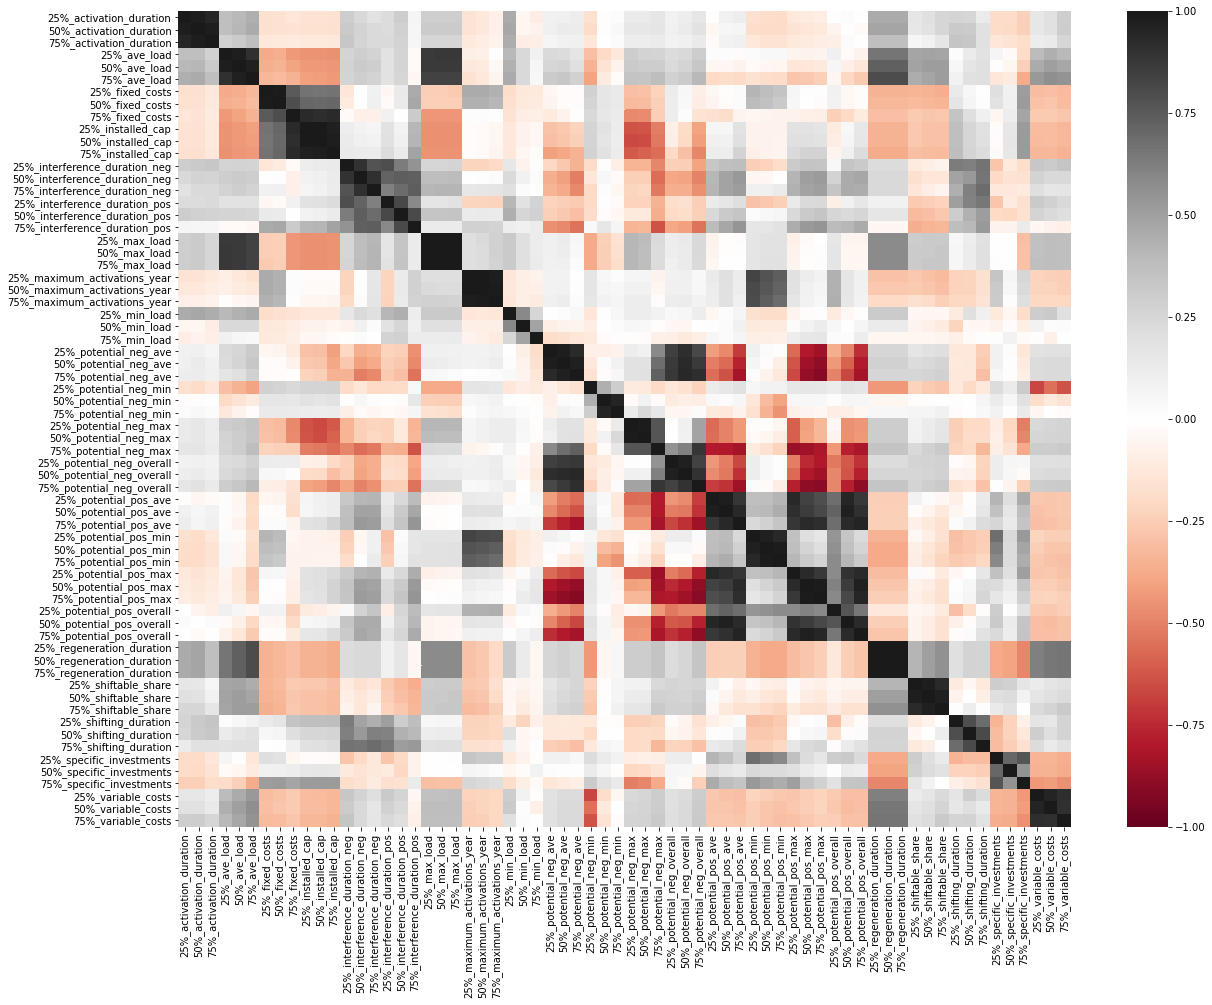

In [15]:
# Show heatmap for correlations
fig, ax = plt.subplots(figsize=(20, 15))
_ = sns.heatmap(corr_matrix, cmap="RdGy", vmin=-1.0, vmax=1.0)
plt.show()

## Create overall data set and interpolate missing values prior to clustering
Overview on approach used:
1. Create an **overall data set** and slice the parameters of interest.
2. Introduce **linear interpolation** for potential and cost parameters:
    * Potential parameters: The values for the status quo, 2030 and 2050 are used. Linear interpolation is made in between.
    * Cost parameters: The minimum cost value is assigned to 2050 since cost increases seem pretty unlikely. Linear interpolation is made between the status quo and 2050 (minimum cost value). Costs of zero are set to 0.01 in order to attribute cost to DR and prevent numeric effects disturbing DR utilization in the model.
3. **Assign remaining** parameters (mostly time-related ones) the same as for the status quo for every year.


> _Note: There is quite some room for **further improvements**._
> * _Development of positive and negative potentials should be in line with each other which doesn't have to be the case in the approach used._
> * _General trends in parameter development could be identified (increase / decrease / constant) by some other systematic like linear regression (some code snippets are kept, but not used for now here)._

### Create overall data set

In [16]:
# Introduce a DataFrame to store overall data for all years
potential_all_years = pd.DataFrame()
potential_all_years_nojoin = pd.DataFrame()

for year in years:
    potential_dict[year]["year_key"] = year
    potential_dict_nojoin[year]["year_key"] = year
    potential_all_years = pd.concat([potential_all_years, potential_dict[year]])
    potential_all_years_nojoin = pd.concat([potential_all_years_nojoin, potential_dict_nojoin[year]])

In [17]:
# Get all demand response categories
dr_cats = potential_all_years.index.unique().values

Only a **subset of the parameters** needs to be further analyzed:
* Time-dependent parameters are assumed constant. These comprise:
    * activation duration
    * interference duration (both pos and neg) and shifting duration
    * regeneration duration
* Other parameters are not really resp. not directly used in the modeling approaches for DR. These comprise:
    * average, minimum and maximum load
* This leads to the following remaining parameters focussing on costs and potentials. Since the correlation analysis showed high redundandencies for the potential parameters, only the following remaining parameters will be further analyzed:
    * potential positive overall
    * potential negative overall
    * installed capacity
    * fixed and variable costs
    * specific investments

In [18]:
dr_cats_nojoin = potential_all_years_nojoin.index.unique().values

### Linear interpolation for potential and costs data

In [19]:
# choose parameters for which some adaptions are needed
params_tbu_list = ["potential_neg_overall",
                   "potential_pos_overall",
                   "installed_cap",
                   "fixed_costs", "variable_costs", "specific_investments"]

params_tbu = create_parameter_combinations(params_tbu_list, cols)
params_tbu.append("year_key")

In [20]:
# Slice the parameter values needed
slice_pot = potential_all_years.loc[:,params_tbu]
slice_pot_nojoin = potential_all_years_nojoin.loc[:,params_tbu]
neg_pot_cols = create_parameter_combinations(["potential_neg_overall"], cols)
slice_pot[neg_pot_cols] = slice_pot[neg_pot_cols].mul(-1)
slice_pot_nojoin[neg_pot_cols] = slice_pot_nojoin[neg_pot_cols].mul(-1)

Perform **interpolation on potential and costs parameters** in order to
1. Fill data gaps and
2. remove inplausibilities such as potentials changing very strong and not consistent within the five year intervalls used.

In [21]:
# Define potential and cost cols
pot_cols = create_parameter_combinations(["potential_pos_overall", 
                                          "potential_neg_overall", 
                                          "installed_cap"], cols)
cost_cols = create_parameter_combinations(["specific_investments", 
                                           "fixed_costs", 
                                           "variable_costs"], cols)

# Instanciate new DataFrame to store manipulated outputs
slice_pot_new = pd.DataFrame(index=pd.MultiIndex.from_product([[],[],[]], 
                             names=["Prozess", "sector", "year_key"]))
slice_pot_new_nojoin = pd.DataFrame(index=pd.MultiIndex.from_product([[],[],[]], 
                                    names=["Prozess", "sector", "year_key"]))

# Create a list of DataFrames to concat
to_concat = [slice_pot_new]
to_concat_nojoin = [slice_pot_new_nojoin]

for el in dr_cats:
    df = slice_pot.loc[el].set_index("year_key", append=True)

    # Check potential values for interpolation
    try:
        pot_vals_SQ = df.loc[(el[0], el[1], "SQ"), pot_cols]
    except KeyError:
        continue
    try:
        pot_vals_2030 = df.loc[(el[0], el[1], "2030"), pot_cols]
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = df.loc[(el[0], el[1], "2050"), pot_cols]
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Assign potential values for 2030 and 2050 and interpolate in between
    multi_ix = pd.MultiIndex.from_product([[el[0]], [el[1]], years], 
                                          names=["Prozess", "sector", "year_key"])
    new_df = pd.DataFrame(index=multi_ix)
    new_df.loc[(el[0], el[1], "SQ"), pot_cols] = pot_vals_SQ
    new_df.loc[(el[0], el[1], "2030"), pot_cols] = pot_vals_2030
    new_df.loc[(el[0], el[1], "2050"), pot_cols] = pot_vals_2050

    # Check cost values for interpolation
    cost_vals_SQ = df.loc[(el[0], el[1], "SQ"), cost_cols]     
    min_costs = df[cost_cols].min()

    # Assign minimum value for 2050 and interpolate in between
    new_df.loc[(el[0], el[1], "SQ"), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(el[0], el[1], "2050"), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    new_df = new_df.interpolate()

    new_df = new_df.interpolate()
    to_concat.append(new_df)

slice_pot_new = pd.concat([el for el in to_concat], levels=([0, 1, 2]))    

# nojoin
for el in dr_cats_nojoin:
    df = slice_pot_nojoin.loc[el].set_index("year_key", append=True)

    # Check potential values for interpolation
    try:
        pot_vals_SQ = df.loc[(el[0], el[1], "SQ"), pot_cols]
    except KeyError:
        continue
    try:
        pot_vals_2030 = df.loc[(el[0], el[1], "2030"), pot_cols]
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = df.loc[(el[0], el[1], "2050"), pot_cols]
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Assign potential values for 2030 and 2050 and interpolate in between
    multi_ix = pd.MultiIndex.from_product([[el[0]], [el[1]], years], 
                                          names=["Prozess", "sector", "year_key"])
    new_df = pd.DataFrame(index=multi_ix)
    new_df.loc[(el[0], el[1], "SQ"), pot_cols] = pot_vals_SQ
    new_df.loc[(el[0], el[1], "2030"), pot_cols] = pot_vals_2030
    new_df.loc[(el[0], el[1], "2050"), pot_cols] = pot_vals_2050

    # Check cost values for interpolation
    cost_vals_SQ = df.loc[(el[0], el[1], "SQ"), cost_cols]     
    min_costs = df[cost_cols].min()

    # Assign minimum value for 2050 and interpolate in between
    new_df.loc[(el[0], el[1], "SQ"), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(el[0], el[1], "2050"), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    new_df = new_df.interpolate().round(2)
    
    new_df = new_df.interpolate()
    to_concat_nojoin.append(new_df)
    
slice_pot_new_nojoin = pd.concat([el for el in to_concat_nojoin], levels=([0, 1, 2]))  

<ipython-input-21-c2dff7bc8c4d>:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = slice_pot.loc[el].set_index("year_key", append=True)
<ipython-input-21-c2dff7bc8c4d>:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = slice_pot_nojoin.loc[el].set_index("year_key", append=True)


In [22]:
slice_pot_new[cost_cols].min()

25%_specific_investments    0.01
50%_specific_investments    0.01
75%_specific_investments    0.01
25%_fixed_costs             0.01
50%_fixed_costs             0.01
75%_fixed_costs             0.01
25%_variable_costs          0.01
50%_variable_costs          0.01
75%_variable_costs          0.01
dtype: float64

**Alternative trend analysis for DR parameters**:
> _NOTE: This section is work in progress and contains some open questions._<br>
> _It will be skipped for that reason (unless it is explicitly stated not to be skipped)._
* Potential parameters:
    * If $ r^2 \geq 0.8 $ &rarr; apply linear regression.
    * Use other approach yet to be defined...
* Cost parameters: Suitable approach yet to be defined...

In [23]:
# Alternative: use linear regression to analyze trends for dr categories
if not skip_dev:
    # "year_key" has to be an integer for that purpose
    slice_pot["year_key"] = slice_pot["year_key"].replace({"SQ": "2015"})
    slice_pot["year_key"] = slice_pot["year_key"].astype(int)
    
    for el in dr_cats:
        for pot_col in ["50%_potential_neg_overall", "50%_potential_pos_overall"]:
            slope, intercept, r_value, p_value, std_err = linregress(
                slice_pot.loc[el, "year_key"].values,
                slice_pot.loc[el, pot_col].values)
            if r_value ** 2 >= 0.8:
                slice_pot.loc[el, pot_col][slice_pot.loc[el, "year_key"] != 2015] \
                    = intercept + slope * slice_pot.loc[el, "year_key"]

        #plt.scatter(slice_pot.loc[el, "year_key"].values, 
        #            slice_pot.loc[el, pot_col].values)

### Assignment of remaining (time-related parameters)

In [24]:
# Assign remaining (mostly time-related) parameters
params_remaining_list = ["interference_duration_neg",
                         "interference_duration_pos", 
                         "maximum_activations_year", 
                         "regeneration_duration", 
                         "shifting_duration"]

params_remaining = create_parameter_combinations(params_remaining_list, cols)
params_remaining.append("year_key")

In [25]:
# Slice the parameter values needed
slice_pot = potential_all_years.loc[:,params_remaining]
slice_pot_nojoin = potential_all_years_nojoin.loc[:,params_remaining]
slice_pot.set_index("year_key", append=True, drop=False, inplace=True)
slice_pot_nojoin.set_index("year_key", append=True, drop=False, inplace=True)
params_remaining.remove("year_key")

In [26]:
slice_pot_new.loc[slice_pot_new.index.get_level_values(2) == "SQ", params_remaining] =\
    slice_pot.loc[slice_pot.index.get_level_values(2) == "SQ", params_remaining]
slice_pot_new.fillna(method="ffill", inplace=True)

slice_pot_new_nojoin.loc[slice_pot_new_nojoin.index.get_level_values(2) == "SQ", params_remaining] =\
    slice_pot_nojoin.loc[slice_pot_nojoin.index.get_level_values(2) == "SQ", params_remaining]
slice_pot_new_nojoin.fillna(method="ffill", inplace=True)

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


### Rearrange to dict-based data structure
> _NOTE: In general, this is not a necessity, but utilized here in order not to have to revert the entire ensuing clustering routine (which was initially build up upon the dict-based data structure)._

In [27]:
slice_pot_new = slice_pot_new.reset_index(level=2)
slice_pot_new_nojoin = slice_pot_new_nojoin.reset_index(level=2)

for year in years:
    potential_dict[year] = slice_pot_new[slice_pot_new["year_key"] == year].drop("year_key", axis=1)
    potential_dict_nojoin[year] = slice_pot_new_nojoin[slice_pot_new_nojoin["year_key"] == year].drop("year_key", axis=1)

In [28]:
potential_dict["SQ"].head()

25%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         277.0   
Chlor-Alkali-Elektrolyse                 ind                         477.0   
Holz- und Zellstoffherstellung           ind                         217.0   
Papiermaschinen                          ind                         180.5   
Elektrostahlherstellung (Lichtbogenofen) ind                         741.0   

                                                 50%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         404.5   
Chlor-Alkali-Elektrolyse                 ind                         575.0   
Holz- und Zellstoffherstellung           ind                         250.0   
Papiermaschinen                          ind                        1012.5   
Elektrostahlherstellung (Lichtbogenofen) ind                         931.0   

                                                 75%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        878.75   
Chlor-Alkali-Elektrolyse                 ind                        730.00   
Holz- und Zellstoffherstellung           ind                        311.00   
Papiermaschinen                          ind                       1636.25   
Elektrostahlherstellung (Lichtbogenofen) ind                       1098.00   

                                                 25%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         32.50   
Chlor-Alkali-Elektrolyse                 ind                         -0.00   
Holz- und Zellstoffherstellung           ind                         64.50   
Papiermaschinen                          ind                         87.50   
Elektrostahlherstellung (Lichtbogenofen) ind                        158.75   

                                                 50%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                          40.0   
Chlor-Alkali-Elektrolyse                 ind                         111.0   
Holz- und Zellstoffherstellung           ind                          84.0   
Papiermaschinen                          ind                         111.0   
Elektrostahlherstellung (Lichtbogenofen) ind                         327.0   

                                                 75%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         50.00   
Chlor-Alkali-Elektrolyse                 ind                        334.25   
Holz- und Zellstoffherstellung           ind                        164.25   
Papiermaschinen                          ind                        123.25   
Elektrostahlherstellung (Lichtbogenofen) ind                        610.00   

                                                 25%_installed_cap  \
Prozess                                  sector                      
Primäraluminiumelektrolyse               ind                 916.0   
Chlor-Alkali-Elektrolyse                 ind                 910.0   
Holz- und Zellstoffherstellung           ind                 292.0   
Papiermaschinen                          ind                1412.0   
Elektrostahlherstellung (Lichtbogenofen) ind                1107.0   

                                                 50%_installed_cap  \
Prozess                                  sector                      
Primäraluminiumelektrolyse               ind                 938.0   
Chlor-Alkali-Elektrolyse                 ind                1370.0

In [29]:
potential_dict_nojoin["2050"].tail()

25%_potential_pos_overall  \
Prozess                         sector                              
Kühlung (Lebensmittelindustrie) ind                        150.65   
Warmwasserbereitstellung        tcs                         53.40   
Prozesskälte Handel             tcs                          0.00   
Prozesswärme                    tcs                        544.50   
Luftzerlegung                   ind                        150.65   

                                        50%_potential_pos_overall  \
Prozess                         sector                              
Kühlung (Lebensmittelindustrie) ind                         200.0   
Warmwasserbereitstellung        tcs                          94.0   
Prozesskälte Handel             tcs                           0.0   
Prozesswärme                    tcs                         982.0   
Luftzerlegung                   ind                         200.0   

                                        75%_potential_pos_overall  \
Prozess                         sector                              
Kühlung (Lebensmittelindustrie) ind                        314.22   
Warmwasserbereitstellung        tcs                        306.46   
Prozesskälte Handel             tcs                          0.00   
Prozesswärme                    tcs                       1004.50   
Luftzerlegung                   ind                        314.22   

                                        25%_potential_neg_overall  \
Prozess                         sector                              
Kühlung (Lebensmittelindustrie) ind                         52.18   
Warmwasserbereitstellung        tcs                         64.78   
Prozesskälte Handel             tcs                        234.50   
Prozesswärme                    tcs                       1333.00   
Luftzerlegung                   ind                         52.18   

                                        50%_potential_neg_overall  \
Prozess                         sector                              
Kühlung (Lebensmittelindustrie) ind                         67.34   
Warmwasserbereitstellung        tcs                        127.43   
Prozesskälte Handel             tcs                        389.00   
Prozesswärme                    tcs                       1963.00   
Luftzerlegung                   ind                         67.34   

                                        75%_potential_neg_overall  \
Prozess                         sector                              
Kühlung (Lebensmittelindustrie) ind                        115.74   
Warmwasserbereitstellung        tcs                        232.26   
Prozesskälte Handel             tcs                        537.00   
Prozesswärme                    tcs                       2009.00   
Luftzerlegung                   ind                        115.74   

                                        25%_installed_cap  50%_installed_cap  \
Prozess                         sector                                         
Kühlung (Lebensmittelindustrie) ind                480.34             528.28   
Warmwasserbereitstellung        tcs               1150.59            1366.49   
Prozesskälte Handel             tcs                  0.00               0.00   
Prozesswärme                    tcs                  0.00               0.00   
Luftzerlegung                   ind                480.34             528.28   

                                        75%_installed_cap  \
Prozess                         sector                      
Kühlung (Lebensmittelindustrie) ind                576.22   
Warmwasserbereitstellung        tcs               1582.39   
Prozesskälte Handel             tcs                  0.00   
Prozesswärme                    tcs                  0.00   
Luftzerlegung                   ind                576.22   

                                        25%_specific_investments  ...  \
Prozess                         sector                            ...   
K

In [30]:
potential_dict["SQ"]

25%_potential_pos_overall  \
Prozess                                    sector                                
Primäraluminiumelektrolyse                 ind                          277.00   
Chlor-Alkali-Elektrolyse                   ind                          477.00   
Holz- und Zellstoffherstellung             ind                          217.00   
Papiermaschinen                            ind                          180.50   
Elektrostahlherstellung (Lichtbogenofen)   ind                          741.00   
Zementherstellung                          ind                          209.25   
Kupfer- und Zinkherstellung (Elektrolyse)  ind                            0.00   
Altpapierrecycling (Pulper)                ind                          395.50   
Gießereien (Induktionsofen)                ind                           72.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                           32.25   
Wärmepumpen                                tcs+hoho                     447.77   
Nachtspeicherheizungen                     tcs+hoho                     912.25   
Belüftung                                  ind                            5.54   
Prozesskälte                               ind                          220.80   
Klimakälte                                 ind                            0.00   
Prozesskälte                               tcs                          160.00   
Belüftung                                  tcs                           46.71   
Pumpenanwendungen in der Wasserversorgung  tcs                          173.92   
Beleuchtung                                tcs                            0.00   
Zerkleinerer                               tcs                           15.93   
Kühlschränke                               hoho                         924.81   
Geschirrspüler                             hoho                           0.00   
Wäschetrockner                             hoho                           0.00   
Waschmaschinen                             hoho                           0.00   
Warmwasserbereitstellung                   tcs+hoho                     683.75   
Gefrierschränke und -truhen                hoho                         548.13   
Heizungsumwälzpumpen                       hoho                         615.60   
Klimakälte                                 tcs+hoho                     152.03   
Abwasserbehandlung                         tcs                            0.00   
Kühlhäuser                                 tcs                            0.00   
Beleuchtung                                ind                          209.25   
Druckluftanwendungen                       ind                          167.78   
Pumpenanwendungen                          ind                          209.25   
Kühl- und Gefrierkombinationen             hoho                         500.00   
Kühlung (Lebensmittelindustrie)            ind                          273.75   
Prozesskälte Handel                        tcs                            0.00   
Prozesswärme                               tcs                          544.50   
Luftzerlegung                              ind                          209.25   

                                                     50%_potential_pos_overall  \
Prozess                                    sector                                
Primäraluminiumelektrolyse                 ind                          404.50   
Chlor-Alkali-Elektrolyse                   ind                          575.00   
Holz- und Zellstoffherstellung             ind                          250.00   
Papiermaschinen                            ind                         1012.50   
Elektrostahlherstellung (Lichtbogenofen)   ind                          931.00   
Zementherstellung                          ind                          313.00   
Kupfer- und Zinkherstellung (Elektrolyse)  ind                            5.00   
Altpapierrecycling (Pulper)       

# Cluster data
* Do a clustering using K-Means and the cluster parameters defined in the above parameter settings (alternative: agglomerative clustering using ward linkage).
* Default: Cluster within sectors by shifting times, positive interference duration, variable costs as well as specific investments

## Do the actual clustering
* Create a list of the cluster parameters
* Determine the number of clusters per sector
* Perform a K-Means clustering on the data (alternative: agglomerative clustering using ward linkage)

In [31]:
cluster_parameters_list = create_parameter_combinations(cluster_parameters, ["50%"])
cluster_parameters_list

['50%_shifting_duration',
 '50%_interference_duration_pos',
 '50%_variable_costs',
 '50%_fixed_costs',
 '50%_specific_investments']

In [32]:
# Initialize the column to store the cluster label
potential_dict["SQ"]["cluster"] = 0

print(f"Number of clusters for {cluster_algo} clustering")

# Increase cluster numbers by (arbitratily chosen) increments
# in order not to overwrite cluster information
iter = 0
increments = [1000, 100, 10, 1]

# Iterate over the sectors and create clusters within the sectors
for sector in potential_dict["SQ"].index.get_level_values(1).unique():
    # Determine the number of clusters per sector and print it
    n = math.ceil(potential_dict["SQ"][potential_dict["SQ"].index.get_level_values(1) == sector].shape[0]*share_clusters)
    print(sector+":\t\t"+str(n))
    
    if cluster_algo == "KMeans":
        # Do the actual clustering and assign the cluster labels
        #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])
        potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = \
            KMeans(n_clusters=n).fit(
                potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, 
                                         cluster_parameters_list].values).labels_ + 1
        
    elif cluster_algo == "ward":
        # Do the actual clustering and assign the cluster labels
        potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = \
            AgglomerativeClustering(n_clusters=n, linkage="ward").fit(
                potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, cluster_parameters_list].values).labels_ + 1       

    # Increment the cluster labels to avoid overwriting in the next iteration (K-Means always starts with zero)
    potential_dict["SQ"].loc[potential_dict["SQ"]["cluster"] != 0, "cluster"] += n * increments[iter]
    iter += 1
    #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])

Number of clusters for KMeans clustering
ind:		2
tcs+hoho:		1
tcs:		1
hoho:		1


In [33]:
# Print the number of unique cluster labels (cross check)
potential_dict["SQ"]["cluster"].nunique()

5

**Cluster assignment**:
* Assign cluster information for future years (_Note: simple assignment does an index mapping_).
* Furthermore, assing cluster information to data set in which tcs and hoho applications haven't been joined.

In [34]:
for year in years:
    if not year == "SQ":
        potential_dict[year]["cluster"] = potential_dict["SQ"]["cluster"]
        
    # Add cluster information for data not joined
    potential_dict_nojoin[year]["cluster"] = potential_dict[year]["cluster"]

    # Add cluster information for categories for which it is missing, i.e. categories in tcs+hoho sector
    # Determine indices to use for selecting cluster numbers
    no_cluster_ixs = list(set(potential_dict_nojoin[year][
        potential_dict_nojoin[year]["cluster"].isna()].index.get_level_values(0)))
    no_cluster_ixs = [(i, j) for i in no_cluster_ixs for j in ["tcs+hoho"]]

    # Use only the first index level to be able to assign values (second index levels won't match)
    clusters_to_use = potential_dict[year].loc[no_cluster_ixs, "cluster"].to_frame()
    clusters_to_use = clusters_to_use.set_index(clusters_to_use.index.get_level_values(0))

    # Use an excerpt of the overall DataFrame to assign the cluster info
    excerpt = potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"cluster"].to_frame()
    excerpt = excerpt.reset_index().set_index("Prozess")
    excerpt["cluster"] = clusters_to_use["cluster"]
    excerpt = excerpt.set_index("sector", append=True)
    potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"help_sector"] = "tcs+hoho"
    potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"cluster"] = excerpt.loc[:,"cluster"]

In [35]:
potential_dict["2050"].head()

25%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        150.65   
Chlor-Alkali-Elektrolyse                 ind                        323.60   
Holz- und Zellstoffherstellung           ind                        123.02   
Papiermaschinen                          ind                       1028.95   
Elektrostahlherstellung (Lichtbogenofen) ind                        447.50   

                                                 50%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        200.00   
Chlor-Alkali-Elektrolyse                 ind                        393.00   
Holz- und Zellstoffherstellung           ind                        196.59   
Papiermaschinen                          ind                       1589.62   
Elektrostahlherstellung (Lichtbogenofen) ind                       1038.00   

                                                 75%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        606.55   
Chlor-Alkali-Elektrolyse                 ind                        572.93   
Holz- und Zellstoffherstellung           ind                        223.48   
Papiermaschinen                          ind                       2064.16   
Elektrostahlherstellung (Lichtbogenofen) ind                       1134.00   

                                                 25%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         24.50   
Chlor-Alkali-Elektrolyse                 ind                         85.45   
Holz- und Zellstoffherstellung           ind                         52.18   
Papiermaschinen                          ind                        153.02   
Elektrostahlherstellung (Lichtbogenofen) ind                         63.50   

                                                 50%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         28.00   
Chlor-Alkali-Elektrolyse                 ind                        118.55   
Holz- und Zellstoffherstellung           ind                         67.34   
Papiermaschinen                          ind                        190.20   
Elektrostahlherstellung (Lichtbogenofen) ind                        127.00   

                                                 75%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         31.50   
Chlor-Alkali-Elektrolyse                 ind                        151.65   
Holz- und Zellstoffherstellung           ind                        115.74   
Papiermaschinen                          ind                        231.97   
Elektrostahlherstellung (Lichtbogenofen) ind                        190.50   

                                                 25%_installed_cap  \
Prozess                                  sector                      
Primäraluminiumelektrolyse               ind                648.90   
Chlor-Alkali-Elektrolyse                 ind               1203.12   
Holz- und Zellstoffherstellung           ind                242.52   
Papiermaschinen                          ind               1884.00   
Elektrostahlherstellung (Lichtbogenofen) ind               2120.00   

                                                 50%_installed_cap  \
Prozess                                  sector                      
Primäraluminiumelektrolyse               ind                656.60   
Chlor-Alkali-Elektrolyse                 ind               1303.41

In [36]:
potential_dict["SQ"].head()

25%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         277.0   
Chlor-Alkali-Elektrolyse                 ind                         477.0   
Holz- und Zellstoffherstellung           ind                         217.0   
Papiermaschinen                          ind                         180.5   
Elektrostahlherstellung (Lichtbogenofen) ind                         741.0   

                                                 50%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         404.5   
Chlor-Alkali-Elektrolyse                 ind                         575.0   
Holz- und Zellstoffherstellung           ind                         250.0   
Papiermaschinen                          ind                        1012.5   
Elektrostahlherstellung (Lichtbogenofen) ind                         931.0   

                                                 75%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        878.75   
Chlor-Alkali-Elektrolyse                 ind                        730.00   
Holz- und Zellstoffherstellung           ind                        311.00   
Papiermaschinen                          ind                       1636.25   
Elektrostahlherstellung (Lichtbogenofen) ind                       1098.00   

                                                 25%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         32.50   
Chlor-Alkali-Elektrolyse                 ind                         -0.00   
Holz- und Zellstoffherstellung           ind                         64.50   
Papiermaschinen                          ind                         87.50   
Elektrostahlherstellung (Lichtbogenofen) ind                        158.75   

                                                 50%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                          40.0   
Chlor-Alkali-Elektrolyse                 ind                         111.0   
Holz- und Zellstoffherstellung           ind                          84.0   
Papiermaschinen                          ind                         111.0   
Elektrostahlherstellung (Lichtbogenofen) ind                         327.0   

                                                 75%_potential_neg_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                         50.00   
Chlor-Alkali-Elektrolyse                 ind                        334.25   
Holz- und Zellstoffherstellung           ind                        164.25   
Papiermaschinen                          ind                        123.25   
Elektrostahlherstellung (Lichtbogenofen) ind                        610.00   

                                                 25%_installed_cap  \
Prozess                                  sector                      
Primäraluminiumelektrolyse               ind                 916.0   
Chlor-Alkali-Elektrolyse                 ind                 910.0   
Holz- und Zellstoffherstellung           ind                 292.0   
Papiermaschinen                          ind                1412.0   
Elektrostahlherstellung (Lichtbogenofen) ind                1107.0   

                                                 50%_installed_cap  \
Prozess                                  sector                      
Primäraluminiumelektrolyse               ind                 938.0   
Chlor-Alkali-Elektrolyse                 ind                1370.0

## Show and explore the clusters
Print the clusters in order to visually inspect them

In [37]:
if print_clusters:
    for el in np.sort(potential_dict["SQ"]["cluster"].unique()):
        print(20 * "-")
        print("cluster number: "+str(el))
        print(20 * "-")
        display(potential_dict["SQ"][potential_dict["SQ"]["cluster"] == el])

--------------------
cluster number: 2
--------------------


25%_potential_pos_overall  \
Prozess                        sector                              
Kühlschränke                   hoho                       924.81   
Geschirrspüler                 hoho                         0.00   
Wäschetrockner                 hoho                         0.00   
Waschmaschinen                 hoho                         0.00   
Gefrierschränke und -truhen    hoho                       548.13   
Heizungsumwälzpumpen           hoho                       615.60   
Kühl- und Gefrierkombinationen hoho                       500.00   

                                       50%_potential_pos_overall  \
Prozess                        sector                              
Kühlschränke                   hoho                      1317.16   
Geschirrspüler                 hoho                         0.00   
Wäschetrockner                 hoho                         0.00   
Waschmaschinen                 hoho                        16.54   
Gefrierschränke und -truhen    hoho                       780.49   
Heizungsumwälzpumpen           hoho                      1894.69   
Kühl- und Gefrierkombinationen hoho                       980.00   

                                       75%_potential_pos_overall  \
Prozess                        sector                              
Kühlschränke                   hoho                      1809.22   
Geschirrspüler                 hoho                       470.57   
Wäschetrockner                 hoho                       143.65   
Waschmaschinen                 hoho                       265.14   
Gefrierschränke und -truhen    hoho                      1071.85   
Heizungsumwälzpumpen           hoho                      2716.18   
Kühl- und Gefrierkombinationen hoho                       980.00   

                                       25%_potential_neg_overall  \
Prozess                        sector                              
Kühlschränke                   hoho                         -0.0   
Geschirrspüler                 hoho                         -0.0   
Wäschetrockner                 hoho                         -0.0   
Waschmaschinen                 hoho                         -0.0   
Gefrierschränke und -truhen    hoho                         -0.0   
Heizungsumwälzpumpen           hoho                         -0.0   
Kühl- und Gefrierkombinationen hoho                        500.0   

                                       50%_potential_neg_overall  \
Prozess                        sector                              
Kühlschränke                   hoho                        -0.00   
Geschirrspüler                 hoho                       484.82   
Wäschetrockner                 hoho                       359.32   
Waschmaschinen                 hoho                       380.36   
Gefrierschränke und -truhen    hoho                        -0.00   
Heizungsumwälzpumpen           hoho                        -0.00   
Kühl- und Gefrierkombinationen hoho                       980.00   

                                       75%_potential_neg_overall  \
Prozess                        sector                              
Kühlschränke                   hoho                       500.00   
Geschirrspüler                 hoho                      1986.87   
Wäschetrockner                 hoho                      1436.52   
Waschmaschinen                 hoho                      2121.15   
Gefrierschränke und -truhen    hoho                       360.00   
Heizungsumwälzpumpen           hoho                       642.60   
Kühl- und Gefrierkombinationen hoho                       980.00   

                                       25%_installed_cap  50%_installed_cap  \
Prozess                        sector                                         
Kühlschränke                   hoho              3872.00             4103.0   
Geschirrspüler                 hoho             52151.00            52232.0   
Wäschetrockner                 hoho          

--------------------
cluster number: 12
--------------------


25%_potential_pos_overall  \
Prozess                                   sector                              
Prozesskälte                              tcs                        160.00   
Belüftung                                 tcs                         46.71   
Pumpenanwendungen in der Wasserversorgung tcs                        173.92   
Beleuchtung                               tcs                          0.00   
Zerkleinerer                              tcs                         15.93   
Abwasserbehandlung                        tcs                          0.00   
Kühlhäuser                                tcs                          0.00   
Prozesskälte Handel                       tcs                          0.00   
Prozesswärme                              tcs                        544.50   

                                                  50%_potential_pos_overall  \
Prozess                                   sector                              
Prozesskälte                              tcs                        206.73   
Belüftung                                 tcs                         80.22   
Pumpenanwendungen in der Wasserversorgung tcs                        290.00   
Beleuchtung                               tcs                          2.41   
Zerkleinerer                              tcs                         21.60   
Abwasserbehandlung                        tcs                          0.00   
Kühlhäuser                                tcs                         81.00   
Prozesskälte Handel                       tcs                          0.00   
Prozesswärme                              tcs                        982.00   

                                                  75%_potential_pos_overall  \
Prozess                                   sector                              
Prozesskälte                              tcs                        273.26   
Belüftung                                 tcs                        164.11   
Pumpenanwendungen in der Wasserversorgung tcs                        425.42   
Beleuchtung                               tcs                          9.09   
Zerkleinerer                              tcs                         32.30   
Abwasserbehandlung                        tcs                          0.00   
Kühlhäuser                                tcs                        230.00   
Prozesskälte Handel                       tcs                          0.00   
Prozesswärme                              tcs                       1004.50   

                                                  25%_potential_neg_overall  \
Prozess                                   sector                              
Prozesskälte                              tcs                         51.32   
Belüftung                                 tcs                         18.45   
Pumpenanwendungen in der Wasserversorgung tcs                        135.28   
Beleuchtung                               tcs                         -0.00   
Zerkleinerer                              tcs                          8.37   
Abwasserbehandlung                        tcs                         -0.00   
Kühlhäuser                                tcs                         24.75   
Prozesskälte Handel                       tcs                        234.50   
Prozesswärme                              tcs                       1333.00   

                                                  50%_potential_neg_overall  \
Prozess                                   sector                              
Prozesskälte                              tcs                         81.43   
Belüftung                                 tcs                         54.17   
Pumpenanwendungen in der Wasserversorgung tcs                        290.00   
Beleuchtung                               tcs                          4.44   
Zerkleinerer                              tcs                         13.68   
Abwasserbehandlun

--------------------
cluster number: 112
--------------------


25%_potential_pos_overall  \
Prozess                  sector                                
Wärmepumpen              tcs+hoho                     447.77   
Nachtspeicherheizungen   tcs+hoho                     912.25   
Warmwasserbereitstellung tcs+hoho                     683.75   
Klimakälte               tcs+hoho                     152.03   

                                   50%_potential_pos_overall  \
Prozess                  sector                                
Wärmepumpen              tcs+hoho                     691.00   
Nachtspeicherheizungen   tcs+hoho                    2815.00   
Warmwasserbereitstellung tcs+hoho                    3580.00   
Klimakälte               tcs+hoho                    1505.92   

                                   75%_potential_pos_overall  \
Prozess                  sector                                
Wärmepumpen              tcs+hoho                     989.66   
Nachtspeicherheizungen   tcs+hoho                    7439.54   
Warmwasserbereitstellung tcs+hoho                    5336.48   
Klimakälte               tcs+hoho                    4266.14   

                                   25%_potential_neg_overall  \
Prozess                  sector                                
Wärmepumpen              tcs+hoho                     120.00   
Nachtspeicherheizungen   tcs+hoho                    3182.25   
Warmwasserbereitstellung tcs+hoho                     776.50   
Klimakälte               tcs+hoho                      61.35   

                                   50%_potential_neg_overall  \
Prozess                  sector                                
Wärmepumpen              tcs+hoho                     403.04   
Nachtspeicherheizungen   tcs+hoho                    6542.50   
Warmwasserbereitstellung tcs+hoho                    1494.00   
Klimakälte               tcs+hoho                     863.15   

                                   75%_potential_neg_overall  \
Prozess                  sector                                
Wärmepumpen              tcs+hoho                    1067.23   
Nachtspeicherheizungen   tcs+hoho                    9407.75   
Warmwasserbereitstellung tcs+hoho                    6404.56   
Klimakälte               tcs+hoho                    2514.30   

                                   25%_installed_cap  50%_installed_cap  \
Prozess                  sector                                           
Wärmepumpen              tcs+hoho            1660.00             2269.5   
Nachtspeicherheizungen   tcs+hoho           17275.00            17950.0   
Warmwasserbereitstellung tcs+hoho           18605.75            21445.5   
Klimakälte               tcs+hoho            8894.00             9373.0   

                                   75%_installed_cap  \
Prozess                  sector                        
Wärmepumpen              tcs+hoho            2879.75   
Nachtspeicherheizungen   tcs+hoho           34500.00   
Warmwasserbereitstellung tcs+hoho           21902.25   
Klimakälte               tcs+hoho            9595.00   

                                   25%_specific_investments  ...  \
Prozess                  sector                              ...   
Wärmepumpen              tcs+hoho                      8.91  ...   
Nachtspeicherheizungen   tcs+hoho                     35.36  ...   
Warmwasserbereitstellung tcs+hoho                    475.00  ...   
Klimakälte               tcs+hoho                    422.13  ...   

                                   25%_maximum_activations_year  \
Prozess                  sector                                   
Wärmepumpen              tcs+hoho                        591.00   
Nachtspeicherheizungen   tcs+hoho                        144.00   
Warmwasserbereitstellung tcs+hoho                        355.75   
Klimakälte               tcs+hoho                        319.25   

                                   50%_maximum_activations_year  \
Prozess                  sector                           

--------------------
cluster number: 2112
--------------------


25%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        277.00   
Chlor-Alkali-Elektrolyse                 ind                        477.00   
Holz- und Zellstoffherstellung           ind                        217.00   
Papiermaschinen                          ind                        180.50   
Elektrostahlherstellung (Lichtbogenofen) ind                        741.00   
Zementherstellung                        ind                        209.25   
Altpapierrecycling (Pulper)              ind                        395.50   
Belüftung                                ind                          5.54   
Prozesskälte                             ind                        220.80   
Klimakälte                               ind                          0.00   
Beleuchtung                              ind                        209.25   
Druckluftanwendungen                     ind                        167.78   
Pumpenanwendungen                        ind                        209.25   
Kühlung (Lebensmittelindustrie)          ind                        273.75   
Luftzerlegung                            ind                        209.25   

                                                 50%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        404.50   
Chlor-Alkali-Elektrolyse                 ind                        575.00   
Holz- und Zellstoffherstellung           ind                        250.00   
Papiermaschinen                          ind                       1012.50   
Elektrostahlherstellung (Lichtbogenofen) ind                        931.00   
Zementherstellung                        ind                        313.00   
Altpapierrecycling (Pulper)              ind                        449.00   
Belüftung                                ind                         11.97   
Prozesskälte                             ind                        281.00   
Klimakälte                               ind                          0.00   
Beleuchtung                              ind                        313.00   
Druckluftanwendungen                     ind                        910.85   
Pumpenanwendungen                        ind                        313.00   
Kühlung (Lebensmittelindustrie)          ind                        362.50   
Luftzerlegung                            ind                        313.00   

                                                 75%_potential_pos_overall  \
Prozess                                  sector                              
Primäraluminiumelektrolyse               ind                        878.75   
Chlor-Alkali-Elektrolyse                 ind                        730.00   
Holz- und Zellstoffherstellung           ind                        311.00   
Papiermaschinen                          ind                       1636.25   
Elektrostahlherstellung (Lichtbogenofen) ind                       1098.00   
Zementherstellung                        ind                        332.75   
Altpapierrecycling (Pulper)              ind                        519.00   
Belüftung                                ind                         35.16   
Prozesskälte                             ind                        359.68   
Klimakälte                               ind                          0.00   
Beleuchtung                              ind                        359.68   
Druckluftanwendungen                     ind                       1698.50   
Pumpenanwendungen                        ind                        359.68   
Kühlung (Lebensmittelindustrie)          ind                        480.00   
Luftzerlegung                            ind                        359.68   

                                                 25%_potential_neg_o

--------------------
cluster number: 2113
--------------------


25%_potential_pos_overall  \
Prozess                                    sector                              
Kupfer- und Zinkherstellung (Elektrolyse)  ind                          0.00   
Gießereien (Induktionsofen)                ind                         72.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                         32.25   

                                                   50%_potential_pos_overall  \
Prozess                                    sector                              
Kupfer- und Zinkherstellung (Elektrolyse)  ind                           5.0   
Gießereien (Induktionsofen)                ind                         115.0   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                          51.0   

                                                   75%_potential_pos_overall  \
Prozess                                    sector                              
Kupfer- und Zinkherstellung (Elektrolyse)  ind                         90.75   
Gießereien (Induktionsofen)                ind                        158.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                         69.00   

                                                   25%_potential_neg_overall  \
Prozess                                    sector                              
Kupfer- und Zinkherstellung (Elektrolyse)  ind                         -0.00   
Gießereien (Induktionsofen)                ind                         14.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                          9.75   

                                                   50%_potential_neg_overall  \
Prozess                                    sector                              
Kupfer- und Zinkherstellung (Elektrolyse)  ind                          -0.0   
Gießereien (Induktionsofen)                ind                          25.0   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                          13.0   

                                                   75%_potential_neg_overall  \
Prozess                                    sector                              
Kupfer- und Zinkherstellung (Elektrolyse)  ind                          7.00   
Gießereien (Induktionsofen)                ind                         36.00   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                         15.75   

                                                   25%_installed_cap  \
Prozess                                    sector                      
Kupfer- und Zinkherstellung (Elektrolyse)  ind                   0.0   
Gießereien (Induktionsofen)                ind                  96.5   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                  67.0   

                                                   50%_installed_cap  \
Prozess                                    sector                      
Kupfer- und Zinkherstellung (Elektrolyse)  ind                 177.0   
Gießereien (Induktionsofen)                ind                 148.0   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                  78.0   

                                                   75%_installed_cap  \
Prozess                                    sector                      
Kupfer- und Zinkherstellung (Elektrolyse)  ind                 182.0   
Gießereien (Induktionsofen)                ind                 199.5   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                  89.0   

                                                   25%_specific_investments  \
Prozess                                    sector                             
Kupfer- und Zinkherstellung (Elektrolyse)  ind                         0.01   
Gießereien (Induktionsofen)                ind                        10.69   
Calciumcarbid-Herstellung (Lichtbogenofen) ind                         9.41   

                                                   ...  \
Prozess                                    sector  ...   
Kupfer- und Zinkherstellung (Elektrolyse)  ind    

## Create transposed potential data sets for combining it with availability data

In [38]:
# Initialize dicts to store the transposed (and not joined) potential data
# as well as the availability time series
potential_T_dict = {}
potential_ind_T_dict = {}
potential_tcs_T_dict = {}
potential_hoho_T_dict = {}
potential_tcs_hoho_T_dict = {}

for year in years:
    # Create transposed subsets of potential_dict_nojoin
    potential_T_dict[year] = potential_dict_nojoin[year].T
    potential_ind_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "ind"].T
    potential_tcs_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "tcs"].T
    potential_hoho_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "hoho"].T
    potential_tcs_hoho_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "tcs+hoho"].T

In [39]:
potential_T_dict["SQ"].head()

Prozess                   Primäraluminiumelektrolyse Chlor-Alkali-Elektrolyse  \
sector                                           ind                      ind   
25%_potential_pos_overall                        277                      477   
50%_potential_pos_overall                      404.5                      575   
75%_potential_pos_overall                     878.75                      730   
25%_potential_neg_overall                       32.5                       -0   
50%_potential_neg_overall                         40                      111   

Prozess                   Holz- und Zellstoffherstellung Papiermaschinen  \
sector                                               ind             ind   
25%_potential_pos_overall                            217           180.5   
50%_potential_pos_overall                            250          1012.5   
75%_potential_pos_overall                            311         1636.25   
25%_potential_neg_overall                           64.5            87.5   
50%_potential_neg_overall                             84             111   

Prozess                   Elektrostahlherstellung (Lichtbogenofen)  \
sector                                                         ind   
25%_potential_pos_overall                                      741   
50%_potential_pos_overall                                      931   
75%_potential_pos_overall                                     1098   
25%_potential_neg_overall                                   158.75   
50%_potential_neg_overall                                      327   

Prozess                   Zementherstellung  \
sector                                  ind   
25%_potential_pos_overall            209.25   
50%_potential_pos_overall               313   
75%_potential_pos_overall            332.75   
25%_potential_neg_overall               105   
50%_potential_neg_overall               174   

Prozess                   Kupfer- und Zinkherstellung (Elektrolyse)  \
sector                                                          ind   
25%_potential_pos_overall                                         0   
50%_potential_pos_overall                                         5   
75%_potential_pos_overall                                     90.75   
25%_potential_neg_overall                                        -0   
50%_potential_neg_overall                                        -0   

Prozess                   Altpapierrecycling (Pulper)  \
sector                                            ind   
25%_potential_pos_overall                       395.5   
50%_potential_pos_overall                         449   
75%_potential_pos_overall                         519   
25%_potential_neg_overall                        83.5   
50%_potential_neg_overall                         123   

Prozess                   Gießereien (Induktionsofen)  \
sector                                            ind   
25%_potential_pos_overall                          72   
50%_potential_pos_overall                         115   
75%_potential_pos_overall                         158   
25%_potential_neg_overall                          14   
50%_potential_neg_overall                          25   

Prozess                   Calciumcarbid-Herstellung (Lichtbogenofen)  ...  \
sector                                                           ind  ...   
25%_potential_pos_overall                                      32.25  ...   
50%_potential_pos_overall                                         51  ...   
75%_potential_pos_overall                                         69  ...   
25%_potential_neg_overall                                       9.75  ...   
50%_potential_neg_overall                                         13  ...   

Prozess                   Beleuchtung Druckluftanwendungen Pumpenanwendungen  \
sector                            ind                  ind               ind   
25%_potential_pos_overall      209.25               167.78            209.25   


In [40]:
potential_T_dict["2050"].head()

Prozess                   Primäraluminiumelektrolyse Chlor-Alkali-Elektrolyse  \
sector                                           ind                      ind   
25%_potential_pos_overall                     150.65                    323.6   
50%_potential_pos_overall                        200                      393   
75%_potential_pos_overall                     606.55                   572.93   
25%_potential_neg_overall                       24.5                    85.45   
50%_potential_neg_overall                         28                   118.55   

Prozess                   Holz- und Zellstoffherstellung Papiermaschinen  \
sector                                               ind             ind   
25%_potential_pos_overall                         123.02         1028.95   
50%_potential_pos_overall                         196.59         1589.62   
75%_potential_pos_overall                         223.48         2064.16   
25%_potential_neg_overall                          52.18          153.02   
50%_potential_neg_overall                          67.34           190.2   

Prozess                   Elektrostahlherstellung (Lichtbogenofen)  \
sector                                                         ind   
25%_potential_pos_overall                                    447.5   
50%_potential_pos_overall                                     1038   
75%_potential_pos_overall                                     1134   
25%_potential_neg_overall                                     63.5   
50%_potential_neg_overall                                      127   

Prozess                   Zementherstellung  \
sector                                  ind   
25%_potential_pos_overall            193.39   
50%_potential_pos_overall            216.72   
75%_potential_pos_overall            314.22   
25%_potential_neg_overall             68.54   
50%_potential_neg_overall             85.68   

Prozess                   Kupfer- und Zinkherstellung (Elektrolyse)  \
sector                                                          ind   
25%_potential_pos_overall                                         0   
50%_potential_pos_overall                                        15   
75%_potential_pos_overall                                    145.23   
25%_potential_neg_overall                                        -0   
50%_potential_neg_overall                                      3.29   

Prozess                   Altpapierrecycling (Pulper)  \
sector                                            ind   
25%_potential_pos_overall                       755.3   
50%_potential_pos_overall                      898.17   
75%_potential_pos_overall                     1004.13   
25%_potential_neg_overall                       82.01   
50%_potential_neg_overall                      134.59   

Prozess                   Gießereien (Induktionsofen)  \
sector                                            ind   
25%_potential_pos_overall                          72   
50%_potential_pos_overall                         115   
75%_potential_pos_overall                         158   
25%_potential_neg_overall                          14   
50%_potential_neg_overall                          25   

Prozess                   Calciumcarbid-Herstellung (Lichtbogenofen)  ...  \
sector                                                           ind  ...   
25%_potential_pos_overall                                      20.47  ...   
50%_potential_pos_overall                                      32.64  ...   
75%_potential_pos_overall                                      44.16  ...   
25%_potential_neg_overall                                       6.24  ...   
50%_potential_neg_overall                                       7.84  ...   

Prozess                   Beleuchtung Druckluftanwendungen Pumpenanwendungen  \
sector                            ind                  ind               ind   
25%_potential_pos_overall      209.25               167.78            209.25   


## Read in and match availability data

* Read in the availability time series data.
* Match the data to the respective demand response categories.
        
> __*Conceptual question:*__ 
> _Rethink, whether availability timeseries indexed by year do make sense and how this should be handled within (investment) model runs._
> * _Pros: Different years (e.g. temperature or weekday patterns) could be depicted._
> * _Cons: Some effort has to be made to achieve that_

In [41]:
# Read in availability time series data
availability_ind_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_pos", header=0, index_col=0)

availability_ind_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_neg", header=0, index_col=0)

availability_tcs_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_pos", header=0, index_col=0)

availability_tcs_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_neg", header=0, index_col=0)

availability_hoho_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_pos", header=0, index_col=0)

availability_hoho_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_neg", header=0, index_col=0)

In [42]:
# Map the demand response categories to the column names used
# for the availability time series (naming conventions from the bachelor theses are widely used).
availability_cats_ind_pos = {'normiertes\nLRP Alu': ('Primäraluminiumelektrolyse', 'ind'),
                            'normiertes\nLRP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
                            'normiertes\nLRP HS': ('Holz- und Zellstoffherstellung', 'ind'),
                            'normiertes\nLRP PM': ('Papiermaschinen', 'ind'),
                            'normiertes\nLRP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
                            'normiertes\nLRP RZM': ('Zementherstellung', 'ind'),
                            'normiertes\nLRP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
                            'normiertes\nLRP AP': ('Altpapierrecycling (Pulper)', 'ind')}

availability_cats_ind_neg = {'normiertes\nLZP Alu': ('Primäraluminiumelektrolyse', 'ind'),
                            'normiertes\nLZP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
                            'normiertes\nLZP HS': ('Holz- und Zellstoffherstellung', 'ind'),
                            'normiertes\nLZP PM': ('Papiermaschinen', 'ind'),
                            'normiertes\nLZP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
                            'normiertes\nLZP RZM': ('Zementherstellung', 'ind'),
                            'normiertes\nLZP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
                            'normiertes\nLZP AP': ('Altpapierrecycling (Pulper)', 'ind')}

# Note: Instead of KGR in the tcs sector, profiles for food retailing are introduced and used.
availability_cats_tcs_pos = {'Lastabschaltung LÜ normiert': ('Belüftung', 'tcs'), 
                            'Lastabschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
                            'Lastabschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
                            'Lastabschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
                            'Lastabschaltung KA normiert': ('Klimakälte', 'tcs'),  
                            'Lastabschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
                            'Lastabschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
                            'Lastabschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')}

availability_cats_tcs_neg = {'Lastzuschaltung LÜ normiert': ('Belüftung', 'tcs'),
                             'Lastzuschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
                             'Lastzuschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
                             'Lastzuschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
                             'Lastzuschaltung KA normiert': ('Klimakälte', 'tcs'), 
                             'Lastzuschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
                             'Lastzuschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
                             'Lastzuschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')}

availability_cats_hoho_pos = {'Lastabschaltung KGR': ('Kühlschränke', 'hoho'), 
                              'Lastabschaltung WM': ('Waschmaschinen', 'hoho'), 
                              'Lastabschaltung WT': ('Wäschetrockner', 'hoho'),
                              'Lastabschaltung GS': ('Geschirrspüler', 'hoho'), 
                              'Lastabschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
                              'Lastabschaltung WP normiert': ('Wärmepumpen', 'hoho'), 
                              'Lastabschaltung UP': ('Heizungsumwälzpumpen', 'hoho'),
                              'Lastabschaltung RK': ('Klimakälte', 'hoho'), 
                              'Lastabschaltung WW Tag': ('Warmwasserbereitstellung', 'hoho')}

availability_cats_hoho_neg = {'Lastzuschaltung KGR normiert': ('Kühlschränke', 'hoho'),
                              'Lastzuschaltung WM normiert': ('Waschmaschinen', 'hoho'),
                              'Lastzuschaltung WT normiert': ('Wäschetrockner', 'hoho'),
                              'Lastzuschaltung GS normiert': ('Geschirrspüler', 'hoho'), 
                              'Lastzuschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
                              'Lastzuschaltung WP normiert': ('Wärmepumpen', 'hoho'),
                              'Lastzuschaltung RK': ('Klimakälte', 'hoho'), 
                              'Lastzuschaltung WW normiert Tag': ('Warmwasserbereitstellung', 'hoho')}


# Change column name of availability time series DataFrame
availability_ind_pos = map_column_names(availability_ind_pos, availability_cats_ind_pos)
availability_ind_neg = map_column_names(availability_ind_neg, availability_cats_ind_neg)
availability_tcs_pos = map_column_names(availability_tcs_pos, availability_cats_tcs_pos)
availability_tcs_neg = map_column_names(availability_tcs_neg, availability_cats_tcs_neg)
availability_hoho_pos = map_column_names(availability_hoho_pos, availability_cats_hoho_pos)
availability_hoho_neg = map_column_names(availability_hoho_neg, availability_cats_hoho_neg)

> __*Important TODO for availability: Improve proxies for availability!*__

## Create availability time series for demand response categories for which availability info is missing

In general, there are three options for filling up the missing availability information:
1. Assign the existing availability time series of another process / demand response category due to large similarities (assumed).
2. Assign a constant availability profile for the entire year.
3. Create a synthetic load profile by defining availability factors for hours, weekdays and months and combining them.
    
The folowing availability information is used:
* Industry sector:
    * Foundries (German: "Gießereien") will be assigned the value for copper and zinc.
    * Calcium carbide will be assigned the value for electric furnace steel.
    * For the remaining categories, no profiles are available. As a first proxy, a constant availability profile is assumed.
* Tcs sector:
    * In the first place, for all categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_
* Household sector:
    * fride-freezer combinations as well as freezers will be assigned the same profile as fridges.
    * For all remaining categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_

### Use availability time series of existing categories

In [43]:
# Boadcast values from existing demand response categories

# Industry sector
availability_ind_pos[('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')] = \
    availability_ind_pos[('Elektrostahlherstellung (Lichtbogenofen)', 'ind')]
availability_ind_pos[('Gießereien (Induktionsofen)', 'ind')] = \
    availability_ind_pos[('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')]

availability_ind_neg[('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')] = \
    availability_ind_neg[('Elektrostahlherstellung (Lichtbogenofen)', 'ind')]
availability_ind_neg[('Gießereien (Induktionsofen)', 'ind')] = \
    availability_ind_neg[('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')]

# tcs
availability_tcs_pos[('Prozesskälte', 'tcs')] =\
   availability_tcs_pos[('Kühlhäuser', 'tcs')] 
availability_tcs_neg[('Prozesskälte', 'tcs')] =\
   availability_tcs_neg[('Kühlhäuser', 'tcs')] 

# households
availability_hoho_pos[('Kühl- und Gefrierkombinationen', 'hoho')] = \
    availability_hoho_pos[('Kühlschränke', 'hoho')]
availability_hoho_pos[('Gefrierschränke und -truhen', 'hoho')] = \
    availability_hoho_pos[('Kühlschränke', 'hoho')]

availability_hoho_neg[('Kühl- und Gefrierkombinationen', 'hoho')] = \
    availability_hoho_neg[('Kühlschränke', 'hoho')]
availability_hoho_neg[('Gefrierschränke und -truhen', 'hoho')] = \
    availability_hoho_neg[('Kühlschränke', 'hoho')]

In [44]:
# Determine for which categories availability time series are still missing
determine_missing_cols(potential_ind_T_dict["SQ"], availability_ind_pos, sector="industry (positive)")
determine_missing_cols(potential_ind_T_dict["SQ"], availability_ind_neg, sector="industry (negative)")
determine_missing_cols(potential_tcs_T_dict["SQ"], availability_tcs_pos, sector="tcs (positive)")
determine_missing_cols(potential_tcs_T_dict["SQ"], availability_tcs_neg, sector="tcs (negative)")
determine_missing_cols(potential_hoho_T_dict["SQ"], availability_hoho_pos, sector="hoho (positive)")
determine_missing_cols(potential_hoho_T_dict["SQ"], availability_hoho_neg, sector="hoho (negative)")

Missing columns for industry (positive):
----------------------------------------
[('Luftzerlegung', 'ind'), ('Kühlung (Lebensmittelindustrie)', 'ind'), ('Belüftung', 'ind'), ('Prozesskälte', 'ind'), ('Beleuchtung', 'ind'), ('Klimakälte', 'ind'), ('Pumpenanwendungen', 'ind'), ('Druckluftanwendungen', 'ind')]

Missing columns for industry (negative):
----------------------------------------
[('Luftzerlegung', 'ind'), ('Kühlung (Lebensmittelindustrie)', 'ind'), ('Belüftung', 'ind'), ('Prozesskälte', 'ind'), ('Beleuchtung', 'ind'), ('Klimakälte', 'ind'), ('Pumpenanwendungen', 'ind'), ('Druckluftanwendungen', 'ind')]

Missing columns for tcs (positive):
----------------------------------------
[('Beleuchtung', 'tcs'), ('Abwasserbehandlung', 'tcs'), ('Prozesswärme', 'tcs'), ('Zerkleinerer', 'tcs')]

Missing columns for tcs (negative):
----------------------------------------
[('Beleuchtung', 'tcs'), ('Abwasserbehandlung', 'tcs'), ('Prozesswärme', 'tcs'), ('Zerkleinerer', 'tcs')]

Missing co

### Define synthetic profiles for availability
Define **synthetic profiles** for the remaining demand response categories missing availability information.
These comprise of a factor for the hourly, daily (weekday information) and monthly patterns. The three are multiplied in order to obtain hourly availability information. A very similar approach is used in Gils (2015).

> __*NOTE:*__
> * _Synthetic profiles used in the following are mostly **dummy values** to be replaced!!!_
> * _For a first "quick'n'dirty" model run, these are utilized, though._

In [45]:
# Define synthetic profiles for the missing categories
# Create hours, weekday and month factors
hours_dict_pos = {}
days_dict_pos = {}
months_dict_pos = {}

hours_dict_neg = {}
days_dict_neg = {}
months_dict_neg = {}

In [46]:
# Assign hourly profiles - positive
hours = range(0, 24)

# dummies
hours_dummy_constant = [1] * 24
hours_dummy_morning_evening_reduced = [0.8] * 6 + [1.0] * 12 + [0.8] * 6

# ind
hours_climate_cold_ind = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2,
                          0.3, 0.4, 0.5, 0.6, 0.8, 1.0,
                          1.0, 1.0, 1.0, 1.0, 0.8, 0.7,
                          0.6, 0.5, 0.3, 0.2, 0.1, 0.1]

hours_dict_pos[('Klimakälte', 'ind')] = dict(zip(hours, hours_climate_cold_ind))
hours_dict_pos[('Prozesskälte', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Beleuchtung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Belüftung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# tcs
hours_ava_light_tcs = [0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 
                       0.6, 1.0, 1.0, 0.9, 0.9, 0.8, 
                       0.8, 0.7, 0.7, 0.7, 0.6, 0.7, 
                       0.5, 0.2, 0.15, 0.15, 0.11, 0.05]

hours_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# hoho
hours_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

In [47]:
# Assign hourly profiles - negative
hours = range(0, 24)

# dummies
hours_dummy_constant = [1] * 24
hours_dummy_morning_evening_reduced = [1] * 6 + [0.8] * 12 + [1] * 6

# ind
hours_climate_cold_ind = [0.05, 0.05, 0.05, 0.1, 0.1, 0.1,
                          0.15, 0.2, 0.2, 0.2, 0.2, 0,
                          0, 0, 0, 0, 0.2, 0.2,
                          0.2, 0.2, 0.15, 0.1, 0.05, 0.05]

hours_dict_neg[('Klimakälte', 'ind')] = dict(zip(hours, hours_climate_cold_ind))
hours_dict_neg[('Prozesskälte', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Beleuchtung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Belüftung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# tcs
hours_ava_light_tcs = [0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 
                       0.2, 0, 0, 0.1, 0.1, 0.2, 
                       0.2, 0.2, 0.2, 0.2, 0.15, 0.1, 
                       0.1, 0.1, 0.1, 0.1, 0.05, 0.05]

hours_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# hoho
hours_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

In [48]:
# Assign weekday profiles - positive
days = range(0, 7)

# dummies
days_ava_dummy_week_constant = [1] * 7
days_ava_dummy_weekend_slightly_reduced = [1] * 5 + [0.9, 0.75]
days_ava_dummy_weekend_reduced = [1] * 5 + [0.5, 0.05]

# ind
days_dict_pos[('Klimakälte', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Prozesskälte', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Beleuchtung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Belüftung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(days, days_ava_dummy_week_constant))

In [49]:
# Assign weekday profiles - negative
days = range(0, 7)

# dummies
days_ava_dummy_week_constant = [1] * 7
days_ava_dummy_weekend_slightly_reduced = [0.5] * 5 + [0.8, 1]
days_ava_dummy_weekend_reduced = [0.2] * 5 + [0.5, 1]

# ind
days_dict_neg[('Klimakälte', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Prozesskälte', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Beleuchtung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Belüftung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(days, days_ava_dummy_week_constant))

In [50]:
# Assign months profiles - positive
months = range(1, 13)

# dummies
months_ava_dummy_constant = [1] * 12
months_ava_dummy_cold_seasons = [1, 0.9, 0.8, 0.7, 0.5, 0.25, 
                                0.25, 0.25, 0.5, 0.7, 0.9, 1]
months_ava_dummy_warm_seasons = [0] * 4 + [0.3, 0.7] + [1] * 2 + [0.6, 0.1] + [0] * 2
month_ava_heating_seasons = [1, 0.8, 0.5, 0.1] + 5 * [0] + [0.2, 0.5, 1]

# ind
months_dict_pos[('Klimakälte', 'ind')] = dict(zip(months, months_ava_dummy_warm_seasons))
months_dict_pos[('Prozesskälte', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Beleuchtung', 'ind')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Belüftung', 'ind')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(months, month_ava_heating_seasons))

In [51]:
# Assign months profiles - negative
months = range(1, 13)

# dummies
months_ava_dummy_constant = [1] * 12
months_ava_dummy_cold_seasons = [0.2, 0.4, 0.5, 0.6, 1, 0.4, 
                                0.4, 0.5, 1, 0.7, 0.5, 0.2]
months_ava_dummy_warm_seasons = [0] * 4 + [0.2, 0.4] + [0.2] * 2 + [1, 0.2] + [0] * 2
month_ava_heating_seasons = [0.4, 0.7, 1, 0.4] + 5 * [0] + [0.4, 1, 0.4]

# ind
months_dict_neg[('Klimakälte', 'ind')] = dict(zip(months, months_ava_dummy_warm_seasons))
months_dict_neg[('Prozesskälte', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Beleuchtung', 'ind')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Belüftung', 'ind')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(months, month_ava_heating_seasons))

In [52]:
# Fill missing availability time series
availability_ind_pos = assign_availability_remaining(
    potential_ind_T_dict["SQ"], availability_ind_pos,
    synthetic_cols=[('Klimakälte', 'ind'), ('Prozesskälte', 'ind'), 
                    ('Luftzerlegung', 'ind'), 
                    ('Kühlung (Lebensmittelindustrie)', 'ind'), 
                    ('Pumpenanwendungen', 'ind'), ('Beleuchtung', 'ind'), 
                    ('Druckluftanwendungen', 'ind'), ('Belüftung', 'ind')],
    hours_dict = hours_dict_pos,
    days_dict = days_dict_pos,
    months_dict = months_dict_pos)

availability_ind_neg = assign_availability_remaining(
    potential_ind_T_dict["SQ"], availability_ind_neg,
    synthetic_cols=[('Klimakälte', 'ind'), ('Prozesskälte', 'ind'), 
                    ('Luftzerlegung', 'ind'), 
                    ('Kühlung (Lebensmittelindustrie)', 'ind'), 
                    ('Pumpenanwendungen', 'ind'), ('Beleuchtung', 'ind'), 
                    ('Druckluftanwendungen', 'ind'), ('Belüftung', 'ind')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

availability_tcs_pos = assign_availability_remaining(
    potential_tcs_T_dict["SQ"], availability_tcs_pos,
    synthetic_cols=[('Prozesskälte', 'tcs'), ('Beleuchtung', 'tcs'), 
                    ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs'), 
                    ('Abwasserbehandlung', 'tcs')],
    hours_dict = hours_dict_pos,
    days_dict = days_dict_pos,
    months_dict = months_dict_pos)

availability_tcs_neg = assign_availability_remaining(
    potential_tcs_T_dict["SQ"], availability_tcs_neg,
    synthetic_cols=[('Prozesskälte', 'tcs'), ('Beleuchtung', 'tcs'), 
                    ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs'), 
                    ('Abwasserbehandlung', 'tcs')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

# No missing availability for hoho pos -> skip!

availability_hoho_neg = assign_availability_remaining(
    potential_hoho_T_dict["SQ"], availability_hoho_neg,
    synthetic_cols=[('Heizungsumwälzpumpen', 'hoho')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

## Create load profiles per cluster
Create load profiles for the demand response categories.
In principle, two approaches could be used here:
1. Most simple proxy: Use availability time series in positive direction. &rarr; drawback: very rough estimate
2. More advanced: Use profiles per WZ as an intermediate product of the the demand regio disaggregator tool.

Profiles are scaled with installed capacity in both cases. Simultaneity factors are introduced to account for the fact that not all demands happen simultaneously.

### Preparation for load profile assessment
* Provide availability time series with cluster information
* Initialize empty dictionaries to store the time series
* Determine which max. simultaneity factors to use &rarr; assumption is needed as long as there is no information on energy consumption or full load hours
* Copy availability time series in order to be able to use it for both approaches

In [53]:
# Assign cluster information
availability_ind_pos.loc["cluster"] = potential_ind_T_dict["SQ"].loc["cluster"]
availability_ind_neg.loc["cluster"] = potential_ind_T_dict["SQ"].loc["cluster"]
availability_tcs_pos.loc["cluster"] = potential_tcs_T_dict["SQ"].loc["cluster"]
availability_tcs_neg.loc["cluster"] = potential_tcs_T_dict["SQ"].loc["cluster"]
availability_hoho_pos.loc["cluster"] = potential_hoho_T_dict["SQ"].loc["cluster"]
availability_hoho_neg.loc["cluster"] = potential_hoho_T_dict["SQ"].loc["cluster"]

In [54]:
ind_ts_dict = {}
tcs_ts_dict = {}
hoho_ts_dict = {}
overall_ts_dict = {}

# determine maximum simultaneity factors per sector
max_simultaneity_ind = 0.9
max_simultaneity_tcs = 0.4
max_simultaneity_hoho = 0.1

In [55]:
# Create a copy of availability time series
load_profile_ind_pos = availability_ind_pos.copy()
load_profile_tcs_pos = availability_tcs_pos.copy()
load_profile_hoho_pos = availability_hoho_pos.copy()

### Approach 1: Use data from the demand regio disaggregator
* Read in normalized profiles as output from the disaggregator tool
* Map the demand response profiles with the WZs used in the disaggregator tool (hard-coded)
* For the WZs which can be directly assigned, the respective demand pattern is used
* For cross-cutting technologies no data exists, hence, the availability time series is used as a backup

In [56]:
if not use_ava_ts_for_profiles:
    profiles_ind_normalized = pd.read_csv("profiles_industry_normalized.csv", 
                                          index_col=0, parse_dates=True)
    profiles_tcs_normalized = pd.read_csv("profiles_cts_normalized.csv", 
                                          index_col=0, parse_dates=True)
    profiles_hoho_normalized = pd.read_csv("profiles_households_normalized.csv",
                                           index_col=0, parse_dates=True)

    WZ_mapping = pd.read_excel("remaining_categories_WZ_mapping.xlsx", index_col=[0, 1])

    profiles_ind_normalized.columns = profiles_ind_normalized.columns.astype(int)
    profiles_tcs_normalized.columns = profiles_tcs_normalized.columns.astype(int)
    profiles_hoho_normalized.columns = profiles_hoho_normalized.columns.astype(int)
    
    # Prepare WZ mapping
    WZ_mapping.index.names = ["Prozess", "help_sector"]
    WZ_mapping["sector"] = np.where(WZ_mapping.index.get_level_values(1) == "tcs+hoho", "hoho",
                                    WZ_mapping.index.get_level_values(1))
    
    WZ_mapping = WZ_mapping.reset_index(level=1)
    WZ_mapping = WZ_mapping.set_index("sector", append=True)

    WZs_used = WZ_mapping["WZ"].unique()
    print(WZs_used)
    
    display(WZ_mapping.head(10))

In [57]:
if not use_ava_ts_for_profiles:
    
    ind_ts_df = pd.DataFrame(index=profiles_ind_normalized.index,
                         columns=potential_ind_T_dict["SQ"].columns)
    tcs_ts_df = pd.DataFrame(index=profiles_tcs_normalized.index,
                             columns=potential_tcs_T_dict["SQ"].columns)
    hoho_ts_df = pd.DataFrame(index=profiles_hoho_normalized.index,
                             columns=potential_hoho_T_dict["SQ"].columns)

    cols_used_ind = []
    cols_used_tcs = []
    cols_used_hoho = []

    remaining_ts_cats = []
    
    for WZ in WZs_used:
        ix = [list(el) for el in WZ_mapping[WZ_mapping["WZ"] == WZ].index]
        
        if WZ in profiles_ind_normalized.columns:
            ind_ts_df.loc[:,ix] = np.transpose([profiles_ind_normalized[WZ].values] * len(ix))
            cols_used_ind.extend(ix)

        elif WZ in profiles_tcs_normalized.columns:
            tcs_ts_df.loc[:,ix] = np.transpose([profiles_tcs_normalized[WZ].values] * len(ix))
            cols_used_tcs.extend(ix)

        elif WZ in profiles_hoho_normalized.columns:
            hoho_ts_df.loc[:,ix] = np.transpose([profiles_hoho_normalized[WZ].values] * len(ix))
            cols_used_hoho.extend(ix)

        else:
            remaining_ts_cats.extend(ix)

    overall_ts_df = pd.concat([ind_ts_df, 
                               tcs_ts_df,
                               hoho_ts_df], axis=1)
    
    # Replace the default load time series with these values
    load_profile_ind_pos.loc[:, cols_used_ind] = ind_ts_df.loc[:, cols_used_ind]
    load_profile_tcs_pos.loc[:, cols_used_tcs] = tcs_ts_df.loc[:, cols_used_tcs]
    load_profile_hoho_pos.loc[:, cols_used_hoho] = hoho_ts_df.loc[:, cols_used_hoho]
    
    # Add cluster info again
    load_profile_ind_pos.loc["cluster"] = availability_ind_pos.loc["cluster"]
    load_profile_tcs_pos.loc["cluster"] = availability_tcs_pos.loc["cluster"]
    load_profile_hoho_pos.loc["cluster"] = availability_hoho_pos.loc["cluster"]
    
    # Determine cols that need a special treatment,
    # i.e. columns for which the availability time series will be used
    #remaining_ts_cats = list(set(potential_dict["SQ"].index) - (set(overall_ts_df.columns)))
    print(f"Using availability time series information for categories: \n{remaining_ts_cats}")

### Approach 2: Use availability time series as simplest proxy.
> _NOTE: If approach one was chosen, this will be run as well, but the data used will differ!_
* Multiply availability time series with installed capacity and maximum simultaneity factor for the respective sector
* Include cluster information for grouping.
* Combine to an overall load profile time series dataset which will be grouped within the clusters

In [58]:
for year in years:
    for col in cols:
        # industry        
        inst_cap_ind = potential_ind_T_dict[year].loc[col+"_installed_cap"]
        ind_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_ind_pos.index, 
                                                columns=load_profile_ind_pos.columns)
        ind_ts_dict[(year, col)].iloc[:-1] = load_profile_ind_pos.iloc[:-1].mul(
            inst_cap_ind).mul(max_simultaneity_ind)
        ind_ts_dict[(year, col)].loc["cluster"] = load_profile_ind_pos.loc["cluster"]

        # tcs
        inst_cap_tcs = potential_tcs_T_dict[year].loc[col+"_installed_cap"]
        tcs_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_tcs_pos.index, 
                                                columns=load_profile_tcs_pos.columns)
        tcs_ts_dict[(year, col)].iloc[:-1] = load_profile_tcs_pos.iloc[:-1].mul(
            inst_cap_tcs).mul(max_simultaneity_tcs)
        tcs_ts_dict[(year, col)].loc["cluster"] = load_profile_tcs_pos.loc["cluster"]

        # hoho
        inst_cap_hoho = potential_hoho_T_dict[year].loc[col+"_installed_cap"]
        hoho_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_hoho_pos.index, 
                                                 columns=load_profile_hoho_pos.columns)
        hoho_ts_dict[(year, col)].iloc[:-1] = load_profile_hoho_pos.iloc[:-1].mul(
            inst_cap_hoho).mul(max_simultaneity_hoho)
        hoho_ts_dict[(year, col)].loc["cluster"] = load_profile_hoho_pos.loc["cluster"]

        overall_ts_dict[(year, col)] = pd.concat([ind_ts_dict[(year, col)], 
                                                  tcs_ts_dict[(year, col)], 
                                                  hoho_ts_dict[(year, col)]], axis=1)

In [59]:
tcs_ts_dict[("SQ","50%")].tail()

Prozess             Belüftung Pumpenanwendungen in der Wasserversorgung  \
sector                    tcs                                       tcs   
2012-12-31 20:00:00         0                                     6.208   
2012-12-31 21:00:00         0                                     6.208   
2012-12-31 22:00:00         0                                     6.208   
2012-12-31 23:00:00         0                                     6.208   
cluster                    12                                        12   

Prozess             Prozesskälte Handel Kühlhäuser Klimakälte  \
sector                              tcs        tcs        tcs   
2012-12-31 20:00:00               215.4          0      22.14   
2012-12-31 21:00:00               215.4          0      22.14   
2012-12-31 22:00:00               215.4          0      44.28   
2012-12-31 23:00:00               215.4          0      44.28   
cluster                              12         12        112   

Prozess             Nachtspeicherheizungen Wärmepumpen  \
sector                                 tcs         tcs   
2012-12-31 20:00:00                      0       893.6   
2012-12-31 21:00:00                      0       893.6   
2012-12-31 22:00:00                      0       893.6   
2012-12-31 23:00:00                      0       893.6   
cluster                                112         NaN   

Prozess             Warmwasserbereitstellung Prozesskälte Beleuchtung  \
sector                                   tcs          tcs         tcs   
2012-12-31 20:00:00                        0            0       309.2   
2012-12-31 21:00:00                        0            0       309.2   
2012-12-31 22:00:00                        0            0       309.2   
2012-12-31 23:00:00                        0            0       309.2   
cluster                                  112           12          12   

Prozess             Zerkleinerer Prozesswärme Abwasserbehandlung  
sector                       tcs          tcs                tcs  
2012-12-31 20:00:00            0          NaN              12.16  
2012-12-31 21:00:00            0          NaN              12.16  
2012-12-31 22:00:00            0          NaN              12.16  
2012-12-31 23:00:00            0          NaN              12.16  
cluster                       12           12                 12

### Visualize load profiles

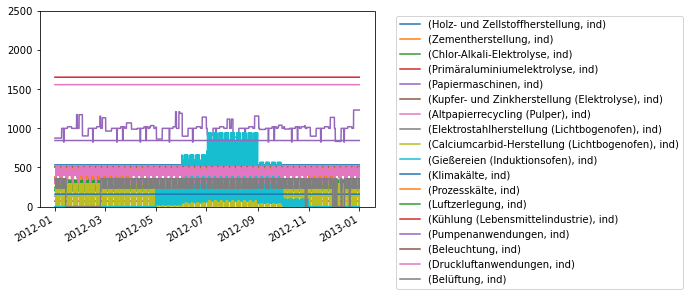

In [60]:
ind_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

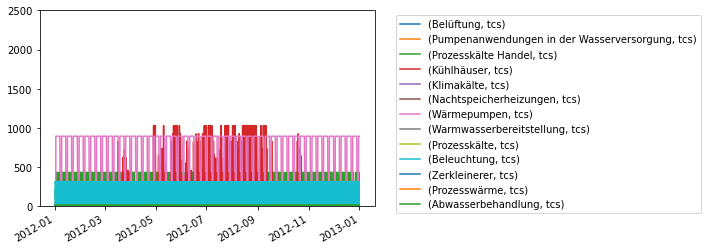

In [61]:
tcs_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

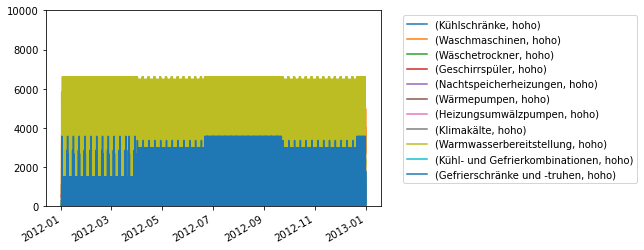

In [62]:
hoho_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,10000])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

##  Create availability time series per cluster
* Calculate weighted averages within clusters.
* Save the results, i.e. availability time series per cluster, to a csv file.

In [63]:
sector_dict = {}

for year in years:

    sector_dict[year] = {"ind": (availability_ind_pos, availability_ind_neg, potential_ind_T_dict[year]),
                       "tcs": (availability_tcs_pos, availability_tcs_neg, potential_tcs_T_dict[year]),
                       "hoho": (availability_hoho_pos, availability_hoho_neg, potential_hoho_T_dict[year])}

**Interpretation of availability factors per cluster**:
* Maximum availability per cluster does not necessarily have to be 1.
* A value of 0.88 implies that at maximum 88% of the overall cluster capacity are available at the same time. &rarr; Similar interpretation than simultaneity factor.
* Nevertheless, a rescaling is done here for the sake of easier interpretation. &rarr; I.e. maximum values will be 1.0 and cluster capacity is adapted accordingly.

In [64]:
np.sort(potential_T_dict["SQ"].loc["cluster"].unique())

array([2.0, 12.0, 112.0, 2112.0, 2113.0], dtype=object)

In [65]:
# Extract info on combined clusters for tcs and hoho separately in order not to overwrite it
tcs_hoho_clusters = potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == "tcs+hoho", 
                                             "cluster"].unique()

**_TODO: Check assignments here! Seems a bit buggy / inconvenient!_**

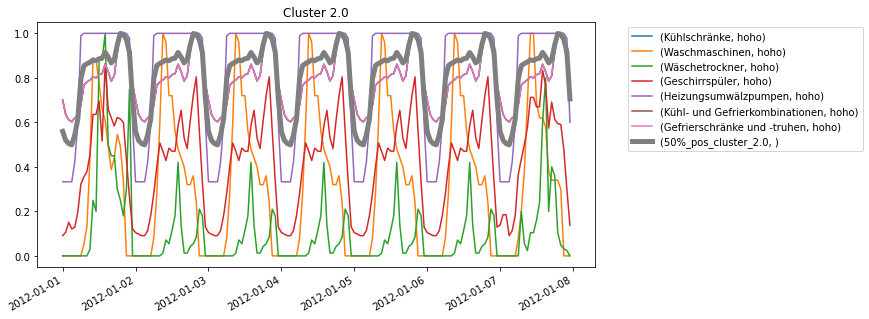

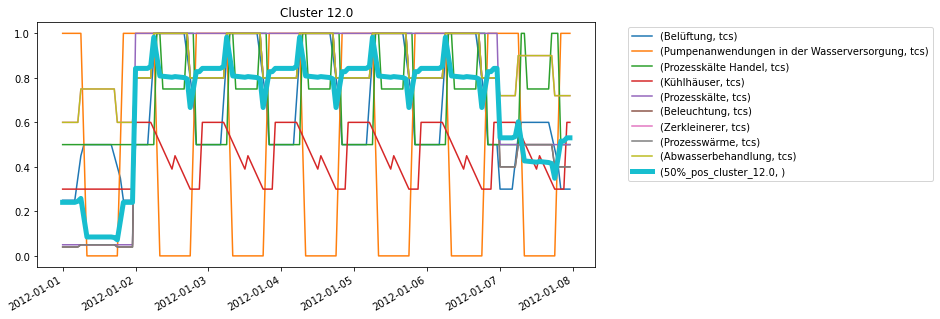

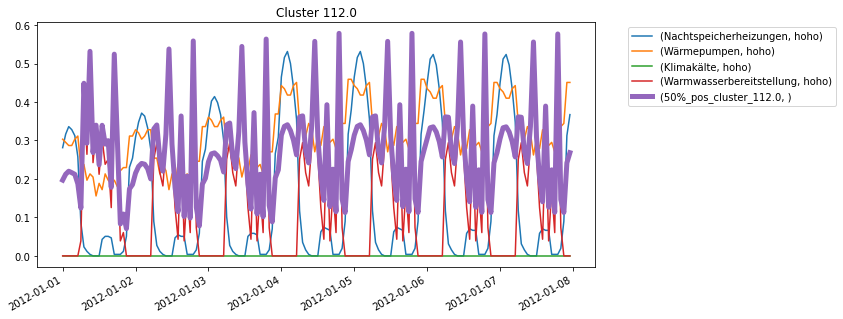

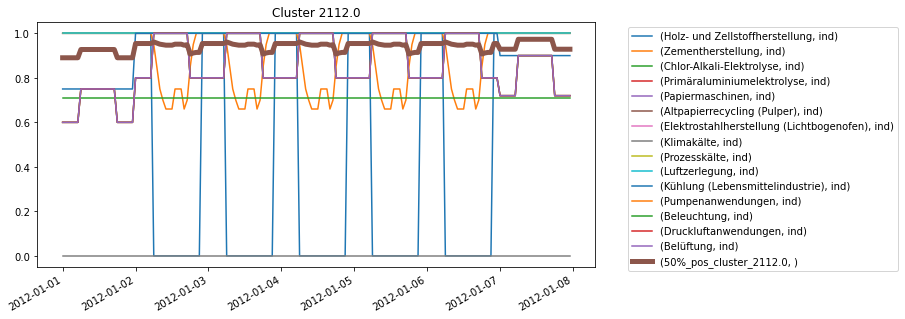

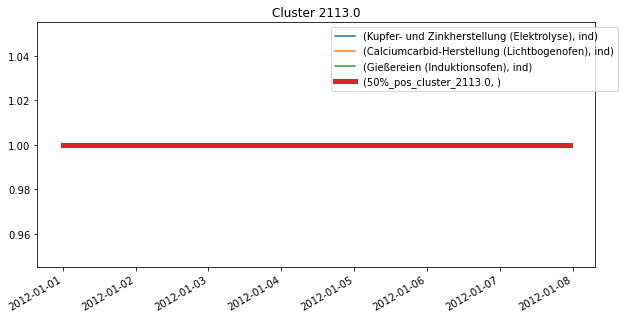

25%_hoho_cluster-2_pos  25%_hoho_cluster-2_neg  \
2012-12-31 19:00:00                  1.0000                  0.0000   
2012-12-31 20:00:00                  0.9964                  0.0118   
2012-12-31 21:00:00                  0.9677                  0.1065   
2012-12-31 22:00:00                  0.9033                  0.3018   
2012-12-31 23:00:00                  0.7310                  0.5740   

                     50%_hoho_cluster-2_pos  50%_hoho_cluster-2_neg  \
2012-12-31 19:00:00                  0.9993                  0.3615   
2012-12-31 20:00:00                  0.9960                  0.3386   
2012-12-31 21:00:00                  0.9720                  0.2564   
2012-12-31 22:00:00                  0.9157                  0.4522   
2012-12-31 23:00:00                  0.7051                  0.5451   

                     75%_hoho_cluster-2_pos  75%_hoho_cluster-2_neg  \
2012-12-31 19:00:00                  0.9855                  0.4905   
2012-12-31 20:00:00                  0.9891                  0.4717   
2012-12-31 21:00:00                  0.9464                  0.2868   
2012-12-31 22:00:00                  0.8775                  0.4416   
2012-12-31 23:00:00                  0.6541                  0.4602   

                     25%_tcs_cluster-12_pos  25%_tcs_cluster-12_neg  \
2012-12-31 19:00:00                  0.7761                  0.2086   
2012-12-31 20:00:00                  0.8603                  0.3065   
2012-12-31 21:00:00                  0.8603                  0.3065   
2012-12-31 22:00:00                  0.8603                  0.2982   
2012-12-31 23:00:00                  0.8603                  0.2982   

                     50%_tcs_cluster-12_pos  50%_tcs_cluster-12_neg  ...  \
2012-12-31 19:00:00                  0.7483                  0.2345  ...   
2012-12-31 20:00:00                  0.8278                  0.3270  ...   
2012-12-31 21:00:00                  0.8278                  0.3270  ...   
2012-12-31 22:00:00                  0.8425                  0.2965  ...   
2012-12-31 23:00:00                  0.8425                  0.2965  ...   

                     50%_ind_cluster-2112_pos  50%_ind_cluster-2112_neg  \
2012-12-31 19:00:00                    0.9385                    0.6710   
2012-12-31 20:00:00                    0.9410                    0.6619   
2012-12-31 21:00:00                    0.9410                    0.6619   
2012-12-31 22:00:00                    0.9810                    0.6389   
2012-12-31 23:00:00                    0.9810                    0.6389   

                     75%_ind_cluster-2112_pos  75%_ind_cluster-2112_neg  \
2012-12-31 19:00:00                    0.9408                    0.6499   
2012-12-31 20:00:00                    0.9427                    0.6419   
2012-12-31 21:00:00                    0.9427                    0.6419   
2012-12-31 22:00:00                    0.9777                    0.6162   
2012-12-31 23:00:00                    0.9777                    0.6162   

                     25%_ind_cluster-2113_pos  25%_ind_cluster-2113_neg  \
2012-12-31 19:00:00                       1.0                       1.0   
2012-12-31 20:00:00                       1.0                       1.0   
2012-12-31 21:00:00                       1.0                       1.0   
2012-12-31 22:00:00                       1.0                       1.0   
2012-12-31 23:00:00                       1.0                       1.0   

                     50%_ind_cluster-2113_pos  50%_ind_cluster-2113_neg  \
2012-12-31 19:00:00                       1.0                       1.0   
2012-12-31 20:00:00                       1.0                       1.0   
2012-12-31 21:00:00                       1.0                       1.0   
2012-12-31 22:00:00                       1.0                       1.0   
2012-12-31 23:00:00                       1.0                       1.0   

                     75%_ind_cluster-2113_pos  75%_i

In [66]:
pot_cols = ["potential_pos_overall", "potential_neg_overall", "installed_cap"]
cols_of_interest = [i+"_"+j for i in cols for j in pot_cols]

# Use dicts and DataFrames to store overall cluster potential and availability time series per cluster
cluster_overall_pot_dict = {}
cluster_overall_ts_dict = {}
availability_clusters = pd.DataFrame(index=availability_ind_pos.index).drop("cluster")

# Create availability time series within clusters by calculating weighted averages
for year in years:
    
    cluster_overall_pot_df = pd.DataFrame(columns=cols_of_interest)
    load_timeseries = pd.DataFrame(index=overall_ts_dict[("SQ","50%")].iloc[:-1].index)
    
    for el in np.sort(potential_T_dict["SQ"].loc["cluster"].unique()):
        
        to_concat = []
        cluster_data = {}
        
        for col in cols:
            sector = potential_T_dict[year].loc[:,potential_T_dict[year].loc[
                "cluster"] == el].columns.get_level_values(1)[0]
            
            # introduce shortcuts for readability
            org_ava_pos = sector_dict[year][sector][0]
            org_ava_neg = sector_dict[year][sector][1]
            pots_T = sector_dict[year][sector][2]
            
            # Calculate a weighted average for positive potentials (weights: maximum potential information)
            ava_pos = org_ava_pos.loc[:,org_ava_pos.loc["cluster"] == el].drop("cluster")    
            pot_pos = pots_T.loc[col+"_potential_pos_overall", pots_T.loc["cluster"] == el]
            overall_pot_pos = pot_pos.sum()
            
            if overall_pot_pos != 0:
                ava_pos[col+"_pos_cluster_"+str(el)] = ava_pos.mul(pot_pos).div(overall_pot_pos).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                # and scale max value of availability time series to 1            
                max_pot_pos = ava_pos[col+"_pos_cluster_"+str(el)].max() * overall_pot_pos
                ava_pos[col+"_pos_cluster_"+str(el)] = \
                    ava_pos[col+"_pos_cluster_"+str(el)].div(ava_pos[col+"_pos_cluster_"+str(el)].max())
            
            # Calculate a weighted average for negative potentials (weights: potential information)
            ava_neg = org_ava_neg.loc[:,org_ava_neg.loc["cluster"] == el].drop("cluster")    
            pot_neg = pots_T.loc[col+"_potential_neg_overall", pots_T.loc["cluster"] == el]
            overall_pot_neg = pot_neg.sum()
            
            if overall_pot_neg != 0:
                ava_neg[col+"_neg_cluster_"+str(el)] = ava_neg.mul(pot_neg).div(overall_pot_neg).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                # and scale max value of availability time series to 1
                max_pot_neg = ava_neg[col+"_neg_cluster_"+str(el)].max() * overall_pot_neg
                ava_neg[col+"_neg_cluster_"+str(el)] = \
                    ava_neg[col+"_neg_cluster_"+str(el)].div(ava_neg[col+"_neg_cluster_"+str(el)].max())

            if el not in tcs_hoho_clusters:
                cluster_label = sector+"_cluster-"+str(int(el))
            else:
                cluster_label = "tcs+hoho_cluster-"+str(int(el))

            # show exemplarily availability time series for clusters
            if year == "SQ":
                availability_clusters[col+"_"+cluster_label+"_pos"] = ava_pos[col+"_pos_cluster_"+str(el)]
                availability_clusters[col+"_"+cluster_label+"_neg"] = ava_neg[col+"_neg_cluster_"+str(el)]
                availability_clusters = availability_clusters.round(4)
            
                if col == "50%":
                    # Show a sample week for the clusters (SQ, positive potentials and median only)
                    fig, ax = plt.subplots(figsize=(10,5))
                    _ = ava_pos.iloc[:168,:-1].plot(ax=ax)
                    _ = ava_pos.iloc[:168,-1:].plot(ax=ax, linewidth=5)
                    _ = plt.title("Cluster "+str(el))
                    _ = plt.legend(bbox_to_anchor=(1.05, 1))
                    plt.show()
                    fig.savefig("cluster_"+str(el)+".png")
                    plt.close()
            
            # Save potential outputs
            cluster_data[col+"_"+pot_cols[0]] = max_pot_pos
            cluster_data[col+"_"+pot_cols[1]] = max_pot_neg
            
            # Assign load profiles and store them in a dict
            load_timeseries[col+"_"+cluster_label] = overall_ts_dict[(year, col)].loc[
                :,overall_ts_dict[(year, col)].loc["cluster"] == el].sum(axis=1).drop("cluster")
            
            max_cap = load_timeseries[col+"_"+cluster_label].max()
            
            cluster_data[col+"_"+pot_cols[2]] = max_cap
            
        # Combine potential outputs and store them in dict of DataFrames
        cluster_overall_pot_df.loc[cluster_label, [i+"_"+j for i in cols 
                                                           for j in pot_cols]] = cluster_data

        cluster_overall_pot_dict[year] = cluster_overall_pot_df
    
        cluster_overall_ts_dict[year] = load_timeseries

display(availability_clusters.tail())

Introduce some fixes:
* Normalize load profiles again in order to be able to use them combined with maximum capacity demand
* Rename installed\_cap to max\_cap in order to prevent misinterpretation

In [67]:
# Normalize load profiles (for usage in oemof)
# Rename column to max cap in order to be able to distinct it from installed capacity
for year in years:
    cluster_overall_ts_dict[year] = cluster_overall_ts_dict[year].div(cluster_overall_ts_dict[year].max())
    for col in cols:
        cluster_overall_pot_dict[year].rename({col + "_installed_cap": col + "_max_cap" for col in cols},
                                      axis=1, inplace=True)

In [68]:
cluster_overall_pot_dict["SQ"].head()

25%_potential_pos_overall 25%_potential_neg_overall  \
hoho_cluster-2                         2588.54                       500   
tcs_cluster-12                         936.389                   1790.91   
tcs+hoho_cluster-112                   651.617                   266.547   
ind_cluster-2112                       3706.31                   1212.07   
ind_cluster-2113                        104.25                     23.75   

                     25%_max_cap 50%_potential_pos_overall  \
hoho_cluster-2            8885.4                    4981.6   
tcs_cluster-12            1259.2                   1650.08   
tcs+hoho_cluster-112     7934.55                   3425.54   
ind_cluster-2112         7124.06                   6249.19   
ind_cluster-2113         1368.86                       171   

                     50%_potential_neg_overall 50%_max_cap  \
hoho_cluster-2                         1832.52     9018.57   
tcs_cluster-12                         2897.16     1480.63   
tcs+hoho_cluster-112                   1439.82     8130.49   
ind_cluster-2112                       2804.93     9387.58   
ind_cluster-2113                            38     1596.51   

                     75%_potential_pos_overall 75%_potential_neg_overall  \
hoho_cluster-2                         7179.02                    6738.7   
tcs_cluster-12                         2103.95                   3426.66   
tcs+hoho_cluster-112                   6459.05                   6171.83   
ind_cluster-2112                       8864.83                    4923.2   
ind_cluster-2113                        317.75                     58.75   

                     75%_max_cap  
hoho_cluster-2           12517.2  
tcs_cluster-12           1599.27  
tcs+hoho_cluster-112     8209.18  
ind_cluster-2112         10957.1  
ind_cluster-2113         1880.64

In [69]:
cluster_overall_pot_dict["2050"].head()

25%_potential_pos_overall 25%_potential_neg_overall  \
hoho_cluster-2                         1682.89                       500   
tcs_cluster-12                          1160.7                   1876.68   
tcs+hoho_cluster-112                   1349.98                   864.038   
ind_cluster-2112                        4092.9                   923.671   
ind_cluster-2113                         92.47                     20.24   

                     25%_max_cap 50%_potential_pos_overall  \
hoho_cluster-2           8284.54                   3310.61   
tcs_cluster-12           2580.48                   1886.39   
tcs+hoho_cluster-112      4435.4                    9557.3   
ind_cluster-2112         8988.84                   6606.55   
ind_cluster-2113         1489.78                    162.64   

                     50%_potential_neg_overall 50%_max_cap  \
hoho_cluster-2                         1344.15     8362.24   
tcs_cluster-12                         2957.83     2924.75   
tcs+hoho_cluster-112                   4773.43     4514.84   
ind_cluster-2112                        2246.1     9984.22   
ind_cluster-2113                         36.13     1771.28   

                     75%_potential_pos_overall 75%_potential_neg_overall  \
hoho_cluster-2                         4586.56                   3616.08   
tcs_cluster-12                         2550.62                   3677.43   
tcs+hoho_cluster-112                   25572.1                   15863.5   
ind_cluster-2112                       9078.85                   3833.35   
ind_cluster-2113                        347.39                     57.58   

                     75%_max_cap  
hoho_cluster-2           8439.93  
tcs_cluster-12           3269.03  
tcs+hoho_cluster-112     4614.77  
ind_cluster-2112         10943.2  
ind_cluster-2113         2052.78

In [70]:
cluster_overall_ts_dict["2050"].max()

25%_hoho_cluster-2          1.0
50%_hoho_cluster-2          1.0
75%_hoho_cluster-2          1.0
25%_tcs_cluster-12          1.0
50%_tcs_cluster-12          1.0
75%_tcs_cluster-12          1.0
25%_tcs+hoho_cluster-112    1.0
50%_tcs+hoho_cluster-112    1.0
75%_tcs+hoho_cluster-112    1.0
25%_ind_cluster-2112        1.0
50%_ind_cluster-2112        1.0
75%_ind_cluster-2112        1.0
25%_ind_cluster-2113        1.0
50%_ind_cluster-2113        1.0
75%_ind_cluster-2113        1.0
dtype: float64

In [71]:
cluster_labels = cluster_overall_pot_dict["SQ"].index.values
cluster_ts_by_cols = {}
ava_pos_ts_by_cols = {}
ava_neg_ts_by_cols = {}

# Split timeseries into subsets
for col in cols:
    for year in years:
        ava_cols = [i+"_"+j for i in [col] for j in cluster_labels]
        ava_cols_pos = [i+"_"+j+"_pos" for i in [col] for j in cluster_labels]
        ava_cols_neg = [i+"_"+j+"_neg" for i in [col] for j in cluster_labels]

        cluster_ts_by_cols[col+"_"+year] = cluster_overall_ts_dict[year][ava_cols]
        ava_pos_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_pos]
        ava_neg_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_neg]

In [72]:
cluster_ts_by_cols["25%_SQ"]

25%_hoho_cluster-2  25%_tcs_cluster-12  \
2012-01-01 00:00:00            0.140289            0.185198   
2012-01-01 01:00:00            0.154073            0.185198   
2012-01-01 02:00:00            0.183522            0.185198   
2012-01-01 03:00:00            0.164152            0.185198   
2012-01-01 04:00:00            0.168729            0.185198   
...                                 ...                 ...   
2012-12-31 19:00:00            0.586753            0.268081   
2012-12-31 20:00:00            0.698687            0.263759   
2012-12-31 21:00:00            0.650251            0.263759   
2012-12-31 22:00:00            0.501616            0.263759   
2012-12-31 23:00:00            0.202127            0.263759   

                     25%_tcs+hoho_cluster-112  25%_ind_cluster-2112  \
2012-01-01 00:00:00                  0.036134              0.892218   
2012-01-01 01:00:00                  0.032919              0.892218   
2012-01-01 02:00:00                  0.031771              0.892218   
2012-01-01 03:00:00                  0.031311              0.892218   
2012-01-01 04:00:00                  0.032230              0.892218   
...                                       ...                   ...   
2012-12-31 19:00:00                  0.477109              0.968973   
2012-12-31 20:00:00                  0.267413              0.971168   
2012-12-31 21:00:00                  0.048649              0.971168   
2012-12-31 22:00:00                  0.046777              0.971168   
2012-12-31 23:00:00                  0.041495              0.971168   

                     25%_ind_cluster-2113  
2012-01-01 00:00:00              0.373451  
2012-01-01 01:00:00              0.373451  
2012-01-01 02:00:00              0.373451  
2012-01-01 03:00:00              0.373451  
2012-01-01 04:00:00              0.373451  
...                                   ...  
2012-12-31 19:00:00              0.241954  
2012-12-31 20:00:00              0.241954  
2012-12-31 21:00:00              0.241954  
2012-12-31 22:00:00              0.433939  
2012-12-31 23:00:00              0.433939  

[8784 rows x 5 columns]

In [73]:
if write_outputs:
    availability_clusters.to_csv(path_folder_availability+filename_availability_out, sep=";", decimal=",")
    write_multiple_sheets(cluster_ts_by_cols, path_folder_parameterization, 
                          filename_load_profiles_out+".xlsx")

## Group the data within the clusters and write outputs
Determine, how the grouping will take place and which aggregation rules to apply for a parameter:
* *grouping_cols*: Columns to group by (cluster numbers)
* *mean_cols*: Columns for which the weighted average is used
* *sum_cols*: Columns for which entries are summed up

The average positive potential is used for calculating weigthed averages.<br>
> _Note: Again, there are possible alternatives here:_
> * _Use the installed capacity &rarr; drawback: missing for most demand response categories._
> * _Use positive or negative capacity dependent on parameter. &rarr; drawback: may lead to inconsistencies due to differing weights._

In [74]:
# Extract parameters of interest for further model-based analyses
params_of_interest_all = params_tbu + params_remaining
params_of_interest_all.remove("year_key")
params_of_interest = set()
for el in params_of_interest_all:
    params_of_interest.add(el[4:])
params_of_interest = list(params_of_interest)

In [75]:
grouping_cols = ["cluster"]
other_cols = []

mean_list = []
sum_list = []
for k, v in parameters_groups_dict.items():
    if k not in params_of_interest:
        continue
    if v[0] == "mean":
        mean_list.append(k)
    elif v[0] == "sum":
        sum_list.append(k)
        
mean_cols = create_parameter_combinations(mean_list, cols)
sum_cols = create_parameter_combinations(sum_list, cols)

In [76]:
# Renaming of cluster identifiers
name_dict = {"ind_cluster-2112": "ind_cluster-1",
             "ind_cluster-2113": "ind_cluster-2",
             "tcs_cluster-12": "tcs_cluster",
             "hoho_cluster-2": "hoho_cluster",
             "tcs+hoho_cluster-112": "tcs_hoho_cluster"}

In [77]:
def round_of_rating(number):
    """Round a number to the closest quarter integer. """
    return round(number * 4) / 4

In [78]:
# Calculate the parameters for the clusters
ind_dict = {}
tcs_dict = {}
hoho_dict = {}
tcs_hoho_dict = {}
overall_dict = {}

pot_cols = ["potential_pos_overall", "potential_neg_overall", "max_cap"]
dur_cols = ["interference_duration_neg", "interference_duration_pos", 
            "regeneration_duration", "shifting_duration"]
cost_cols = ["fixed_costs", "variable_costs", "specific_investments"]
other_cols = ["maximum_activations_year", "installed_cap", "max_cap",
              "potential_neg_overall", "potential_pos_overall"]

for col in cols:
    for year in years:
        ind_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "ind"], 
                                                 grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                 sum_cols=sum_cols, other_cols=other_cols,
                                                 sector="ind", drop=[el for el in cols if el != col]).round(2)
        
        tcs_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "tcs"], 
                                                 grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                 sum_cols=sum_cols, other_cols=other_cols,
                                                 sector="tcs", drop=[el for el in cols if el != col]).round(2)
        
        hoho_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "hoho"], 
                                                  grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                  sum_cols=sum_cols,  other_cols=other_cols,
                                                  sector="hoho", drop=[el for el in cols if el != col]).round(2)
        
        tcs_hoho_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "tcs+hoho"], 
                                                      grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                      sum_cols=sum_cols,  other_cols=other_cols,
                                                      sector="tcs+hoho", drop=[el for el in cols if el != col]).round(2)
        
        cols_potentials = [i+"_"+j for i in [col] for j in pot_cols]

        # Update potential data with availability information from above
        if adjust_potentials:
            ind_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            tcs_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            hoho_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            tcs_hoho_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
        
        # Add country and bus information (needed in power market model)
        ind_dict[col+"_"+year][col+"_country"] = "DE"
        tcs_dict[col+"_"+year][col+"_country"] = "DE"
        hoho_dict[col+"_"+year][col+"_country"] = "DE"
        tcs_hoho_dict[col+"_"+year][col+"_country"] = "DE"
        
        ind_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        tcs_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        hoho_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        tcs_hoho_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        
        # Combine to dict holding all parameter data for the clusters
        overall_dict[col+"_"+year] = pd.concat([ind_dict[col+"_"+year], 
                                                tcs_dict[col+"_"+year], 
                                                hoho_dict[col+"_"+year], 
                                                tcs_hoho_dict[col+"_"+year]])
        
        # Adjust rounding: costs to 1 digit; durations to nearest quarter integer; other params to 0 digits
        cols_duration = [i+"_"+j for i in [col] for j in dur_cols]
        cols_costs = [i+"_"+j for i in [col] for j in cost_cols]
        cols_other = [i+"_"+j for i in [col] for j in other_cols]
        
        overall_dict[col+"_"+year][cols_duration] = overall_dict[col+"_"+year][cols_duration].apply(
            round_of_rating)
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].round(1)
        # Replace zero cost values which might occur in rounding
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].replace({0.0:0.01})
        overall_dict[col+"_"+year][cols_other] = overall_dict[col+"_"+year][cols_other].round(0)
        
        # Do some renaming
        overall_dict[col+"_"+year].rename(name_dict, inplace=True)
        overall_dict[col+"_"+year].columns = overall_dict[col+"_"+year].columns.str[4:]

In [79]:
overall_dict["50%_2050"]

fixed_costs  interference_duration_neg  \
cluster                                                    
ind_cluster-1             0.8                       3.25   
ind_cluster-2            17.6                       4.00   
tcs_cluster               0.3                       1.25   
hoho_cluster            119.2                       1.25   
tcs_hoho_cluster         18.0                       2.50   

                  interference_duration_pos  maximum_activations_year  \
cluster                                                                 
ind_cluster-1                          2.75                      71.0   
ind_cluster-2                          2.25                      25.0   
tcs_cluster                            1.25                     159.0   
hoho_cluster                           1.00                    2383.0   
tcs_hoho_cluster                       1.75                     378.0   

                  regeneration_duration  shifting_duration  \
cluster                                                      
ind_cluster-1                       2.0               6.25   
ind_cluster-2                       2.0               5.75   
tcs_cluster                         0.0               1.75   
hoho_cluster                        0.0               0.25   
tcs_hoho_cluster                    0.0               2.75   

                  specific_investments  variable_costs  installed_cap  \
cluster                                                                 
ind_cluster-1                      1.1          290.40        12900.0   
ind_cluster-2                      6.9          859.10          367.0   
tcs_cluster                        7.1            0.01         8543.0   
hoho_cluster                      48.5            0.01        86880.0   
tcs_hoho_cluster                  33.6            0.01        64050.0   

                  potential_neg_overall  potential_pos_overall  max_cap  \
cluster                                                                   
ind_cluster-1                    2246.0                 6607.0   9984.0   
ind_cluster-2                      36.0                  163.0   1771.0   
tcs_cluster                      2958.0                 1886.0   2925.0   
hoho_cluster                     1344.0                 3311.0   8362.0   
tcs_hoho_cluster                 4773.0                 9557.0   4515.0   

                 country       from  
cluster                              
ind_cluster-1         DE  DE_bus_el  
ind_cluster-2         DE  DE_bus_el  
tcs_cluster           DE  DE_bus_el  
hoho_cluster          DE  DE_bus_el  
tcs_hoho_cluster      DE  DE_bus_el

In [80]:
# Info on remaining categories is optionally stored in order to be able to match it with availability time series
# resp. to assign similar availability time series when data is missing.
if write_categories:
    potential_dict["SQ"].to_excel("remaining_categories.xlsx")

In [81]:
# Write the parameter outputs to Excel
if write_outputs:
    write_multiple_sheets(ind_dict, path_folder_parameterization, filename_out+"_ind.xlsx")
    write_multiple_sheets(tcs_dict, path_folder_parameterization, filename_out+"_tcs.xlsx")
    write_multiple_sheets(hoho_dict, path_folder_parameterization, filename_out+"_hoho.xlsx")
    write_multiple_sheets(tcs_hoho_dict, path_folder_parameterization, filename_out+"_tcs_hoho.xlsx") 
    write_multiple_sheets(overall_dict, path_folder_parameterization, filename_out+"_overall.xlsx") 

## Write outputs
Write outputs needed for the power market model runs separately to csv files

Do some adjustments:
* Simple column naming adjustment
* Timeseries adjustments / harmonization:
> __*NOTE*__: _2017 is used as a simulation year for the power market model._
> * _Availability time series were (mostly) derived for 2012._
> * _Since 2017 and 2012 both started with a Sunday, no shifts of weekdays is necessary._
> * _Only the last day of 2012 is cut here since 2012 was a leap year._
> * _At the end, this only is a very rough estimate / first guess which **should be improved**._

In [82]:
# Do some column naming adjustment
cases = ["25%_SQ", "50%_SQ", "75%_SQ"]

for case in cases:
    cluster_ts_by_cols[case].columns = cluster_ts_by_cols[case].columns.str[4:]
    ava_pos_ts_by_cols[case].columns = ava_pos_ts_by_cols[case].columns.str[4:-4]
    ava_neg_ts_by_cols[case].columns = ava_neg_ts_by_cols[case].columns.str[4:-4]

    cluster_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_pos_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_neg_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\pandas\core\frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [83]:
# Do time series harmonization thing
new_timeindex = pd.date_range(start="2017-01-01 00:00", periods=8784, freq="H")

for case in cases:
    cluster_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_pos_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_neg_ts_by_cols[case]["new_timeindex"] = new_timeindex
    
    cluster_ts_by_cols[case] = cluster_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)
    ava_pos_ts_by_cols[case] = ava_pos_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)
    ava_neg_ts_by_cols[case] = ava_neg_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)

<ipython-input-83-ce27ff7def71>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_ts_by_cols[case]["new_timeindex"] = new_timeindex
<ipython-input-83-ce27ff7def71>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ava_pos_ts_by_cols[case]["new_timeindex"] = new_timeindex
<ipython-input-83-ce27ff7def71>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [84]:
cluster_ts_by_cols["25%_SQ"]

hoho_cluster  tcs_cluster  tcs_hoho_cluster  \
new_timeindex                                                      
2017-01-01 00:00:00        0.1403       0.1852            0.0361   
2017-01-01 01:00:00        0.1541       0.1852            0.0329   
2017-01-01 02:00:00        0.1835       0.1852            0.0318   
2017-01-01 03:00:00        0.1642       0.1852            0.0313   
2017-01-01 04:00:00        0.1687       0.1852            0.0322   
...                           ...          ...               ...   
2017-12-31 19:00:00        0.5176       0.1604            0.6435   
2017-12-31 20:00:00        0.4828       0.1852            0.3839   
2017-12-31 21:00:00        0.4413       0.1852            0.0486   
2017-12-31 22:00:00        0.5601       0.1852            0.0449   
2017-12-31 23:00:00        0.1731       0.2579            0.0415   

                     ind_cluster-1  ind_cluster-2  
new_timeindex                                      
2017-01-01 00:00:00         0.8922         0.3735  
2017-01-01 01:00:00         0.8922         0.3735  
2017-01-01 02:00:00         0.8922         0.3735  
2017-01-01 03:00:00         0.8922         0.3735  
2017-01-01 04:00:00         0.8922         0.3735  
...                            ...            ...  
2017-12-31 19:00:00         0.9256         0.3735  
2017-12-31 20:00:00         0.9256         0.3735  
2017-12-31 21:00:00         0.9256         0.3735  
2017-12-31 22:00:00         0.9256         0.3735  
2017-12-31 23:00:00         0.9256         0.3735  

[8760 rows x 5 columns]

In [85]:
for case in cases:
    # Node information
    overall_dict[case].to_csv(path_folder_parameterization+"sinks_demand_response_el_"+case[:2]+".csv")
    # Load profile information
    cluster_ts_by_cols[case].to_csv(path_folder_parameterization+"sinks_demand_response_el_ts_"+case[:2]+".csv")
    # Availability information
    ava_pos_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_pos_ts_"+case[:2]+".csv")
    ava_neg_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_neg_ts_"+case[:2]+".csv")

# Bibliography
Gils, Hans Christian (2015): Balancing of Intermittent Renewable Power Generation by Demand Response and Thermal Energy Storage. Dissertation. Universität Stuttgart, Stuttgart.

Kochems, Johannes (2020): Lastflexibilisierungspotenziale in Deutschland - Bestandsaufnahme und Entwicklungsprojektionen. Langfassung. In: IEE TU Graz (Hg.): EnInnov 2020 - 16. Symposium Energieinnovation. Energy for Future - Wege zur Klimaneutralität. Graz, 12.-14.02, https://www.tugraz.at/fileadmin/user_upload/tugrazExternal/4778f047-2e50-4e9e-b72d-e5af373f95a4/files/lf/Session_E5/553_LF_Kochems.pdf, accessed 11.05.2020.